augment the coco format labels with DETR hidden states for stage 3 of the project

input: output of ptn2gcn

runs DETR on each model to get the

In [1]:
import sys, os
sys.path.insert(0, os.path.abspath('..'))

import os
import json
from PIL import Image
from transformers import DetrImageProcessor, DetrForObjectDetection
from tqdm.notebook import tqdm
import torch
import torch.nn.functional as F
import torchvision.ops as ops  # For NMS
from utils import get_iou, state_dict_cleaner, detr2xyxy, coco2xyxy

In [2]:
# this DETR model is only used for forward pass with the weights we trained from 

from pytorch_lightning import LightningModule

class MyLightningModel(LightningModule):
    def __init__(self, model_name, checkpoint, num_labels):
        super().__init__()
        
        self.model = DetrForObjectDetection.from_pretrained(model_name, num_labels=num_labels,ignore_mismatched_sizes=True)
        state_dict = torch.load(checkpoint)['state_dict']
        state_dict = state_dict_cleaner(state_dict)
        self.model.load_state_dict(state_dict)
    
    def forward(self, **inputs):
        return self.model(**inputs)

In [4]:
def gcn2stage3(
        input_labels, 
        output_labels, 
        image_dir, 
        detr_model, 
        checkpoint,
        num_labels=64,
        batch_size=4, 
        iou_threshold=0.8, 
        confidence_threshold=0.5, 
        iou_match_threshold=0.5,
        device = "cuda"):
    # Set up the image processor and the DETR model
    image_processor = DetrImageProcessor.from_pretrained(detr_model)
    model = MyLightningModel(detr_model, checkpoint,num_labels)
    model.to(device)
    model.eval()

    # Count total lines in the input file for progress tracking
    with open(input_labels, 'r', encoding="utf8") as infile:
        total_lines = sum(1 for _ in infile)

    # Progress bar setup
    progress = tqdm(total=total_lines, desc="Processing Batches", unit="samples")

    with open(input_labels, 'r', encoding="utf8") as infile, open(output_labels, 'w', encoding="utf8") as outfile:
        labels = []

        for line in infile:
            # Parse the JSON line
            label = json.loads(line)
            labels.append(label)

            # Update progress bar
            progress.update(1)

            if len(labels) == batch_size:
                # Load and process the batch of images
                images = [Image.open(os.path.join(image_dir, label['filename'])).convert("RGB") for label in labels]
                inputs = image_processor(images=images, return_tensors="pt")

                inputs = {k: v.to(device) for k, v in inputs.items()}

                # Forward pass through the model
                outputs = model(**inputs)

                logits = outputs.logits  # Shape: (batch_size, num_queries, num_classes)
                pred_boxes = outputs.pred_boxes  # Shape: (batch_size, num_queries, 4)
                pred_boxes_copy = pred_boxes.clone()
                for idx, boxes_img in enumerate(pred_boxes_copy):  # Loop through each image in the batch
                    image_width, image_height = images[idx].size  # Get original image dimensions
                    pred_boxes[idx] = torch.tensor(
                        [detr2xyxy(box.cpu().tolist(), image_width, image_height) for box in boxes_img],
                        device=device
                    )
                hidden_states = outputs.last_hidden_state  # Shape: (batch_size, num_queries, hidden_dim)

                # Process each image in the batch
                for idx, label in enumerate(labels):
                    logits_img = logits[idx]  # Shape: (num_queries, num_classes)
                    boxes_img = pred_boxes[idx]  # Shape: (num_queries, 4)
                    hidden_states_img = hidden_states[idx]  # Shape: (num_queries, hidden_dim)

                    # as per the docs
                    prob = F.softmax(logits_img, dim=-1)
                    scores, _ = prob[..., :-1].max(-1)

                    # Filter by confidence threshold
                    keep = scores > confidence_threshold
                    boxes_img = boxes_img[keep]
                    hidden_states_img = hidden_states_img[keep]
                    scores = scores[keep]

                    # Apply NMS
                    if boxes_img.shape[0] > 0:
                        keep_nms = ops.nms(boxes_img, scores, iou_threshold)
                        boxes_img = boxes_img[keep_nms]
                        hidden_states_img = hidden_states_img[keep_nms]

                    # Match DETR boxes to ground truth boxes
                    bbox_indices = []
                    filtered_boxes = []
                    filtered_hidden_states = []
                    gt_bboxes = label['gt_bboxes']
                    gt_bboxes = [coco2xyxy(box) for box in gt_bboxes]
                    gt_bbox_indices = label['gt_bbox_indices']

                    for detr_bbox, hidden_state in zip(boxes_img, hidden_states_img):

                        detr_bbox = detr_bbox.detach().cpu().numpy().tolist()

                        # Find the ground truth box with the highest IoU
                        max_iou = 0
                        best_gt_index = -1
                        for i, gt_bbox in enumerate(gt_bboxes):
                            iou = get_iou(detr_bbox, gt_bbox)
                            if iou > max_iou:
                                max_iou = iou
                                best_gt_index = i

                        # Keep the DETR bbox if the highest IoU exceeds the threshold
                        if max_iou >= iou_match_threshold:
                            filtered_boxes.append(detr_bbox)
                            filtered_hidden_states.append(hidden_state.detach().cpu().numpy().tolist())
                            bbox_indices.append(gt_bbox_indices[best_gt_index])

                    # Add fields to the label
                    del label["gt_bboxes"]
                    del label["gt_bbox_indices"]
                    label['bboxes'] = filtered_boxes
                    label['bbox_indices'] = bbox_indices
                    label['hidden_states'] = filtered_hidden_states
                    # check passed: all same len

                # Write the processed batch to the output file
                for label in labels:
                    outfile.write(json.dumps(label) + '\n')

                # Reset batch
                labels = []

        # Close the progress bar
        progress.close()


In [5]:
gcn2stage3(
    input_labels=r"C:\Users\remote desktop\Downloads\DETR-GFTE\datasets\gcn\stage3\ptn2gcn\val.jsonl",
    output_labels=r"C:\Users\remote desktop\Downloads\DETR-GFTE\datasets\gcn\stage3\gcn2stage3\val.jsonl",
    image_dir=r"C:\Users\remote desktop\Downloads\pubtabnet\val",
    detr_model="facebook/detr-resnet-50",
    checkpoint=r"C:\Users\remote desktop\Downloads\DETR-GFTE\checkpoints\detr-epoch=00-validation\loss=0.78.ckpt",
    num_labels = 64,
    batch_size= 4
)

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model checkpoin

Processing Batches:   0%|          | 0/9081 [00:00<?, ?samples/s]

check integrity of jsonl, since we might have keyboard interrupted the above cell

In [6]:
import os
import json

def check_last_line_is_json(file_path):
    with open(file_path, 'rb') as file:
        file.seek(0, os.SEEK_END)  # Move to the end of the file
        position = file.tell()
        line = b''

        while position >= 0:
            file.seek(position)  # Move to the current position
            char = file.read(1)  # Read one byte
            if char == b'\n' and line:  # Newline found and line is not empty
                break
            line = char + line  # Prepend the character to the line
            position -= 1  # Move backwards

        try:
            last_line = line.decode('utf-8')  # Decode binary to string
            json.loads(last_line)  # Check if it's valid JSON
            print("Last line is valid JSON.")
            return True
        except json.JSONDecodeError:
            print("Last line is NOT valid JSON.")
            return False

# Example usage
file_path = r"C:\Users\remote desktop\Downloads\DETR-GFTE\datasets\gcn\stage3\gcn2stage3\train.jsonl"
check_last_line_is_json(file_path)

Last line is valid JSON.


True

iou_threshold and confidence_threshold are hyperparameters that we should play with to achieve satisfactory bboxes

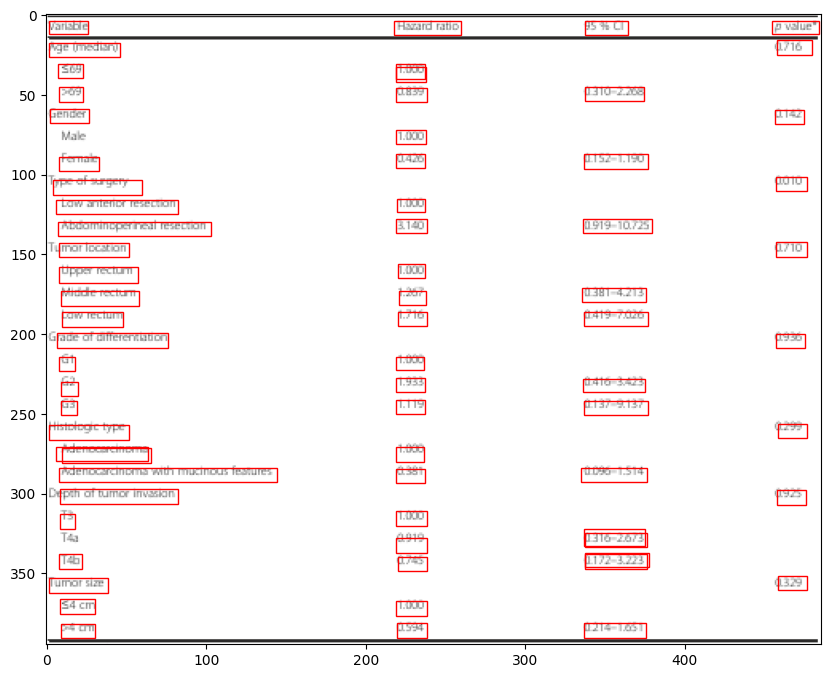

In [ ]:
import json
import os
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_bboxes_on_image(jsonl_line, image_dir):
    """
    Plots bounding boxes on the specified image.

    Args:
        jsonl_line (str): A line from the JSONL file containing bounding box data.
        image_dir (str): Path to the directory containing the image.
        output_path (str): Path to save the output image. If None, display the plot.
    """
    # Parse the JSON line
    data = json.loads(jsonl_line)
    filename = data["filename"]
    bboxes = data["bboxes"]  # List of bounding boxes in xyxy format

    # Load the image
    image_path = os.path.join(image_dir, filename)
    image = Image.open(image_path).convert("RGB")
    width, height = image.size

    # Plot the image
    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(image)

    # Draw bounding boxes
    for bbox in bboxes:
        x_min, y_min, x_max, y_max = bbox
        rect = patches.Rectangle(
            (x_min, y_min),  # Bottom-left corner
            x_max - x_min,  # Width
            y_max - y_min,  # Height
            linewidth=1,
            edgecolor='r',
            facecolor='none'
        )
        ax.add_patch(rect)

    plt.show()

# Example usage
jsonl_line = '''{"filename": "PMC4840965_004_00.png", "image_id": 0, "html": ["<thead>", "<tr>", "<td>", "</td>", "<td>", "</td>", "<td>", "</td>", "<td>", "</td>", "</tr>", "</thead>", "<tbody>", "<tr>", "<td>", "</td>", "<td>", "</td>", "<td>", "</td>", "<td>", "</td>", "</tr>", "<tr>", "<td>", "</td>", "<td>", "</td>", "<td>", "</td>", "<td>", "</td>", "</tr>", "<tr>", "<td>", "</td>", "<td>", "</td>", "<td>", "</td>", "<td>", "</td>", "</tr>", "<tr>", "<td>", "</td>", "<td>", "</td>", "<td>", "</td>", "<td>", "</td>", "</tr>", "<tr>", "<td>", "</td>", "<td>", "</td>", "<td>", "</td>", "<td>", "</td>", "</tr>", "<tr>", "<td>", "</td>", "<td>", "</td>", "<td>", "</td>", "<td>", "</td>", "</tr>", "<tr>", "<td>", "</td>", "<td>", "</td>", "<td>", "</td>", "<td>", "</td>", "</tr>", "<tr>", "<td>", "</td>", "<td>", "</td>", "<td>", "</td>", "<td>", "</td>", "</tr>", "<tr>", "<td>", "</td>", "<td>", "</td>", "<td>", "</td>", "<td>", "</td>", "</tr>", "<tr>", "<td>", "</td>", "<td>", "</td>", "<td>", "</td>", "<td>", "</td>", "</tr>", "<tr>", "<td>", "</td>", "<td>", "</td>", "<td>", "</td>", "<td>", "</td>", "</tr>", "<tr>", "<td>", "</td>", "<td>", "</td>", "<td>", "</td>", "<td>", "</td>", "</tr>", "<tr>", "<td>", "</td>", "<td>", "</td>", "<td>", "</td>", "<td>", "</td>", "</tr>", "<tr>", "<td>", "</td>", "<td>", "</td>", "<td>", "</td>", "<td>", "</td>", "</tr>", "<tr>", "<td>", "</td>", "<td>", "</td>", "<td>", "</td>", "<td>", "</td>", "</tr>", "<tr>", "<td>", "</td>", "<td>", "</td>", "<td>", "</td>", "<td>", "</td>", "</tr>", "<tr>", "<td>", "</td>", "<td>", "</td>", "<td>", "</td>", "<td>", "</td>", "</tr>", "<tr>", "<td>", "</td>", "<td>", "</td>", "<td>", "</td>", "<td>", "</td>", "</tr>", "<tr>", "<td>", "</td>", "<td>", "</td>", "<td>", "</td>", "<td>", "</td>", "</tr>", "<tr>", "<td>", "</td>", "<td>", "</td>", "<td>", "</td>", "<td>", "</td>", "</tr>", "<tr>", "<td>", "</td>", "<td>", "</td>", "<td>", "</td>", "<td>", "</td>", "</tr>", "<tr>", "<td>", "</td>", "<td>", "</td>", "<td>", "</td>", "<td>", "</td>", "</tr>", "<tr>", "<td>", "</td>", "<td>", "</td>", "<td>", "</td>", "<td>", "</td>", "</tr>", "<tr>", "<td>", "</td>", "<td>", "</td>", "<td>", "</td>", "<td>", "</td>", "</tr>", "<tr>", "<td>", "</td>", "<td>", "</td>", "<td>", "</td>", "<td>", "</td>", "</tr>", "<tr>", "<td>", "</td>", "<td>", "</td>", "<td>", "</td>", "<td>", "</td>", "</tr>", "<tr>", "<td>", "</td>", "<td>", "</td>", "<td>", "</td>", "<td>", "</td>", "</tr>", "</tbody>"], "bboxes": [[217.737060546875, 3.7138803005218506, 259.97808837890625, 12.434967041015625], [454.5871276855469, 3.357133388519287, 483.9289245605469, 11.500622749328613], [335.83709716796875, 171.15599060058594, 375.6575012207031, 179.9729461669922], [218.7368621826172, 86.76445770263672, 237.38201904296875, 95.93277740478516], [1.1289607286453247, 3.561336040496826, 26.067642211914062, 11.604731559753418], [220.18307495117188, 156.01409912109375, 237.22703552246094, 165.12094116210938], [219.19842529296875, 127.87440490722656, 238.11334228515625, 136.6531982421875], [336.7498779296875, 185.97357177734375, 376.72357177734375, 194.84405517578125], [218.73348999023438, 45.76127243041992, 238.11546325683594, 54.72650909423828], [219.04534912109375, 284.7798767089844, 236.9757843017578, 293.6278076171875], [219.48814392089844, 114.99491882324219, 237.29161071777344, 123.53701782226562], [220.42095947265625, 186.32435607910156, 238.11325073242188, 195.0361328125], [218.67376708984375, 30.79787826538086, 237.33653259277344, 40.03773880004883], [219.92433166503906, 339.5000915527344, 238.31591796875, 348.5157165527344], [336.3212585449219, 227.88291931152344, 375.3702392578125, 236.55335998535156], [9.495796203613281, 186.3712615966797, 47.538429260253906, 195.33514404296875], [336.53094482421875, 381.2881164550781, 375.8262023925781, 390.3541564941406], [337.4293212890625, 3.413655996322632, 364.6007385253906, 12.192605972290039], [218.62733459472656, 214.1012420654297, 236.40524291992188, 222.72239685058594], [8.824204444885254, 381.9466552734375, 30.470857620239258, 390.70648193359375], [219.20892333984375, 241.26695251464844, 237.28956604003906, 249.99172973632812], [218.7660675048828, 367.66131591796875, 238.12815856933594, 376.8447570800781], [218.9292449951172, 311.1044006347656, 238.5097198486328, 320.4686584472656], [218.9189453125, 71.94638061523438, 237.61056518554688, 80.53864288330078], [218.99392700195312, 270.9510498046875, 236.7013702392578, 280.1282043457031], [219.623291015625, 381.45703125, 238.2340545654297, 390.2939453125], [8.357565879821777, 312.96929931640625, 17.88962173461914, 322.512451171875], [219.2241668701172, 327.8240661621094, 238.41650390625, 337.09783935546875], [8.675890922546387, 173.17323303222656, 57.657142639160156, 182.44532775878906], [335.2024230957031, 283.93719482421875, 376.2846374511719, 292.65594482421875], [337.2752990722656, 338.1690368652344, 376.1293640136719, 347.1445007324219], [337.73046875, 324.5458984375, 376.1373596191406, 333.42547607421875], [219.1505126953125, 227.42965698242188, 236.96754455566406, 236.1406707763672], [6.949957370758057, 30.470678329467773, 22.50387954711914, 39.59012222290039], [8.429454803466797, 366.12213134765625, 30.37015151977539, 375.6967468261719], [8.570727348327637, 229.87713623046875, 19.782854080200195, 238.96791076660156], [7.5556640625, 214.2410125732422, 17.6287841796875, 223.02774047851562], [336.54168701171875, 242.0507354736328, 376.68109130859375, 250.73556518554688], [220.51947021484375, 173.19464111328125, 237.4750213623047, 182.04022216796875], [7.517209529876709, 88.82369232177734, 32.87358093261719, 97.86734771728516], [7.7411417961120605, 45.185585021972656, 22.616430282592773, 54.57196044921875], [8.659008026123047, 241.67196655273438, 18.85942268371582, 250.83323669433594], [336.4308776855469, 127.7567138671875, 379.5655822753906, 136.6614532470703], [7.835106372833252, 142.56227111816406, 51.41208267211914, 151.54537963867188], [7.736114501953125, 338.1817321777344, 21.816255569458008, 347.4065856933594], [337.1661376953125, 45.07407760620117, 374.5865173339844, 53.81159591674805], [6.004801273345947, 270.6258544921875, 63.46116256713867, 279.7264404296875], [9.662192344665527, 271.2356872558594, 65.25775909423828, 280.5163269042969], [336.837890625, 87.22347259521484, 377.1017150878906, 96.245361328125], [6.874119758605957, 129.556396484375, 102.92723083496094, 138.4809112548828], [456.86138916015625, 59.48638916015625, 474.9588623046875, 68.4601058959961], [7.955228805541992, 297.4277038574219, 81.93154907226562, 306.5495300292969], [5.707649230957031, 115.80219268798828, 82.34825134277344, 124.66024017333984], [3.9600038528442383, 103.61156463623047, 59.73958206176758, 112.4748306274414], [219.12681579589844, 32.602760314941406, 237.78050231933594, 41.95520782470703], [7.759444236755371, 158.07858276367188, 57.16752624511719, 167.7438201904297], [7.698497772216797, 284.25836181640625, 144.13754272460938, 292.9875793457031], [458.5149841308594, 256.36407470703125, 476.4615783691406, 265.16680908203125], [6.142025947570801, 199.5610809326172, 75.74868774414062, 208.50428771972656], [458.2902526855469, 351.77801513671875, 476.653076171875, 360.55096435546875], [1.0954430103302002, 17.298131942749023, 45.602474212646484, 25.939064025878906], [1.8671965599060059, 58.55264663696289, 26.43918800354004, 67.69265747070312], [457.4832763671875, 199.80885314941406, 475.42242431640625, 208.58546447753906], [457.8526611328125, 297.90985107421875, 476.1607360839844, 307.2132263183594], [1.625169277191162, 257.21142578125, 51.6087646484375, 266.5867919921875], [457.0214538574219, 101.56671142578125, 476.3744201660156, 110.40987396240234], [457.54534912109375, 15.73311710357666, 479.5299987792969, 24.803945541381836], [457.4389343261719, 142.44639587402344, 476.7559814453125, 151.46090698242188], [337.37982177734375, 337.08941650390625, 377.437744140625, 346.2572326660156], [1.5780963897705078, 352.8481140136719, 38.1132698059082, 362.39984130859375], [336.5569152832031, 322.26702880859375, 374.80255126953125, 332.6767883300781]], "bbox_indices": [1, 3, 50, 25, 0, 45, 37, 54, 13, 81, 33, 53, 9, 97, 66, 52, 110, 2, 61, 108, 69, 105, 89, 21, 77, 109, 88, 93, 48, 82, 98, 94, 65, 8, 104, 64, 60, 70, 49, 24, 12, 68, 38, 40, 96, 14, 76, 76, 26, 36, 19, 84, 32, 28, 9, 44, 80, 75, 56, 103, 4, 16, 59, 87, 72, 31, 7, 43, 98, 100, 94], "hidden_states": [[-0.5553714632987976, -1.185976505279541, -0.9384956359863281, -0.4363047480583191, 0.8520100116729736, 0.6077784895896912, -1.718038558959961, 0.7274820804595947, -0.09778492152690887, -0.24327871203422546, -0.2482198178768158, 0.22510986030101776, -0.45386645197868347, -0.8656824827194214, -0.35649752616882324, 2.37623929977417, 0.6572058796882629, -0.31126439571380615, -0.34716492891311646, 0.46176740527153015, -0.35688507556915283, -0.05194176360964775, 0.2024262249469757, 1.6242552995681763, 0.7844333648681641, -0.17576086521148682, 0.009633268229663372, 0.4736131429672241, -0.16869045794010162, -0.8067158460617065, 0.3246290385723114, 0.496151328086853, 0.9126404523849487, 0.9845550656318665, -0.6164417862892151, 1.241275429725647, -0.014897473156452179, -0.8908334374427795, 0.8364497423171997, -0.33967888355255127, 2.200343608856201, 1.4102460145950317, 1.600498080253601, -0.07447336614131927, -3.012409210205078, 0.8654164671897888, 0.45381155610084534, 0.4886034429073334, 0.6542844176292419, -0.3094155192375183, 2.325371742248535, 1.4654361009597778, -0.3296055793762207, -0.005349345970898867, 0.6630178689956665, 0.5754233598709106, 0.4426780343055725, 0.6983177661895752, 1.9387941360473633, 0.29885566234588623, 0.49884751439094543, -1.0031253099441528, 2.0470287799835205, -2.62724232673645, 2.5578243732452393, 1.34749436378479, -1.0417320728302002, -3.3021323680877686, -0.43151259422302246, 0.4215988218784332, 0.7244423627853394, -1.2368911504745483, -1.884783148765564, 2.158207654953003, -1.7324026823043823, 0.6237354278564453, 0.4302135109901428, -0.9331838488578796, 2.011215925216675, -0.4056513011455536, -0.9296758770942688, -0.9370558261871338, -0.5367438197135925, 0.7851277589797974, -0.26043257117271423, 0.85323166847229, 1.2735323905944824, -1.3790465593338013, -0.06840591877698898, 0.1876882016658783, -0.6703218817710876, -0.7584801912307739, 0.19568155705928802, -0.6087342500686646, 0.4744844436645508, 0.22890661656856537, 0.843529462814331, 0.016379062086343765, -0.4642045795917511, -0.2917511463165283, 1.2433699369430542, 1.0408838987350464, -0.18035456538200378, 0.5171006321907043, -0.6771702170372009, 0.6775811910629272, 0.3488089144229889, -1.020039439201355, 1.7443480491638184, -1.479801058769226, 1.3569897413253784, -0.5812473893165588, 2.197500228881836, 0.2187218964099884, 1.0030369758605957, 0.5230995416641235, -0.33675187826156616, 0.20201443135738373, -0.8368971943855286, -1.3462427854537964, 0.386007696390152, 0.265253484249115, 0.8804370760917664, 0.14569683372974396, 1.4099476337432861, -0.1846499890089035, 0.622721791267395, 1.061866283416748, -2.16325044631958, 1.1122753620147705, 0.06267567723989487, 1.061286449432373, 1.194758653640747, 0.32400012016296387, -0.6939200162887573, 1.2383944988250732, -0.4637644588947296, -0.0601947158575058, -0.41288548707962036, -0.0319119468331337, -1.1927191019058228, -0.1648024320602417, -0.24741055071353912, 0.3824229836463928, 1.4318962097167969, 0.3548378050327301, -0.15182605385780334, 0.396200954914093, -1.6025171279907227, -0.8702839612960815, -0.65549236536026, 0.4902815818786621, -1.6456396579742432, -0.9454408288002014, 0.3829655051231384, -0.6114912629127502, 1.8273675441741943, 1.5712225437164307, -1.1933670043945312, 0.041702430695295334, -1.8010419607162476, -0.41460520029067993, 0.2646379768848419, 1.996898889541626, 0.5146898627281189, 1.4939247369766235, -0.4691236913204193, -0.19200628995895386, -1.1431695222854614, 0.6869421005249023, -0.9387261867523193, 0.7581192851066589, 0.12954583764076233, -0.7953365445137024, -1.5163782835006714, -0.7076875567436218, -2.53420352935791, 0.7640693187713623, -0.1061825305223465, -1.5740058422088623, 0.22372125089168549, 0.8463846445083618, -0.9939537644386292, -1.7466089725494385, -0.1825219988822937, -0.3198736011981964, -0.3751189708709717, -1.1873975992202759, 0.8955438137054443, -0.021495884284377098, -0.8593015670776367, 1.1757731437683105, 0.9342541694641113, 0.5078426003456116, 2.035020351409912, 0.9602439403533936, -0.6249256134033203, -1.1782695055007935, 0.6377471089363098, -0.39809557795524597, 0.15814709663391113, 0.04927068203687668, 0.3589308261871338, -0.8647067546844482, -1.0038381814956665, 0.6691752076148987, -0.30430057644844055, -0.40680697560310364, -1.244907259941101, 0.14487144351005554, -0.02922588400542736, -0.9742622971534729, -0.28359776735305786, -0.7142377495765686, -0.35145696997642517, -0.40793997049331665, -1.2563445568084717, -0.44082608819007874, -0.7274333238601685, 1.6185120344161987, -0.7545607089996338, 1.5465519428253174, 1.3551695346832275, -0.9562605023384094, -1.7571941614151, -0.2504771947860718, -0.8815460205078125, -1.5181821584701538, 2.206024646759033, 2.524653196334839, -0.21284596621990204, 0.10456116497516632, -0.5814695358276367, -0.29279565811157227, 0.8676280975341797, -1.3179446458816528, -1.0145784616470337, -1.6102815866470337, 1.6042568683624268, -0.10696162283420563, 1.828586459159851, 0.5321542620658875, -1.001137614250183, 1.0457185506820679, 1.4378169775009155, 0.6656990647315979, -0.019164640456438065, 1.183931827545166, 0.3570360243320465, 0.555739164352417, 0.2636314630508423, 1.6395586729049683, 0.7848089337348938, -0.20964692533016205, 0.4695933759212494, 0.3718448281288147], [-0.7419508099555969, -1.437612771987915, -1.2826523780822754, -0.8659247756004333, 0.5184376835823059, 0.5307159423828125, -1.5689114332199097, -0.8154613971710205, 0.06543376296758652, 0.3061041533946991, 0.2862437665462494, -0.0651603415608406, -0.15622787177562714, -1.2827610969543457, -0.14536945521831512, 2.406529664993286, -0.11413134634494781, -0.5010825991630554, -0.5394180417060852, 1.903018832206726, -0.38726985454559326, -0.40000423789024353, 2.5729336738586426, 0.7566231489181519, 0.06767930090427399, 0.6015324592590332, 0.035032302141189575, -0.23424652218818665, 0.9109151363372803, 0.022923719137907028, 2.3489556312561035, 0.23637326061725616, 0.15027694404125214, -0.526275098323822, 1.1472430229187012, 2.1375045776367188, -0.4649055600166321, -0.6512421369552612, 0.7632290720939636, 0.013456677086651325, 0.6548954248428345, 0.11269145458936691, 1.1601892709732056, 1.4265388250350952, -4.340596675872803, 0.026380324736237526, 0.5741012692451477, -0.43284130096435547, -0.2327284812927246, -0.9150736331939697, 0.8053868412971497, 0.6094293594360352, -0.4476800262928009, 0.12463285028934479, 0.5632632374763489, 0.32318422198295593, 0.45933666825294495, 1.2062656879425049, 2.357166051864624, 1.1142069101333618, 1.1063724756240845, -0.36124059557914734, 1.8168288469314575, -3.0371809005737305, 2.1111347675323486, 0.6767864227294922, -1.2411830425262451, -2.8038086891174316, 0.6141412854194641, 0.4086482524871826, 0.5311155915260315, -1.0429747104644775, -2.18166446685791, -1.1895928382873535, -1.3546048402786255, 0.16939014196395874, 0.9028141498565674, -0.6212218999862671, 2.400705099105835, -0.3511127531528473, 1.1393944025039673, 0.39774298667907715, -0.33928602933883667, 0.5463256239891052, 0.10454969108104706, 0.8310744762420654, 0.9688151478767395, 0.5053156018257141, -0.047519270330667496, 0.7195937633514404, -0.9683383107185364, 0.502475380897522, 0.6826789379119873, -0.5818240642547607, -1.8254555463790894, 0.3470839560031891, 1.3697398900985718, -0.14420244097709656, -0.637377142906189, 0.20310525596141815, 1.8379273414611816, -0.7906444072723389, -0.20501697063446045, 0.24426880478858948, -0.09582531452178955, 0.5701078772544861, 0.1490340381860733, -1.240004539489746, 0.9543304443359375, -0.7004649043083191, 2.0277700424194336, -0.35829320549964905, 1.8332024812698364, 0.032519835978746414, -1.1308248043060303, -0.3750244677066803, -0.26586055755615234, 0.21332231163978577, 0.11228729784488678, 0.6213449835777283, 2.891164541244507, -0.32833799719810486, -0.12907372415065765, 0.5151203870773315, 0.8459572792053223, -1.3392038345336914, -1.0401158332824707, -0.05802132561802864, -1.5022038221359253, 1.3489024639129639, 1.0096313953399658, 1.096737265586853, 1.131493330001831, -1.2218477725982666, 1.1808494329452515, 2.437479257583618, 0.02027205191552639, 0.9387507438659668, -1.1702845096588135, 0.768120527267456, -0.7859243154525757, -0.42506298422813416, -0.09184194356203079, -0.4413471519947052, 1.3470032215118408, 1.3277573585510254, 0.5033739805221558, 0.9850120544433594, 1.6692020893096924, -0.8068948984146118, 0.2972981035709381, -1.346031665802002, 0.17053696513175964, 1.4323194026947021, -0.49047428369522095, -2.2549631595611572, -0.7808825373649597, 1.2017695903778076, -2.741504192352295, 0.363521009683609, -1.9137481451034546, -1.080427885055542, -0.06472349166870117, -0.9808766841888428, 0.32379382848739624, 2.7568199634552, -0.5987017154693604, -0.7186356782913208, -0.9059610366821289, 0.5309410691261292, -0.4788976311683655, -0.19009317457675934, 0.23737947642803192, -0.39104408025741577, -1.2419757843017578, -0.7451148629188538, -0.989354133605957, 0.6258833408355713, -0.0960397720336914, -2.14560866355896, -0.797548770904541, 0.9281055331230164, 0.26568806171417236, -2.9119696617126465, 0.020291361957788467, 0.13286671042442322, 1.0472878217697144, -1.3012148141860962, 0.5453507900238037, -1.2734116315841675, -0.5523011088371277, 1.0769928693771362, -0.009171790443360806, 0.1477116346359253, 1.5116955041885376, 0.5308698415756226, -0.7261602282524109, -1.0481183528900146, 0.7388730645179749, -0.423768550157547, 0.5277743935585022, 1.2594956159591675, 1.3662261962890625, -0.7212140560150146, -0.7065255641937256, 0.346775621175766, -0.1325860172510147, -0.06200936809182167, -0.8570263385772705, -0.6507115960121155, 0.5502486824989319, 0.7436988949775696, 0.4823416471481323, 0.8026055693626404, -0.6184583306312561, 0.022098349407315254, -0.54146409034729, -1.031288981437683, -1.746256947517395, -0.20611192286014557, -0.34808364510536194, 0.8026336431503296, 0.8067237734794617, -0.8299052715301514, 2.839538335800171, 0.13786087930202484, -1.007874608039856, -2.576188325881958, -0.18187940120697021, -0.5637490749359131, 0.6885607838630676, 0.28783896565437317, -1.8672475814819336, -0.2058078944683075, -0.47640475630760193, -1.4377214908599854, 0.19739016890525818, -1.2722581624984741, -0.8400070667266846, -0.19448500871658325, 1.7360742092132568, 0.2710705101490021, -0.14576956629753113, 1.6699047088623047, 0.14479798078536987, 0.07282326370477676, 1.192233681678772, 0.4051111340522766, -0.17492727935314178, 0.5517083406448364, -0.11035327613353729, 1.8749632835388184, 0.6342194080352783, -0.10167062282562256, 1.4341635704040527, 0.2748534381389618], [0.4395001232624054, -0.27571722865104675, 0.2743188142776489, 0.5515357851982117, -0.7581995129585266, -0.2689944803714752, -0.9526876211166382, 0.7249249815940857, 0.05085286125540733, -0.7728660106658936, -0.8208538293838501, -0.6595441102981567, 0.8074133396148682, 0.23898988962173462, 0.03134043142199516, 3.126971960067749, -0.037408094853162766, 0.9210777878761292, 0.3280755877494812, 0.39139339327812195, 0.1018427312374115, 0.3309982419013977, 1.5079326629638672, -2.0618278980255127, 2.5348308086395264, -1.8457133769989014, 0.9157175421714783, -0.06939934939146042, 2.8172128200531006, 0.4343683123588562, -0.38775843381881714, 0.7807134985923767, 0.15601010620594025, 0.5782221555709839, 0.82173752784729, 2.0765433311462402, -0.3433525860309601, 0.5640624761581421, -0.745253324508667, -0.4470753073692322, 1.0502492189407349, 0.3910021185874939, -0.8291399478912354, -0.5315902233123779, -4.016092300415039, 0.6058472394943237, 0.06361377984285355, 0.3542548716068268, -0.07663405686616898, 0.8175128102302551, 1.2367740869522095, -0.8939201235771179, 0.1977926790714264, 1.1060316562652588, 0.4357830584049225, -0.06196490302681923, -1.1475903987884521, -0.6872284412384033, 0.8190585374832153, -0.2853100299835205, 0.03577737882733345, -0.49946656823158264, -0.2938039302825928, -2.060643196105957, -0.8376028537750244, -0.8423282504081726, -0.8722553253173828, 2.1471357345581055, 0.24488775432109833, -0.042131271213293076, -0.026528725400567055, -0.8243631720542908, 1.0085313320159912, 1.1511410474777222, 0.5190442800521851, 0.3560582399368286, 0.27218207716941833, -0.7016590237617493, -0.5253961682319641, -0.4079910218715668, -0.7117807269096375, -1.2203197479248047, -0.7078652381896973, 0.9927947521209717, -0.36252376437187195, -0.4953475594520569, -1.481691598892212, -0.08532828092575073, -1.7941960096359253, -0.06304103881120682, 0.7408380508422852, 0.9656993746757507, 1.9554592370986938, 0.2576075494289398, 1.2818200588226318, 0.9255527257919312, 0.08571971952915192, -0.20839527249336243, 0.3408929407596588, -0.15976804494857788, 0.5778046250343323, 0.03017318621277809, -0.028108008205890656, -0.1747610867023468, -1.4647051095962524, 2.2490646839141846, 0.8534986972808838, -0.795688271522522, -0.3438195288181305, -0.2803148627281189, 1.1283817291259766, 0.2722684442996979, -0.16928179562091827, -0.5008148550987244, 0.03633849322795868, 0.6148533225059509, 0.6211057901382446, 1.1324337720870972, -1.007083773612976, -0.20863257348537445, 0.9806955456733704, -0.3165091574192047, 2.234222650527954, 1.1660070419311523, -0.737985372543335, -0.06379549205303192, -3.783237934112549, 1.1632390022277832, -0.717748761177063, -2.0407373905181885, -0.45375606417655945, 0.01560426689684391, 2.204096555709839, -0.079967200756073, -0.2011089026927948, 1.7123297452926636, -0.7668911814689636, 1.0229750871658325, -0.7036208510398865, -0.4574817717075348, -0.5730854272842407, -1.3626837730407715, -0.12198328971862793, 0.31895896792411804, -0.47859251499176025, 0.24942061305046082, 0.3338050842285156, -1.440353274345398, 0.11801688373088837, -0.6031809449195862, -1.0274275541305542, -0.9456719756126404, -0.5578219890594482, -0.6151388883590698, -0.00015430751955136657, -0.8215522766113281, 2.3524551391601562, 0.17128172516822815, -1.0870624780654907, 0.9199079871177673, 0.04587371274828911, -0.16894245147705078, 0.30400997400283813, 0.9477128982543945, 0.45691466331481934, 3.340564250946045, 0.30764901638031006, 0.5861036777496338, -0.9855679869651794, 0.40580853819847107, -0.015750635415315628, -1.9826960563659668, -0.385544091463089, 1.40481698513031, -0.17082569003105164, 1.0146217346191406, -0.7772077918052673, 0.5901437997817993, -0.10936503857374191, -2.4079225063323975, -0.06818533688783646, 0.0995459109544754, -0.5739847421646118, 0.7036620378494263, -1.4907636642456055, 0.6826328039169312, 0.2934679090976715, -0.7857921719551086, 0.454619437456131, -0.20586663484573364, 0.708180844783783, 0.3267210125923157, -1.1689056158065796, 0.05529632791876793, 1.8290318250656128, -0.5163568258285522, 0.9991274476051331, 0.5844292640686035, -0.10173414647579193, -0.4521123766899109, 2.2871506214141846, 0.2971048057079315, 0.9153486490249634, 1.589317798614502, -0.4460655152797699, 0.33862826228141785, -1.2623448371887207, -1.2291926145553589, 0.45274490118026733, 0.8428748846054077, 0.09810855239629745, 0.40819063782691956, 0.6761714816093445, -1.0690444707870483, 0.4301871955394745, -0.09704776853322983, -0.32419660687446594, 0.7991058230400085, -0.7952757477760315, 1.3782644271850586, -0.9985033273696899, -0.24714206159114838, 0.4245806932449341, -1.0307905673980713, 0.7656599879264832, -0.3580170273780823, -0.21182312071323395, -1.5169707536697388, 1.209727168083191, -1.532116413116455, 0.03456483036279678, -0.6401642560958862, -1.3329945802688599, -0.20090673863887787, 1.181126594543457, 0.698157012462616, 1.1378686428070068, -0.1815672665834427, 0.2826196849346161, -0.31227532029151917, -0.9465669393539429, -0.42123934626579285, -1.4428662061691284, -0.6254763007164001, 1.5874745845794678, 0.05808988958597183, 0.22901682555675507, -1.1485397815704346, 0.30280470848083496, -0.8024442791938782, 1.4215606451034546, 0.8258206844329834, 0.29576584696769714, -1.1901334524154663, 0.7913576364517212, 1.5585297346115112], [-0.6741924285888672, -0.5948290228843689, 0.12787798047065735, 0.9506530165672302, -0.6119232773780823, -0.15239308774471283, -0.2473471462726593, 1.5279239416122437, -0.18224795162677765, -0.3122880160808563, -0.8153804540634155, -0.3006097376346588, 0.2636912167072296, -0.35526221990585327, 0.7908464074134827, 3.1163508892059326, 0.7116308212280273, 0.1133919507265091, -0.3365199863910675, -0.09107021242380142, -0.24046888947486877, 0.531282365322113, 0.17813141644001007, -1.272237777709961, 0.24893562495708466, -0.759150505065918, -0.3017433285713196, 0.6244919896125793, 1.1791048049926758, -0.4549414813518524, -0.1363806277513504, -0.18645690381526947, 0.026753583922982216, 0.04094870761036873, -0.43276235461235046, 2.1330318450927734, -0.11958739161491394, -0.5303701758384705, -1.0439839363098145, -0.9594626426696777, 2.287107467651367, 0.05147738382220268, 1.2051804065704346, -0.2690920829772949, -3.503359079360962, 1.1876237392425537, 0.27770307660102844, -0.21174144744873047, 0.36248359084129333, 1.8352868556976318, 0.8602166771888733, 0.8156976699829102, 0.14176881313323975, 0.6790723204612732, 0.8332284092903137, 1.0648397207260132, -0.04348920285701752, 0.7273329496383667, 1.5172799825668335, 0.15170949697494507, 0.12824726104736328, -1.2771892547607422, 1.100303053855896, -2.187757730484009, -0.13158537447452545, 1.3476635217666626, -1.4026548862457275, -0.5155279636383057, -0.49642232060432434, -0.11585692316293716, -0.7253373861312866, -1.313112735748291, 0.12935779988765717, 2.3452675342559814, -1.4353735446929932, 0.0461750291287899, 0.6717012524604797, -0.8845512270927429, -0.27760088443756104, -0.7416183352470398, 0.428242951631546, -0.7201659679412842, 0.7006386518478394, 0.9662414193153381, 0.7411444783210754, -0.7761603593826294, -0.5355098247528076, -0.3370097875595093, -0.05280032381415367, -0.5998138189315796, 1.0539880990982056, -0.4046984016895294, 1.32410728931427, -0.24441049993038177, 1.5938130617141724, -0.3938608467578888, -0.33496570587158203, 0.5134767889976501, -0.5184178352355957, -1.3936326503753662, 0.3927443027496338, 1.3960301876068115, 0.754548966884613, -0.2697938084602356, -0.6691639423370361, 2.6761958599090576, 2.0692694187164307, -0.5640572309494019, 0.5531138181686401, -0.25383397936820984, -0.8277615904808044, 0.18027831614017487, 0.6197189092636108, 0.044329263269901276, 1.4169379472732544, 0.38543426990509033, -0.5384742021560669, 0.6081756353378296, 0.3915906548500061, -1.7717801332473755, -0.5493838787078857, 0.20559221506118774, 1.6088733673095703, 0.7444393038749695, 0.49045756459236145, -0.2884604036808014, 0.6666059494018555, -0.39217039942741394, -0.33362877368927, -0.7864285111427307, 0.24387229979038239, -0.6972616314888, 2.522115707397461, 0.7685275077819824, 0.11212176084518433, 1.0550373792648315, -0.5248759388923645, -0.45957455039024353, -0.6679868102073669, 0.17156483232975006, -1.3483203649520874, -0.6726897954940796, -0.12338890880346298, 0.4227622449398041, -0.40788936614990234, 0.16103947162628174, -1.310612678527832, 0.2533164918422699, -2.2514445781707764, -0.923361599445343, -0.6656258702278137, 0.852425754070282, -0.811577558517456, -1.3319154977798462, 0.7542873024940491, -0.589348316192627, 1.5805904865264893, 0.8345962166786194, -1.8729610443115234, 0.030676160007715225, -0.8553552627563477, -0.15873239934444427, -0.1053958609700203, 0.49949443340301514, -0.38714832067489624, 3.262376546859741, 0.43376585841178894, -0.528860330581665, -0.991446316242218, -0.2406901866197586, 0.26150670647621155, -1.0178043842315674, 0.4914562702178955, 0.4114014804363251, 0.4166533350944519, 0.8686379194259644, -0.7001041173934937, -0.10243832319974899, -0.14883215725421906, -1.8691396713256836, 0.09281748533248901, -0.10843050479888916, -0.6760790348052979, 1.0139392614364624, -0.40691280364990234, -0.131328746676445, -0.07290095090866089, -0.9848542213439941, 0.3190089464187622, 0.5994926691055298, 1.2636996507644653, 0.7241767048835754, -0.17957144975662231, 0.6169129014015198, 2.112795352935791, 1.0054512023925781, 2.494839668273926, -0.32639968395233154, -0.8360686302185059, -0.7124404311180115, 2.3571295738220215, 0.4447331130504608, 0.2959690988063812, 0.5808846354484558, -0.8911788463592529, 0.912574052810669, -1.6722352504730225, -0.7317536473274231, -0.4367407560348511, 0.6838526725769043, -0.4153949022293091, -0.3297175467014313, 0.8693714141845703, -0.8507344126701355, -0.8961951732635498, 0.9551815390586853, -1.656063437461853, -0.5053695440292358, -1.1437512636184692, 1.5643961429595947, -1.5812623500823975, 0.008017386309802532, 1.0670068264007568, -1.2850277423858643, -2.0991978645324707, 1.1330877542495728, -0.3241725564002991, -0.5276008248329163, 2.554621934890747, -2.340522289276123, -0.2482631951570511, -1.36527419090271, -0.03773752227425575, 0.6750301718711853, 0.9396005868911743, -1.1432877779006958, -0.5969685316085815, 0.24404607713222504, 1.9168816804885864, -0.11996292322874069, 0.13045290112495422, 1.117073893547058, -0.7958587408065796, 0.23441672325134277, 0.849063515663147, 0.12803144752979279, 0.6466703414916992, -1.1054224967956543, 0.12531469762325287, 0.5549609661102295, 0.8733859062194824, 1.4382433891296387, 0.6574913859367371, -1.1386988162994385, 0.9700335264205933, 0.13409759104251862], [-0.8567392230033875, -0.29932907223701477, -0.8462740778923035, -1.245115876197815, 0.4956764876842499, 0.5161973237991333, -1.5271226167678833, -0.5740683078765869, -0.08439475297927856, 0.6189826726913452, 0.06737273186445236, -0.49451425671577454, -0.1860211193561554, -1.1964704990386963, 0.154643252491951, 2.729570150375366, -0.6872243285179138, -0.37769535183906555, -0.43592122197151184, 1.8718082904815674, -0.5559254884719849, -1.868662714958191, 2.31203031539917, 0.6598166227340698, -1.5700547695159912, 0.2777347266674042, 1.0188945531845093, -0.536848783493042, 0.8055190443992615, 0.15957659482955933, 1.8200392723083496, 0.35820573568344116, -0.8659052848815918, 0.05183917656540871, 1.3728426694869995, 2.253877639770508, -0.470084011554718, 0.08322877436876297, 0.808372974395752, -0.5027276873588562, 1.1627720594406128, 0.15922397375106812, 1.4292492866516113, 0.881923496723175, -4.169879913330078, -0.8934110403060913, 0.3407939374446869, -0.30136361718177795, -0.1314355432987213, -0.7919967770576477, 0.9586445689201355, 1.3801440000534058, -0.37848344445228577, 0.1731881946325302, 0.6203993558883667, -0.08670300990343094, 0.31249165534973145, -0.18443013727664948, 2.3162388801574707, 0.7522000074386597, 0.8472345471382141, -0.12397920340299606, 1.7733644247055054, -3.2104482650756836, 2.1560111045837402, 1.1961437463760376, -0.7652747631072998, -2.744966506958008, 0.76193767786026, 0.5807445645332336, 0.5954722762107849, 0.06845413893461227, -1.9203461408615112, -1.7288100719451904, -1.3527411222457886, 0.4918875992298126, 0.6410751938819885, -0.2421501874923706, 2.3042726516723633, -0.40444186329841614, 1.5876446962356567, 0.25364574790000916, -0.17118285596370697, 0.8252611756324768, -0.02954588085412979, 0.5051876306533813, 1.0297185182571411, -0.898282527923584, 0.5030885338783264, 0.07767953723669052, -0.6094602346420288, 0.3829386234283447, -0.1511297971010208, -0.5000824928283691, -1.3637497425079346, 1.300336480140686, 1.1179627180099487, -0.4754791557788849, -0.7491869926452637, 0.39240336418151855, 0.5982025265693665, -0.9864947199821472, -0.4949113130569458, 0.38222813606262207, -0.13922277092933655, 0.934935986995697, 0.028147326782345772, -0.5149362087249756, 1.2232877016067505, 0.5377028584480286, 1.7108877897262573, -0.4117319583892822, 2.6371662616729736, -0.7752138376235962, -0.39655601978302, 0.8028446435928345, -0.37805667519569397, 0.43192797899246216, -0.46700209379196167, 0.6159656047821045, 2.1567792892456055, -0.045516449958086014, 0.06795188039541245, 0.7138372659683228, 0.9848652482032776, -0.7909601330757141, 1.1799988746643066, -0.060966718941926956, -2.235574722290039, 1.4304183721542358, 0.2361876517534256, 1.054036259651184, 0.7774864435195923, -0.7929249405860901, 0.6775503754615784, 2.633039951324463, 0.2263515293598175, 0.992803156375885, -0.4063991904258728, 1.0519623756408691, -0.6999083161354065, 0.11810138076543808, -0.4956522285938263, -0.20253510773181915, 1.3553348779678345, 0.7154425978660583, 0.819386899471283, 1.734216332435608, 1.67245352268219, -1.0776158571243286, -0.08347906172275543, 1.3460040092468262, 0.016970988363027573, 1.6774749755859375, -0.7890026569366455, -1.6790419816970825, -1.4221370220184326, 0.8074504733085632, -2.438210964202881, 0.3213106095790863, -2.247563362121582, -1.1604955196380615, -1.8714725971221924, -0.023439183831214905, 0.42759251594543457, 2.64310359954834, -0.7094165682792664, -0.4447934031486511, -0.8937625885009766, 0.14201903343200684, -0.5354981422424316, 0.7646864652633667, 0.36698803305625916, -1.049085021018982, -0.910551905632019, -0.858151912689209, -1.491536259651184, 0.14855267107486725, -0.09874877333641052, -2.011610984802246, -0.15640680491924286, 0.3355191946029663, 0.32845237851142883, -2.798431158065796, 0.21473759412765503, -0.022336464375257492, 1.6099553108215332, -1.6609452962875366, 1.2468253374099731, -1.0279715061187744, -0.5091128945350647, 1.0153095722198486, 1.4801788330078125, -0.032505668699741364, 0.8359667658805847, 0.7065069079399109, -0.4561437666416168, 0.06023401394486427, 0.4227866232395172, -0.8818058371543884, 0.44952261447906494, 1.1144514083862305, 1.480921745300293, -0.7792232036590576, -0.7008799910545349, -0.4248608946800232, 0.44652533531188965, -0.5501512289047241, -1.083691954612732, -1.01615571975708, 0.7560638785362244, 0.11336549371480942, 0.03953604772686958, 0.42417216300964355, -0.9625624418258667, -0.17126302421092987, -1.1070785522460938, -0.3345116972923279, -1.1847003698349, 0.13025590777397156, -0.46570295095443726, 0.6952229142189026, 1.3195847272872925, -0.9582902789115906, 2.0688438415527344, 0.22455096244812012, -0.9981783032417297, -2.5261552333831787, -0.019638480618596077, -0.9207757711410522, 0.7103543877601624, 0.24122123420238495, -1.1879957914352417, -0.6818467378616333, -0.8934900164604187, -1.3757014274597168, 0.17217040061950684, -0.9911373853683472, -0.7174511551856995, -0.6022459268569946, 1.940313696861267, 0.3022995889186859, -1.281424641609192, 1.6186490058898926, -0.3431493639945984, -0.5678617358207703, 0.9845967888832092, 0.4544923007488251, -0.4049732983112335, 0.3187545835971832, -0.3979370594024658, 2.3573720455169678, 0.8282394409179688, -0.05957763269543648, 1.20546293258667, -0.4281522035598755], [-0.21672555804252625, -0.3842814564704895, -0.03591608256101608, 0.653482973575592, -0.546055018901825, -0.4222719073295593, -0.3295653164386749, 1.840854287147522, -0.1445980817079544, -0.19224371016025543, -0.7383922934532166, -0.4081405997276306, 0.4851989448070526, -0.012871415354311466, 0.15748126804828644, 3.425417184829712, 0.9582675695419312, 0.911401093006134, -0.4837607145309448, -0.27564334869384766, 0.05804819613695145, 1.468026876449585, 0.7511448860168457, -0.9851882457733154, 0.47527164220809937, -1.1168626546859741, 0.41960105299949646, 0.622189462184906, 1.3270512819290161, -0.21106798946857452, -0.06992733478546143, -0.11437459290027618, -0.2547864019870758, 0.11490966379642487, 0.14380888640880585, 1.491804599761963, -0.08678202331066132, 0.28970643877983093, -1.1473232507705688, -0.9784194827079773, 1.7354410886764526, -0.0921522006392479, -0.6083492040634155, -0.5214616060256958, -3.7662127017974854, 1.2358331680297852, 0.187809020280838, 0.06237095221877098, 0.5932527780532837, 1.270363450050354, 1.3396223783493042, -0.730624794960022, 0.23201090097427368, 0.5169271230697632, 0.43051111698150635, 0.6498844027519226, -0.7910142540931702, 0.2975379526615143, 1.3087162971496582, 0.33610692620277405, 0.4730338156223297, -1.013169765472412, -0.1348424255847931, -1.9545187950134277, -0.6548469066619873, 0.03825320675969124, -1.4385762214660645, 1.9503188133239746, -1.1362470388412476, -0.7101675271987915, -0.20418541133403778, -1.3732616901397705, 0.7305684685707092, 2.002513885498047, 0.13330945372581482, -0.2886538505554199, 0.7049852013587952, -0.66863614320755, -0.8529080748558044, -0.40312710404396057, -0.054053645581007004, -0.47857698798179626, -0.39812639355659485, 0.9878367185592651, -0.07120757550001144, -0.6813830137252808, -1.2698681354522705, 0.22981834411621094, 0.2605644464492798, -0.669771134853363, 0.6922576427459717, -0.4344789981842041, 1.9622730016708374, 0.02281946875154972, 1.8599910736083984, -0.12641948461532593, 0.10759774595499039, -0.027309011667966843, 0.041987065225839615, -0.4840693771839142, 0.3079729974269867, 1.629008412361145, 0.4598824083805084, -0.18968088924884796, -1.346271276473999, 2.0652918815612793, 1.3685431480407715, -0.6303690671920776, -0.7117027044296265, -0.4440823495388031, 1.2690229415893555, 0.3592946231365204, -0.45711058378219604, 0.774247944355011, 1.368057370185852, 0.4227783679962158, -0.5527994632720947, 0.11959978938102722, -0.6513766646385193, -1.8968753814697266, 0.8245232701301575, -0.06017155200242996, 1.1436461210250854, 0.14124682545661926, -0.7934727668762207, 0.07428816705942154, 0.5543040633201599, 0.6876535415649414, -0.6606501936912537, -1.4012850522994995, 0.29172834753990173, -0.1579902023077011, 2.207914352416992, 0.10996229201555252, -0.9367663860321045, 0.6954731941223145, -0.8305559158325195, -0.22125552594661713, -0.8344032764434814, 0.3929435610771179, -0.6203877925872803, -0.7537699937820435, 0.08740205317735672, 0.33087441325187683, -0.8106039762496948, 0.1586436778306961, -1.2252933979034424, -0.8005687594413757, -2.4077062606811523, -0.8154062628746033, -1.1037356853485107, 0.8875982165336609, 0.06938997656106949, -1.3060364723205566, 0.2876490652561188, 0.05741612985730171, 1.6951178312301636, 0.9108681082725525, -1.5594457387924194, 0.3159984052181244, 0.2877216935157776, 0.15035846829414368, 0.05743049457669258, 0.4230952262878418, 0.6439765691757202, 3.969637155532837, 0.4523071050643921, 0.17576651275157928, -0.9944056868553162, 0.3496823012828827, -0.08315148949623108, -1.7627391815185547, 0.3259352147579193, 1.5566558837890625, 0.3012409210205078, 1.1881057024002075, -1.049477458000183, 0.30816158652305603, -0.06272443383932114, -2.233238458633423, 0.12687885761260986, -0.12394415587186813, -0.8140348792076111, 0.1906670331954956, -0.5382208228111267, -0.5690919160842896, 0.05103378742933273, -0.5399186015129089, 0.8211230635643005, 0.6693143248558044, 0.3613234758377075, 0.491020143032074, -0.6070241332054138, 0.7337450981140137, 1.6344702243804932, 0.08467421680688858, 1.0123727321624756, 1.0523191690444946, -0.46081802248954773, -0.9326320290565491, 1.4960228204727173, 0.4379892647266388, -0.14462964236736298, 1.412153720855713, -0.5960849523544312, 0.4605635702610016, -1.478424310684204, -0.6862624287605286, 0.45020821690559387, 0.7032881379127502, -0.3471212387084961, -0.05047663673758507, 0.8271008729934692, -0.08647019416093826, 0.28846243023872375, 0.053469400852918625, -0.6503608822822571, -0.1895170956850052, -1.1031256914138794, 1.5077437162399292, -1.373674988746643, -0.23192860186100006, 0.8149243593215942, -1.1862879991531372, -2.8846871852874756, 0.43597400188446045, -0.49640581011772156, -0.10945682227611542, 2.9647581577301025, -0.8229966163635254, 0.6726780533790588, -0.5558018684387207, -0.3061971962451935, 0.45628246665000916, 1.3754910230636597, 0.4959006905555725, -0.6660619974136353, 0.11252995580434799, 1.3783936500549316, 0.1651262640953064, -0.6609909534454346, -0.10789381712675095, -0.8434466123580933, -0.2931327521800995, 0.6917716860771179, 0.1377638727426529, 0.4524170756340027, -0.9275686740875244, 0.04289345070719719, -0.3370019495487213, 0.6290494799613953, 1.478154182434082, 0.5395534634590149, -0.5718851089477539, 1.0718218088150024, 0.170889213681221], [-0.7441077828407288, -0.41918250918388367, 0.332620233297348, 1.1442286968231201, -0.611566960811615, -0.42063963413238525, -0.5878626704216003, 1.549736738204956, -0.006010584533214569, -0.682323694229126, -0.9647167921066284, -1.0689514875411987, 0.6797420382499695, -0.18647168576717377, 0.5432261228561401, 2.8598380088806152, 0.8736474514007568, 0.7292553186416626, -0.01769378036260605, -0.228445902466774, 0.274482786655426, 0.8091215491294861, 0.28063076734542847, -1.2503420114517212, 0.24775660037994385, -1.120400309562683, -0.5723690390586853, 0.5953429937362671, 1.3756492137908936, -0.3045344650745392, -0.7667655944824219, -0.08791325241327286, 0.07291039079427719, 0.046903133392333984, -0.6155322194099426, 2.070632219314575, 0.015647713094949722, -0.20410990715026855, -1.1457598209381104, -0.7286463975906372, 1.8392279148101807, 0.1742434948682785, 0.14793992042541504, -0.47479182481765747, -3.5336451530456543, 1.1956686973571777, 0.3878690004348755, -0.1148901879787445, 0.38104087114334106, 1.497920036315918, 0.9969274997711182, -0.2404737025499344, 0.20412097871303558, 0.7595689296722412, 0.610333263874054, 0.6146100163459778, -0.621162474155426, 0.3266052007675171, 1.331432580947876, 0.43317827582359314, -0.039968788623809814, -1.2327237129211426, 0.39335906505584717, -2.394712448120117, -0.7133297324180603, 0.4335959255695343, -1.3315757513046265, 1.154067873954773, -0.492781400680542, -0.6651641130447388, -0.5709288120269775, -1.1360673904418945, 0.7611730694770813, 2.161285638809204, -0.3833636939525604, -0.15774431824684143, 0.6945102214813232, -0.7538663744926453, -0.705125629901886, -0.8370053768157959, 0.33163321018218994, -0.7684509754180908, 0.0876564010977745, 1.011065125465393, 0.23577147722244263, -0.5892593860626221, -1.0416988134384155, -0.21919378638267517, 0.05142923817038536, -0.7762236595153809, 0.5211105346679688, -0.5370577573776245, 1.742132306098938, 0.058012813329696655, 1.9210468530654907, -0.0653688833117485, -0.08739300817251205, 0.44960516691207886, 0.05612865090370178, -1.089119553565979, 0.6222096681594849, 1.5013116598129272, 0.6863338947296143, -0.14260157942771912, -0.846688985824585, 2.5861876010894775, 1.6286345720291138, -0.5631179213523865, -0.2601602077484131, -0.31126105785369873, -0.35994479060173035, 0.5805749297142029, 0.17652904987335205, 0.21379032731056213, 1.712904691696167, 0.5847570896148682, -0.48288774490356445, 0.4870264530181885, -0.029352515935897827, -1.6021528244018555, 0.2750084400177002, 0.3016693592071533, 1.8091951608657837, 0.6890625953674316, -0.03856517747044563, -0.40123510360717773, 0.7696235179901123, 0.2588520646095276, -0.48085349798202515, -1.6843665838241577, 0.2819567322731018, -0.4887380599975586, 2.340545892715454, 0.9090388417243958, 0.016312241554260254, 0.8420506119728088, -0.5247381925582886, -0.6098813414573669, -0.8764722943305969, -0.4068291187286377, -1.0256109237670898, -0.7637541890144348, 0.16732501983642578, 0.5793702006340027, -0.8070384860038757, 0.2639160752296448, -1.1744318008422852, -0.6591594815254211, -2.151665210723877, -0.8913798332214355, -0.7621039152145386, 0.9319165349006653, -0.2673053741455078, -1.0028786659240723, 0.6319530606269836, -0.8780183792114258, 1.8015918731689453, 0.504184365272522, -1.637590765953064, 0.03325841203331947, -0.12182142585515976, -0.10225823521614075, 0.039577417075634, -0.029868032783269882, 0.15318721532821655, 3.307396411895752, 0.40322408080101013, 0.023958420380949974, -1.1447246074676514, 0.06988127529621124, 0.27869683504104614, -1.3085790872573853, 0.3893691599369049, 0.9672532081604004, 0.3980238735675812, 1.189008355140686, -0.8027076125144958, 0.15434135496616364, 0.057978950440883636, -1.7297356128692627, 0.03249606117606163, 0.3133421540260315, -0.7840660214424133, 0.8029900789260864, -0.7097869515419006, -0.2590318024158478, -0.21122001111507416, -0.6250687837600708, 0.2465709149837494, 0.5934122800827026, 1.0401324033737183, 0.2696130871772766, -0.7733219861984253, 0.5684600472450256, 2.0706379413604736, 0.4321969449520111, 2.57511830329895, 0.3603554368019104, -0.5630413293838501, -0.6939365863800049, 2.067736864089966, 0.33354634046554565, 0.39953485131263733, 1.2665128707885742, -0.8577451705932617, 0.689684271812439, -1.5559154748916626, -0.7656870484352112, 0.24201950430870056, 0.676797091960907, -0.4344022572040558, -0.3699074685573578, 0.8516685366630554, -0.5855188965797424, -0.2263825684785843, 0.8157435059547424, -1.2834396362304688, -0.4918537437915802, -0.884581446647644, 1.4421063661575317, -1.6163960695266724, -0.08971212059259415, 0.7564794421195984, -1.149581789970398, -2.6567156314849854, 0.7842556238174438, -0.12814755737781525, -0.5465254783630371, 3.0844810009002686, -1.6742348670959473, 0.22512133419513702, -1.0698225498199463, -0.12663374841213226, 0.5829142332077026, 1.1583530902862549, -0.22504834830760956, -0.8167903423309326, 0.3886162042617798, 1.7900348901748657, -0.17483073472976685, -0.7616074085235596, 0.3753421902656555, -0.7038780450820923, -0.2818196713924408, 1.2188894748687744, 0.3451979160308838, 0.5469744801521301, -0.9885199666023254, -0.02227027341723442, 0.22751347720623016, 1.2861711978912354, 1.4424407482147217, 0.329079806804657, -1.2434144020080566, 0.8257853388786316, 0.2666153311729431], [0.0009979242458939552, -0.3888044059276581, 0.29389721155166626, 0.5288065671920776, -0.5202586054801941, -0.27835777401924133, -1.1582286357879639, 0.5018814206123352, 0.14219143986701965, -1.0329116582870483, -0.691238284111023, -0.7083438634872437, 0.732377290725708, 0.21521271765232086, 0.28768211603164673, 2.866819381713867, -0.2083941251039505, 0.8571280241012573, 0.5272932648658752, 0.539933443069458, 0.44319963455200195, -0.15911872684955597, 1.3611980676651, -2.305988073348999, 2.4152092933654785, -1.9037258625030518, 0.18021462857723236, -0.369839072227478, 3.0366625785827637, 0.3074484169483185, -0.8772805333137512, 0.5813945531845093, 0.7346736788749695, 0.27236610651016235, 0.4044732451438904, 2.2222602367401123, -0.23820416629314423, 0.07578661292791367, -0.4582817256450653, 0.08476942032575607, 1.0834970474243164, 0.4028695225715637, -0.989078164100647, -0.30640503764152527, -4.129703044891357, 0.46895673871040344, 0.30009299516677856, 0.05701543018221855, -0.1851508915424347, 0.12858739495277405, 1.0470943450927734, -1.1609182357788086, 0.04617892950773239, 1.4367679357528687, 0.4634200632572174, -0.0275686327368021, -1.1498463153839111, -0.4227973222732544, 0.9604637026786804, -0.05469726398587227, -0.1574983298778534, -0.2667505443096161, -0.2792908549308777, -2.3260350227355957, -0.6129264831542969, -0.38806650042533875, -0.8798823356628418, 2.2180404663085938, 0.397397518157959, -0.37651485204696655, 0.10155517607927322, -0.633552074432373, 0.8802326917648315, 1.3672209978103638, 0.5530439019203186, 0.5970690250396729, 0.3010525405406952, -0.5963945984840393, -0.1086532324552536, -0.4834800660610199, -0.616870641708374, -1.0324469804763794, -0.919864296913147, 0.9797431826591492, -0.9196770787239075, 0.061014920473098755, -1.2567778825759888, -0.6098693609237671, -1.6563621759414673, -0.037466034293174744, -0.38695085048675537, 0.5395917892456055, 1.5484490394592285, 0.32801374793052673, 1.8665210008621216, 1.0726970434188843, 0.34306812286376953, -0.15296940505504608, 0.4984447658061981, -0.14228934049606323, 0.6384888291358948, 0.10587120056152344, 0.14112861454486847, 0.026763809844851494, -1.3376489877700806, 1.9152382612228394, 0.4418496787548065, -0.6637122631072998, -0.3458637297153473, -0.5684154033660889, 1.1575839519500732, 0.08787519484758377, -0.0034426075872033834, -0.8893553018569946, 0.1036558598279953, 0.49622949957847595, 0.9017447829246521, 0.9896076321601868, -0.5992044806480408, 0.23792828619480133, 1.230933666229248, -0.0448494479060173, 2.796882390975952, 1.1110501289367676, -0.24889039993286133, -0.5859372019767761, -3.7393245697021484, 1.1095573902130127, -1.3499895334243774, -1.8027679920196533, -0.39166340231895447, 0.2582716643810272, 1.9757251739501953, 0.06092404946684837, 0.7098141312599182, 1.8955968618392944, -0.9000263810157776, 0.5843955874443054, -0.5928974151611328, -0.6102550029754639, -0.49821150302886963, -1.5787262916564941, -0.08476966619491577, 0.5006539225578308, -0.4252379238605499, 0.13943128287792206, 0.4759528636932373, -1.4348459243774414, 0.49764251708984375, -0.47376614809036255, -0.8012258410453796, -0.920179545879364, -0.876603901386261, -0.5159801840782166, 0.13702110946178436, -0.9801002740859985, 2.4726569652557373, -0.04728596657514572, -1.4797515869140625, 0.6319301724433899, -0.22509126365184784, -0.27142834663391113, 0.7189695239067078, 0.36784282326698303, 0.5833777785301208, 3.450075626373291, -0.000962446560151875, 0.7790597081184387, -1.0587958097457886, 0.4722565710544586, -0.12435901165008545, -2.106565237045288, -0.4263845980167389, 1.247101068496704, -0.18408364057540894, 0.7990633249282837, -0.5531957149505615, 0.7355631589889526, 0.10544246435165405, -1.843222975730896, -0.1062123030424118, 0.26915669441223145, -0.8484621644020081, 0.6457975506782532, -1.5423656702041626, 1.044323444366455, 0.41175517439842224, -0.9685410261154175, 0.42981845140457153, -0.08797036856412888, 0.6034817099571228, 0.13359971344470978, -1.0453321933746338, -0.031766876578330994, 2.221189498901367, -0.9195656180381775, 0.45288047194480896, 0.6728066205978394, 0.04420440271496773, -0.2315378338098526, 2.3692896366119385, 0.058657217770814896, 1.3383880853652954, 1.6585325002670288, -0.37405458092689514, 0.5311694741249084, -0.8915287852287292, -1.029046893119812, 0.2242288887500763, 1.0508066415786743, 0.16189980506896973, -0.004783120471984148, 0.6963640451431274, -0.6098038554191589, 0.5293512940406799, -0.316252738237381, -0.2628193497657776, 0.7882602214813232, -0.7674123048782349, 1.322972297668457, -0.74952232837677, -0.732572078704834, 0.3132643699645996, -1.0081138610839844, 0.6076439619064331, -0.31263628602027893, -0.2755140960216522, -1.8334317207336426, 1.2245826721191406, -1.5891845226287842, -0.19927361607551575, -0.3880029618740082, -1.3207182884216309, -0.14321467280387878, 1.2623263597488403, 0.9311851263046265, 0.8469362854957581, -0.23812541365623474, 0.6979812383651733, -0.1697099357843399, -1.1413302421569824, -0.9254922866821289, -1.120843529701233, -0.6723081469535828, 1.9897406101226807, 0.2767147123813629, 0.13751594722270966, -0.6813525557518005, 0.141312837600708, -0.8876873254776001, 1.1358340978622437, 0.9928860664367676, -0.03227188065648079, -1.0413556098937988, 0.32970285415649414, 1.724666953086853], [-0.7308796644210815, -0.9340173006057739, -0.36806976795196533, 0.34869199991226196, 0.04709263890981674, 0.2763764560222626, 0.1447596549987793, 1.2097277641296387, -0.42298248410224915, -0.5553977489471436, -0.39573419094085693, 0.011348486877977848, -0.2703276574611664, -0.4995541274547577, 1.0651733875274658, 3.021775484085083, 0.7975210547447205, -0.5432543158531189, -0.14751066267490387, 0.1408969908952713, -0.7802067995071411, -0.28540629148483276, -0.0954618752002716, -0.6701971888542175, 0.0915834903717041, -0.470286101102829, -0.5785709619522095, 0.29025569558143616, 1.921010971069336, -0.632412314414978, 0.32438942790031433, -0.06804175674915314, 0.3311243951320648, 0.17393261194229126, -0.2039676457643509, 1.9290399551391602, -0.14768363535404205, -0.3513851761817932, -0.38251474499702454, -1.0091803073883057, 2.754943370819092, -0.03472822904586792, 1.7884222269058228, -0.33528614044189453, -3.3648319244384766, 1.0441244840621948, 0.1616809219121933, -0.3515239655971527, 0.30166709423065186, 1.1545196771621704, 0.23522812128067017, 1.5803228616714478, -0.036533042788505554, 0.9036651849746704, 1.0866999626159668, 0.7610158920288086, 0.4669188857078552, 0.9047921895980835, 1.2979270219802856, 0.19181141257286072, 0.11262430995702744, -1.277108073234558, 1.604068636894226, -2.3579976558685303, 0.9687318205833435, 2.1530416011810303, -1.4707324504852295, -2.226022481918335, -0.39790016412734985, 0.7135342955589294, -0.16083166003227234, -1.1818679571151733, -0.8490342497825623, 2.2912299633026123, -2.1674816608428955, 0.5296311378479004, 0.6146063804626465, -0.8666501641273499, 0.4850984215736389, -0.41459473967552185, 0.295386403799057, -0.6936882734298706, 0.6784093976020813, 0.9055102467536926, 0.9499087333679199, -1.0423507690429688, 0.2034522145986557, -1.2452630996704102, -0.2059677541255951, -0.7921523451805115, 1.0033875703811646, -0.8069151043891907, 0.24042055010795593, -0.6183850765228271, 1.3060247898101807, -0.08383973687887192, -0.06145019084215164, 0.6001738905906677, -0.5118977427482605, -1.2140089273452759, 0.46369946002960205, 1.2691683769226074, 0.8961952924728394, -0.0683930292725563, -0.4194726049900055, 2.387958526611328, 1.4545646905899048, -0.22774972021579742, 1.4572519063949585, -0.24812448024749756, -0.4586331248283386, 0.10167372971773148, 0.9119036793708801, 0.01824081689119339, 1.323772668838501, -0.15069788694381714, -0.46808484196662903, 0.5620718002319336, 0.8506190776824951, -1.5944474935531616, -0.9169366955757141, 0.17456890642642975, 1.3252387046813965, 0.5717163681983948, 1.130124568939209, 0.08938440680503845, 0.8796715140342712, -0.5439628958702087, -0.4102313220500946, 0.14234869182109833, 0.4591103792190552, -0.29110851883888245, 2.464512825012207, 0.44973117113113403, 0.6380143761634827, 1.1833242177963257, -0.5905784368515015, -0.4994962215423584, -0.38626518845558167, 0.1283930093050003, -1.1983253955841064, -0.8286094069480896, -0.5547382831573486, 0.6357432007789612, 0.29779675602912903, 0.2652554214000702, -1.0737576484680176, 0.727340042591095, -2.229527473449707, -1.0777236223220825, -0.29739144444465637, 0.7901912331581116, -1.7075669765472412, -1.1025012731552124, 0.9069055914878845, -0.5349683165550232, 1.7882068157196045, 1.0228203535079956, -1.9941946268081665, -0.16660043597221375, -1.594527244567871, -0.25911852717399597, 0.08489792793989182, 0.74142986536026, -0.562761664390564, 2.784179210662842, 0.03439563885331154, -0.635951578617096, -0.956510603427887, -0.3157498240470886, -0.11500556021928787, -1.1731220483779907, 0.4768439531326294, -0.4089929163455963, 0.29326921701431274, 0.2700807452201843, -0.9186894297599792, -0.2846280634403229, -0.2521319091320038, -1.6650094985961914, -0.011462030000984669, -0.2747313976287842, -0.8578978180885315, 0.6176173686981201, -0.40973711013793945, 0.07939021289348602, 0.18094943463802338, -1.4190762042999268, 0.24899406731128693, 0.3246525824069977, 0.8391656279563904, 1.1544593572616577, -0.05818597227334976, 0.623989999294281, 2.3269498348236084, 1.1349900960922241, 1.7472501993179321, -0.6027360558509827, -0.3311988115310669, -0.5514465570449829, 2.5787272453308105, 0.4973185360431671, 0.37751051783561707, -0.41421905159950256, -0.7900950312614441, 1.0904552936553955, -1.468914270401001, -0.5349758267402649, -1.0532723665237427, 0.541504442691803, -0.5588167309761047, -0.43138232827186584, 0.9147714972496033, -0.9007018208503723, -1.2896068096160889, 0.7806016802787781, -1.643507957458496, -0.6641552448272705, -1.0251133441925049, 1.5347758531570435, -1.1195718050003052, 0.7315077781677246, 1.6099236011505127, -1.2443281412124634, -2.1153676509857178, 0.9478875994682312, -0.07798030227422714, -0.7238916754722595, 2.7522037029266357, -2.474982261657715, -0.5994070172309875, -1.0849298238754272, -0.1425011157989502, 0.22798247635364532, 1.035110592842102, -1.5960965156555176, -0.8887776732444763, -0.12615911662578583, 1.8007663488388062, -0.44654226303100586, 1.0316747426986694, 1.447774052619934, -0.7772700190544128, 0.7986240983009338, 0.8016694188117981, 0.2536683976650238, 0.5366113185882568, -0.28102007508277893, 0.1164514422416687, 0.549351155757904, 0.5125314593315125, 1.791806697845459, 0.5813372135162354, -0.601930558681488, 0.9265816807746887, 0.16134889423847198], [-0.7407339215278625, -1.2993335723876953, -0.7509369254112244, -0.4859684705734253, 0.6919408440589905, 0.5424434542655945, 0.40223923325538635, 1.666597604751587, -0.21310298144817352, -0.6050596237182617, 0.2592445909976959, 0.12126781046390533, -0.19178640842437744, -0.16644100844860077, 0.22307559847831726, 2.382544994354248, 1.06203031539917, -0.12362553924322128, 0.0707477331161499, -0.06895952671766281, -0.43242794275283813, -0.1145540103316307, -0.1617414504289627, -0.41359731554985046, 0.20446226000785828, -1.0892785787582397, -0.4173049032688141, -0.0318584218621254, 1.488782286643982, -0.3778884708881378, 0.9713126420974731, -0.1919138878583908, 1.1458197832107544, -0.19148528575897217, -0.27765488624572754, 1.8787227869033813, -0.15412920713424683, 0.12573684751987457, 0.8414422273635864, 0.28507235646247864, 1.9312018156051636, 0.01442344393581152, -0.7907430529594421, -0.4567030966281891, -3.4806761741638184, 1.482718825340271, 0.15058152377605438, -0.49238139390945435, 0.6334643959999084, -1.45425283908844, -0.3684103786945343, -0.3697887063026428, -0.21328838169574738, 1.1304935216903687, 0.9072490334510803, 0.6524962186813354, -0.9158530831336975, -0.21294251084327698, 0.8878430724143982, 0.8284263610839844, 0.48074764013290405, -1.013027310371399, -0.19426894187927246, -1.936396598815918, 1.3349777460098267, 0.15023073554039001, -1.5223897695541382, -0.4660165309906006, -0.7147468328475952, -0.03309783339500427, 1.4830585718154907, -1.1990141868591309, -0.5281884074211121, 2.593123435974121, -0.09697768092155457, 0.517995297908783, 0.7100375890731812, -0.7457253336906433, 1.1297955513000488, 0.3223980963230133, -0.8916478753089905, -0.09004382789134979, -1.1104001998901367, 0.9041875004768372, -0.9426896572113037, 0.4322684705257416, 0.3007647693157196, -0.7080759406089783, -0.22644387185573578, -0.9747992157936096, -1.146760106086731, -0.8435128331184387, -0.676528811454773, -0.5810288786888123, 1.8097450733184814, 0.9119350910186768, 0.5547897815704346, 0.00021538617147598416, 1.0065330266952515, 0.1462559998035431, 0.9635580778121948, 1.6476942300796509, 0.35317155718803406, 0.5687289237976074, -0.9713016152381897, 0.6214986443519592, -1.3428289890289307, 0.3107698857784271, 0.2799585461616516, -0.4162326455116272, 1.7426304817199707, 0.22451251745224, 0.5279768705368042, 0.22096088528633118, 1.599544882774353, -0.331792950630188, -0.2809571623802185, 0.013525932095944881, 0.3057807981967926, -1.5342600345611572, 0.8554264307022095, 0.09910693764686584, 1.2480107545852661, 0.38750025629997253, 0.23226192593574524, -0.4523034393787384, 0.7895047068595886, 0.94955974817276, -1.202568531036377, 0.5899276733398438, 0.35724908113479614, 1.5043137073516846, 2.189373254776001, 0.047662846744060516, 1.0787572860717773, 1.0253149271011353, -0.6955880522727966, -0.8417891263961792, 0.25990381836891174, 0.010684884153306484, 0.4527289569377899, -1.2191951274871826, -0.578525185585022, 0.8355709314346313, 0.5777952075004578, -0.3370017111301422, -0.7264955043792725, 0.08654239773750305, -2.694735288619995, -0.4637112021446228, -0.43199780583381653, 0.9727626442909241, -0.5249130725860596, -1.2273732423782349, 0.7154232263565063, 0.14065128564834595, 2.1302614212036133, 0.650702953338623, -2.056607723236084, 0.036944251507520676, -1.4435046911239624, 0.10024810582399368, 0.5776103734970093, 0.852067768573761, 0.11944089829921722, 3.358429431915283, -0.684894323348999, 0.21246860921382904, -1.122883677482605, 0.08874113857746124, -0.7896202206611633, -1.9917296171188354, 0.21948018670082092, -0.02199600078165531, -0.21251635253429413, -0.3635099232196808, -0.8401824235916138, 0.7918529510498047, 0.10729022324085236, -1.257899284362793, -0.005912903230637312, -0.3092191815376282, -0.8043888807296753, 0.3852316439151764, -0.3887249827384949, -0.5756571888923645, 0.648107647895813, -0.9121623635292053, 0.7689186334609985, 0.7334889769554138, -0.5457772612571716, 0.7015188932418823, -0.760063111782074, 0.598254919052124, 2.2429871559143066, -1.371993899345398, -3.1619529724121094, -0.066468246281147, 0.9654965996742249, -0.5713768005371094, 1.4010190963745117, -0.010667947120964527, 0.01407466921955347, -0.007520657032728195, 0.48895683884620667, 0.9936488270759583, -0.6045615077018738, -0.25050872564315796, -0.7552134394645691, 0.7009859085083008, -0.5984474420547485, -0.3010706305503845, 0.7500975131988525, 0.3808804750442505, 0.5227451324462891, -1.238440990447998, 0.8506271243095398, -0.45592057704925537, -1.019357442855835, 1.6462863683700562, 0.8022323846817017, 0.011774037964642048, 1.184030294418335, -0.9433399438858032, -3.157592296600342, -0.9147588610649109, 0.5739221572875977, -0.7550183534622192, 2.4871301651000977, -1.609568476676941, -0.32071706652641296, 0.6309594511985779, -0.3101506531238556, 0.4201478660106659, 1.1498342752456665, 0.9165679216384888, -1.1339221000671387, -0.1561136096715927, 1.5460374355316162, -0.10531528294086456, 0.1307356059551239, -0.6078346371650696, -0.9543309807777405, 0.24810142815113068, 1.6086854934692383, 0.4976935386657715, 0.14763927459716797, 0.5962637662887573, 0.30891674757003784, -0.2790786325931549, -0.17955949902534485, 0.9931870698928833, -0.2721237540245056, 1.2814013957977295, 0.4272429645061493, 0.32633453607559204], [-0.15209290385246277, -0.5534090995788574, 0.06856078654527664, 0.893377423286438, -0.8302215337753296, -0.29077374935150146, 0.21408593654632568, 1.5485224723815918, -0.1571427285671234, -0.41897639632225037, -0.8837243914604187, -0.5037099719047546, 0.5902930498123169, -0.08884403854608536, 0.4271485507488251, 3.2150847911834717, 0.9099757671356201, 0.8991943597793579, -0.25981849431991577, -0.03205030784010887, -0.08927176147699356, 0.902536153793335, 0.3076486587524414, -0.6910903453826904, 0.24120594561100006, -1.2291477918624878, -0.36037224531173706, 0.6778227686882019, 0.8926019668579102, -0.35390520095825195, -0.16155588626861572, -0.042734283953905106, -0.4314125180244446, 0.3379809260368347, 0.023440755903720856, 1.7697851657867432, -0.17209646105766296, 0.2731003165245056, -1.3068764209747314, -1.2281255722045898, 2.4174556732177734, 0.051299866288900375, 0.5404534935951233, -0.4206717908382416, -3.5297932624816895, 1.1232514381408691, 0.07509221136569977, 0.09669467806816101, 0.3336896002292633, 2.0940873622894287, 0.8523651957511902, 0.319206565618515, 0.13131438195705414, 0.643887996673584, 0.6759627461433411, 0.4522847831249237, -0.43204402923583984, 0.4647722542285919, 1.2345390319824219, 0.08119945973157883, 0.24953356385231018, -1.0920689105987549, 0.6128035187721252, -2.141531467437744, -0.6994492411613464, 0.46093690395355225, -1.431480884552002, 0.5632261037826538, -0.7386446595191956, -0.3326326012611389, -0.49429264664649963, -1.2263236045837402, 0.7343435883522034, 1.9709439277648926, -0.7703438997268677, -0.2389509528875351, 0.695594310760498, -0.804291844367981, -0.7458674311637878, -0.6658419370651245, 0.32561951875686646, -0.6676763296127319, 0.1447460800409317, 1.0632247924804688, 0.5992323160171509, -1.0127222537994385, -1.105315089225769, -0.2200935035943985, -0.12456905096769333, -0.7577311992645264, 1.31618070602417, -0.4336531162261963, 1.673945665359497, 0.004727605264633894, 1.2680656909942627, -0.26317352056503296, -0.41328322887420654, 0.35189321637153625, -0.035047587007284164, -1.281191349029541, 0.5141188502311707, 1.2879226207733154, 0.8648312091827393, -0.15152959525585175, -0.7969603538513184, 2.460862398147583, 2.182915210723877, -0.602144181728363, 0.2265235036611557, -0.11379634588956833, -0.12570644915103912, 0.627387285232544, 0.16452141106128693, 0.8934295177459717, 1.2327337265014648, 0.6310749650001526, -0.8056517839431763, 0.5051160454750061, -0.03856679052114487, -1.95565927028656, 0.23441925644874573, -0.17061662673950195, 1.42637038230896, 0.5752093195915222, -0.31844258308410645, -0.15756642818450928, 1.0985082387924194, 0.1473168134689331, -0.31647273898124695, -1.337759256362915, 0.23355768620967865, -0.6248461604118347, 2.4403600692749023, 0.6910805702209473, -0.7544956207275391, 0.6991250514984131, -0.5332416892051697, -0.5100415945053101, -0.8784582614898682, -0.06780918687582016, -1.1540515422821045, -0.798392117023468, -0.16067005693912506, 0.41819193959236145, -0.8027017116546631, 0.4097970128059387, -1.2918235063552856, -0.49966442584991455, -2.3430392742156982, -1.039106011390686, -0.8651877045631409, 0.607771098613739, -0.09098678827285767, -1.274741530418396, 0.5117661952972412, -0.2780119776725769, 1.5798840522766113, 0.7964165210723877, -1.7686351537704468, 0.19924113154411316, -0.36978718638420105, 0.07804509997367859, -0.19891045987606049, 0.793135404586792, -0.01996229588985443, 2.7875258922576904, 0.4671027660369873, -0.18199610710144043, -0.9316719174385071, 0.06874065101146698, 0.17091165482997894, -0.9322110414505005, 0.4442383944988251, 0.8838080167770386, 0.4567679762840271, 1.3323200941085815, -0.9359949827194214, 0.03662319481372833, -0.1257568746805191, -2.224123239517212, 0.029728084802627563, 0.09721264988183975, -0.5575511455535889, 0.7120293974876404, -0.7149717807769775, -0.2621629238128662, -0.37767332792282104, -0.5783982872962952, 0.4427846670150757, 0.6862276196479797, 0.6588749289512634, 0.616184651851654, -0.5977328419685364, 0.7089676856994629, 1.8837021589279175, 0.8349819183349609, 2.7632319927215576, 0.49189522862434387, -0.6745851635932922, -0.6517789959907532, 1.873666524887085, 0.24869121611118317, 0.11942842602729797, 0.7346397638320923, -0.9971462488174438, 0.5938859581947327, -1.7452012300491333, -0.7760021090507507, 0.1370568871498108, 0.8555886745452881, -0.3613530695438385, -0.19327323138713837, 0.9027116894721985, -0.6160874366760254, -0.3819027245044708, 0.8162399530410767, -1.4568827152252197, -0.3667050302028656, -1.091842770576477, 1.5264939069747925, -1.9595407247543335, 0.1767183542251587, 1.1402208805084229, -1.171010136604309, -2.377586603164673, 1.0571075677871704, 0.014991945587098598, -0.057332541793584824, 2.9978530406951904, -1.2217788696289062, -0.09433174133300781, -1.1092973947525024, 0.08135615289211273, 0.4183439016342163, 1.3412355184555054, -0.6023537516593933, -0.5318502187728882, 0.061300117522478104, 1.3476848602294922, -0.027112053707242012, -0.2594912350177765, 0.807697594165802, -0.9279326796531677, 0.17866802215576172, 0.42506176233291626, -0.08697614818811417, 0.5603058338165283, -1.1050946712493896, 0.08456113934516907, 0.26212936639785767, 0.8603529930114746, 1.6744941473007202, 0.5441879630088806, -1.2547520399093628, 1.3827255964279175, 0.2957732081413269], [-0.7021273970603943, -0.5191060304641724, -0.014833947643637657, 0.44313159584999084, -0.3679106533527374, -0.30536097288131714, -0.7656237483024597, 1.8364615440368652, -0.016459506005048752, -0.8366498351097107, -0.5786157846450806, -0.725322425365448, 0.625835657119751, 0.16918176412582397, 0.21089985966682434, 2.8439784049987793, 0.828925371170044, 0.8135278224945068, -0.2388608157634735, -0.2785220444202423, 0.5010043382644653, 0.9294893145561218, 0.4665115177631378, -1.2873506546020508, 0.49282363057136536, -1.4377822875976562, -0.1552744358778, 0.570571780204773, 1.5458450317382812, -0.1408478170633316, -0.3655376732349396, -0.17645061016082764, 0.4957435131072998, -0.1419074833393097, -0.4110032021999359, 1.8636925220489502, 0.05781375244259834, -0.08514107018709183, -0.555880606174469, -0.06415913254022598, 1.682228684425354, -0.05017300695180893, -1.000438928604126, -0.27058348059654236, -3.7434253692626953, 1.3820840120315552, 0.4100279211997986, -0.22221747040748596, 0.5158798694610596, 0.12246709316968918, 0.9678178429603577, -1.1120140552520752, 0.18402455747127533, 1.2374151945114136, 0.5053548216819763, 0.7493308186531067, -1.038011074066162, -0.16865608096122742, 1.3835740089416504, 0.5609897375106812, 0.2539287507534027, -0.822078287601471, -0.33987271785736084, -2.4450652599334717, -0.30763551592826843, -0.05831758677959442, -1.504645586013794, 2.1154212951660156, -0.8015404939651489, -0.7141187191009521, 0.128810852766037, -1.1238799095153809, 0.7575893998146057, 2.389293909072876, 0.5667021870613098, -0.08726850897073746, 0.7891090512275696, -0.6969651579856873, -0.4235529601573944, -0.5034868717193604, -0.38418468832969666, -0.6689903736114502, -0.8788363337516785, 1.0063868761062622, -0.8900295495986938, 0.1694677472114563, -0.9982424974441528, -0.46243810653686523, 0.3344194293022156, -0.5984285473823547, -0.551222562789917, -0.9543200731277466, 1.5065196752548218, 0.28469905257225037, 2.3252525329589844, 0.4321644902229309, 0.4864051640033722, 0.0056932116858661175, 0.5300119519233704, -0.12608984112739563, 0.7055290937423706, 1.570330262184143, 0.2516578435897827, 0.06242670118808746, -1.2015979290008545, 1.5891976356506348, 0.5570678114891052, -0.5331628918647766, -0.6931737661361694, -0.4728240370750427, 1.2008397579193115, 0.19181224703788757, -0.19481439888477325, -0.09732390195131302, 1.7721620798110962, 0.32815319299697876, -0.3632776737213135, -0.07198840379714966, -0.4480535387992859, -1.5052201747894287, 1.164656639099121, 0.6075845956802368, 1.9127577543258667, 0.38883960247039795, -0.25309857726097107, -0.3658756911754608, 0.47210484743118286, 1.021074652671814, -0.7559234499931335, -1.2981821298599243, 0.24268852174282074, 0.28070247173309326, 2.0044543743133545, 0.43522167205810547, 0.2720169723033905, 0.868155300617218, -0.7733611464500427, -0.6128310561180115, -0.5982638597488403, -0.05049806460738182, -0.30705738067626953, -1.0642000436782837, 0.19333039224147797, 0.4512169063091278, -0.605459988117218, -0.03619452565908432, -0.9347807765007019, -0.9062607884407043, -2.3424580097198486, -0.5911093950271606, -0.7441354990005493, 1.0627286434173584, -0.3259759545326233, -1.3314059972763062, 0.15940846502780914, -0.46615707874298096, 1.923398733139038, 0.4590977728366852, -1.7158589363098145, 0.0979357585310936, -0.05603797361254692, 0.11523158103227615, 0.7051827907562256, -0.010941161774098873, 0.5268397927284241, 3.99017071723938, -0.016119809821248055, 0.44827282428741455, -1.1021535396575928, 0.2683214843273163, -0.153026282787323, -1.8092743158340454, 0.26942214369773865, 1.1707197427749634, -0.08623279631137848, 0.8515603542327881, -0.6129616498947144, 0.8183185458183289, 0.13897129893302917, -1.5713798999786377, 0.04487533122301102, 0.022002041339874268, -1.0415000915527344, 0.2939900755882263, -0.651874303817749, -0.5889343023300171, 0.3424108028411865, -0.5702945590019226, 0.7739996314048767, 0.8350583910942078, 0.2595472037792206, -0.010337910614907742, -0.7539675235748291, 0.6577301025390625, 1.937775731086731, -0.6910918951034546, 0.3061457872390747, 0.5371925830841064, -0.05182682350277901, -0.6978158354759216, 0.9856825470924377, -0.014476831071078777, 0.549845814704895, 1.7326383590698242, -0.4048318564891815, 0.896970808506012, -0.7978871464729309, -0.4539140462875366, 0.2564822733402252, 0.8134112358093262, -0.33802953362464905, -0.47544071078300476, 0.7957220673561096, 0.39092516899108887, 0.6648812890052795, -0.11849461495876312, -0.10556815564632416, -0.3286244571208954, -0.9293258190155029, 1.4104843139648438, -0.785010039806366, -0.8565323352813721, 0.6476088762283325, -1.0930782556533813, -3.1613516807556152, 0.09491054713726044, -0.27462318539619446, -0.5445504784584045, 2.977527618408203, -1.572291612625122, 0.3222399353981018, -0.14834079146385193, -0.24916015565395355, 0.6687108278274536, 1.2696025371551514, 1.0865612030029297, -0.9984887838363647, 0.003346845507621765, 1.9482520818710327, 0.2517542243003845, -1.1351642608642578, -0.7796007394790649, -0.5148819088935852, -0.7217250466346741, 1.2301199436187744, 0.4627661406993866, 0.41481444239616394, -0.6096317172050476, 0.07725270092487335, -0.4121756851673126, 0.7250775694847107, 0.6266085505485535, 0.08240947127342224, -0.40168657898902893, 0.34763702750205994, 0.19848112761974335], [-0.5955512523651123, -0.9986329078674316, -0.8205053806304932, -0.32485952973365784, 0.13526120781898499, 0.4639086127281189, 0.803371787071228, 1.238319993019104, -0.7614977359771729, -0.20939357578754425, -0.33157745003700256, 0.6624021530151367, -0.3428194224834442, -0.3505264222621918, 0.8545300364494324, 3.3994312286376953, 1.0184193849563599, -0.32269078493118286, -0.2750415802001953, 0.48831310868263245, -1.1562241315841675, -1.1075037717819214, 0.05060655251145363, -0.08933435380458832, 0.1858074963092804, -0.6599559187889099, -0.045543644577264786, 0.4029270112514496, 1.09452223777771, -0.744164228439331, 1.42134690284729, 0.09330695867538452, -0.02685331180691719, 0.48946887254714966, 0.2825221121311188, 1.2900910377502441, -0.36753687262535095, 0.23559756577014923, -0.07483202964067459, -1.4026631116867065, 3.1037847995758057, -0.02303558588027954, 1.8270018100738525, -0.07434886693954468, -3.6324591636657715, 1.0036022663116455, -0.3510749638080597, -0.1049172505736351, 0.41170117259025574, 0.974342942237854, 0.03964543342590332, 1.8439695835113525, 0.008228138089179993, 0.6029638648033142, 1.0678186416625977, 0.8291280269622803, 0.6129834651947021, 0.9054640531539917, 0.9183713793754578, 0.09815491735935211, 0.43423762917518616, -1.142664909362793, 1.6572271585464478, -1.7899069786071777, 1.2647361755371094, 1.8968572616577148, -1.498063325881958, -2.586409091949463, -0.673326849937439, 1.118516206741333, 0.378116250038147, -1.149037480354309, -1.0877629518508911, 2.209160327911377, -2.3699088096618652, 0.485114187002182, 0.773453950881958, -0.8035629987716675, 0.884728193283081, -0.030306819826364517, 0.4639851152896881, -0.3381842076778412, 0.19067324697971344, 0.9210926294326782, 0.8254506587982178, -0.779960572719574, 0.09682450443506241, -1.3047411441802979, -0.4874993562698364, -0.7206438779830933, 1.0142344236373901, -0.9710367321968079, 0.14137287437915802, -0.6430777311325073, 0.4637124240398407, 0.12522561848163605, -0.008780457079410553, 0.23350173234939575, -0.6888509392738342, -1.0284161567687988, 0.3888246715068817, 1.23868727684021, 0.9103949069976807, 0.2466515749692917, -0.3390267491340637, 1.7295786142349243, 1.4896879196166992, 0.13597296178340912, 1.6412553787231445, 0.04116443917155266, 0.39253106713294983, 0.08279459923505783, 1.404292106628418, 0.4333518147468567, 1.074376106262207, -0.3273827135562897, -0.5584768652915955, 0.3966517746448517, 0.9673823118209839, -1.9501581192016602, -0.1740756779909134, -0.10705647617578506, 0.9420479536056519, 0.47726383805274963, 0.6390459537506104, 0.38565781712532043, 1.2067691087722778, -0.204983189702034, -0.7878401279449463, 0.7030513882637024, 0.5455603003501892, 0.06827860325574875, 2.256303310394287, 0.038133252412080765, -0.02252916619181633, 1.4060910940170288, -0.3832609951496124, -0.3133663237094879, -0.24282579123973846, 0.7810297608375549, -0.93012934923172, -1.0582858324050903, -1.1961593627929688, 0.5514978170394897, 0.5718638300895691, 0.22318372130393982, -0.990094006061554, 0.9004505276679993, -2.274484157562256, -1.1610733270645142, -0.5932049751281738, 0.5829235911369324, -1.5146363973617554, -1.3421261310577393, 0.6334611177444458, 0.2475874125957489, 1.7218093872070312, 1.3312022686004639, -2.0495247840881348, -0.1587361991405487, -2.1845290660858154, -0.1560131013393402, -0.037559255957603455, 1.6448523998260498, -0.5364315509796143, 2.7608447074890137, -0.09759025275707245, -0.6752955913543701, -0.6385833621025085, -0.2539840042591095, -0.42194753885269165, -1.1639741659164429, 0.4318617284297943, -0.7871108055114746, 0.04923209175467491, -0.006190089508891106, -1.4408957958221436, 0.12788286805152893, -0.3872092366218567, -2.047471284866333, 0.11339471489191055, -0.6435294151306152, -0.6642313599586487, 0.1891598254442215, -0.41934704780578613, -0.07958480715751648, 0.24551454186439514, -1.1914058923721313, 0.6941668391227722, 0.39835378527641296, 0.21232213079929352, 1.518621563911438, 0.2922268211841583, 0.6941967010498047, 2.0229406356811523, 0.8770073652267456, 0.8958163857460022, -0.4005974531173706, -0.3110702633857727, -0.6944462656974792, 2.390803575515747, 0.4479171335697174, -0.17197349667549133, -1.020957589149475, -0.8929362893104553, 0.6998125314712524, -1.3740919828414917, -0.37067392468452454, -1.150223970413208, 0.764910876750946, -0.5907350778579712, -0.41644152998924255, 1.0776969194412231, -0.660159170627594, -0.9457980394363403, 0.04028891772031784, -1.517106533050537, -0.4478844404220581, -1.1204169988632202, 1.8865362405776978, -1.0760900974273682, 0.44958361983299255, 2.008226156234741, -1.0291377305984497, -1.7202000617980957, 0.7163192629814148, 0.05567624419927597, -0.5927562713623047, 2.3096210956573486, -1.9205859899520874, -0.8310348391532898, -0.594316303730011, -0.11159137636423111, 0.09446103125810623, 1.0238330364227295, -1.5644131898880005, -0.6336519122123718, -0.8276867270469666, 0.7104714512825012, -0.1988411396741867, 1.5365920066833496, 1.2865561246871948, -1.0344040393829346, 1.1875767707824707, 0.390097439289093, -0.053458794951438904, 0.6642847657203674, -0.13863368332386017, 0.4349566698074341, 0.2963704764842987, -0.27932435274124146, 1.5690609216690063, 0.5736235976219177, -0.07660768181085587, 1.0986087322235107, -0.0561513714492321], [-0.6525183320045471, -1.5628849267959595, -0.7370828986167908, -0.17901766300201416, 0.7489075660705566, 0.8461390137672424, 0.9888080358505249, 1.2385951280593872, -0.40853407979011536, -0.1781541109085083, 0.11974383890628815, 0.3253045976161957, -0.3523675203323364, -0.3290373980998993, 0.5940446853637695, 2.7482309341430664, 1.0028808116912842, -0.7339462041854858, 0.08453301340341568, 0.11586885154247284, -0.8986892700195312, -0.04573817178606987, -0.4694627821445465, -0.45495280623435974, -0.039326705038547516, -0.7373945116996765, -0.6947134733200073, 0.21724581718444824, 0.9473615288734436, -0.42595481872558594, 0.7399386763572693, -0.1397138386964798, 0.9171946048736572, -0.8782462477684021, -0.1604718267917633, 2.231269598007202, -0.2536276578903198, -0.3676980435848236, 0.6653454899787903, -0.33935022354125977, 2.1548421382904053, -0.202811598777771, 0.529534637928009, -0.39427751302719116, -3.868495464324951, 1.1407686471939087, -0.09786175936460495, -0.3725678026676178, 0.3473229706287384, -1.1184428930282593, -0.4218367338180542, 1.0445648431777954, -0.3729570209980011, 0.47794532775878906, 1.1478338241577148, 0.7634387016296387, -0.17635197937488556, 0.5871227979660034, 0.8139498233795166, 0.5967825055122375, 0.44046083092689514, -1.1579347848892212, 1.0000629425048828, -1.8885029554367065, 2.07073712348938, 0.9394808411598206, -1.5533075332641602, -2.3828256130218506, -0.6119568943977356, 0.7896541357040405, 0.9252721071243286, -1.1791510581970215, -1.285212755203247, 2.373551368713379, -1.5719757080078125, 0.3256353437900543, 0.6862857937812805, -0.7860457301139832, 0.830636203289032, 0.2947745621204376, 0.03196536377072334, -0.19127145409584045, 0.005033415276557207, 0.8029858469963074, 0.26025068759918213, -0.16468767821788788, 0.9286437630653381, -1.0311049222946167, -0.5965033173561096, -0.8882932066917419, -0.14188919961452484, -0.7011696696281433, -1.4429808855056763, -1.3154112100601196, 1.327214002609253, 0.3708101212978363, -0.040050674229860306, 0.5242675542831421, 0.6424896717071533, -0.41471824049949646, 0.7107484340667725, 1.5234532356262207, 0.7246568202972412, 0.4400250017642975, -0.7879395484924316, 1.328319787979126, -1.0683215856552124, 0.3807491362094879, 1.0956209897994995, -0.4546424150466919, 0.7118044495582581, 0.302367627620697, 0.7342180013656616, -0.1984337866306305, 1.3520642518997192, -0.36996975541114807, -0.2763898968696594, 0.37161827087402344, 0.5930370688438416, -1.7361927032470703, -0.2977665960788727, 0.1753077208995819, 1.2965058088302612, 0.5009663105010986, 1.1867612600326538, -0.5638157725334167, 0.9980654120445251, -0.0723191425204277, -0.8718197345733643, 0.970338761806488, 0.1862516552209854, 0.9941501617431641, 2.2064197063446045, 0.11327432096004486, 1.1966427564620972, 1.396414041519165, -0.4959751069545746, -0.7640133500099182, 0.07513480633497238, 0.39439043402671814, 0.21562182903289795, -0.7921667695045471, -0.6620632410049438, 0.8461748361587524, 0.6679774522781372, -0.08928993344306946, -0.944858729839325, 1.029510736465454, -2.2744390964508057, -0.6602253317832947, -0.1694764643907547, 0.7019261121749878, -1.2189053297042847, -1.6240947246551514, 0.9734035134315491, -0.10262967646121979, 1.6791003942489624, 0.2787967920303345, -2.178248882293701, 0.06450597941875458, -2.098942756652832, -0.055652275681495667, 0.22965915501117706, 0.3330519497394562, -0.33392369747161865, 3.6218292713165283, -0.410834401845932, -0.575088620185852, -1.0560728311538696, -0.004621054511517286, -0.3248044550418854, -1.4872839450836182, 0.36205893754959106, -0.3979033827781677, -0.21983405947685242, -0.49274981021881104, -0.3144771456718445, 0.3914066255092621, 0.17897804081439972, -1.5579044818878174, 0.04032149910926819, -0.18681161105632782, -1.0378423929214478, 0.8806127309799194, -0.4027562439441681, -0.11123524606227875, 0.4386902153491974, -1.4555797576904297, 0.4530361592769623, 0.8006370067596436, -0.09094016253948212, 1.253218650817871, -0.5667010545730591, 0.7063735723495483, 2.1658072471618652, -0.3146948516368866, -2.679302930831909, -0.37636616826057434, 0.7674765586853027, -0.5437349081039429, 1.8932838439941406, 0.4534964859485626, -0.05128485709428787, -0.9419037699699402, 0.40849485993385315, 1.3223134279251099, -0.9969492554664612, -0.10488863289356232, -1.5139477252960205, 0.7769991755485535, -0.683759331703186, -0.1497335135936737, 0.6667336821556091, -0.15758664906024933, -0.2737201154232025, -0.4272457957267761, 0.5735414624214172, -0.6022467613220215, -1.2882035970687866, 1.8688597679138184, 0.4851723313331604, 0.683203399181366, 1.3494882583618164, -0.865296483039856, -2.8289105892181396, -0.38846123218536377, 0.6835475564002991, -0.8575184941291809, 2.148353338241577, -1.6110434532165527, -0.5312004089355469, 0.036971837282180786, -0.08915581554174423, 0.3737165033817291, 1.0695369243621826, -0.3828158378601074, -1.097172737121582, -0.0929211676120758, 1.7059552669525146, -0.6512091755867004, 1.0440254211425781, 0.7617912292480469, -1.1477446556091309, 1.1782386302947998, 0.8445990085601807, 0.5176696181297302, 0.1283317506313324, 0.4521848261356354, 0.46344396471977234, 0.29847002029418945, 0.25335127115249634, 1.4193308353424072, 0.04739523306488991, 1.0741740465164185, 0.8403851985931396, 0.37299808859825134], [0.6198089718818665, -0.4727424085140228, -0.4010322690010071, -0.019450778141617775, -0.05396594852209091, 0.1977045089006424, -0.6463059782981873, 0.7999771237373352, 0.20351813733577728, -1.0397419929504395, -0.43477508425712585, -0.2717265188694, 0.3001457154750824, 0.75689697265625, -0.03664057329297066, 3.11824893951416, -0.11402550339698792, 0.5330639481544495, 0.727053165435791, 0.6982975602149963, -0.15711642801761627, -0.06879261881113052, 1.5901471376419067, -1.8711715936660767, 2.389657497406006, -1.8287668228149414, 0.637017548084259, -0.18309655785560608, 2.537113666534424, 0.2751515805721283, -0.023966310545802116, 0.6306108832359314, 0.6592538356781006, 0.7679580450057983, 1.0355464220046997, 1.904463529586792, -0.3797386586666107, 0.745883047580719, 0.23258617520332336, 0.051761943846940994, 1.3115084171295166, 0.3204914331436157, -1.434451699256897, -0.5337976813316345, -4.200547218322754, 0.5982528328895569, -0.15181995928287506, 0.18989865481853485, -0.020254598930478096, -0.6883615255355835, 0.6270443201065063, -1.160070776939392, -0.18607765436172485, 1.2214518785476685, 0.7275820374488831, 0.05535418167710304, -1.2987620830535889, -0.9758028388023376, 0.3876069188117981, -0.24851948022842407, 0.08401647955179214, -0.23331798613071442, -0.3021089434623718, -1.907103180885315, 0.10860268026590347, -0.7160214781761169, -0.9730771780014038, 1.7280484437942505, 0.06097311154007912, -0.014602265320718288, 1.0506900548934937, -0.8457169532775879, 0.5236109495162964, 1.4635778665542603, 0.7512136101722717, 0.34018024802207947, 0.38393720984458923, -0.8720695972442627, 0.2944245934486389, -0.012208320200443268, -1.3115222454071045, -1.125240683555603, -1.4264607429504395, 1.0115550756454468, -1.1836899518966675, -0.09539666771888733, -0.882507860660553, -0.3765906095504761, -1.726088523864746, -0.05980264022946358, -0.49272316694259644, 0.5709618330001831, 0.8683309555053711, 0.2980506122112274, 1.5149807929992676, 1.316833257675171, 0.1682063341140747, -0.25544029474258423, 0.7906959056854248, 0.5199839472770691, 0.5669584274291992, 0.22087547183036804, -0.30963757634162903, 0.3577713370323181, -1.441361665725708, 1.067392110824585, -0.5988043546676636, -0.4025332033634186, 0.005048352759331465, -0.2588038146495819, 1.8657830953598022, -0.24095673859119415, 0.3158262073993683, -0.7651955485343933, -0.08691848814487457, 0.29752442240715027, 0.5996948480606079, 0.8454102873802185, -0.6261462569236755, 0.06830140948295593, 1.462281584739685, -0.006704638246446848, 2.056222677230835, 1.1126618385314941, -0.5627965331077576, -0.3445111811161041, -4.557149887084961, 1.892728567123413, -1.4684921503067017, -1.0483732223510742, -0.5870903134346008, 0.889568567276001, 2.333364725112915, -0.3740444481372833, 0.3383079767227173, 1.9377890825271606, -0.7443071007728577, 0.8812919855117798, -0.18204745650291443, -0.4680679738521576, -0.2269689440727234, -1.8294950723648071, -0.3731921911239624, 0.4496622681617737, -0.001763228909112513, 0.029129480943083763, 0.7423710823059082, -0.8318269848823547, 0.2376197874546051, -0.4971543848514557, -0.9832011461257935, -0.8275174498558044, -0.8468145132064819, -0.7015405297279358, 0.02406810037791729, -0.9235976934432983, 2.563810110092163, 0.3519410192966461, -1.022223949432373, 0.8233739137649536, -0.31422117352485657, 0.007470469921827316, 0.7122324705123901, 0.9767851233482361, 0.27644604444503784, 3.006530284881592, -0.24108733236789703, 0.7657795548439026, -1.188707947731018, 0.360561728477478, -0.8286658525466919, -2.352030038833618, -0.4996744394302368, 0.8340965509414673, -0.2818543612957001, 0.2996295392513275, -0.9345694780349731, 0.8007363677024841, -0.21739298105239868, -1.926880121231079, 0.0869377851486206, 0.12707704305648804, -0.3471149802207947, 0.4069623351097107, -1.2159974575042725, 0.6306102275848389, 0.4324631094932556, -0.9762599468231201, 0.4656594395637512, 0.13737702369689941, -0.07130881398916245, 0.4780235290527344, -1.4618754386901855, 0.10183648020029068, 1.8852304220199585, -1.5250740051269531, -1.4880000352859497, 0.38975250720977783, 0.4761463403701782, -0.33174794912338257, 1.743747353553772, 0.17204298079013824, 0.8288982510566711, 1.128888487815857, 0.028214728459715843, 0.5685046315193176, -0.708367645740509, -1.0455905199050903, 0.2738386392593384, 1.2071342468261719, 0.08103124797344208, 0.11596933007240295, 0.657084047794342, -0.840526819229126, 0.8855502009391785, -1.1452189683914185, 0.7707603573799133, 0.8925237655639648, -0.7876521348953247, 1.618520736694336, 0.015366016887128353, -0.5564931631088257, 0.6442166566848755, -0.7201629281044006, 0.8431578874588013, -0.9950991272926331, 0.1741829514503479, -1.6274213790893555, 0.6806139349937439, -1.5608640909194946, -0.22354726493358612, 0.3269943594932556, -1.3105881214141846, -0.09641610085964203, 1.083572268486023, 1.4381861686706543, 0.8805144429206848, -0.620136022567749, 0.2046384960412979, -0.13166771829128265, -0.7789146900177002, -1.1581898927688599, -1.3041657209396362, -0.3355386257171631, 1.811161756515503, 0.11339489370584488, 0.034471914172172546, -0.3301387131214142, 0.31239479780197144, -0.9154684543609619, 0.88594651222229, 0.5825367569923401, 0.04191461578011513, 0.20317207276821136, 0.6229484677314758, 1.6356608867645264], [-0.36427438259124756, 0.5822476148605347, 0.31402090191841125, 0.6088836789131165, -0.44927582144737244, -0.2337866723537445, -0.7986692190170288, 0.3304985761642456, 1.094185471534729, -0.4854156970977783, -0.522186815738678, -0.8075393438339233, 0.5606430172920227, 0.0452159158885479, -0.46948882937431335, 2.8003435134887695, -1.087296724319458, 0.8343770503997803, -0.7163717150688171, 1.5325120687484741, 0.6327266693115234, 0.6598113179206848, 2.7480409145355225, 0.39009612798690796, -2.174468517303467, -1.58925199508667, -0.3531748056411743, 0.5769256949424744, -0.3609347939491272, 0.7781175971031189, -1.4077705144882202, 0.39324894547462463, 0.25452837347984314, 0.24130120873451233, 0.35386398434638977, 3.203146457672119, -0.2743208706378937, 0.3911665678024292, -0.5065789222717285, -0.4788963794708252, 0.5928076505661011, 0.5546173453330994, -0.8832989931106567, 0.8412733674049377, -4.853604316711426, 0.6552799940109253, 1.3647048473358154, 0.5179820656776428, 0.22861598432064056, 0.1518489569425583, 1.589089035987854, -0.5964081287384033, 0.3347095251083374, 0.5816345810890198, 0.8548134565353394, -0.5078778266906738, -1.193576455116272, -0.2150707095861435, -0.4750509560108185, 0.6297092437744141, 0.25148484110832214, 0.9699594378471375, -0.7691997289657593, -3.458341598510742, -0.5141453742980957, -0.9729516506195068, -0.8339780569076538, 2.4782001972198486, 0.6342392563819885, -0.04004582017660141, 0.27965429425239563, 0.1716357171535492, 0.8423202633857727, -2.6858296394348145, 0.5685365200042725, -0.19104406237602234, 0.2903779149055481, -0.17311735451221466, -0.260181188583374, -0.7564478516578674, 0.21220754086971283, -0.4208197295665741, -0.8201956748962402, 1.0511415004730225, -1.1340522766113281, 0.7877151966094971, -1.1634595394134521, -0.7817081809043884, 1.2143584489822388, 0.27916619181632996, -0.6026337742805481, 1.272983431816101, 1.1287564039230347, 0.477702796459198, -0.4547255337238312, 0.13280707597732544, 0.4023442566394806, -0.4567601680755615, 0.4968504011631012, -0.13731209933757782, 0.18781493604183197, -0.6684611439704895, -0.16087625920772552, 0.08592090010643005, -1.4699336290359497, 0.8629875779151917, 0.502653956413269, 0.02282426320016384, -0.6653653979301453, 0.6107626557350159, 1.4500633478164673, -0.02962668426334858, 0.624971330165863, -0.3932301104068756, -0.09266713261604309, 1.6966995000839233, -0.7053211331367493, 0.4244135320186615, -0.8970305919647217, 0.44360896944999695, -0.15230336785316467, -1.031708002090454, 1.3010965585708618, 0.2090318202972412, 0.4994400143623352, 0.035372234880924225, 1.7243294715881348, 0.9215620756149292, -2.089470624923706, -1.1822582483291626, 0.517494261264801, 0.4503540098667145, 1.5168609619140625, -0.7679315209388733, -0.6900151968002319, 2.067089080810547, 0.0688713863492012, 0.3484630882740021, -0.12400072813034058, -0.13997440040111542, -0.32319220900535583, -0.5643191337585449, -0.3203398883342743, -0.890403687953949, -0.3314770758152008, 0.130750373005867, 0.2441314309835434, -0.5945956707000732, 1.6001607179641724, -0.6048813462257385, 0.5467690825462341, 1.6516858339309692, 0.5125319361686707, 1.893294095993042, -0.2334892451763153, 0.6490443348884583, -2.199643611907959, 0.26975366473197937, -1.9326543807983398, 0.7313215136528015, 0.17628955841064453, -0.8208630084991455, -0.48636776208877563, 1.049489974975586, 0.5752936601638794, 3.3245041370391846, -0.1261795163154602, 0.7819633483886719, -1.063761830329895, 0.9582676887512207, 0.005428786855190992, 0.40542086958885193, 0.15859121084213257, 1.2530180215835571, -0.07205383479595184, 0.7795135378837585, -0.5770717859268188, 0.5724982619285583, 0.2407001256942749, -2.373270273208618, -0.7627308964729309, 0.8115913271903992, -0.31343889236450195, -0.42035606503486633, 0.23401696979999542, -0.8109990954399109, -0.056956708431243896, -1.049229621887207, 1.1621253490447998, -0.7308062314987183, -0.11940588057041168, -0.07962717115879059, 0.7303048968315125, -0.20220738649368286, 0.03765824809670448, -0.5079725384712219, 0.3976394236087799, 0.18275275826454163, 0.05406331270933151, -0.6479881405830383, -0.16252383589744568, -0.24001523852348328, 2.068977117538452, 2.1680166721343994, -0.5627318024635315, 0.14971381425857544, 0.3020547032356262, -0.7924240827560425, 0.46702808141708374, -0.7457287907600403, 0.3003106415271759, -0.7533170580863953, 0.15525469183921814, 0.04225229099392891, 0.5101960897445679, -0.5512374043464661, -0.39741215109825134, -0.04664580523967743, 0.38511553406715393, -0.6074017882347107, -1.3465516567230225, -0.30861496925354004, -0.07116860151290894, -0.9257782101631165, 1.5477019548416138, -0.08962368220090866, -0.8991004824638367, -2.8929190635681152, 1.18690824508667, 1.7825487852096558, 0.5125789046287537, 0.37851688265800476, -0.031908534467220306, 0.26344946026802063, -0.9100970029830933, 1.1749056577682495, 0.3449638783931732, -0.3525349199771881, -0.08150890469551086, 0.9023781418800354, -1.1493048667907715, -1.0287716388702393, -0.6364456415176392, -0.8670891523361206, 2.2243378162384033, -1.0461187362670898, -0.9705798625946045, -0.18530422449111938, -0.3635903298854828, -0.8154510259628296, 0.7691428661346436, 1.281832218170166, 0.2623015344142914, -0.6544958353042603, 1.598600149154663, -0.5988532900810242], [-0.395266056060791, -0.6076327562332153, -0.6531518697738647, 1.2447209358215332, 0.23937460780143738, 0.5133723616600037, -0.4035927355289459, 0.6234105229377747, 0.4883230924606323, 0.4792540371417999, -1.183670997619629, -0.9031021595001221, 0.07467357814311981, -0.46808135509490967, -0.4838954508304596, 2.305487871170044, 0.27230292558670044, -0.3125099241733551, 0.31925931572914124, 0.7386679649353027, 0.4627024233341217, 0.5721517205238342, 0.6435452699661255, -0.304659903049469, 2.7665464878082275, -1.1622803211212158, 0.24651911854743958, 0.2946213483810425, -1.1112840175628662, 0.509008526802063, -1.3389166593551636, 0.30578258633613586, -0.04391257092356682, -0.18169920146465302, 0.28671935200691223, 2.5196597576141357, -0.34645143151283264, -0.7390657663345337, -0.4435129165649414, -0.4488573968410492, 1.155814528465271, 1.206615686416626, 1.3744583129882812, -0.8472390174865723, -3.8995532989501953, 0.002449454739689827, 0.413249135017395, -0.13711489737033844, -0.07558471709489822, -0.6703762412071228, 0.7503080368041992, 0.7325576543807983, -0.8093656301498413, 0.15105393528938293, 0.4921620786190033, -0.2612028121948242, -0.2763582468032837, 1.5351229906082153, 0.8443436026573181, -0.09481880813837051, 0.3719482421875, -0.8333573341369629, 1.5219404697418213, -3.7662665843963623, 1.7057414054870605, 0.6223043203353882, -0.7767930626869202, -2.5872576236724854, 1.12716805934906, 0.6216509342193604, -0.5031471252441406, -0.3482586145401001, -1.052155613899231, 1.5906192064285278, -0.9411966800689697, -0.1673607975244522, 0.3686741292476654, -0.39371946454048157, 0.40566590428352356, -0.5478219389915466, 0.0241193026304245, -1.2086583375930786, 0.5705119967460632, 1.0460401773452759, 0.6333605647087097, -0.31383946537971497, 0.951559841632843, -0.17618641257286072, -2.0986251831054688, 0.24330325424671173, 0.6597532033920288, 0.7947964072227478, -0.20420007407665253, -0.6923808455467224, 0.5432206392288208, 1.1309906244277954, -0.74566251039505, 0.28893178701400757, 1.0571123361587524, -0.8771882653236389, 0.5692057609558105, -0.348395437002182, 0.952688992023468, 0.12565472722053528, -2.0825674533843994, 0.8061761260032654, -0.5896921753883362, -0.31428471207618713, 1.124525547027588, 0.14112022519111633, -0.6649368405342102, 0.7829201221466064, 1.3353005647659302, -0.92354416847229, 0.3490069806575775, 1.034162998199463, 0.40340209007263184, 1.2664786577224731, -1.7149842977523804, -0.23008106648921967, -1.443200945854187, 0.07200662046670914, 1.7662843465805054, 0.04603785276412964, 1.8506680727005005, -0.6430502533912659, -3.912342071533203, -0.8238765001296997, -1.1391149759292603, -0.4298739731311798, -0.8729062676429749, 0.6600028872489929, 1.7727854251861572, 0.8155223727226257, -0.8101755976676941, 1.4661451578140259, -0.42087435722351074, 0.8896622657775879, -0.7181872725486755, -0.7861701846122742, -1.2825605869293213, 0.2525295615196228, -0.17619191110134125, 0.3909114897251129, 0.9263815879821777, 0.45577043294906616, 0.19539909064769745, 0.3714739680290222, 0.4257763624191284, -1.0335637331008911, -0.9965723156929016, -1.0169758796691895, -1.5416887998580933, -0.6762386560440063, 0.3856792449951172, -1.5154753923416138, 2.450523614883423, 1.0365914106369019, -1.263967752456665, 0.7409639358520508, -0.6195968389511108, -0.5680546164512634, -0.8673105239868164, 0.9543108940124512, -0.6059117317199707, 2.2470059394836426, -0.3030608594417572, -0.18300732970237732, -1.383593201637268, 0.6184781193733215, 0.7550758123397827, 1.4979389905929565, -0.009363830089569092, 0.4861014187335968, -0.6065483689308167, -0.7491008043289185, -0.349397748708725, -0.08979466557502747, 0.21819309890270233, -2.1457438468933105, 0.09852629899978638, 1.1701128482818604, -1.3056747913360596, -0.030505750328302383, -1.2553354501724243, 1.4268319606781006, -0.8639392852783203, -1.689299464225769, 0.23067225515842438, -0.7792319655418396, 0.27758604288101196, 1.20632004737854, 0.2538205087184906, 0.45325082540512085, 1.0376466512680054, 1.2188389301300049, -0.06243562325835228, 0.29968780279159546, 1.313088297843933, -0.40591323375701904, 0.6486546993255615, 0.38134369254112244, 0.8848578929901123, -0.31583961844444275, -0.05416712164878845, 0.7032902240753174, -1.4057732820510864, -0.5626669526100159, -0.792138397693634, 0.6403477787971497, 0.07444210350513458, 0.058669306337833405, -0.19741983711719513, -1.301345944404602, -1.0454457998275757, 0.6643818020820618, 0.30706700682640076, 0.664691150188446, -1.0833498239517212, 1.4501211643218994, -0.5412323474884033, 1.525136947631836, 0.13338176906108856, -0.8835740685462952, 0.7119984030723572, -0.23049719631671906, -0.06516369432210922, -1.9329379796981812, 0.9607107043266296, 1.8536388874053955, -0.10670723021030426, -0.9694173336029053, -0.7138941287994385, -1.188178539276123, 1.0055936574935913, -1.078919529914856, 0.8963236212730408, -0.2140408754348755, 0.9956346154212952, -1.2013390064239502, 1.5443669557571411, 1.1655406951904297, -1.7480731010437012, 0.45159804821014404, 0.316925048828125, 0.8096632957458496, -0.7479057312011719, 0.4974626302719116, 0.1569012701511383, 0.5852699279785156, 2.1258068084716797, 2.4087417125701904, 0.39437276124954224, -0.05699184164404869, 1.3482162952423096, 1.5758155584335327], [-0.01930459775030613, -0.5781805515289307, -1.0891531705856323, -0.5568863749504089, 0.9098924398422241, 0.6144871711730957, -1.8334025144577026, 0.3519640266895294, -0.2621716856956482, -0.5450113415718079, -0.3318862020969391, 0.6714289784431458, -0.5598851442337036, -1.0046131610870361, 0.11266213655471802, 2.7502193450927734, 0.25986069440841675, -0.45084643363952637, -0.03866123408079147, 1.1863888502120972, -0.5829423069953918, -0.2033911496400833, 0.8072831630706787, 0.9833448529243469, 2.4469447135925293, -0.06389251351356506, 0.32870545983314514, 0.052905403077602386, 0.19703488051891327, -0.44580504298210144, 0.47449323534965515, 0.12849143147468567, 0.502225399017334, 0.8980855345726013, 0.2292170375585556, 1.6002949476242065, -0.12862049043178558, -0.8562317490577698, 0.8282512426376343, 0.13880915939807892, 1.457575798034668, 1.078949213027954, 1.4421406984329224, -0.1131044253706932, -3.3371639251708984, 0.30539995431900024, -0.6027513146400452, 0.22992804646492004, 0.0395706407725811, -0.36993879079818726, 1.5865708589553833, 1.3990225791931152, -0.4751163721084595, 0.24997586011886597, 0.8359115123748779, 0.11669648438692093, 0.3776736557483673, 0.8757474422454834, 1.6827830076217651, 0.10713830590248108, 0.6499340534210205, -0.37804824113845825, 2.08821439743042, -3.2038841247558594, 2.279724597930908, 1.1725950241088867, -1.2548949718475342, -2.9541234970092773, 0.09954875707626343, 0.6117990016937256, 0.5865407586097717, -0.5554661750793457, -1.6724441051483154, 1.6204397678375244, -1.8384405374526978, 1.2089096307754517, 0.6351993083953857, -0.8885546326637268, 1.7388731241226196, -0.3113914132118225, -0.7795244455337524, -1.3082302808761597, -0.4317808449268341, 0.8221275806427002, -0.1573639065027237, 0.4757322669029236, 1.2518936395645142, -1.3263276815414429, -1.7319532632827759, 0.16996464133262634, -0.42599746584892273, 0.24629461765289307, 0.25476717948913574, -0.6797083020210266, 0.20777997374534607, 0.5047330856323242, 0.9646977186203003, -0.02494914084672928, -0.5847048163414001, -0.4771960377693176, 0.9988800287246704, 0.2186439484357834, 0.12452635914087296, 0.5467135310173035, -0.5647620558738708, 1.0454758405685425, 0.41752713918685913, -0.9145531058311462, 1.6474158763885498, -0.9808250665664673, 1.3230607509613037, -0.593328595161438, 2.0497851371765137, -0.8654848337173462, -0.012690923176705837, 0.1615440398454666, 0.5438282489776611, 0.4941695034503937, -0.8999685645103455, -0.35255444049835205, 0.08240613341331482, -0.3692791163921356, 1.6224548816680908, 0.1427619755268097, 1.4186344146728516, -0.17595358192920685, -2.8627405166625977, 0.8833504319190979, -2.174583911895752, 1.201520323753357, -0.4917871654033661, 1.0067344903945923, 0.9068281650543213, 0.24740399420261383, -0.12748154997825623, 2.0535621643066406, -0.8352857232093811, 0.8437528014183044, -0.6478530168533325, 0.14837726950645447, -1.1863808631896973, -0.4709699749946594, -0.32590389251708984, 0.4521319568157196, 1.321838140487671, 0.39431169629096985, 0.776989758014679, 0.278510719537735, 0.17316469550132751, -0.8345800042152405, -0.327580988407135, -1.0891928672790527, -1.7735950946807861, -0.5557175874710083, 0.17569710314273834, -0.8603905439376831, 2.67922043800354, 1.725955843925476, -1.6669923067092896, -0.05274025350809097, -1.9176266193389893, -0.47364193201065063, -0.0400724783539772, 1.7390525341033936, 0.350137859582901, 1.6096110343933105, -0.3473127782344818, -0.20977292954921722, -1.1047065258026123, 0.19483868777751923, -0.8387172818183899, 0.5635998845100403, 0.339840292930603, -0.7216393351554871, -1.8343725204467773, -0.7466866970062256, -2.530167579650879, 0.46351128816604614, -0.12139129638671875, -1.6588914394378662, 0.13018949329853058, 0.4097752869129181, -1.4650564193725586, -0.7278828620910645, -1.0706491470336914, 1.074815273284912, 0.03643903136253357, -1.477674961090088, 0.6678866744041443, -0.5081115365028381, -0.6249590516090393, 1.2872892618179321, 0.848849356174469, 0.7806876301765442, 2.160871982574463, 0.7083105444908142, -0.5429087281227112, -0.7632136940956116, 0.6867509484291077, -0.16348588466644287, 0.6763884425163269, 0.0850047618150711, 0.9769495129585266, -0.9803430438041687, -0.8142862915992737, 0.8887913823127747, -0.33786311745643616, -1.0323339700698853, -1.3594659566879272, 0.5473734140396118, 0.10892008244991302, -1.1616114377975464, 0.3088473677635193, -0.4732853174209595, -0.6601775288581848, -0.3309331238269806, -1.391350269317627, 0.43302592635154724, -0.6889286637306213, 1.649789810180664, -0.8082810640335083, 1.2162253856658936, 1.261672854423523, -0.7704567313194275, 0.666144847869873, -0.20529206097126007, -1.1745636463165283, -1.844999074935913, 0.8207963705062866, 1.5999667644500732, -0.34635692834854126, -0.10894348472356796, -1.3587472438812256, -0.8471635580062866, 1.0111072063446045, -1.440032958984375, 0.269094318151474, -1.3554651737213135, 0.4314662218093872, -0.17831958830356598, 1.7738174200057983, 0.5110767483711243, -1.249640941619873, 1.2063121795654297, 1.2997941970825195, 0.8411877751350403, -0.05061104893684387, 1.2539736032485962, 0.32647907733917236, 0.7227613925933838, 0.31056705117225647, 1.6753861904144287, 0.7368826270103455, -0.6051521301269531, 0.5710667967796326, 1.4640923738479614], [0.09215880185365677, -0.7227649092674255, -0.566817581653595, 0.12085584551095963, -0.0469355508685112, -0.1360723227262497, 0.5061717629432678, 2.128753185272217, 0.007903672754764557, -0.7226228713989258, -0.07663608342409134, -0.4928443729877472, 0.3272421061992645, 0.22506624460220337, -0.15066313743591309, 2.6501660346984863, 1.1859726905822754, 0.9225017428398132, 0.07162659615278244, -0.30388227105140686, -0.06775084137916565, 0.898562490940094, 0.5494639277458191, -0.5784415006637573, 0.37750619649887085, -1.162729024887085, -0.10052607953548431, 0.3490041494369507, 0.8048113584518433, -0.1595965176820755, 0.18702013790607452, -0.08245604485273361, 0.03344026580452919, 0.7345976233482361, 0.5953397154808044, 1.5558593273162842, -0.23488013446331024, 1.0374962091445923, -0.14802274107933044, -0.6784049868583679, 1.9434109926223755, -5.2128223615000024e-05, -1.3966270685195923, -0.525589644908905, -3.8794960975646973, 1.1102806329727173, -0.06288256496191025, 0.0001937663764692843, 0.7385196089744568, -0.0706641674041748, 0.5003724098205566, -1.160491704940796, -0.05660448968410492, 0.9989787340164185, 0.4879307746887207, 0.35435208678245544, -1.4600610733032227, -0.32862144708633423, 0.6862456798553467, 0.4720121920108795, 0.6286994218826294, -0.9437865018844604, -0.6460115313529968, -1.7478245496749878, -0.04168136790394783, -0.689787745475769, -1.3802748918533325, 2.1052753925323486, -1.1403321027755737, -0.47692766785621643, 0.8034312129020691, -1.365341305732727, 0.5315312743186951, 2.069859504699707, 0.6993006467819214, -0.281233549118042, 0.6549826860427856, -0.7817963361740112, -0.17849227786064148, -0.011682079173624516, -0.5024409890174866, 0.06222652271389961, -1.2581322193145752, 1.1618728637695312, -0.8445281982421875, -0.2446955442428589, -0.9837883114814758, -0.08802895247936249, 0.08832793682813644, -0.8482782244682312, -0.0421546995639801, -0.7199794054031372, 1.0162487030029297, 0.3332710862159729, 1.6140788793563843, 0.24981193244457245, 0.24496221542358398, -0.26515060663223267, 0.73398357629776, 0.10831655561923981, 0.4768962562084198, 1.782030701637268, 0.16712045669555664, 0.2838297486305237, -1.300289511680603, 1.2460212707519531, -0.06919310986995697, -0.41605719923973083, -0.5234118700027466, -0.1691596806049347, 2.185739517211914, 0.6054608821868896, -0.3914675712585449, 0.7860796451568604, 1.2761598825454712, 0.2874675989151001, -0.648503303527832, 0.04158392921090126, -0.5716103315353394, -1.8172607421875, 1.295162320137024, -0.13581115007400513, 1.0158905982971191, 0.3156718611717224, -1.095816969871521, -0.15051677823066711, 0.8678540587425232, 1.07327139377594, -0.7190455198287964, -0.7961735129356384, 0.049478061497211456, 0.8716439008712769, 2.2940807342529297, 0.20542527735233307, -0.6276593208312988, 0.5846701264381409, -0.8127443194389343, -0.49042972922325134, -0.3863317668437958, -0.08741412311792374, -0.063474640250206, -1.3664474487304688, -0.12567612528800964, 0.585490345954895, -0.32394465804100037, 0.0691985934972763, -0.9151462912559509, -0.6984193921089172, -2.723313808441162, -0.6188454627990723, -1.021748423576355, 0.9573388695716858, 0.0306698065251112, -1.2329354286193848, 0.15484797954559326, 0.38133060932159424, 2.00213360786438, 0.9057883024215698, -1.6321430206298828, 0.21138738095760345, -0.1079888716340065, 0.5134324431419373, 0.22440466284751892, 0.45972856879234314, 0.4145606458187103, 3.5285730361938477, -0.07873133569955826, 0.5407798886299133, -1.071372628211975, 0.37874293327331543, -0.6314812302589417, -2.07206130027771, 0.17058783769607544, 1.0423011779785156, 0.13354015350341797, 0.6771535277366638, -0.7931119799613953, 0.8334779143333435, 0.017470166087150574, -2.139420986175537, 0.208600252866745, -0.0627860426902771, -0.4830242991447449, -0.12782247364521027, -0.6111257076263428, -0.6724808812141418, 0.35956820845603943, -0.2778412103652954, 0.6324170827865601, 0.5782631039619446, -0.4717138707637787, 0.4516637325286865, -1.0887730121612549, 0.759818434715271, 1.6477183103561401, -0.8965080976486206, -1.240106225013733, 1.0858758687973022, 0.21577775478363037, -0.8147400617599487, 1.1654369831085205, 0.07708033174276352, -0.3272179663181305, 1.0440465211868286, -0.08106432110071182, 0.3134053647518158, -0.8373879790306091, -0.4562835693359375, 0.611232340335846, 0.7262720465660095, -0.3927970230579376, 0.210371732711792, 1.0230056047439575, 0.20331436395645142, 0.8785402178764343, -0.7218963503837585, 0.5376233458518982, -0.15390640497207642, -0.8457187414169312, 1.6680381298065186, -0.28485599160194397, -0.10852614045143127, 1.0020461082458496, -0.8741820454597473, -3.282809019088745, -0.5559626221656799, 0.5321459174156189, -0.09717831760644913, 3.036724328994751, -0.9132488965988159, 0.21112869679927826, 0.12785527110099792, -0.20579272508621216, 0.40812772512435913, 1.4972015619277954, 1.3832191228866577, -0.9741556644439697, -0.2701736092567444, 1.0637364387512207, 0.24021561443805695, -0.6862418055534363, -0.7674522995948792, -0.874885082244873, -0.12942397594451904, 0.7040964961051941, -0.005225166212767363, 0.5231823921203613, -0.4094262421131134, 0.07294866442680359, -0.5337788462638855, 0.2684742212295532, 0.9835730791091919, 0.13871799409389496, 0.1614459604024887, 0.7879356741905212, 0.018128840252757072], [-1.0207582712173462, -0.3548080027103424, -0.8135616779327393, 0.9287791848182678, -0.13221518695354462, 0.5807199478149414, 0.09194795787334442, 0.08922751247882843, 1.1491926908493042, 1.434629201889038, -0.7130060195922852, -1.3540337085723877, -0.20121486485004425, -0.6602712869644165, 0.05651170015335083, 2.4602859020233154, -0.6783034801483154, -0.37696677446365356, -0.5531643629074097, 1.5207560062408447, 0.38917458057403564, -0.552284300327301, 2.247178316116333, -0.8595442175865173, -2.0587046146392822, -0.6388106346130371, 0.5475373864173889, 0.1329190880060196, -0.3135271668434143, 1.369545578956604, -0.08128829300403595, 0.0016213400522246957, -0.6376011371612549, -1.363854169845581, 1.712496042251587, 3.252028465270996, -0.5587042570114136, -0.4419841766357422, -0.6542852520942688, -1.2130341529846191, 1.1128178834915161, -0.017725178971886635, 1.3808209896087646, 0.3494497835636139, -5.130233287811279, -0.6272398233413696, 0.43994107842445374, -0.8150606751441956, -0.2835950553417206, -0.9159992933273315, -0.08751653134822845, 0.8995869755744934, -0.9599762558937073, -0.2720739245414734, 0.8913615345954895, -0.38573339581489563, -0.31860896944999695, 1.2599797248840332, 0.5069015622138977, 0.9247215986251831, 0.9150147438049316, 0.005578544922173023, 1.1796627044677734, -4.116883277893066, 1.326282024383545, 0.5033974051475525, -0.8115841150283813, -2.1732311248779297, 1.3130072355270386, 0.5719314217567444, -0.5538683533668518, 0.12748131155967712, -1.1954431533813477, -2.7056944370269775, -1.0842357873916626, -0.709566056728363, 0.5752626657485962, 0.11348624527454376, 0.34060782194137573, -0.43565839529037476, 1.9430865049362183, 0.4293612241744995, 0.9407727122306824, 0.9951896667480469, 1.2062660455703735, -0.4006516933441162, 0.6121750473976135, 0.86373370885849, 0.698929488658905, 0.21214516460895538, 0.9599049091339111, 0.9101662635803223, -0.6738694906234741, -0.7803552150726318, -1.2423697710037231, 0.7912068963050842, -0.34483417868614197, -0.09156432002782822, 0.6054496169090271, -0.350614070892334, -0.08943254500627518, -0.9972832202911377, 0.6298579573631287, 0.14319659769535065, -1.2604353427886963, 0.6349514126777649, -0.9944481253623962, 0.48076632618904114, 0.3250367045402527, 1.6239652633666992, -0.015896903350949287, 0.6788114309310913, 1.6723978519439697, -0.8707155585289001, -0.12889179587364197, 1.3790059089660645, -0.6681349873542786, 1.0078577995300293, -0.18509772419929504, 0.34662914276123047, 0.05463443696498871, -0.20454585552215576, 0.1501370668411255, -0.023503147065639496, 1.481371521949768, -0.9692714810371399, 1.0000406503677368, -1.5141156911849976, -1.304339051246643, 0.10800867527723312, 0.20272138714790344, 0.6640791893005371, 1.6859455108642578, -0.4684915840625763, 0.5895710587501526, 2.0432987213134766, 0.6748372316360474, 0.6339735984802246, -0.12795458734035492, 0.25332972407341003, -0.6538760662078857, 0.18082968890666962, -0.059663210064172745, -0.5034810900688171, 0.8052905797958374, 0.7365559935569763, 0.21418161690235138, 1.910631775856018, 1.7775393724441528, -1.164050817489624, -0.17604945600032806, 1.6660053730010986, 0.12568439543247223, 2.0440640449523926, -0.18359701335430145, -1.085410714149475, -1.9682954549789429, 0.8379334211349487, -2.698800563812256, 0.8452892899513245, -0.7165256142616272, -1.2980592250823975, -1.7454215288162231, -1.3000073432922363, -0.6133458018302917, 3.71382999420166, -0.5917969942092896, -0.5631490349769592, -0.7774571180343628, 0.28671345114707947, 0.9520002603530884, 0.6967840194702148, 0.5145474076271057, 0.347727507352829, 0.02099011465907097, -0.6962761878967285, 0.41446682810783386, -0.2655167877674103, 0.28181904554367065, -2.2773330211639404, -0.4710080921649933, 0.9797090291976929, 0.2564094662666321, -1.1452103853225708, 0.22998879849910736, 0.10190508514642715, 0.42814216017723083, -1.709133267402649, 0.39737606048583984, -1.3730450868606567, 0.36175408959388733, 1.0503790378570557, 0.6474786400794983, 0.039294786751270294, -0.21347445249557495, 1.4364981651306152, -0.24762721359729767, 0.01570986397564411, 0.7028184533119202, -0.9641948938369751, 0.2095015048980713, 1.244983434677124, 1.1160345077514648, -0.5138311982154846, -0.03601177781820297, 0.6058111786842346, -0.6914135217666626, -0.461335152387619, -0.45132458209991455, -0.7501844763755798, 0.4206937849521637, 0.7009902596473694, 0.013817510567605495, -0.4348033368587494, -1.2101191282272339, 0.6105249524116516, 0.5160057544708252, -0.16269266605377197, -1.601767659187317, -0.279837429523468, -0.6278058886528015, 1.0656565427780151, 0.4503399133682251, -1.2063716650009155, 1.7666622400283813, 0.2857520580291748, -0.22017896175384521, -2.5141234397888184, 0.08719947189092636, -0.9529730677604675, 1.1148996353149414, -0.4865657687187195, -0.07905852794647217, -0.46510833501815796, -0.7856305241584778, -0.6259114742279053, 0.6246119737625122, 0.2822348177433014, -0.17161810398101807, -0.9369391202926636, 1.3279101848602295, 0.896784245967865, -1.4832472801208496, 0.8475911021232605, -0.563190758228302, -0.49979710578918457, -0.2810719907283783, -0.20418108999729156, -0.7195753455162048, 0.5437421202659607, 1.3982130289077759, 2.458974599838257, 0.42976099252700806, 0.3539716601371765, 2.2335317134857178, -0.3820092976093292], [-0.35613542795181274, -1.0704162120819092, -0.4691457450389862, 0.009580441750586033, 0.2837250530719757, 0.1249844878911972, -0.08205460011959076, 1.8580843210220337, 0.11375696957111359, -0.9132444858551025, 0.03596476465463638, -0.2684745788574219, 0.2604629099369049, 0.17512905597686768, -0.0013938368065282702, 2.267660140991211, 1.0210912227630615, 0.4291563332080841, 0.1107926145195961, -0.1751008927822113, -0.04664446413516998, 0.1718480885028839, 0.4043043851852417, -0.6832935214042664, 0.2294190376996994, -1.2572088241577148, -0.29909977316856384, 0.29822081327438354, 1.1283068656921387, -0.035971153527498245, 0.1579430103302002, -0.10640700161457062, 0.7958348393440247, 0.301104873418808, 0.028800085186958313, 2.0892515182495117, 0.04922381043434143, 0.15199869871139526, 0.4059677720069885, 0.32575708627700806, 1.685897707939148, -0.007613800931721926, -1.2248544692993164, -0.21813443303108215, -3.652543067932129, 1.338631272315979, -0.09869516640901566, -0.3692319989204407, 0.6408546566963196, -0.8245299458503723, 0.31010058522224426, -1.012738823890686, -0.0713994950056076, 1.0906580686569214, 0.6522353887557983, 0.7318549156188965, -1.3655800819396973, -0.36122918128967285, 0.7756838202476501, 0.7675452828407288, 0.4417857825756073, -1.010820984840393, -0.6753864288330078, -1.9995753765106201, 0.5534948706626892, -0.12026353180408478, -1.498830795288086, 1.1269888877868652, -0.9345248937606812, -0.3693409562110901, 1.102250337600708, -1.267595887184143, 0.08780116587877274, 2.5340116024017334, 0.5629116892814636, 0.11688729375600815, 0.8320550918579102, -0.7663483619689941, 0.5289478898048401, -0.02949092723429203, -0.8042594194412231, -0.34798672795295715, -1.4467848539352417, 1.0434768199920654, -1.1358352899551392, 0.44583067297935486, -0.3709827959537506, -0.6697339415550232, 0.06301221251487732, -0.7619810700416565, -1.0175310373306274, -0.9037284851074219, 0.1977740228176117, 0.07027550786733627, 2.0126688480377197, 0.6637433767318726, 0.6911076307296753, -0.1046006977558136, 0.8549873232841492, 0.22442634403705597, 0.7891891598701477, 1.8029344081878662, 0.04412722587585449, 0.4853565990924835, -1.172736644744873, 0.9279922246932983, -0.6886833310127258, -0.2260189652442932, -0.42375561594963074, -0.4389457404613495, 1.8461893796920776, 0.160616934299469, 0.05226230248808861, -0.0799594521522522, 1.564711332321167, -0.08426307141780853, -0.3388371765613556, -0.19353659451007843, -0.10942994058132172, -1.4752367734909058, 1.049560308456421, 0.5297775268554688, 1.387608528137207, 0.3374084234237671, -0.27880123257637024, -0.34956273436546326, 0.6455875039100647, 1.4359393119812012, -1.0901116132736206, -0.19250398874282837, 0.3047811686992645, 1.109391450881958, 2.1181106567382812, 0.13612058758735657, 0.661609411239624, 0.8629382848739624, -0.8175480365753174, -0.7732821106910706, -0.1446124166250229, -0.22786293923854828, 0.1934477686882019, -1.3095306158065796, -0.04132222756743431, 0.751774251461029, 0.2555832266807556, -0.21438470482826233, -0.6556945443153381, -0.4434919059276581, -2.514646291732788, -0.5455725193023682, -0.8999682068824768, 1.1772443056106567, -0.19684156775474548, -1.29279363155365, 0.3919700086116791, -0.1736447513103485, 2.200491428375244, 0.5722000002861023, -1.7133510112762451, -0.013822199776768684, -0.4988177716732025, 0.21504901349544525, 0.8226678371429443, -0.19439171254634857, 0.40434032678604126, 3.785400152206421, -0.45750537514686584, 0.4532230794429779, -1.2659584283828735, 0.31330597400665283, -0.6351981163024902, -2.241553544998169, 0.19074054062366486, 0.6190488934516907, -0.20846104621887207, 0.20304879546165466, -0.8638648390769958, 1.046130895614624, 0.12949784100055695, -1.53591787815094, 0.08706626296043396, -0.04586116597056389, -0.5803553462028503, -0.12176401168107986, -0.5544216632843018, -0.5101242065429688, 1.00742506980896, -0.5464705228805542, 0.5210297107696533, 0.7899021506309509, -0.3711252808570862, 0.2517567276954651, -1.1827170848846436, 0.5608665347099304, 1.9941922426223755, -1.3117702007293701, -2.204141616821289, 0.4034980535507202, 0.6011241674423218, -0.6507656574249268, 0.9780736565589905, 0.0960354134440422, 0.17929475009441376, 0.8645658493041992, 0.20158761739730835, 0.6172881722450256, -0.4996521770954132, -0.3324277997016907, 0.17543956637382507, 0.6184971332550049, -0.396232008934021, -0.386152982711792, 0.7899038791656494, 0.4987570643424988, 0.9643857479095459, -0.9040504097938538, 0.7316433787345886, -0.4637870192527771, -0.7474274635314941, 1.655437707901001, 0.22480559349060059, -0.5792672038078308, 0.9738870859146118, -0.884341835975647, -3.4465978145599365, -0.7278105616569519, 0.26892757415771484, -0.6449623107910156, 2.7946572303771973, -1.476766586303711, -0.06693881005048752, 0.6105453968048096, -0.2597387135028839, 0.5989631414413452, 1.1488006114959717, 1.420018196105957, -1.313103437423706, -0.12434246391057968, 1.556701898574829, -0.060299552977085114, -0.7450318932533264, -1.0151771306991577, -0.4368114769458771, -0.33243435621261597, 1.5500741004943848, 0.39494994282722473, 0.4236822724342346, -0.10569152981042862, 0.08476074784994125, -0.5297674536705017, 0.36846232414245605, 0.40569454431533813, -0.13772450387477875, 0.6410541534423828, 0.1434754878282547, 0.32907959818840027], [-0.2240588217973709, -1.702278971672058, -0.6131739020347595, 0.4318072199821472, 0.5629780292510986, 0.7154839038848877, 1.6401875019073486, 1.3648195266723633, -0.2369392216205597, 0.5768194198608398, -0.3105546236038208, -0.10926933586597443, -0.5263667702674866, -0.15611690282821655, 0.5195170044898987, 2.5924012660980225, 1.0774677991867065, -0.463261216878891, -0.3375663161277771, -0.13300307095050812, -0.7144036293029785, 0.9464278817176819, -0.006349934730678797, -0.6468292474746704, 0.10510937124490738, -0.7918357849121094, -0.45477330684661865, 0.4623304307460785, -0.08618928492069244, -0.20961672067642212, 0.6678106188774109, -0.1438245326280594, 0.045350659638643265, -0.6370693445205688, 0.23308165371418, 2.193077564239502, -0.3869710862636566, -0.1883259117603302, -0.19279105961322784, -0.989790141582489, 2.400466203689575, 0.028728457167744637, 0.9366887211799622, -0.5853314399719238, -4.09484338760376, 0.92957603931427, -0.11130093038082123, -0.19716776907444, 0.4055640399456024, -0.4093114733695984, -0.053557053208351135, 1.1337337493896484, -0.6345723271369934, 0.326304167509079, 0.93010014295578, 0.596017062664032, -0.5776727199554443, 1.174211859703064, 0.9546670913696289, 0.4653516113758087, 0.7131826281547546, -1.4877609014511108, 1.3882101774215698, -2.144582986831665, 1.8433315753936768, 1.0894622802734375, -1.3290143013000488, -2.7232229709625244, -0.5490880608558655, 0.7937451004981995, 0.2757984399795532, -1.22908353805542, -0.8607698678970337, 2.4022161960601807, -1.6269031763076782, -0.5865997076034546, 0.7054145336151123, -0.7052029967308044, 0.17143023014068604, 0.07672436535358429, 0.23046204447746277, -0.4838436245918274, 0.21587857604026794, 0.9814031720161438, 0.8505492210388184, -1.0879344940185547, 0.7637243866920471, -0.326843798160553, -0.43678948283195496, -0.5899379253387451, 1.0305496454238892, -0.27474379539489746, -0.8373373746871948, -1.3310147523880005, 0.6523519158363342, 0.3343820869922638, -0.7178953289985657, 0.34132957458496094, 0.7415457367897034, -0.3596915602684021, 0.42537808418273926, 1.1207460165023804, 0.9261157512664795, 0.3867775499820709, -1.313099980354309, 1.426129698753357, -0.5244941711425781, 0.3829757273197174, 1.1973531246185303, -0.1739419847726822, 0.04663947597146034, 0.8370905518531799, 0.47096535563468933, 0.22967785596847534, 1.2417571544647217, -0.29769957065582275, -0.3879113495349884, 0.6572993993759155, 0.16855524480342865, -2.114298105239868, -0.3248268663883209, -0.02872352860867977, 1.127981424331665, 0.38769277930259705, 1.1462780237197876, -0.5157439708709717, 0.985597550868988, -0.48536616563796997, -0.047210365533828735, 0.4457783102989197, -0.0026975946966558695, 0.6053666472434998, 2.2297167778015137, 0.1889979988336563, 0.030908139422535896, 1.026674509048462, -0.3007655739784241, -0.4459151327610016, -0.5229343771934509, 0.46576154232025146, -0.21879588067531586, -0.36947116255760193, -0.7378014326095581, 0.5008493065834045, 0.5507223010063171, 0.19145409762859344, -1.5325496196746826, 1.1395251750946045, -2.4478421211242676, -0.7834701538085938, -0.8027176260948181, 0.7147835493087769, -0.918155312538147, -1.6008198261260986, 0.7044662237167358, 0.1392878293991089, 1.6567684412002563, 0.5567044615745544, -2.0763654708862305, 0.6042330265045166, -1.4467908143997192, -0.006955573335289955, -0.7149214744567871, 0.4607701301574707, -0.49218297004699707, 3.55441951751709, -0.12471520900726318, -0.8886079788208008, -0.9870314002037048, 0.003157564904540777, 0.23297321796417236, -1.0753756761550903, 0.45452913641929626, 0.33506709337234497, -0.11039595305919647, -0.4105590879917145, -0.03206992894411087, 0.027618935331702232, 0.10000758618116379, -2.3335888385772705, -0.0955481231212616, -0.2487870454788208, -0.5519313216209412, 0.5037437677383423, -0.42933568358421326, 0.08152181655168533, -0.029717203229665756, -1.266435146331787, 0.4151135981082916, 0.3915277123451233, -0.13674575090408325, 1.4653464555740356, -0.521359384059906, 1.0681411027908325, 1.6615736484527588, 0.9882275462150574, -1.187006950378418, -0.049149975180625916, 0.6686319708824158, -0.7235189080238342, 1.8377197980880737, 0.7623770236968994, -0.48373275995254517, -1.1396969556808472, 0.18101222813129425, 0.7603028416633606, -1.9233609437942505, -0.09552522003650665, -1.4095407724380493, 0.6886777281761169, -0.5063171982765198, 0.5959961414337158, 0.43139368295669556, -0.5922907590866089, -0.8354350328445435, 0.11344403773546219, 0.5664493441581726, -0.5946120023727417, -1.5949006080627441, 1.861323595046997, -0.11661066859960556, 1.1867021322250366, 1.2957231998443604, -0.8570679426193237, -3.006664752960205, -0.10430806130170822, 0.865408182144165, -0.3874216377735138, 2.4445812702178955, -1.0600171089172363, -0.4049226939678192, -0.6853014826774597, 0.14532558619976044, 0.16744853556156158, 1.1810553073883057, -0.8403158187866211, -0.8212635517120361, 0.26034629344940186, 1.6778287887573242, -0.7571548819541931, 1.373526692390442, 1.3670868873596191, -1.2863290309906006, 1.0539758205413818, -0.07669667154550552, 0.3739338219165802, 0.30050787329673767, -0.021042434498667717, 0.4104083478450775, 0.537932813167572, 0.9117924571037292, 1.8384437561035156, 0.4561176300048828, 0.3858914077281952, 1.3518489599227905, 0.25322434306144714], [-0.03255610167980194, -1.3092451095581055, -1.1238106489181519, -0.5636621117591858, 0.6472997665405273, 0.725554883480072, 1.4584897756576538, 1.7364091873168945, -0.32460659742355347, -0.018954936414957047, 0.3359096646308899, 0.4719648063182831, -0.5045145750045776, -0.15312232077121735, -0.03946375846862793, 2.8078866004943848, 1.1120589971542358, -0.3864631652832031, -0.013901830650866032, -0.2522239089012146, -1.107316017150879, -0.07258599996566772, 0.15584507584571838, -0.09848351031541824, 0.3190825879573822, -0.8488155007362366, -0.018815819174051285, -0.013398944400250912, 0.7629573345184326, -0.13873153924942017, 1.5003390312194824, 0.007919266819953918, 0.5667408108711243, 0.2951158881187439, 0.462690144777298, 1.6324418783187866, -0.379667192697525, 0.37745973467826843, 0.7313158512115479, -0.4589880406856537, 2.1666133403778076, -0.14352287352085114, -0.08081994950771332, -0.5115875601768494, -4.16324520111084, 1.160400152206421, -0.281510591506958, -0.36997076869010925, 0.4858176112174988, -1.1904617547988892, -0.40593960881233215, 0.3376934230327606, -0.22458676993846893, 0.4904925525188446, 1.097449779510498, 0.35224324464797974, -0.7672682404518127, -0.36876925826072693, 0.5124794244766235, 0.5126922726631165, 0.8685925006866455, -1.010392665863037, 0.364516019821167, -1.3760138750076294, 1.94147789478302, 0.4916732907295227, -1.4525307416915894, -1.6740987300872803, -0.7699828147888184, 0.44605326652526855, 1.4712077379226685, -1.2738518714904785, -0.9872119426727295, 2.420620918273926, -0.6518352627754211, 0.23278668522834778, 0.5402204990386963, -0.7925214171409607, 1.058833122253418, 0.5219144225120544, -0.6953006982803345, -0.014169379137456417, -0.6960604190826416, 1.0136809349060059, -0.2542771100997925, -0.02964402176439762, 0.5944738984107971, -0.12874363362789154, -0.5129682421684265, -0.9960413575172424, -0.1371999830007553, -0.6458498239517212, -1.1824146509170532, -0.9148737192153931, 0.9725973010063171, 0.4375496208667755, 0.11896500736474991, -0.014748352579772472, 0.9842881560325623, 0.18275515735149384, 0.5633046627044678, 1.55814790725708, 0.28474438190460205, 0.5191131830215454, -1.0273137092590332, 0.42048755288124084, -1.369519591331482, 0.5399341583251953, 0.840646505355835, -0.06176481395959854, 1.3832836151123047, 0.27926450967788696, 0.33547574281692505, 0.3357990086078644, 1.3381972312927246, -0.48198461532592773, -0.5069769024848938, 0.18611669540405273, 0.16075186431407928, -2.0011422634124756, 0.5828439593315125, 0.2900322675704956, 0.6899929642677307, 0.281413733959198, -0.06994418799877167, 0.09527016431093216, 0.9022223949432373, 0.6349656581878662, -1.3070725202560425, 0.9329061508178711, 0.17408797144889832, 1.6602181196212769, 2.3053276538848877, -0.3747459650039673, 0.6235429048538208, 1.105395793914795, -0.5669733285903931, -0.4424611032009125, 0.5811033844947815, 0.971954882144928, 0.4245698153972626, -1.2508275508880615, -0.8105486035346985, 0.7849519848823547, 0.6572370529174805, -0.309915155172348, -0.8886837363243103, 0.8534539341926575, -2.6502187252044678, -0.5191581845283508, -0.816804826259613, 0.9700682759284973, -0.7496213316917419, -1.3255964517593384, 0.725214421749115, 0.5474280118942261, 1.9662927389144897, 0.8474608659744263, -1.749963641166687, 0.30752769112586975, -1.6230037212371826, 0.3205774128437042, 0.4054955244064331, 0.987950325012207, -0.17674463987350464, 3.2490158081054688, -0.537492036819458, -0.07952407002449036, -1.0580264329910278, 0.07996200770139694, -0.7516011595726013, -1.7801979780197144, 0.22968584299087524, -0.14235661923885345, 0.026542773470282555, -0.5621500611305237, -0.8766511678695679, 0.44716623425483704, -0.03642512112855911, -2.038421630859375, 0.13705885410308838, -0.5746753811836243, -0.2964070439338684, -0.020075956359505653, -0.31404003500938416, -0.6445680856704712, 0.5018672943115234, -1.034903883934021, 0.4630401134490967, 0.5717042088508606, -0.7354168891906738, 1.2359037399291992, -0.8848240375518799, 0.606174111366272, 1.5210975408554077, -0.7936691641807556, -3.5565335750579834, -0.2560410499572754, 0.7811068892478943, -0.5367125868797302, 1.6403478384017944, 0.4489480257034302, -0.5006974935531616, -0.732422947883606, 0.6987006068229675, 0.6608936190605164, -0.618579626083374, -0.20663541555404663, -0.9667244553565979, 0.751454770565033, -0.6011199951171875, 0.20706726610660553, 0.9519234895706177, 0.1792878806591034, 0.22644942998886108, -1.050732970237732, 1.1231801509857178, -0.3170444667339325, -1.2500948905944824, 1.6715178489685059, 0.8169733285903931, 0.33617278933525085, 1.6048130989074707, -0.8719024658203125, -2.987086296081543, -0.9928255081176758, 0.885584831237793, -0.5731161236763, 2.3116986751556396, -1.2923415899276733, -0.3000534176826477, 0.47833508253097534, -0.08374766260385513, 0.13747820258140564, 0.9436290264129639, 0.27819928526878357, -0.7430475354194641, -0.2674731910228729, 0.9335305690765381, -0.329811692237854, 0.9110783934593201, 0.04108373075723648, -1.1254125833511353, 0.886019766330719, 0.6347953677177429, 0.4380379915237427, 0.31535568833351135, 0.4675610661506653, 0.275650292634964, -0.07848847657442093, -0.2469671368598938, 1.3156226873397827, -0.013341501355171204, 1.7136424779891968, 0.6496699452400208, 0.2781486213207245], [-0.23924410343170166, -0.8596806526184082, -0.4302493929862976, 0.5156667828559875, -0.3757592737674713, 0.08634024113416672, 0.7033711671829224, 1.226643681526184, -0.19513851404190063, -0.18308570981025696, -0.5653862953186035, -0.09815886616706848, 0.10031934082508087, -0.3330991864204407, 0.7554769515991211, 3.1496357917785645, 0.9335070848464966, 0.17933055758476257, -0.17405836284160614, 0.12621082365512848, -0.5479882955551147, 0.2286878377199173, 0.10475017875432968, -0.30520763993263245, 0.1725745052099228, -0.9327042698860168, -0.5353711247444153, 0.6865110397338867, 0.19688507914543152, -0.619755744934082, 0.314574271440506, 0.028186293318867683, -0.32296574115753174, 0.34730038046836853, 0.0685158520936966, 1.6853607892990112, -0.3032631278038025, 0.3555246889591217, -0.9933575391769409, -1.5032813549041748, 2.9463820457458496, 0.008499163202941418, 1.6418741941452026, -0.3997827470302582, -3.717730760574341, 0.7898076176643372, -0.11950601637363434, -0.1612573266029358, 0.3971259295940399, 1.940676212310791, 0.15791629254817963, 1.4944688081741333, 0.03737014904618263, 0.5198644399642944, 0.8981802463531494, 0.5742331743240356, 0.2523353397846222, 0.9629294276237488, 0.9166001677513123, 0.1987217217683792, 0.12495643645524979, -1.0928514003753662, 1.213714838027954, -1.8340823650360107, 0.1308993697166443, 1.3112679719924927, -1.4921455383300781, -1.4211124181747437, -0.5525782108306885, 0.473754346370697, -0.21338240802288055, -1.1573418378829956, -0.1346851885318756, 2.0297958850860596, -1.7306808233261108, -0.00259088515304029, 0.6905403733253479, -0.850348174571991, -0.2719763517379761, -0.4132131338119507, 0.7889593839645386, -0.37395521998405457, 0.5472153425216675, 1.1612502336502075, 0.7133424878120422, -1.0676472187042236, -0.4419752061367035, -0.7600641250610352, -0.403912752866745, -0.7705274820327759, 1.3242162466049194, -0.4822421967983246, 0.7029846906661987, -0.3446308672428131, 0.5918403267860413, -0.5801994800567627, -0.4060162603855133, 0.5055615901947021, -0.31641387939453125, -1.4832894802093506, 0.5790415406227112, 0.9980015754699707, 1.3428051471710205, -0.27143362164497375, -0.47895216941833496, 2.0250444412231445, 2.082442283630371, -0.18547941744327545, 0.9212051630020142, 0.19009047746658325, -0.5775522589683533, 0.6474973559379578, 0.8536587357521057, 0.8039283752441406, 1.104582667350769, 0.23508970439434052, -0.654315173625946, 0.7563806772232056, 0.2425776571035385, -1.9621680974960327, -0.6003834009170532, -0.18409530818462372, 1.032850742340088, 0.6838911771774292, 0.2733003795146942, -0.08019988238811493, 1.2415759563446045, -0.4274135231971741, -0.24058344960212708, -0.4742960035800934, 0.32629355788230896, -0.6992232799530029, 2.667508363723755, 0.7209289073944092, -0.5311764478683472, 0.9676433801651001, -0.3571374714374542, -0.38489973545074463, -0.5622313618659973, 0.1965593546628952, -1.252167820930481, -0.7787543535232544, -0.6756192445755005, 0.49576836824417114, -0.2432914674282074, 0.5874760150909424, -1.0642645359039307, 0.08544404059648514, -2.452548027038574, -1.1924374103546143, -0.415872722864151, 0.6523736715316772, -0.6213027834892273, -1.3913244009017944, 0.777188777923584, -0.3333016037940979, 1.4733340740203857, 0.9692544937133789, -1.7979460954666138, 0.017433341592550278, -1.267948031425476, 0.06704865396022797, -0.39520400762557983, 1.0496768951416016, -0.7157137989997864, 2.3135056495666504, 0.34823960065841675, -0.5213932991027832, -0.8992782831192017, -0.2358618527650833, 0.09133052080869675, -0.3951736390590668, 0.4655722677707672, 0.03159932792186737, 0.49261099100112915, 0.7395424246788025, -1.021690011024475, -0.22873522341251373, -0.24522927403450012, -2.238961696624756, -0.030118359252810478, 0.037432968616485596, -0.5767384767532349, 0.6871063113212585, -0.7558267712593079, 0.02112405188381672, -0.3018205165863037, -1.151860237121582, 0.27176612615585327, 0.9085357189178467, 0.767633855342865, 0.9879851341247559, -0.2782112956047058, 0.742631733417511, 2.122368574142456, 1.128097414970398, 2.5256221294403076, 0.07889357954263687, -0.6986275911331177, -0.4085191786289215, 2.139232635498047, 0.10386563092470169, -0.03896455466747284, -0.19584202766418457, -0.9604634642601013, 0.8274185657501221, -1.805743932723999, -0.5315510630607605, -0.4583532214164734, 0.8220082521438599, -0.5242118835449219, -0.013098852708935738, 1.0479164123535156, -1.0241690874099731, -1.1349986791610718, 0.7703375816345215, -1.639480710029602, -0.5183831453323364, -1.1834323406219482, 1.696707844734192, -1.5980207920074463, 0.5356345772743225, 1.4927198886871338, -1.1814390420913696, -2.0930798053741455, 1.0528970956802368, 0.10288490355014801, -0.3651832342147827, 2.8004162311553955, -1.1015948057174683, -0.7518380880355835, -1.210682988166809, 0.18301273882389069, 0.28324010968208313, 1.3615230321884155, -1.490525484085083, -0.6261512041091919, -0.1296294927597046, 1.3633767366409302, -0.3854255676269531, 0.7445569634437561, 1.5617979764938354, -1.2707693576812744, 0.812347412109375, 0.08453012257814407, -0.10783454775810242, 0.7623080611228943, -0.6968749761581421, 0.3456466794013977, 0.5932033061981201, 0.8362821340560913, 1.8230090141296387, 0.7518627047538757, -0.9068279266357422, 1.5283522605895996, 0.2007938176393509], [-0.1663859486579895, -0.9609468579292297, -1.0757547616958618, -0.3957796096801758, 0.5065914392471313, 0.41361695528030396, 0.5619463324546814, 2.0631093978881836, -0.2166537493467331, -0.12176347523927689, 0.189415842294693, 0.3582724332809448, -0.26029449701309204, 0.11550375074148178, -7.51870684325695e-05, 3.112004041671753, 1.104620337486267, 0.12234234809875488, -0.2144845426082611, -0.24841336905956268, -0.6279603242874146, 0.3203791081905365, 0.5243344902992249, -0.696622371673584, 0.32223254442214966, -1.178667426109314, 0.26731282472610474, 0.2639301121234894, 0.9747485518455505, -0.2539825737476349, 1.104371428489685, -0.10042674839496613, 0.6046639680862427, 0.20696339011192322, 0.2829316258430481, 1.357768177986145, -0.17901071906089783, 0.6406548023223877, 0.6192885041236877, -0.5621921420097351, 2.0132927894592285, -0.20934845507144928, -1.060334324836731, -0.36211860179901123, -4.102423667907715, 1.3093271255493164, -0.10435161739587784, -0.1776590645313263, 0.6639758944511414, -1.337993860244751, 0.24977491796016693, -0.7906503081321716, -0.12160938233137131, 0.8530629873275757, 0.8188506960868835, 0.8812046647071838, -1.1126391887664795, -0.4987475574016571, 0.9551960825920105, 0.5670075416564941, 0.8689557909965515, -0.8211923241615295, -0.3971177637577057, -1.71006178855896, 1.1801230907440186, -0.3579404354095459, -1.3729381561279297, 0.5412562489509583, -1.0942779779434204, -0.2617427110671997, 1.5637401342391968, -1.4665292501449585, -0.3441181182861328, 2.317291021347046, 0.25123831629753113, -0.2373645156621933, 0.7638329267501831, -0.7651485204696655, 0.6849367022514343, 0.291044682264328, -0.8444513082504272, -0.05799183249473572, -1.2060452699661255, 0.8884351849555969, -0.7240585684776306, 0.1419076770544052, -0.033083319664001465, 0.4669590890407562, -0.19273564219474792, -0.8680433630943298, -0.8302830457687378, -0.549750566482544, -0.1970747411251068, -0.31110048294067383, 1.923068642616272, 0.8632848858833313, 0.2436944991350174, -0.19981001317501068, 0.8253028988838196, 0.43596717715263367, 0.44545942544937134, 1.8349968194961548, -0.296413779258728, 0.5346463322639465, -1.4034013748168945, 0.3985874354839325, -1.1006371974945068, 0.3708139955997467, 0.3694289028644562, -0.057343751192092896, 2.187321901321411, -0.04974420741200447, 0.5298614501953125, 0.3951922655105591, 1.5335190296173096, -0.26988157629966736, -0.6661112904548645, -0.17165327072143555, -0.3093739449977875, -1.8463678359985352, 1.4668742418289185, 0.40207386016845703, 0.6678073406219482, 0.3240721821784973, -0.4917321801185608, -0.3107641339302063, 0.11276562511920929, 1.174135446548462, -1.1729755401611328, 0.3244055509567261, 0.23720888793468475, 1.5442758798599243, 2.0413248538970947, -0.38244399428367615, 0.14843621850013733, 1.1552881002426147, -0.6545639038085938, -0.6875656247138977, 0.25223347544670105, 0.5901337265968323, 0.33847135305404663, -1.3797627687454224, -0.37089431285858154, 0.8673191666603088, 0.3670963644981384, -0.4696503281593323, -0.8706175088882446, 0.2152678370475769, -2.296621561050415, -0.4907209277153015, -0.6920005679130554, 1.1160011291503906, -0.32247355580329895, -1.390223503112793, 0.4949362277984619, 0.2371482104063034, 1.9841625690460205, 1.016344666481018, -1.8204902410507202, 0.18211780488491058, -0.830379068851471, 0.44289660453796387, 0.5592523813247681, 1.0323350429534912, 0.30660706758499146, 3.50297212600708, -0.48551902174949646, 0.2675851285457611, -0.9200422763824463, 0.3651736080646515, -0.9258139729499817, -2.209676504135132, 0.23690995573997498, 0.3906385898590088, -0.16621041297912598, -0.12999358773231506, -1.287227749824524, 0.6394612789154053, 0.12415006756782532, -1.8817524909973145, 0.15363064408302307, -0.5741051435470581, -0.18248435854911804, -0.07872585952281952, -0.1984187662601471, -0.9799308776855469, 0.9059176445007324, -0.5203636288642883, 0.7463042140007019, 0.6972470879554749, -0.9284517168998718, 0.9464628100395203, -1.0202147960662842, 0.6352155208587646, 1.6579087972640991, -1.4230763912200928, -3.1845972537994385, -0.009096967987716198, 0.8334890007972717, -0.7664811611175537, 0.9051728248596191, 0.19403895735740662, -0.4193279445171356, 0.1287699043750763, 0.39098629355430603, 0.4213816225528717, -0.7026979327201843, -0.27615171670913696, -0.40781399607658386, 0.6357709169387817, -0.5197159051895142, -0.035186879336833954, 0.7692381739616394, 0.3021155297756195, 0.8258103132247925, -1.4240607023239136, 1.0515799522399902, -0.391764760017395, -1.0870860815048218, 1.7871944904327393, 0.5760290622711182, 0.22900794446468353, 1.1953705549240112, -0.8392033576965332, -2.7544639110565186, -1.0635675191879272, 0.4311003088951111, -0.43848100304603577, 2.22104549407959, -1.1220954656600952, 0.1626901924610138, 0.7718386650085449, -0.4988919496536255, 0.5681902170181274, 1.0575355291366577, 1.2170432806015015, -0.9850415587425232, -0.32644912600517273, 0.9870936870574951, -0.058545101433992386, 0.026847384870052338, -0.700259268283844, -0.9461469054222107, 0.35978811979293823, 1.0859242677688599, 0.1178731918334961, 0.12278573960065842, 0.10936207324266434, 0.09446200728416443, -0.3900463581085205, -0.3287975490093231, 0.8385524749755859, 0.015355979092419147, 1.5167977809906006, 0.7171059250831604, 0.05622020363807678], [-1.1031606197357178, -1.1767287254333496, -0.8516387939453125, 1.306935429573059, 0.33968883752822876, 0.5002015829086304, -0.05015868321061134, 1.1689398288726807, 0.6188875436782837, 0.7643123269081116, -1.1299229860305786, -1.4989596605300903, -0.20246432721614838, -0.6454082727432251, -0.44818437099456787, 1.7155694961547852, 1.286787986755371, -0.05359824746847153, -0.29544365406036377, -0.27471449971199036, 0.7211883664131165, 1.6924773454666138, -0.2867954969406128, 0.48442575335502625, 0.1751493364572525, -0.7324300408363342, -0.2890373170375824, 1.0398943424224854, -2.0349655151367188, -0.06536748260259628, -0.9689984321594238, -0.3825545012950897, 0.020130855962634087, -0.4301418662071228, -0.30444690585136414, 2.0045857429504395, -0.12614190578460693, -0.9141035079956055, -0.5451340079307556, -0.8605238795280457, 1.7182531356811523, 0.7522704601287842, 1.36409330368042, -0.806465208530426, -3.9921629428863525, 0.5735451579093933, 0.6615131497383118, -0.4998277723789215, 0.5139420628547668, -0.3655976951122284, 0.6117422580718994, 0.47806331515312195, -0.8018627762794495, -0.5457584857940674, 0.5705438852310181, 0.3159253001213074, -0.2434103935956955, 1.7792989015579224, 1.4694247245788574, 0.6848530173301697, 0.6742206811904907, -1.4546189308166504, 1.3085637092590332, -3.4320638179779053, 1.670789361000061, 0.6486695408821106, -1.2684299945831299, -2.592031717300415, -0.1427924633026123, 0.22197824716567993, -0.5857089161872864, -0.7560868263244629, -1.1117384433746338, 2.1621007919311523, -1.0098471641540527, -0.7797966599464417, 0.8860074877738953, -0.466106653213501, 0.4426651895046234, -0.5279967784881592, 0.43767794966697693, -0.6057999730110168, 0.6170453429222107, 0.9766309261322021, 0.6123459935188293, -0.23277096450328827, 0.9507285356521606, 0.39570027589797974, -0.1150423213839531, -0.19417314231395721, 0.3933440148830414, -0.5731576085090637, -0.49352696537971497, -0.8759036064147949, 0.4774096608161926, 0.40837496519088745, -0.5204938054084778, 0.3803853392601013, 1.0218441486358643, -0.9355897307395935, 0.9568547606468201, 0.9127499461174011, 1.173521876335144, 0.3263324201107025, -1.8817497491836548, 0.7286768555641174, -0.5549538135528564, -0.27560779452323914, 0.5077192783355713, 0.13006196916103363, -0.5500794053077698, 0.6934329271316528, 0.6602622270584106, 0.2637326717376709, 1.2637368440628052, 0.8793286681175232, -0.5199313163757324, 0.5239739418029785, -0.9859672784805298, -1.6571074724197388, -0.6247221827507019, 0.38730064034461975, 0.7925692200660706, -0.6750816702842712, 1.4515384435653687, -0.4288216233253479, 1.0354093313217163, -0.5793647170066833, -0.7330213785171509, -0.12400225549936295, 0.0435989610850811, 0.5867069363594055, 2.1496753692626953, 0.7974854111671448, -0.9784386157989502, 0.44586318731307983, -0.15356728434562683, -0.1987624615430832, -1.0492143630981445, -0.6387231945991516, -0.9074633121490479, 0.8726571202278137, 0.09417480230331421, 0.44619861245155334, 0.7945284247398376, 0.4410620629787445, -1.138831377029419, 0.4163801074028015, -2.16800594329834, -1.1419819593429565, -1.0590900182724, 0.533592164516449, -0.43462011218070984, -0.9863020181655884, 0.5993169546127319, -1.1224617958068848, 1.5480680465698242, 1.131353735923767, -1.787514567375183, 0.24498802423477173, -0.37735939025878906, -0.3348081111907959, -0.9297904968261719, 0.05474130064249039, -0.569405734539032, 2.5529074668884277, -0.34731587767601013, -0.41319653391838074, -1.3128883838653564, 0.41498860716819763, 0.7769150137901306, 1.5856661796569824, 0.5599629878997803, 0.6112419962882996, -0.6282265186309814, -0.622576892375946, -0.29148027300834656, 0.10264308750629425, 0.30997538566589355, -1.9538086652755737, -0.043199196457862854, 1.6142429113388062, -1.0074554681777954, -0.27998754382133484, -0.40135204792022705, 0.04175601899623871, -0.8294153809547424, -1.1175642013549805, 0.390228271484375, -0.1996481567621231, -0.04835400730371475, 1.2625925540924072, 0.2066764086484909, 0.874265730381012, 1.2551183700561523, 1.464417576789856, -0.2413852959871292, 0.41628286242485046, 1.0690042972564697, -0.7639181613922119, -0.046880513429641724, 0.3771416246891022, -0.14626437425613403, -0.41147711873054504, -0.06149952858686447, 1.273000717163086, -1.5774452686309814, -0.06304476410150528, -0.7372331619262695, 0.6204208135604858, -0.24636845290660858, -0.16541428864002228, -0.10533538460731506, -0.5854275226593018, -0.9323418736457825, 0.6159282922744751, 0.4271618127822876, -0.4822506308555603, -1.558183193206787, 1.627371907234192, -0.6544076800346375, 1.9974033832550049, 0.5049658417701721, -0.934934675693512, -2.7595291137695312, -0.13931268453598022, 0.23906634747982025, -0.7784392237663269, 2.8355746269226074, 2.435269594192505, 0.4418489336967468, -0.6874178647994995, 0.10474550724029541, -0.5714321136474609, 1.257057785987854, -0.8525794744491577, -1.136046290397644, 0.3865998089313507, 2.4220566749572754, -0.5654758810997009, 1.5273271799087524, 1.3844443559646606, -1.3393151760101318, 0.7599087357521057, -0.10445157438516617, 0.8146265149116516, -0.19703932106494904, 0.4407232701778412, 0.12007375061511993, 0.9305968284606934, 1.8938885927200317, 2.0706188678741455, 0.4100307822227478, 0.7284504771232605, 1.8301410675048828, 0.4715602993965149], [0.1852969229221344, 0.10045532882213593, -1.1400526762008667, -0.734144389629364, 0.7596309781074524, 0.8111907243728638, 0.3460485637187958, 0.15327635407447815, 0.39762771129608154, 1.4173493385314941, 0.2952832579612732, 0.8075045347213745, -0.48162734508514404, -0.3935566842556, -0.2603057026863098, 3.598036766052246, -0.7828683257102966, -0.2858053147792816, -0.49711883068084717, 1.4810453653335571, -0.8765155076980591, -0.42373764514923096, 2.337322950363159, 0.9696813821792603, -1.349010944366455, -0.38324078917503357, 0.8786640167236328, 0.6474738121032715, -1.0908763408660889, 0.8735910058021545, 0.6011548042297363, -0.6352344751358032, 0.47069859504699707, 0.24817316234111786, 1.2031468152999878, 2.3142478466033936, -0.6510528326034546, 0.547169029712677, 0.4197733402252197, -0.6450673937797546, 1.0108054876327515, -0.6208959817886353, -0.016913508996367455, 0.2596462368965149, -5.080789566040039, -0.22723156213760376, -0.16614364087581635, -0.3939245641231537, -0.5564510822296143, -1.196151614189148, 0.01524277962744236, 0.7302508354187012, -0.08094866573810577, 0.019294913858175278, 1.834851622581482, -0.7003268003463745, -0.6675511002540588, -0.11080649495124817, -1.2933480739593506, 0.6033233404159546, 1.2706891298294067, 1.2047975063323975, -0.17220592498779297, -2.7779417037963867, 1.3724751472473145, 0.2949412763118744, -1.163527250289917, -1.4742895364761353, 0.20250175893306732, 0.379841685295105, 1.6460601091384888, 0.32999908924102783, -0.9495947957038879, -2.1798791885375977, -0.9738909602165222, 0.5583313703536987, 0.685362696647644, -0.22728703916072845, 0.6917918920516968, 0.38295280933380127, 0.07388059794902802, 0.8823410868644714, -0.5062998533248901, 0.9209907054901123, -0.6506010890007019, 0.3256246745586395, 0.29618120193481445, -0.7851849794387817, -0.027601782232522964, -0.2508701980113983, -0.42094886302948, 0.9818923473358154, -1.4193644523620605, -1.0193160772323608, -0.971164345741272, 0.47266659140586853, 0.003417667467147112, -0.65997314453125, 0.7584694027900696, 0.35333889722824097, -0.31990179419517517, -0.7193101644515991, -0.05453306436538696, 0.522469699382782, -1.013275384902954, -0.8575106263160706, -1.4010837078094482, 1.0421414375305176, 0.3255694806575775, 1.361748218536377, 1.9840412139892578, 0.07075880467891693, 1.0850729942321777, -0.09709210693836212, -0.8894345760345459, 0.8847967982292175, -0.7057769298553467, 0.3086152970790863, 0.3606603443622589, 0.3692130148410797, -1.0655319690704346, -0.6938294768333435, 0.9145280122756958, -1.1375579833984375, 0.9627164006233215, 0.6254345774650574, 0.7550367712974548, 0.545868992805481, -2.7629215717315674, 1.500372052192688, -0.08308020234107971, 1.5612094402313232, 1.8507453203201294, -1.2399029731750488, -0.26275336742401123, 2.615776777267456, 0.23755115270614624, 0.9643389582633972, 1.3227901458740234, 2.0498011112213135, 0.7790408730506897, -0.5979270935058594, -0.9091902375221252, -0.3619787395000458, 0.43452128767967224, -0.7072713971138, 0.720905065536499, 1.3004440069198608, 1.488642930984497, -0.7406944632530212, 0.1004992201924324, 1.4513434171676636, -0.312669575214386, 1.5193595886230469, 0.4917279779911041, 1.386044979095459, -1.2252469062805176, 1.1728811264038086, -2.135727643966675, 0.9664101004600525, -1.5699855089187622, -0.7182285189628601, -1.0595530271530151, 1.5172032117843628, 0.03255508467555046, 3.263847589492798, -0.7344154715538025, 0.0924016460776329, -1.1180115938186646, -0.24266117811203003, -0.5077027082443237, 0.7959738373756409, 0.6879833936691284, 0.15482325851917267, -0.18709594011306763, -0.6451120376586914, -0.7724901437759399, 0.05211122706532478, 0.13809749484062195, -2.343745708465576, -0.13227912783622742, 0.39241406321525574, -0.008256821893155575, -0.6869485974311829, 0.6820104122161865, -0.11234242469072342, -0.04567485302686691, -1.7247281074523926, 0.8864361047744751, -0.7549106478691101, -1.1780601739883423, 1.1031928062438965, 0.7143823504447937, -0.052637550979852676, -0.11813385039567947, -0.5636156797409058, -3.220501661300659, -0.15352626144886017, 0.8561038374900818, -0.746893048286438, 0.09870655089616776, 0.2508983314037323, 0.9189706444740295, -0.4615046977996826, 0.4828544855117798, -0.13564971089363098, 0.6860788464546204, -0.7875803112983704, -0.7614009976387024, -0.4881591200828552, 0.09267833083868027, -0.6660891175270081, 0.9069987535476685, 0.5534900426864624, -0.18316681683063507, -1.5407168865203857, 0.5208491086959839, 0.28749963641166687, -0.375661700963974, 0.12634354829788208, 0.2834353446960449, 0.4640544354915619, 1.495106816291809, -1.0450663566589355, 2.019991159439087, -0.8867990970611572, -0.930649995803833, -2.7174391746520996, 0.18241888284683228, 1.177477478981018, 0.5050068497657776, 1.0578619241714478, -0.8115031123161316, -0.47753584384918213, -1.1888056993484497, 0.345162570476532, 1.1264517307281494, -0.5076988935470581, -0.6309593915939331, 0.8804098963737488, 0.89154452085495, -0.5082666873931885, -2.3427960872650146, 1.053941249847412, 1.4438897371292114, -0.61896812915802, -0.48807355761528015, 0.7759658694267273, -0.08197462558746338, 0.06475172191858292, -0.4309004843235016, 1.2047384977340698, 0.23671992123126984, 1.5125045776367188, 2.275678873062134, -0.7106678485870361], [-0.34637343883514404, -1.4422345161437988, -0.8972416520118713, -0.36443573236465454, 0.6502647399902344, 0.8413794040679932, 1.410423755645752, 1.4869436025619507, -0.4185416102409363, 0.2507570683956146, 0.19964078068733215, 0.5501147508621216, -0.6097063422203064, -0.22951708734035492, 0.0881795659661293, 3.2148005962371826, 1.0662864446640015, -0.5131139159202576, -0.13928405940532684, -0.05995965749025345, -1.1093701124191284, 0.005950086284428835, -0.2257816344499588, -0.5441900491714478, 0.2183530181646347, -0.9427218437194824, -0.09671486914157867, 0.4038258492946625, 0.7310240864753723, 0.024261709302663803, 1.1748385429382324, -0.051840439438819885, 0.6583940982818604, -0.40750062465667725, 0.03580088168382645, 2.0615272521972656, -0.27316951751708984, 0.14863720536231995, 0.599490761756897, -0.6251450777053833, 2.064131259918213, -0.17285646498203278, 0.3108864426612854, -0.3964851498603821, -3.886751651763916, 1.0126628875732422, -0.300457626581192, -0.2946590185165405, 0.33441606163978577, -1.1739163398742676, -0.2122483253479004, 0.926228404045105, -0.4146634042263031, 0.1763993203639984, 1.0166151523590088, 0.5333375930786133, -0.46573102474212646, 0.098212331533432, 0.5174680352210999, 0.5776575803756714, 0.8060278296470642, -0.9957055449485779, 0.6597449779510498, -1.4970111846923828, 1.8755484819412231, 1.0634719133377075, -1.4343864917755127, -2.3787500858306885, -0.6822903752326965, 0.21341504156589508, 1.208554744720459, -1.1558821201324463, -1.1768800020217896, 2.3829171657562256, -1.2758586406707764, 0.22136496007442474, 0.627168595790863, -0.7163475751876831, 0.8200173377990723, 0.42078250646591187, -0.24716131389141083, -0.12498707324266434, -0.3965197801589966, 0.8570966124534607, 0.3589014708995819, 0.013165639713406563, 0.7603573203086853, -0.22519755363464355, -0.5023544430732727, -0.8824086785316467, -0.1419660449028015, -0.5998020172119141, -1.3448185920715332, -1.368886947631836, 1.2497732639312744, 0.3602774143218994, 0.17276902496814728, 0.032617583870887756, 0.9147014021873474, -0.14799430966377258, 0.42055806517601013, 1.4144126176834106, 0.5147557258605957, 0.5581684708595276, -1.008408784866333, 0.7632173299789429, -1.1848056316375732, 0.5322603583335876, 0.8698990941047668, -0.3072190284729004, 0.9092205166816711, 0.27429845929145813, 0.7707526087760925, 0.09576346725225449, 1.3985868692398071, -0.35891637206077576, -0.4428079426288605, 0.16681316494941711, 0.5191358327865601, -1.9087319374084473, 0.04942384734749794, 0.03681206703186035, 0.8243541717529297, 0.2879403531551361, 0.7880077958106995, 0.10519956797361374, 0.8681881427764893, 0.17207130789756775, -1.1728863716125488, 1.1125377416610718, 0.3339109718799591, 1.3858269453048706, 2.029651403427124, -0.4896758496761322, 0.930122971534729, 1.3353904485702515, -0.5743408203125, -0.5924619436264038, 0.4376508295536041, 0.99315345287323, 0.4899432957172394, -1.076290488243103, -0.7466373443603516, 0.7645771503448486, 0.7581474184989929, -0.36073148250579834, -1.0741817951202393, 1.0411368608474731, -2.5350375175476074, -0.6005197763442993, -0.7431920766830444, 0.8098968267440796, -0.7599525451660156, -1.5996570587158203, 0.9141643643379211, 0.647759199142456, 1.9898746013641357, 0.521985650062561, -2.146981954574585, 0.22854873538017273, -1.9039167165756226, 0.1443561464548111, 0.23818977177143097, 0.7572263479232788, -0.05251358821988106, 3.70847225189209, -0.5388872027397156, -0.3102607727050781, -1.0861831903457642, 0.007825518026947975, -0.3683115839958191, -1.9950453042984009, 0.3409767746925354, -0.1239883303642273, -0.17145827412605286, -0.4665445387363434, -0.7840176224708557, 0.2663668394088745, 0.16436703503131866, -2.1204259395599365, -0.10502941906452179, -0.6984851360321045, -0.4300220310688019, 0.13068878650665283, -0.25948861241340637, -0.3824927508831024, 0.6785333752632141, -1.3175671100616455, 0.5062505006790161, 0.4560869634151459, -0.45009270310401917, 1.3526016473770142, -0.6707285642623901, 0.5639240145683289, 1.7200117111206055, -0.2530198395252228, -2.7986598014831543, -0.5380375981330872, 0.7038854956626892, -0.5513890981674194, 1.4773895740509033, 0.5697358846664429, -0.20358872413635254, -0.9218924045562744, 0.7181693911552429, 0.8756089806556702, -0.5900304913520813, -0.06888390332460403, -1.1086816787719727, 0.8704481720924377, -0.7241426110267639, -0.0684468150138855, 0.8859233260154724, 0.23499268293380737, -0.14086060225963593, -0.6103894710540771, 0.8107544183731079, -0.5345784425735474, -1.3687293529510498, 1.7843542098999023, 0.6859137415885925, 0.43686556816101074, 1.3402862548828125, -0.9880439639091492, -2.9943149089813232, -0.7973641753196716, 0.6414661407470703, -0.489254355430603, 2.36710524559021, -1.24567449092865, -0.1885439157485962, 0.36235982179641724, -0.0278168935328722, 0.2661246657371521, 0.8255955576896667, -0.1461808979511261, -0.9481081962585449, -0.15176881849765778, 1.6150330305099487, -0.38479897379875183, 1.0628466606140137, 0.5066283345222473, -1.217541217803955, 0.9947347640991211, 0.5147694945335388, 0.5037524700164795, 0.20260865986347198, 0.3501628339290619, 0.4752848744392395, 0.033821750432252884, -0.02435176633298397, 0.9340510964393616, 0.02595578320324421, 1.323730230331421, 0.43912604451179504, 0.4817379117012024], [-0.47861790657043457, 0.6263344883918762, -0.15690378844738007, 0.9938356280326843, -0.34872105717658997, -0.34489813446998596, -0.14118549227714539, 0.577899158000946, 1.022308349609375, -0.10350881516933441, -0.5923072695732117, -0.02553834579885006, 0.33470848202705383, 0.3647216558456421, 0.0030954759567976, 3.3533616065979004, -0.8668273091316223, 0.7294097542762756, -0.745439350605011, 1.3811469078063965, 0.26012539863586426, 0.6812683939933777, 3.2247707843780518, 0.4861672520637512, -2.1917545795440674, -1.4478460550308228, 0.08095814287662506, 0.6451266407966614, -1.0788770914077759, 0.7933399081230164, -1.083306908607483, 0.7566465139389038, 0.4149596095085144, 0.5160523653030396, 0.6540951132774353, 3.318540334701538, -0.2991185188293457, 0.4494648277759552, -0.8964579105377197, -1.1806533336639404, 0.4098912477493286, 0.47151121497154236, -0.5449477434158325, 1.1895216703414917, -5.090118885040283, 0.7457353472709656, 1.192172884941101, 0.6858298182487488, 0.32481810450553894, 0.49925458431243896, 1.8558729887008667, -0.41719233989715576, 0.23722420632839203, 0.1790761798620224, 0.8642070293426514, -0.20622071623802185, -1.2390406131744385, 0.26847392320632935, -0.3574621081352234, 0.7007809281349182, 0.4512616693973541, 0.8685668110847473, -0.7091357111930847, -2.8266067504882812, -0.6960894465446472, -0.5808021426200867, -0.7444896101951599, 2.0775578022003174, 0.25940194725990295, 0.2541240155696869, 0.06333591043949127, -0.5429555773735046, 0.6318914890289307, -2.344250440597534, 0.3895880877971649, -0.2663387954235077, 0.25489404797554016, -0.15336431562900543, -0.4720480740070343, -0.6168385148048401, -0.046229634433984756, -0.6395865082740784, -0.4958598017692566, 0.967029869556427, -0.6087804436683655, 0.20161841809749603, -1.3389816284179688, -0.3662422001361847, 1.0249427556991577, 0.05662170425057411, -0.0402117483317852, 1.835410714149475, 1.3264565467834473, 0.3747769296169281, -1.0926109552383423, -0.1523112803697586, 0.3645492196083069, -0.38934046030044556, 0.23466093838214874, -0.28785279393196106, 0.05249226093292236, -0.5116457939147949, -0.365456759929657, -0.35211658477783203, -1.677689790725708, 1.0768903493881226, 0.5839951634407043, 0.04451135918498039, -0.44798487424850464, 0.7427752614021301, 1.3534820079803467, 0.011434893123805523, 0.5338302850723267, -0.35944700241088867, -0.08039611577987671, 1.7462414503097534, -0.9930644035339355, 0.6316478252410889, -1.065848469734192, -0.15374042093753815, -0.868770956993103, -1.0706825256347656, 0.9160689115524292, 0.42322948575019836, 0.2810465097427368, 0.5864644646644592, 1.695857286453247, 0.5639802813529968, -1.32883882522583, -0.97028648853302, 0.7070074081420898, 0.17589186131954193, 1.7622716426849365, -1.0789567232131958, -1.2958766222000122, 1.967695951461792, -0.09142129868268967, 0.6206157803535461, -0.1615309864282608, 0.027469899505376816, -0.5107088685035706, -0.3467482328414917, -0.25635045766830444, -1.0705304145812988, -0.5121848583221436, 0.10039956867694855, -0.24771618843078613, -0.41887620091438293, 1.1625133752822876, -0.6384433507919312, 0.1055290624499321, 1.7880631685256958, 0.19598019123077393, 1.3464781045913696, -0.19960568845272064, 0.5307174921035767, -2.4118032455444336, 0.7388542890548706, -1.5744624137878418, 1.0002869367599487, 0.5127145051956177, -0.7256409525871277, -0.4333649277687073, 1.3056102991104126, 0.3082747161388397, 3.9327759742736816, 0.2420627325773239, 0.5845863819122314, -1.0880109071731567, 1.0568581819534302, 0.13666395843029022, 0.01219796109944582, 0.18818539381027222, 1.322143793106079, 0.011160028167068958, 0.9461361169815063, -1.1667536497116089, 0.2037152647972107, 0.08642271161079407, -3.002135992050171, -0.8853005766868591, 0.6015073657035828, -0.5999302864074707, -0.6126343607902527, 0.14773346483707428, -1.0779141187667847, 0.45411813259124756, -0.892849326133728, 1.1748619079589844, -0.8189142346382141, 0.10442601144313812, 0.11890126019716263, 0.4068075120449066, -0.1555778682231903, 0.14006809890270233, -0.25629350543022156, 0.3596838414669037, 0.2216642051935196, -0.20292556285858154, -0.9586667418479919, -0.3141639828681946, 0.15456674993038177, 1.7655192613601685, 1.8706090450286865, -0.6277052760124207, 0.23983396589756012, 0.12151990085840225, -0.6815475225448608, 0.8338855504989624, -0.8368083238601685, 0.017016485333442688, -0.5122873783111572, 0.6120719313621521, -0.27602726221084595, 0.37877076864242554, -0.3804265260696411, -0.2415074110031128, -0.2788435220718384, 0.6070740818977356, -0.8926092386245728, -1.3180073499679565, 0.06260093301534653, 0.04130224511027336, -1.3060117959976196, 0.9852229356765747, -0.0411812998354435, -0.9055925011634827, -2.491497755050659, 1.0443860292434692, 1.7415621280670166, 0.6012569665908813, 0.2889348864555359, -0.021895965561270714, 0.4536137282848358, -1.1004623174667358, 1.0492862462997437, 0.1682925820350647, -0.040154293179512024, -0.502556324005127, 1.1305614709854126, -1.0622944831848145, -0.860565185546875, -0.311861127614975, -0.8824796676635742, 2.0154519081115723, -0.7767155766487122, -0.5197569131851196, -0.5707870721817017, -0.28897804021835327, -0.8395701050758362, 1.1771982908248901, 1.0092138051986694, 0.6322634220123291, -0.7205756902694702, 2.0202901363372803, -0.5384746193885803], [0.16134105622768402, -0.8794950842857361, -0.33257293701171875, -0.4823377728462219, 0.5700533986091614, 0.6014649868011475, -0.3571396768093109, 0.6453770995140076, 0.15193574130535126, -0.8275935053825378, 0.044182077050209045, 0.7004523277282715, 0.0394686721265316, 0.0765298381447792, 0.6179566383361816, 2.5674197673797607, -0.26298126578330994, -0.3101602792739868, 1.0836783647537231, 0.7208460569381714, -0.5001658797264099, -1.4927408695220947, 0.9164201021194458, -1.6074128150939941, 2.3388075828552246, -1.204425573348999, 0.28955769538879395, -0.7649527192115784, 2.2628581523895264, 0.4906091094017029, 0.547322154045105, 0.7763094305992126, 1.310064673423767, 0.4766334295272827, 0.9130631685256958, 2.5556771755218506, -0.49276819825172424, 0.07232560217380524, 0.9770786166191101, 0.1810103952884674, 1.2679111957550049, 0.6056514382362366, -0.7875947952270508, -0.36538729071617126, -3.8120853900909424, 0.48444369435310364, -0.11588723212480545, -0.3404534161090851, -0.15587487816810608, -1.8709627389907837, -0.025390656664967537, -0.24639080464839935, -0.7529608011245728, 1.260820746421814, 0.8755313754081726, -0.06724333763122559, -1.2391648292541504, -0.611274003982544, 0.7425946593284607, 0.05857935920357704, 0.5055317282676697, -0.19245849549770355, -0.0776752233505249, -2.003164291381836, 1.2948942184448242, -0.21726422011852264, -0.9356352686882019, -0.5481091737747192, 0.3600880205631256, 0.9241549372673035, 1.4263094663619995, -0.8488306999206543, -0.46589791774749756, 1.5721039772033691, -0.11381515115499496, 1.4868460893630981, 0.12210661917924881, -0.5084023475646973, 1.265112280845642, 0.4500441253185272, -1.1283618211746216, -1.2395907640457153, -0.9998547434806824, 0.8830233216285706, -1.0692672729492188, -0.09601794183254242, 0.24369636178016663, -0.7890036106109619, -2.07814359664917, -0.22741928696632385, -0.9566804766654968, 0.6902704238891602, -0.5070979595184326, -0.6247537136077881, 1.349589467048645, 1.572779893875122, 0.4765900671482086, -0.11221487820148468, 0.8815799951553345, 0.6884407997131348, 0.9599160552024841, 0.137620747089386, 0.04674699157476425, 0.3905855715274811, -1.6046911478042603, 1.0013514757156372, -1.3721415996551514, -0.17457108199596405, 0.4295292794704437, -0.26757681369781494, 1.8471819162368774, 0.21166133880615234, 0.7589398622512817, -1.4329750537872314, -0.06506869196891785, -0.3409702479839325, 0.7325969934463501, 0.770148754119873, -0.20062647759914398, 0.1946214884519577, 0.31000638008117676, -0.25528401136398315, 2.1145455837249756, 1.001404047012329, 0.21934883296489716, -0.35440969467163086, -3.7519829273223877, 0.8160573244094849, -1.3195407390594482, 0.5935595631599426, -0.2899385094642639, 1.4742573499679565, 2.064493417739868, -0.13503926992416382, 1.3803294897079468, 2.3190433979034424, -0.7156191468238831, 0.7262608408927917, -0.08011933416128159, -0.15339255332946777, 0.26063376665115356, -1.6422793865203857, -0.3030593693256378, 0.6320793032646179, 0.6800904870033264, -0.4632660746574402, 0.8274635076522827, -0.1173153966665268, 0.3058495819568634, -0.2606915831565857, -0.5618961453437805, -1.06328547000885, -1.861791968345642, -0.6985553503036499, -0.08270827680826187, -0.9160627722740173, 2.810019016265869, 0.3056558072566986, -1.5831347703933716, 0.7793787717819214, -1.3380662202835083, -0.2783270478248596, 1.0306036472320557, 1.2595348358154297, -0.042445212602615356, 3.115814685821533, -0.5831305980682373, 0.723919153213501, -1.2762064933776855, 0.21641512215137482, -0.7464531064033508, -2.112659215927124, -0.33241820335388184, -0.23321433365345, -0.6245008707046509, -0.4002211391925812, -1.1956804990768433, 0.7589869499206543, -0.006507467944175005, -1.5831063985824585, -0.3102688193321228, -0.40418338775634766, -0.7045421600341797, 0.03604206442832947, -1.1825441122055054, 0.7092391848564148, 1.1076496839523315, -1.4216519594192505, 0.4815346896648407, 0.10327709466218948, -0.23000018298625946, 0.9125692248344421, -0.8183650374412537, 0.2583588659763336, 1.9450644254684448, -1.4779577255249023, -3.040557384490967, -0.27462801337242126, 1.1990309953689575, -0.15055985748767853, 1.962801218032837, 0.1797945648431778, 1.1962575912475586, 0.10867373645305634, 0.5624228715896606, 0.7603145837783813, -0.3508361876010895, -0.8192406892776489, -0.6462532877922058, 0.6879673004150391, -0.03698939085006714, 0.18546274304389954, 0.8422932624816895, -0.43260258436203003, 0.33989930152893066, -1.1518579721450806, 1.0845420360565186, 0.711519718170166, -0.6664338111877441, 1.3935476541519165, 0.64366215467453, -0.3510827422142029, 1.0887680053710938, -0.75718754529953, 0.22638186812400818, -1.5112333297729492, 0.18596796691417694, -1.9961587190628052, 0.7192440629005432, -2.0032877922058105, -0.7999399304389954, 0.5112488865852356, -1.33942449092865, -0.2617320120334625, 1.0257563591003418, 0.8639090061187744, 0.5680775046348572, -0.8218405842781067, 0.3206966519355774, -0.19082681834697723, -0.017285501584410667, -0.8651853799819946, -1.587633728981018, 0.007419750560075045, 1.7231999635696411, 0.6729370951652527, -0.32249733805656433, 0.4690810739994049, 0.4687761962413788, -0.8460023403167725, 0.611747145652771, 0.7624152302742004, -0.19332124292850494, 0.5357851982116699, 0.3533068001270294, 1.6257143020629883], [0.3160461187362671, -1.024288296699524, -0.4668264389038086, -0.015138530172407627, 0.6035189032554626, 0.8259293437004089, 0.6123363375663757, 0.41768041253089905, -0.23188425600528717, -0.2788989841938019, 0.281647652387619, 0.5811745524406433, -0.44827088713645935, -0.09260991960763931, 1.0342628955841064, 2.8974435329437256, 0.040883660316467285, -0.6702673435211182, 1.0192290544509888, 0.7905890941619873, -0.8893361687660217, -1.6672507524490356, 0.6777104735374451, -1.0367772579193115, 2.271728038787842, -1.1785832643508911, -0.26173272728919983, -0.5202823281288147, 2.0355238914489746, 0.3168083727359772, 0.14103151857852936, 0.5209326148033142, 0.6465822458267212, -0.14387790858745575, 0.9164677858352661, 2.653106689453125, -0.4772973358631134, -0.1653139591217041, 0.5825219750404358, -0.07812989503145218, 1.7429276704788208, 0.6062510013580322, 0.3527042269706726, -0.41910097002983093, -4.075002670288086, 0.04677513614296913, -0.29394739866256714, -0.013442481867969036, -0.5025743842124939, -1.2363134622573853, -0.6176974177360535, 0.9172259569168091, -0.5132381916046143, 1.2599074840545654, 1.0987884998321533, -0.14472448825836182, -0.47581374645233154, 0.20439903438091278, 0.3597354590892792, -0.28846117854118347, 0.039113469421863556, -0.5480834245681763, 1.0264590978622437, -2.4237589836120605, 1.8036487102508545, 0.7422674894332886, -0.9955897331237793, -2.5270516872406006, 0.6200629472732544, 1.1446913480758667, 0.8283929824829102, -0.8194745182991028, -1.031276822090149, 1.5589309930801392, -1.3749052286148071, 0.9996199011802673, 0.051698315888643265, -0.5454903244972229, 0.9029769897460938, 0.29093536734580994, -0.7583615779876709, -0.6330294013023376, -0.005150000099092722, 0.7167593836784363, 0.4660758674144745, -0.6639606356620789, 0.8236821293830872, -1.2280428409576416, -2.3487277030944824, -0.4417188763618469, -0.003965860232710838, 0.3065199851989746, -1.0368683338165283, -1.1692801713943481, 1.378841757774353, 1.090103030204773, -0.37761473655700684, 0.19865617156028748, 0.8438130021095276, -0.1464238315820694, 0.6287153959274292, 0.12071819603443146, 0.4578529894351959, 0.5947604775428772, -0.9976747035980225, 1.361128568649292, -0.9363100528717041, 0.22648832201957703, 1.4709665775299072, -0.09060700982809067, 0.4657158851623535, 0.48475852608680725, 1.0026555061340332, -1.088779091835022, 0.08101125806570053, -0.004816277418285608, 0.6650925874710083, 1.236299991607666, 0.42036187648773193, -0.17462514340877533, -1.0458943843841553, 0.05269809067249298, 2.0640532970428467, 1.158907175064087, 1.4500038623809814, -0.4483330547809601, -3.77258563041687, -0.09536704421043396, -1.2291570901870728, 0.7101569175720215, -0.6007700562477112, 1.0794391632080078, 1.9342888593673706, -0.3416329622268677, 1.5571740865707397, 2.3844809532165527, -0.7969545125961304, 0.46648457646369934, 0.14819644391536713, -0.087422676384449, -0.05238663777709007, -1.324913740158081, -0.7776110768318176, 0.6997621655464172, 1.0457730293273926, 0.06686422973871231, 0.2869085371494293, 0.7629972696304321, 0.44428393244743347, -0.4472048580646515, -0.3516184985637665, -1.1756691932678223, -2.0197176933288574, -0.8117327690124512, 0.6177717447280884, -0.44919946789741516, 2.60693097114563, 0.257193386554718, -1.948089599609375, 0.7506352066993713, -2.2113373279571533, -0.45803970098495483, 0.2233389914035797, 0.42803695797920227, -0.508666455745697, 3.3281185626983643, -0.4965900480747223, -0.2154773473739624, -1.2084439992904663, 0.020091760903596878, -0.2669083774089813, -1.503173589706421, -0.16890259087085724, -0.3944361209869385, -0.4729136824607849, -0.5354878306388855, -0.32400625944137573, 0.13396085798740387, -0.05541449412703514, -1.9370954036712646, 0.13386252522468567, -0.39543938636779785, -0.9524690508842468, 0.9202574491500854, -1.1919382810592651, 1.2781982421875, 0.6307783722877502, -1.8693733215332031, 0.15074522793293, 0.1336810439825058, 0.31002557277679443, 1.1414164304733276, -0.6895256638526917, 0.1805548518896103, 2.0268545150756836, -0.27034154534339905, -2.3660390377044678, -0.3403280973434448, 0.9093956351280212, -0.162394180893898, 2.6066203117370605, 0.5079292058944702, 1.0002070665359497, -0.9443650245666504, 0.41800689697265625, 1.0056716203689575, -0.8353947997093201, -0.6864595413208008, -1.3858866691589355, 1.038840651512146, -0.3498321771621704, 0.3818081319332123, 0.882351279258728, -1.1200062036514282, -0.5379472374916077, -0.3558952212333679, 0.6916717886924744, 0.46568459272384644, -1.0226765871047974, 1.3925772905349731, 0.4222888946533203, 0.3230149745941162, 0.9240283370018005, -0.9344180226325989, 0.7775707840919495, -0.7764080166816711, 0.4541219174861908, -1.9172110557556152, 0.5992032885551453, -2.088153123855591, -1.1405422687530518, -0.10789067298173904, -0.7513817548751831, -0.3396836519241333, 0.959122896194458, -0.39526426792144775, 0.6732090711593628, -0.4396240711212158, 0.6322630643844604, -0.8758599758148193, 1.041263461112976, 0.5047701001167297, -1.7491097450256348, 0.8732290863990784, 1.0569336414337158, 0.4532046914100647, -0.23588208854198456, 0.4381844103336334, 0.4335971474647522, -0.27135127782821655, 0.7208767533302307, 1.615147352218628, 0.0076409149914979935, 0.23580175638198853, 0.6593628525733948, 1.5159944295883179], [0.6273806095123291, -0.9799269437789917, -0.654944896697998, -0.46851280331611633, 0.6711751818656921, 0.9300931096076965, 1.0581358671188354, 0.6418626308441162, -0.3590624928474426, 0.03911510482430458, 0.19843840599060059, 0.9680653214454651, -0.5890570878982544, 0.08241163194179535, 0.28323739767074585, 3.030017137527466, 0.12397915869951248, -0.7919639348983765, 0.7134092450141907, 0.9060027003288269, -1.2575483322143555, -1.0037593841552734, 0.8873779773712158, -0.8549925088882446, 2.3691329956054688, -1.1468409299850464, 0.3808901607990265, -0.4368225932121277, 0.878424346446991, 0.440550297498703, 0.8455289602279663, 0.5330491662025452, 0.7427346110343933, 0.11714893579483032, 1.404403567314148, 2.4937479496002197, -0.6232575178146362, 0.40615132451057434, 0.9277963042259216, -0.48702219128608704, 1.5496853590011597, 0.33721205592155457, 0.24751099944114685, -0.5335388779640198, -4.13842248916626, 0.42475178837776184, -0.7787371873855591, 0.003620693925768137, -0.26706933975219727, -1.3265544176101685, -0.4581553339958191, 0.8818657398223877, -0.4287174344062805, 1.1248881816864014, 1.102284550666809, 0.00538531644269824, -0.6788781881332397, -0.29940518736839294, 0.14456462860107422, -0.13682465255260468, 0.4628629684448242, -0.32994353771209717, 0.7341945171356201, -1.4594461917877197, 1.903178334236145, 0.37931209802627563, -0.8583122491836548, -2.451902151107788, 0.3079962432384491, 1.2546706199645996, 1.2818459272384644, -0.8799074292182922, -0.9867417216300964, 1.6327804327011108, -1.0821048021316528, 0.5633989572525024, 0.0787733867764473, -0.5522564053535461, 0.6865571737289429, 0.42202675342559814, -0.7253274321556091, -1.0187498331069946, -0.4382496774196625, 0.9221252799034119, 0.06490619480609894, -0.2517951726913452, 0.6778516173362732, -0.9660966396331787, -2.5576350688934326, -0.5504968166351318, 0.320501446723938, 0.5573580861091614, -0.9290562272071838, -1.021217942237854, 0.7235978841781616, 0.8691826462745667, -0.13159677386283875, -0.2201635092496872, 0.8397515416145325, 0.37155041098594666, 0.6039934754371643, -0.027796268463134766, 0.14766742289066315, 0.6116373538970947, -1.4433081150054932, 0.725079357624054, -1.1258580684661865, 0.44648662209510803, 1.4548747539520264, 0.1974358856678009, 1.148506760597229, 0.2154337763786316, 0.693810224533081, -0.8641537427902222, -0.1378020942211151, -0.12080693989992142, 0.4634980857372284, 1.299438238143921, -0.44616571068763733, -0.37356460094451904, -0.2379438281059265, -0.07386036962270737, 1.4837110042572021, 1.061432123184204, 0.8030232191085815, -0.46583542227745056, -3.867898464202881, 0.26232168078422546, -1.0809738636016846, 0.9492329359054565, -0.4611254334449768, 1.3216873407363892, 2.0791916847229004, -0.5409315824508667, 1.2114856243133545, 2.450500965118408, -0.7558197379112244, 0.7542323470115662, 0.6871433854103088, 0.30116817355155945, -0.06024741381406784, -1.519780158996582, -0.8604748845100403, 0.5380154252052307, 0.938241720199585, -0.17444317042827606, 0.41183948516845703, 0.6414485573768616, 0.13573895394802094, -0.46481895446777344, -0.8495218753814697, -1.3000545501708984, -1.9384281635284424, -1.0330454111099243, 0.330618679523468, -0.41006365418434143, 2.601013422012329, 0.6585056781768799, -1.5557775497436523, 0.9868950843811035, -1.944254994392395, -0.2285028100013733, 0.4687368869781494, 1.241264820098877, -0.3175610899925232, 3.1069579124450684, -0.5279514193534851, -0.01971609890460968, -1.239465355873108, 0.07127261906862259, -0.6166282296180725, -2.0349717140197754, -0.1300845742225647, -0.24115540087223053, -0.49018245935440063, -0.6200270652770996, -0.8488221764564514, 0.41761377453804016, -0.059507954865694046, -2.133610486984253, -0.0746190994977951, -0.6918465495109558, -0.593662679195404, 0.7255663275718689, -1.2485268115997314, 1.0369402170181274, 0.8639991283416748, -1.6960577964782715, 0.30185192823410034, 0.22768643498420715, -0.29052039980888367, 1.3537713289260864, -0.8910393714904785, 0.15133236348628998, 1.84714937210083, -0.8270354866981506, -2.9810221195220947, -0.06487356871366501, 1.1209266185760498, -0.20649701356887817, 2.273906946182251, 0.40391606092453003, 0.5254532694816589, -0.8162156343460083, 0.8627734184265137, 0.4029223918914795, -0.7916817665100098, -0.5172432065010071, -1.301032543182373, 0.7253979444503784, -0.23118780553340912, 0.6599182486534119, 1.0497585535049438, -0.9772709608078003, -0.34159573912620544, -0.8931653499603271, 0.9947230815887451, 0.6419142484664917, -0.9628570675849915, 1.704154372215271, 0.7214625477790833, 0.13009242713451385, 1.039947748184204, -0.6053598523139954, 0.8652352094650269, -1.2224582433700562, 0.17758119106292725, -1.5362659692764282, 0.3707702159881592, -1.6912732124328613, -0.7945374846458435, -0.16123799979686737, -0.9993975162506104, -0.24413582682609558, 0.673801064491272, -0.1839253455400467, 0.9273814558982849, -0.5705605149269104, -0.1498609036207199, -0.5059000253677368, 1.045272707939148, 0.14497478306293488, -1.5507158041000366, 0.9191460609436035, 1.1589276790618896, 0.23042871057987213, -0.14424152672290802, 0.3977421522140503, 0.7158859372138977, -0.22415246069431305, 0.3779715299606323, 1.022322177886963, 0.13503174483776093, 0.7882127165794373, 0.8990155458450317, 1.315050721168518], [-0.2142978012561798, -0.9562399983406067, -0.838866651058197, 0.030338803306221962, 0.10077760368585587, 0.015459963120520115, -0.043058402836322784, 2.043088912963867, 0.14222869277000427, -0.8501667380332947, -0.0700850561261177, -0.38975170254707336, 0.411568820476532, 0.319928914308548, -0.14321796596050262, 2.2240097522735596, 0.9933745861053467, 0.6991745829582214, 0.15513978898525238, -0.1634724736213684, 0.1590377539396286, 0.8452513217926025, 0.38954275846481323, -0.7303884625434875, 0.28139403462409973, -1.258937954902649, -0.5300127267837524, 0.3406853675842285, 0.9683752059936523, -0.19815011322498322, 0.08572959899902344, -0.10387013107538223, 0.4133496880531311, -0.07635863125324249, 0.0848100334405899, 1.9431110620498657, -0.019432805478572845, 0.7591071128845215, 0.0056456271559000015, -0.12895841896533966, 1.7396742105484009, -0.00441138306632638, -1.3052915334701538, -0.49101078510284424, -3.434415102005005, 0.9693157076835632, 0.23209962248802185, -0.07894184440374374, 0.6719167828559875, -0.6448899507522583, 0.4451949894428253, -1.2625195980072021, -0.10372933000326157, 0.9488343000411987, 0.5311095714569092, 0.5064367055892944, -1.4182847738265991, -0.10747328400611877, 0.9062903523445129, 0.8761566877365112, 0.5395205020904541, -0.7103349566459656, -0.6864021420478821, -1.968002200126648, 0.24704314768314362, -0.8676472306251526, -1.4248573780059814, 1.8253971338272095, -0.972169816493988, -0.5503956079483032, 1.1529937982559204, -1.2747457027435303, 0.43992719054222107, 2.220026731491089, 0.7956396341323853, -0.388017475605011, 0.7429829239845276, -0.7211664915084839, -0.1077280044555664, -0.058252062648534775, -0.25956854224205017, 0.09652047604322433, -1.4261770248413086, 1.0751326084136963, -1.2733402252197266, 0.3661843240261078, -0.5701956748962402, -0.10200658440589905, 0.16972948610782623, -0.8143294453620911, -1.110172152519226, -0.9545480012893677, 0.36827194690704346, 0.3234334886074066, 1.9546831846237183, 0.08269781619310379, 0.6284422278404236, -0.22470790147781372, 0.90803462266922, 0.05341821163892746, 0.617214560508728, 1.815043330192566, 0.1982206553220749, 0.382388174533844, -1.369334101676941, 0.5714913606643677, -0.5130391716957092, -0.2812683880329132, -0.757805347442627, -0.2636723518371582, 2.134183406829834, 0.30736875534057617, -0.12049920856952667, 0.4959487020969391, 1.4176548719406128, 0.027813930064439774, -0.502387523651123, -0.19059954583644867, -0.46678707003593445, -1.6166119575500488, 1.3325337171554565, 0.1701839417219162, 1.092353105545044, 0.16995355486869812, -0.623394250869751, -0.6213569641113281, 0.45988771319389343, 1.2541474103927612, -1.0807126760482788, -0.6458614468574524, 0.15030838549137115, 1.0299155712127686, 1.9594546556472778, 0.07019626349210739, 0.1649981141090393, 0.7186933755874634, -0.7007578611373901, -0.5354799628257751, -0.12905628979206085, -0.31164735555648804, 0.10919841378927231, -1.2052674293518066, 0.11984070390462875, 0.7323665022850037, -0.3516105115413666, 0.06487032026052475, -0.8867822885513306, -0.3966306746006012, -2.5543529987335205, -0.6674854755401611, -0.6852424144744873, 0.9977417588233948, 0.010171317495405674, -1.3712297677993774, 0.27480342984199524, 0.08903054147958755, 1.9687695503234863, 0.7288129329681396, -1.7015115022659302, -0.030265619978308678, -0.3097521662712097, 0.47314244508743286, 0.5388901829719543, -0.16454201936721802, 0.507923424243927, 3.601048231124878, -0.2726426422595978, 0.5029762387275696, -1.1969000101089478, 0.44868943095207214, -0.7778200507164001, -2.0484468936920166, 0.2354430854320526, 0.9383358955383301, -0.22440247237682343, 0.39114657044410706, -0.3968447148799896, 1.0255720615386963, 0.18606992065906525, -1.7525080442428589, 0.03916922211647034, -0.07431954890489578, -0.5016372799873352, -0.30697304010391235, -0.6455037593841553, -0.657454252243042, 0.7716631293296814, -0.4805186688899994, 0.5899502038955688, 0.9818800687789917, -0.6564140319824219, 0.26458752155303955, -1.076575756072998, 0.6268448829650879, 2.0665245056152344, -1.2496259212493896, -1.4603861570358276, 0.913447916507721, 0.4969957172870636, -0.60271155834198, 1.1441664695739746, -0.26531392335891724, -0.0737413614988327, 1.047032356262207, 0.20059631764888763, 0.4758235812187195, -0.5829417109489441, -0.37501204013824463, 0.516148567199707, 0.8986921906471252, -0.3830876648426056, -0.005822110455483198, 0.8505796790122986, 0.2673218548297882, 0.8684771656990051, -0.8387107253074646, 0.6202271580696106, -0.32041898369789124, -0.7271682024002075, 1.7229282855987549, -0.04111681878566742, -0.5772915482521057, 0.625921368598938, -0.9877902269363403, -3.3979740142822266, -0.589846134185791, 0.2905392646789551, -0.5335898995399475, 2.8809754848480225, -0.9434657692909241, 0.2878451347351074, 0.3199872374534607, -0.23019176721572876, 0.6420736908912659, 1.5343742370605469, 1.5229687690734863, -1.2411575317382812, -0.17298252880573273, 1.505016565322876, 0.3205385208129883, -0.7315361499786377, -1.0545119047164917, -0.545028030872345, -0.14276228845119476, 1.3308157920837402, 0.25763216614723206, 0.4545033574104309, -0.06096149981021881, 0.14209602773189545, -0.36963123083114624, 0.32648223638534546, 0.8457309603691101, 0.14546437561511993, 0.6391725540161133, 0.6546117663383484, 0.20357964932918549], [0.09107774496078491, 0.25192520022392273, -0.5840110182762146, -0.31368109583854675, 0.09369111061096191, 0.457302451133728, -0.07074026763439178, -0.11360178142786026, 0.05096529424190521, 0.6490877270698547, -0.4228128492832184, 0.6920744776725769, -0.4800746738910675, -0.569782018661499, 0.22833609580993652, 3.441960096359253, -0.7730106115341187, -0.4344836473464966, -0.36750170588493347, 1.9724291563034058, -0.8952099680900574, -0.9744893908500671, 2.294393301010132, 1.2314714193344116, -1.776840329170227, -0.2381974458694458, 0.09604449570178986, 0.7770949006080627, -1.388717770576477, 0.1518661230802536, -0.10549405217170715, -0.17090655863285065, -0.6431005597114563, 0.4940217137336731, 1.1458401679992676, 2.5132579803466797, -0.5273396372795105, 0.3957549035549164, -0.29638269543647766, -0.8903940320014954, 1.7750612497329712, -0.12443090230226517, 1.7393373250961304, 0.5290157198905945, -4.416053771972656, -0.001517567434348166, -0.09083199501037598, 0.39567989110946655, -0.5448031425476074, 1.0833172798156738, 0.23645035922527313, 2.150813341140747, 0.144266277551651, 0.020871857181191444, 1.5950603485107422, -0.4662361443042755, 0.6876720786094666, 0.6807848215103149, -0.3354061543941498, 0.14721831679344177, 0.6344605684280396, 0.41685914993286133, 1.2953892946243286, -3.0993127822875977, 1.1986993551254272, 1.433061957359314, -1.2219212055206299, -2.0948050022125244, 0.47381168603897095, 0.9738505482673645, 0.37357795238494873, 0.3654574453830719, -0.8776863217353821, -2.3126015663146973, -2.2948720455169678, 0.4821448028087616, 0.5596027970314026, -0.3672390580177307, 0.29600486159324646, -0.3350246846675873, 1.2715266942977905, 0.04259997233748436, 0.5997632741928101, 0.9867913126945496, 0.6651742458343506, -0.3201829195022583, 0.26662811636924744, -1.9283188581466675, 0.38709890842437744, 0.1357591450214386, 0.7565785646438599, 0.5895041823387146, -0.4537017047405243, -0.5751739144325256, -1.3669894933700562, -0.6301859021186829, 0.030690282583236694, -0.21004733443260193, -0.6798964738845825, -1.024190902709961, -0.3847576975822449, -1.0214632749557495, 0.44172462821006775, 0.14306238293647766, -0.18471278250217438, 0.8257715702056885, 1.2159632444381714, 0.4547656774520874, 1.0697085857391357, 1.4060399532318115, 0.6020870208740234, 0.20580852031707764, 1.6519474983215332, -0.001281391130760312, -0.9599986672401428, 1.3731859922409058, -0.6837632060050964, 0.8404495716094971, 0.6622881889343262, 0.03629017248749733, -1.985129952430725, -1.1879295110702515, 1.0015422105789185, 0.004559508990496397, 1.756819725036621, 0.3906051516532898, 1.4870003461837769, -0.323515385389328, -2.2511050701141357, 0.9698860049247742, 0.01769309490919113, 0.2935522198677063, 1.5013173818588257, -0.7518531680107117, -0.5093254446983337, 2.6828420162200928, 0.29744040966033936, 0.9704413414001465, 0.8261533975601196, 1.2804194688796997, -0.7618087530136108, -0.5413362383842468, -1.0470160245895386, -0.5486710667610168, 0.4061200022697449, 0.4637642204761505, 0.3113495409488678, 1.469675064086914, 1.5610072612762451, -1.1931482553482056, 0.49907395243644714, 1.4478405714035034, -0.7189309000968933, 1.3569315671920776, 0.16638368368148804, 1.1056920289993286, -1.473239541053772, 1.3352831602096558, -2.296274185180664, 0.5020225048065186, -2.0543296337127686, -1.0119074583053589, -1.7809174060821533, 1.4912171363830566, -0.5171799659729004, 2.2625069618225098, -0.1505099982023239, -0.5536779761314392, -0.6589239835739136, -0.06512480974197388, -0.14005298912525177, 1.6479023694992065, 0.7761098742485046, -0.827591598033905, -0.3856818974018097, -0.05314604192972183, -0.9889829754829407, -0.5920639634132385, -0.23710842430591583, -2.471930503845215, -0.3288094401359558, -0.08535484224557877, -0.4010615050792694, -0.13417480885982513, 0.6394411325454712, 0.06168612465262413, 0.2098207026720047, -1.770833969116211, 0.768923819065094, -0.5707172751426697, -0.27552783489227295, 1.403298020362854, 1.609667181968689, 0.27269798517227173, 0.3660060167312622, 1.161541223526001, 0.7108302712440491, -0.22944460809230804, -0.26455044746398926, -0.6214504241943359, 1.0334632396697998, 0.17790015041828156, 1.3585848808288574, -0.7983072996139526, -0.8671072721481323, -0.13736575841903687, -0.029533205553889275, -1.0459598302841187, -0.9667353630065918, -0.7199578285217285, 0.20614416897296906, -0.8488101363182068, 0.9814708232879639, -0.2562161684036255, -1.4583019018173218, 0.11320392787456512, -1.8497014045715332, 0.1375831514596939, -0.5195789933204651, 0.1560225933790207, -1.3460171222686768, 1.1081068515777588, 1.557596206665039, -1.09823739528656, 2.330087900161743, 0.77957683801651, -1.2428781986236572, -2.547274589538574, 0.4927273690700531, 1.2046611309051514, -0.15330129861831665, -0.3733929693698883, -0.5694810152053833, -0.446585476398468, -1.0800553560256958, -1.4266778230667114, 0.9833123087882996, -0.7425440549850464, -0.8210690021514893, -0.06018505245447159, 1.6370574235916138, 0.9008697271347046, -1.8002759218215942, 1.097133755683899, 1.0105239152908325, -0.8607595562934875, 0.035993997007608414, 0.25647422671318054, -0.15843677520751953, 0.377325177192688, -0.2873290479183197, 2.478207588195801, 0.8223949670791626, -0.17924325168132782, 2.383456230163574, -0.7231519222259521], [0.1430467814207077, -0.17644505202770233, -0.6390587687492371, 0.24969495832920074, 0.6150978803634644, 0.7132024168968201, 1.331149697303772, 0.11172574013471603, 0.24928879737854004, 0.9606279134750366, -0.15171706676483154, 0.32239171862602234, -0.8594439625740051, -0.3041689097881317, 0.06600610911846161, 3.218963623046875, -0.8542867302894592, -0.7656062245368958, -0.4513114392757416, 1.2373343706130981, -0.7079259753227234, -0.19701188802719116, 2.4995694160461426, 0.7473150491714478, -2.0599398612976074, -0.9043594598770142, -0.024842435494065285, 0.6951179504394531, -2.126312017440796, 0.5542997121810913, -0.3527027666568756, -0.0011179212015122175, 0.041209690272808075, -0.015140919014811516, 1.0324347019195557, 3.1490793228149414, -0.5629744529724121, 0.27942100167274475, -0.17526835203170776, -1.4328926801681519, 1.398019790649414, 0.16374249756336212, 0.9522308707237244, 0.4744962751865387, -5.2639265060424805, -0.18408721685409546, 0.11239247769117355, 0.02301807887852192, -0.4936877489089966, -0.21103210747241974, 0.12460443377494812, 1.7901136875152588, -0.22739893198013306, -0.0895332619547844, 1.5827714204788208, -0.6071304082870483, -0.002965392079204321, 0.5438842177391052, -0.555188775062561, 0.4382496774196625, 0.6293741464614868, 0.6936519145965576, 1.1210143566131592, -3.1609230041503906, 1.5689704418182373, 1.0656160116195679, -0.9170150756835938, -2.2953717708587646, 0.37885698676109314, 1.0301486253738403, 0.7650783061981201, 0.05710770934820175, -1.1390464305877686, -2.133881092071533, -1.799073338508606, -0.5328364968299866, 0.3989138901233673, -0.06543923169374466, 0.0803183913230896, -0.04848133772611618, 1.135100245475769, -0.17223092913627625, 0.443623423576355, 0.9798285365104675, 0.8804534077644348, -0.7847515344619751, 0.676963210105896, -0.889968752861023, 0.16845998167991638, -0.1464850753545761, 0.9496815204620361, 1.287022590637207, -1.4689797163009644, -1.2201884984970093, -1.1876025199890137, -0.5386641621589661, -0.5454546809196472, -0.307809978723526, 0.6261613965034485, -0.3988301157951355, -0.7516600489616394, -1.0828865766525269, 0.34328827261924744, 0.19401319324970245, -0.9908564686775208, 0.49502474069595337, -0.7430069446563721, 1.0262951850891113, 1.0994962453842163, 1.4997100830078125, 0.09058510512113571, 0.6898958086967468, 1.253395915031433, -0.2132132649421692, -0.6796190738677979, 1.273139238357544, -0.8223192095756531, 0.9694744944572449, 0.11431283503770828, -0.13575929403305054, -2.75049090385437, -0.5850003957748413, 0.7842761278152466, -0.1466841697692871, 2.031806230545044, 0.19006910920143127, 0.8944316506385803, -0.46009328961372375, -1.6532890796661377, 0.7679206728935242, 0.26922282576560974, 0.9663986563682556, 1.871177077293396, -0.6160522103309631, -0.47177451848983765, 2.6797971725463867, 0.354533851146698, 0.7866171598434448, 1.2632883787155151, 1.008461594581604, -0.03729233890771866, -0.29475611448287964, -0.8414624929428101, -0.4434329867362976, 0.45424121618270874, 0.034337565302848816, 0.06593568623065948, 1.628862738609314, 1.5148369073867798, -0.9544034600257874, 0.22251556813716888, 1.7688125371932983, -0.5657932162284851, 1.3764947652816772, 0.5257678031921387, 0.6522942781448364, -1.5965182781219482, 0.8742328882217407, -2.145021915435791, 1.1367356777191162, -1.660111427307129, -1.082816481590271, -2.007842540740967, 1.2262632846832275, -0.5731388926506042, 3.5526139736175537, -0.3525940775871277, -0.7461830377578735, -0.8827735185623169, 0.24111154675483704, 0.2651388347148895, 1.0436922311782837, 0.6470916271209717, 0.11540157347917557, -0.19961322844028473, -0.36053764820098877, -0.21836619079113007, -0.6220619082450867, 0.2262846976518631, -2.8512887954711914, -0.37458187341690063, 0.4996916651725769, -0.4209149181842804, 0.14882288873195648, 0.4639767110347748, 0.10250496864318848, -0.06221657991409302, -2.1730971336364746, 0.3733687698841095, -0.6482858657836914, -0.18379254639148712, 1.3569732904434204, 0.8400427103042603, 0.4050012528896332, -0.16109132766723633, 0.8707361817359924, -1.7773475646972656, -0.7022742629051208, 0.4732306897640228, -0.8040310740470886, 0.7610052227973938, 0.2861647605895996, 0.7795751690864563, -0.979270339012146, 0.14520713686943054, -0.0825275331735611, -0.059519149363040924, -0.4580226242542267, -1.318695306777954, -0.2532622218132019, -0.15596839785575867, 0.12200772017240524, 0.6532430052757263, -0.47076454758644104, -1.1913444995880127, -0.023325204849243164, -0.10970064997673035, -0.07228102535009384, -0.5438881516456604, -0.08666577190160751, -0.27950698137283325, 1.1456561088562012, 0.8447335362434387, -0.9285667538642883, 1.9782907962799072, -0.06027195602655411, -0.3318782448768616, -2.6010067462921143, 0.15386368334293365, 1.3555134534835815, 0.1519940197467804, -0.27241939306259155, -0.29334020614624023, -0.24489684402942657, -1.1014668941497803, -0.6559860706329346, 0.9600984454154968, -0.14974817633628845, -0.496900737285614, -0.22867202758789062, 1.6061517000198364, 0.8477309942245483, -1.7267369031906128, 1.25924813747406, 0.6454145908355713, -0.5200329422950745, -0.5833538770675659, 0.5542210340499878, 0.043113283812999725, 0.3890124559402466, 0.8335139155387878, 2.2117013931274414, 0.7063931226730347, 0.8932179808616638, 2.4892191886901855, -0.6204798221588135], [0.19228887557983398, 0.7025396823883057, -0.24285989999771118, 0.0916590467095375, -0.1430843621492386, 0.09779111295938492, -0.9393362998962402, 0.4973437190055847, 0.9748659133911133, 0.3577667474746704, -0.1420159935951233, -0.20200122892856598, 0.46168988943099976, 0.11140859872102737, -0.427764892578125, 2.5465307235717773, -1.1863077878952026, 0.6598933935165405, -0.2746483385562897, 1.431991696357727, 0.306322306394577, 0.06361094117164612, 2.963146209716797, -0.06954316049814224, -1.7224148511886597, -1.3565336465835571, 0.3290953040122986, 0.6355485916137695, -0.8468447327613831, 0.8731548190116882, -0.6251523494720459, -0.4140409231185913, 0.07592035084962845, 0.8225789070129395, 0.8748032450675964, 2.803964138031006, -0.3179115951061249, 0.7465745806694031, 0.00023314604186452925, -0.2660730481147766, 0.7764203548431396, -0.1751037836074829, -1.2148793935775757, 0.532921552658081, -4.945140361785889, 0.4401957392692566, 0.21816077828407288, -0.1964823603630066, -0.43183282017707825, -0.8020756840705872, 0.47453153133392334, -0.5802627205848694, -0.003538788529112935, 0.13763846457004547, 1.3718676567077637, -0.5107170343399048, -1.7569462060928345, -0.2927453815937042, -1.202322006225586, 0.3764856457710266, 0.8395936489105225, 1.2459701299667358, -1.1958999633789062, -3.1063151359558105, 0.15026699006557465, -1.0817618370056152, -1.1650582551956177, 1.9178434610366821, 0.2794918417930603, -0.2727636992931366, 1.2562779188156128, 0.5610085129737854, 0.4481658339500427, -2.6135799884796143, 0.2901599109172821, 0.1850699484348297, 0.83754563331604, -0.22475802898406982, -0.4115895628929138, -0.25039976835250854, -0.05125901475548744, 0.3128768801689148, -1.267387866973877, 1.0748106241226196, -1.6409021615982056, 0.5985552668571472, -0.8430696725845337, -0.4460289478302002, 0.6319939494132996, -0.08013919740915298, -1.2067623138427734, 1.1570115089416504, 0.1626589447259903, 0.3490862548351288, -0.5167632102966309, 0.7341532111167908, 0.5643751621246338, -0.7758738398551941, 0.9777812957763672, 0.29211047291755676, -0.12898942828178406, -0.7374692559242249, -0.33188045024871826, 0.23445090651512146, -1.0741928815841675, -0.2183523029088974, -0.8665798902511597, 0.22327524423599243, -1.0949457883834839, 1.367390751838684, 2.1514065265655518, 0.3832686245441437, 0.7136363387107849, -0.4733775556087494, -0.6832982301712036, 1.219063401222229, -0.5412920713424683, 0.257433146238327, -0.38235586881637573, 0.6640740633010864, -0.4141501784324646, -0.6121258735656738, 1.149957537651062, -0.43571287393569946, 0.09843618422746658, 0.5404803156852722, 0.5213806629180908, 1.2230591773986816, -2.341261386871338, -0.15890400111675262, -0.06786664575338364, 1.3285126686096191, 1.7580193281173706, -0.8121522068977356, -0.5742701292037964, 2.276808738708496, 0.2009153813123703, 0.8932347893714905, 0.8762913942337036, 0.21915370225906372, 0.2405887395143509, -0.9742478132247925, 0.09703096002340317, -0.49345579743385315, -0.4413010776042938, -0.2294078767299652, 0.8735986351966858, -0.09804119169712067, 1.7756321430206299, -0.5282794237136841, 0.2856115400791168, 1.5050251483917236, 0.6125736832618713, 1.9468992948532104, -0.019585872069001198, 1.052277684211731, -1.663289189338684, 0.9880204200744629, -2.1508071422576904, 0.46523317694664, -0.43300125002861023, -0.6306887865066528, -0.6472191214561462, 1.3351519107818604, 0.31016775965690613, 3.5738630294799805, -0.4564913809299469, 0.9285531640052795, -1.053762674331665, 0.14650531113147736, -0.23690880835056305, 0.04418199136853218, 0.5320983529090881, 0.8302194476127625, -0.3644804060459137, 0.2576853632926941, -0.4674014449119568, 0.7810609340667725, 0.2269810289144516, -2.1968719959259033, -0.3917478322982788, 0.7040086388587952, 0.02844976633787155, -0.6587108373641968, 0.43358370661735535, -0.4984084367752075, 0.46071019768714905, -0.8417726159095764, 0.8735335469245911, -0.6572139859199524, -0.7164478898048401, -0.01622571423649788, 0.29669758677482605, 0.08844273537397385, -0.07600036263465881, -1.1288087368011475, -1.9041887521743774, -0.21069695055484772, 0.5224525928497314, -0.7637065052986145, -0.7886626124382019, -0.15995977818965912, 1.6987286806106567, 1.4806941747665405, -0.05368845909833908, -0.2788344919681549, 0.8380450010299683, -1.1064730882644653, 0.7762433290481567, -0.6430062651634216, 0.3471224904060364, -0.6222661137580872, 0.8306218981742859, 0.5871618390083313, 0.6981410384178162, -1.286962866783142, 0.2076488733291626, 0.3780585527420044, 0.2206132709980011, -0.11001130193471909, -0.44010064005851746, -0.25654110312461853, 0.910599410533905, -0.9958750009536743, 2.060030698776245, -0.9051076173782349, -0.6875380277633667, -2.5497984886169434, 0.4902174174785614, 0.7689056992530823, 0.6420865654945374, 1.1030144691467285, -0.7960030436515808, -0.08987225592136383, -1.2335522174835205, 1.6600991487503052, 1.0669913291931152, -0.18425993621349335, -0.5729683637619019, 0.8724189400672913, -0.8101835250854492, -1.5253233909606934, -1.4110287427902222, -0.2830061614513397, 2.021243095397949, -0.5039861798286438, -0.6151999235153198, 0.2286842316389084, -0.43916621804237366, -0.319301575422287, 0.4345124363899231, 0.2205171287059784, 0.13517814874649048, 0.5836160182952881, 2.1375138759613037, -0.6954566836357117], [0.2958979904651642, 0.8206040859222412, -0.2312084585428238, 0.045673470944166183, -0.1984933614730835, 0.0018605748191475868, -0.5389236211776733, 0.3929003179073334, 0.7281476259231567, 0.3049507439136505, -0.12056027352809906, -0.3524668514728546, 0.6295535564422607, -0.13780023157596588, -0.27605965733528137, 2.7784643173217773, -1.0404577255249023, 0.8445542454719543, -0.2916842997074127, 1.5611164569854736, 0.5529923439025879, 0.35644057393074036, 2.6603524684906006, 0.10428639501333237, -1.481331467628479, -1.21511709690094, 0.7011563181877136, 0.8166518807411194, -1.5047032833099365, 0.787582516670227, -0.6264426708221436, -0.5376027226448059, -0.3433196246623993, 0.5432796478271484, 1.2530385255813599, 2.407639503479004, -0.4913247227668762, 1.179368495941162, -0.11160276085138321, -0.1814606785774231, 1.0696172714233398, -0.08037076890468597, -1.199576735496521, 0.17969484627246857, -5.167428970336914, -0.23691801726818085, 0.009500286541879177, -0.33649662137031555, -0.3446251153945923, -0.3121052384376526, 0.4284389317035675, -0.5898967385292053, 0.1367524266242981, 0.9597154259681702, 1.2889838218688965, -0.7056465744972229, -1.5236005783081055, 0.16794177889823914, -0.669485867023468, 0.38745415210723877, 0.773931622505188, 1.1715964078903198, -1.2822681665420532, -3.584149122238159, -0.3020850419998169, -1.096932291984558, -1.1819405555725098, 1.9964488744735718, 0.13695351779460907, -0.5487023591995239, 0.9870855212211609, 0.6164190173149109, 0.7170788645744324, -2.798654079437256, 0.12629322707653046, -0.048411399126052856, 0.8542146682739258, -0.28091707825660706, -0.5179755091667175, -0.10897906869649887, 0.2799365818500519, 0.9295424222946167, -1.3088494539260864, 1.084020972251892, -1.4609510898590088, 0.20149239897727966, -1.2848289012908936, -0.9622789025306702, 0.9603464603424072, 0.0024429389741271734, -0.5736100673675537, 0.9760134220123291, 0.8172914981842041, 0.29744455218315125, -0.3363477885723114, 0.8422229886054993, 0.37443387508392334, -1.1041356325149536, 0.7745504379272461, 0.35265156626701355, -0.14187556505203247, -0.9830151796340942, -0.22343745827674866, 0.3239801526069641, -1.22568678855896, 0.05599198117852211, -0.37572431564331055, 0.024745676666498184, -1.416418433189392, 1.6340197324752808, 2.2259740829467773, 0.8294664025306702, 0.6379855275154114, 0.33955809473991394, -0.5839528441429138, 1.3930034637451172, -0.8491924405097961, 0.5391155481338501, -0.4033143222332001, 0.5440298318862915, -0.5696385502815247, -0.6632896065711975, 1.3620569705963135, -0.7615379691123962, 0.13753263652324677, 0.2522549033164978, 0.655947744846344, 0.9825076460838318, -1.901788592338562, -0.3023066222667694, -0.2894999384880066, 0.9428306818008423, 1.776429533958435, -0.7203493714332581, -1.126984715461731, 1.999110221862793, 0.26328352093696594, 0.9585504531860352, 0.708443284034729, 0.41951608657836914, 0.1753145009279251, -0.9302444458007812, -0.3871360719203949, -0.604653000831604, -0.17508898675441742, 0.07310376316308975, 0.7937503457069397, -0.5054032206535339, 1.8655644655227661, -0.6878780722618103, 0.16018487513065338, 1.4193240404129028, 0.48926180601119995, 2.1636545658111572, 0.023348243907094002, 1.0122534036636353, -1.7181473970413208, 1.3297518491744995, -2.129769802093506, 0.9557711482048035, -0.3269294798374176, -0.6194305419921875, -1.2377625703811646, 0.7307195067405701, 0.41237616539001465, 3.004370927810669, -0.346415638923645, 0.6842107176780701, -1.1098428964614868, 0.0006667247507721186, -0.1545092612504959, 0.7785127758979797, 0.49305978417396545, 1.3178932666778564, -0.6194965839385986, 0.45036810636520386, -0.2971024513244629, 0.5766302347183228, -0.06135471910238266, -1.9170849323272705, -0.2875506281852722, 0.5201598405838013, -0.15748237073421478, -0.34813451766967773, 0.2302553355693817, -0.30373603105545044, -0.11044880747795105, -1.0213098526000977, 1.083729863166809, -0.35109153389930725, -0.8458757400512695, 0.12665916979312897, 0.5511693358421326, 0.23342405259609222, -0.10183393955230713, -0.978887677192688, -1.1743106842041016, 1.061077356338501, 0.07607577741146088, -0.8686020374298096, -0.4591811001300812, -0.1720769703388214, 1.598354458808899, 1.5383790731430054, -0.1875688135623932, -0.4707968533039093, 0.5610523819923401, -1.1094202995300293, 0.7719970345497131, -0.6485026478767395, 0.3197570741176605, -0.21503083407878876, 0.941658079624176, 0.6950662732124329, 0.4366878271102905, -1.088680624961853, -0.006864376366138458, 0.5137867331504822, -0.0308027695864439, 0.024511635303497314, -0.9917265176773071, -0.09069567918777466, 0.6913549900054932, -0.8391802906990051, 2.479308843612671, -0.36655864119529724, -0.9847111105918884, -2.2779431343078613, 0.35092008113861084, 0.899209201335907, 0.5301587581634521, 0.6347037553787231, -0.7703404426574707, -0.264796644449234, -0.9965048432350159, 1.3282266855239868, 1.1380406618118286, -0.142826110124588, -0.320336252450943, 1.182038426399231, -0.44927293062210083, -1.207666277885437, -2.1113548278808594, -0.2800140678882599, 1.5264637470245361, -0.8266568183898926, -0.5353000164031982, -0.014366538263857365, -0.33830195665359497, -0.22834518551826477, 0.25932323932647705, 0.8341223001480103, 0.2792086601257324, -0.12638965249061584, 2.4308900833129883, -0.9755594730377197], [0.2516021728515625, -0.658698320388794, -0.19857627153396606, -0.1875794231891632, 0.07559388130903244, 0.20499806106090546, -0.5665115714073181, 0.5976236462593079, 0.20720532536506653, -1.0590206384658813, 0.05623916909098625, -0.010735801421105862, 0.20789697766304016, 0.4441833794116974, 0.425287127494812, 2.4629201889038086, -0.212289959192276, 0.2542167901992798, 1.3340197801589966, 0.6086102724075317, 0.0868079885840416, -1.4159525632858276, 1.2277144193649292, -1.7240558862686157, 2.546468496322632, -1.6074025630950928, 0.09169725328683853, -0.5848456621170044, 2.243006944656372, 0.4057683050632477, -0.3853625953197479, 0.6478093266487122, 0.9246558547019958, 0.5623674988746643, 0.8300884366035461, 2.417186975479126, -0.3414379954338074, 0.39355039596557617, 0.450695276260376, 0.5367861986160278, 1.2190667390823364, 0.65552818775177, -1.200506567955017, -0.3152402341365814, -3.8971807956695557, 0.4422169029712677, 0.15292862057685852, -0.11114396154880524, -0.10312756150960922, -1.2406001091003418, -0.03235304355621338, -1.1225110292434692, -0.18345509469509125, 1.4775288105010986, 0.7248547077178955, 0.022865034639835358, -1.4756159782409668, -0.6130158305168152, 0.43909749388694763, 0.0351715087890625, 0.11423926055431366, -0.10550035536289215, -0.6576946973800659, -2.0075478553771973, 0.4745613634586334, -0.5729625821113586, -0.9501122832298279, 0.9264007210731506, 0.18437661230564117, 0.22278934717178345, 1.107656478881836, -0.7991660237312317, 0.286744624376297, 1.496206283569336, 0.34592437744140625, 0.8031473159790039, 0.18826474249362946, -0.43228358030319214, 0.7410171031951904, 0.08848420530557632, -1.041233777999878, -0.9206741452217102, -1.2671864032745361, 0.9899125099182129, -1.303364634513855, 0.2053060084581375, -0.6042491793632507, -0.6824373006820679, -1.8073105812072754, -0.2668278217315674, -1.0598502159118652, 0.5185727477073669, 0.2823334038257599, 0.016230465844273567, 1.9658695459365845, 1.209299921989441, 0.701565682888031, -0.2059493362903595, 0.8446980118751526, 0.3372492492198944, 0.8911941051483154, 0.19841443002223969, -0.14065419137477875, 0.2819786071777344, -1.5706852674484253, 1.1868213415145874, -0.740147590637207, -0.3959231674671173, -0.06822340190410614, -0.4376816153526306, 1.9347130060195923, 0.214092418551445, 0.1416810154914856, -1.2293065786361694, -0.01650354079902172, 0.09239073842763901, 0.9440450668334961, 0.6996777057647705, -0.23228603601455688, 0.17797435820102692, 0.6497151851654053, 0.09370119124650955, 2.4144845008850098, 1.270195722579956, -0.1958686262369156, -0.5537875890731812, -3.975090265274048, 1.284184217453003, -1.5272210836410522, -0.4221136271953583, -0.4103547930717468, 1.1539901494979858, 1.9273428916931152, -0.26813244819641113, 0.9665242433547974, 2.246792793273926, -0.8921152353286743, 0.6083330512046814, 0.10094087570905685, -0.6332768201828003, 0.14973442256450653, -1.737694501876831, -0.183319091796875, 0.6644909977912903, 0.1326785385608673, -0.053389038890600204, 0.9509171843528748, -0.8153244853019714, 0.42283469438552856, -0.21101044118404388, -0.7327423691749573, -1.0186171531677246, -1.1678168773651123, -0.5377499461174011, 0.18366332352161407, -0.9479625821113586, 2.6805715560913086, 0.16432680189609528, -1.512386441230774, 0.6118274927139282, -0.8189692497253418, -0.21989673376083374, 0.9324140548706055, 0.38532552123069763, 0.31086626648902893, 3.3618874549865723, -0.3711094856262207, 0.8897497653961182, -1.2462934255599976, 0.4630272090435028, -0.5826750993728638, -2.386073112487793, -0.37220528721809387, 0.5169110298156738, -0.5434781312942505, 0.13706299662590027, -0.7565813660621643, 0.8722018003463745, 0.08469980210065842, -1.783758521080017, -0.0956164300441742, -0.09725330770015717, -0.8283394575119019, 0.22874636948108673, -1.3910433053970337, 0.8561970591545105, 1.1164408922195435, -1.0406070947647095, 0.5628786683082581, 0.24661138653755188, -0.04941863939166069, 0.34791287779808044, -1.1727795600891113, 0.03564086928963661, 2.3636207580566406, -1.6026830673217773, -2.2506017684936523, 0.250336229801178, 0.7823649644851685, -0.1676357239484787, 1.9815729856491089, -0.0788765698671341, 1.1810190677642822, 0.9015504121780396, 0.15420588850975037, 0.493175208568573, -0.4000217318534851, -0.7733900547027588, 0.15391705930233002, 0.9966482520103455, 0.020169652998447418, 0.1511320173740387, 0.9729701280593872, -0.4228760302066803, 0.6191666126251221, -1.0820997953414917, 0.5699644088745117, 0.8031409382820129, -0.4914936423301697, 1.3924005031585693, 0.08176261931657791, -0.8524346351623535, 0.49800217151641846, -0.8706121444702148, 0.6153649091720581, -1.0511165857315063, 0.006753585301339626, -1.9732820987701416, 0.6702311038970947, -1.8973058462142944, -0.7371475100517273, 0.4568100869655609, -1.3288530111312866, -0.18352890014648438, 1.1180999279022217, 1.2793713808059692, 0.6295356750488281, -0.6179335117340088, 0.4463210105895996, -0.1739652454853058, -0.7091284394264221, -1.2765824794769287, -1.251064658164978, -0.4060223698616028, 1.91946280002594, 0.5427608489990234, -0.08970025926828384, 0.06285014748573303, 0.3524899184703827, -1.0472490787506104, 0.9077942967414856, 0.8453207612037659, -0.19828970730304718, -0.08234201371669769, 0.39905285835266113, 1.6524657011032104], [-0.2843106687068939, -0.7259859442710876, -0.06601391732692719, 0.8388622403144836, -0.431972473859787, -0.45608869194984436, -0.47899767756462097, 2.036127805709839, -0.1437770277261734, -0.35117650032043457, -0.6085633039474487, -0.5815369486808777, 0.4631434381008148, -0.08648650348186493, 0.04393366351723671, 2.573989152908325, 0.8147000670433044, 0.8616437315940857, -0.3347119092941284, -0.23989732563495636, 0.3508886694908142, 1.0969618558883667, 0.8503307104110718, -0.8261964917182922, 0.21340851485729218, -1.4002153873443604, 0.05254490673542023, 0.7558513879776001, 0.34591519832611084, 0.048682257533073425, -0.48652440309524536, -0.22598037123680115, 0.48873668909072876, -0.17688106000423431, -0.03329511359333992, 2.0721895694732666, 0.19201180338859558, -0.04862822964787483, -0.7896665930747986, -0.3190748989582062, 1.6022120714187622, -0.10229598730802536, -0.7205030918121338, -0.1967940330505371, -3.836275100708008, 1.3554129600524902, 0.1351986676454544, -0.20129786431789398, 0.6053675413131714, 0.5803102254867554, 1.2344207763671875, -1.0122982263565063, -0.01947425678372383, 0.7536658644676208, 0.44674190878868103, 1.1422970294952393, -1.214684009552002, 0.15036818385124207, 1.09737229347229, 0.503602147102356, 0.3428947925567627, -0.8153451085090637, -0.44687727093696594, -1.927889347076416, -0.6982665657997131, -0.5257123708724976, -1.4818973541259766, 2.119915008544922, -1.0318888425827026, -0.646429717540741, -0.005945864599198103, -1.4421675205230713, 0.7247459292411804, 2.059689998626709, 0.14401280879974365, -0.7401844263076782, 0.8400474786758423, -0.5696312785148621, -0.7974205017089844, -0.5494658946990967, 0.2521199584007263, -0.6343859434127808, -0.8256614804267883, 0.887767493724823, -0.31506893038749695, -0.3119092285633087, -1.046352744102478, -0.4365265667438507, 0.08400161564350128, -0.6894034743309021, -0.13958153128623962, -0.4869120419025421, 1.664033055305481, 0.25267669558525085, 2.151797294616699, 0.10278274118900299, 0.4095667898654938, -0.021021267399191856, 0.2861863374710083, -0.39887678623199463, 0.5637750029563904, 1.4154596328735352, 0.14098024368286133, 0.03412003815174103, -1.5367636680603027, 1.7585499286651611, 0.7743439078330994, -0.6114247441291809, -0.8046677112579346, -0.5598052144050598, 1.083695650100708, 0.10602828115224838, -0.24595898389816284, 0.25423464179039, 1.3361704349517822, 0.34224799275398254, -0.42071861028671265, 0.12060815095901489, -0.5247328877449036, -1.6071953773498535, 0.7092099785804749, 0.3507002890110016, 1.6037541627883911, 0.3924609422683716, -0.2618121802806854, -0.4437631666660309, 0.716727077960968, 0.9841579794883728, -0.5745151042938232, -0.9320479035377502, 0.6064792275428772, 0.05613075569272041, 1.9500834941864014, 0.40120384097099304, -0.1949586570262909, 0.8701261281967163, -0.8750166296958923, -0.4876144826412201, -0.48135945200920105, -0.31073737144470215, -0.513688325881958, -0.8348442316055298, 0.36384907364845276, 0.5050103068351746, -0.6817824840545654, 0.09427566081285477, -0.9490698575973511, -1.0592899322509766, -2.2281012535095215, -0.7425197958946228, -1.0771185159683228, 0.7570801377296448, -0.014893953688442707, -1.5092772245407104, 0.23422136902809143, -0.1329127848148346, 1.475364089012146, 0.4259854853153229, -1.8164914846420288, 0.1282108873128891, 0.13773246109485626, 0.1785544455051422, 0.4264788329601288, -0.10686294734477997, 0.6082850098609924, 4.633258819580078, 0.23912787437438965, 0.34291011095046997, -1.2686303853988647, 0.3492366075515747, 0.07326765358448029, -1.8968110084533691, 0.46932560205459595, 1.3945132493972778, -0.19547608494758606, 0.9818416833877563, -0.7972722053527832, 0.6109339594841003, 0.2493351399898529, -2.225118637084961, -0.0621066689491272, 0.08286885917186737, -0.8615148663520813, 0.23192152380943298, -0.7061132788658142, -0.3996778726577759, 0.8269670605659485, -0.5837112069129944, 0.6501361727714539, 1.1382732391357422, 0.058127664029598236, -0.09532886743545532, -0.9789716005325317, 0.5645956993103027, 2.4870123863220215, -0.4731818735599518, 0.9822278022766113, 0.8936879634857178, -0.10650772601366043, -0.7714117765426636, 1.132538080215454, 0.24377788603305817, 0.3525238037109375, 1.7739287614822388, -0.44033464789390564, 0.2048097401857376, -1.1329950094223022, -0.3709675371646881, 0.44183480739593506, 0.7253658175468445, -0.2160199135541916, -0.20917943120002747, 0.9023715853691101, -0.25771087408065796, 0.4420057237148285, -0.09873341768980026, -0.31401297450065613, -0.25366467237472534, -0.6218697428703308, 1.4910669326782227, -1.0842294692993164, -0.5821182131767273, 0.5689675807952881, -0.9923415780067444, -2.6846485137939453, 0.04765147343277931, -0.29363933205604553, -0.09062417596578598, 2.736672878265381, -0.7699350118637085, 0.23775522410869598, -0.2026366889476776, -0.37536099553108215, 0.6828963756561279, 1.0498632192611694, 0.8339449763298035, -0.7998130917549133, 0.24230939149856567, 1.7719541788101196, 0.02526927925646305, -0.8630016446113586, -0.5184188485145569, -0.4644157588481903, -0.5344913601875305, 1.322763442993164, 0.40721970796585083, 0.7132409811019897, -0.8185805678367615, 0.018608983606100082, -0.3414683938026428, 0.8307129144668579, 0.16845272481441498, 0.28663432598114014, -0.5629499554634094, 1.116451621055603, 0.24398086965084076], [-0.1235329657793045, 0.5327491760253906, 0.7336218953132629, 1.141675353050232, -0.6533322930335999, -0.12365428358316422, -0.6279124617576599, -0.05759961158037186, 0.7919169664382935, 0.0710332840681076, -0.8986271619796753, -0.47065436840057373, 0.13207024335861206, -0.46503353118896484, 0.14680272340774536, 3.234694480895996, -0.8218568563461304, 0.3011076748371124, -0.8937123417854309, 1.7612478733062744, 0.03571617975831032, 0.3179539442062378, 2.3143017292022705, 0.24806901812553406, -1.8658373355865479, -0.9771143198013306, -0.4216122031211853, 0.8257685899734497, -0.4815840721130371, 0.5289305448532104, -1.406455159187317, 0.037445150315761566, -0.4806787371635437, 0.12936897575855255, 0.4674813449382782, 3.151362180709839, -0.39562392234802246, -0.22182828187942505, -1.2964205741882324, -1.1519564390182495, 1.0420992374420166, 0.2952747642993927, 1.1614834070205688, 0.4933220446109772, -4.89771842956543, 0.47844022512435913, 0.5917066931724548, 0.5180267095565796, -0.2050241231918335, 1.8177345991134644, 1.0452584028244019, 1.3815333843231201, 0.2626965641975403, 0.3025059700012207, 1.029627799987793, -0.2673712968826294, 0.12820929288864136, 0.5526778101921082, -0.8736845254898071, 0.10623208433389664, -0.08840949088335037, 0.38830873370170593, 0.6310763359069824, -3.020533800125122, -0.2564556896686554, 0.9383907318115234, -0.8516817092895508, -0.13487465679645538, 0.6575983762741089, 0.5262181162834167, -0.778522253036499, 0.13408780097961426, 0.30050548911094666, -2.288618803024292, -1.4965983629226685, 0.0010052269790321589, 0.3390505909919739, -0.38335204124450684, -0.8557742238044739, -1.0795009136199951, 1.1304410696029663, -0.18726755678653717, 0.9062440991401672, 1.0553898811340332, 0.7725467681884766, -0.010150176472961903, -0.7673087120056152, -1.0474741458892822, 0.715944230556488, 0.12050443142652512, 0.9717921614646912, 1.2090524435043335, 0.9398853778839111, 0.034461721777915955, -0.9268221855163574, -0.8491237163543701, -0.5007714629173279, 0.19092369079589844, -0.44288933277130127, -1.5870444774627686, -0.15880587697029114, -0.690283477306366, 0.7525191307067871, -0.31445562839508057, -0.6025997400283813, 1.879909873008728, 1.8890345096588135, 0.21967488527297974, 0.6650077700614929, 0.7364742755889893, -0.37454724311828613, 0.19110789895057678, 0.8602049350738525, -0.3416440486907959, -0.4599861800670624, 1.93497896194458, -0.598301112651825, 1.0363473892211914, 0.11965232342481613, 0.12721820175647736, -2.057135581970215, -1.116257667541504, 1.3565698862075806, 0.28686046600341797, 1.595733880996704, 0.01861494407057762, 1.4576139450073242, -0.5455484390258789, -1.5806673765182495, -0.6764605045318604, 0.13450615108013153, -0.6284383535385132, 1.683675765991211, -0.14133693277835846, -0.7270369529724121, 2.477980375289917, 0.02427627518773079, 0.692774772644043, 0.33145275712013245, 0.1369042694568634, -1.3317952156066895, -0.4243912100791931, -0.28551170229911804, -0.793148934841156, -0.35031983256340027, 0.5137456059455872, 0.20418110489845276, 0.48959484696388245, 1.5310450792312622, -1.1738183498382568, 0.8046631217002869, 1.558887243270874, -0.3240187168121338, 1.8296202421188354, 0.2619836628437042, 0.7430406212806702, -1.9060388803482056, 0.37258532643318176, -2.230698585510254, 0.6271539330482483, -0.7806171774864197, -1.0278416872024536, -1.1286605596542358, 0.9900850057601929, -0.4661141037940979, 2.585155487060547, 0.3824121952056885, -0.35326752066612244, -0.8889116048812866, 0.12428724020719528, 0.5613106489181519, 1.4405543804168701, 0.5875000357627869, 0.4450361728668213, 0.5012360215187073, 0.8717051148414612, -0.5898488759994507, -0.5628261566162109, 0.02620638906955719, -2.7614877223968506, -0.618770182132721, 0.7350292205810547, -0.2668457329273224, 0.6536241173744202, 0.41045790910720825, -0.03446907922625542, -0.286121666431427, -1.4911121129989624, 0.4502403438091278, -0.42401519417762756, 0.9344257712364197, 0.6237920522689819, 0.8088359832763672, -0.042105551809072495, 0.5249977707862854, 1.3318099975585938, 2.355480909347534, -0.3780006766319275, -0.7356477379798889, -0.4336599111557007, 1.247448205947876, 0.019880184903740883, 1.7750537395477295, 0.8328461050987244, -1.0623339414596558, 0.16225522756576538, -0.5391787886619568, -1.0434075593948364, -0.4482842683792114, -0.70689857006073, 0.2784572243690491, -0.7637384533882141, 0.3467477858066559, -0.8233929872512817, -1.106073021888733, 0.8552995920181274, -2.0407814979553223, 0.0071348752826452255, -0.035642314702272415, -0.40098103880882263, -1.9183911085128784, 0.6109177470207214, 0.6869509220123291, -1.187905192375183, 2.0087053775787354, 1.1763476133346558, -1.1032180786132812, -2.7071340084075928, 0.8047256469726562, 1.126901388168335, 0.2300124615430832, -0.9944767951965332, -0.12249723821878433, -0.01928865723311901, -0.855434238910675, -0.9547350406646729, 0.7840592265129089, -0.11988610029220581, -0.2078757882118225, 0.0132742365822196, 0.16499760746955872, 0.7706999182701111, -0.9341259002685547, 0.1659461110830307, 1.7065106630325317, -0.8072932362556458, -0.22947575151920319, -0.5839859843254089, -0.3314305245876312, -0.04518776386976242, 1.0830211639404297, 1.912015676498413, 0.7197637557983398, -1.4879560470581055, 2.288073778152466, -0.5407105684280396], [-0.04519616439938545, 0.439547598361969, -0.33060288429260254, 0.3990735411643982, -0.11139211803674698, 0.25168681144714355, -0.461733877658844, 0.0010908854892477393, 0.37650829553604126, 0.5553751587867737, -0.5543535351753235, 0.4510275423526764, -0.6003042459487915, -0.3578386604785919, 0.09132274240255356, 3.7388198375701904, -0.7949858903884888, -0.41475868225097656, -0.987916886806488, 1.7332849502563477, -0.5919601321220398, -0.40347665548324585, 2.2418792247772217, 0.22999949753284454, -1.8944083452224731, -0.11511882394552231, -0.19675898551940918, 1.0179511308670044, -1.4602104425430298, 0.10437700152397156, -0.6035063862800598, -0.3256573975086212, -0.4206947982311249, 0.23688794672489166, 0.7291872501373291, 3.0939290523529053, -0.5156522393226624, 0.05083950236439705, -0.6701104640960693, -0.799525797367096, 1.4344770908355713, -0.19022847712039948, 1.6440749168395996, 0.8144258856773376, -4.438629627227783, 0.09409447759389877, 0.12612423300743103, 0.24672339856624603, -0.40250277519226074, 1.2051620483398438, 0.39930248260498047, 2.02315092086792, 0.32746458053588867, -0.0761663168668747, 1.6361719369888306, -0.22000759840011597, 0.631215512752533, 0.8556176424026489, -0.47260773181915283, 0.028019586578011513, 0.37909162044525146, 0.6018581390380859, 1.3070495128631592, -2.7900044918060303, 0.7516632676124573, 1.8710923194885254, -1.1572587490081787, -1.6550743579864502, 0.5959720015525818, 0.6478983759880066, -0.20967867970466614, 0.42490798234939575, -0.6645111441612244, -2.184298276901245, -2.3113298416137695, 0.37534061074256897, 0.5251204371452332, -0.45739030838012695, -0.34144261479377747, -0.5277878046035767, 1.4042754173278809, -0.2079402506351471, 0.8985316157341003, 1.0499730110168457, 0.9256523847579956, -0.2213842272758484, 0.04404538869857788, -1.6853351593017578, 0.39775529503822327, 0.02722528763115406, 0.6143805980682373, 0.8023438453674316, -0.022389793768525124, -0.4953710436820984, -1.0906107425689697, -0.8804937601089478, -0.2188536822795868, 0.009317409247159958, -0.7465486526489258, -1.21018385887146, -0.5953866839408875, -0.7886293530464172, 0.5473791360855103, 0.14636243879795074, -0.08977600932121277, 1.2009422779083252, 1.4025951623916626, 0.4720703363418579, 0.8507251143455505, 1.3513004779815674, -0.16051000356674194, 0.037422794848680496, 1.87385892868042, -0.787291944026947, -0.9467830657958984, 1.4342007637023926, -0.5539908409118652, 0.9746005535125732, 0.829356849193573, 0.21117591857910156, -2.465723752975464, -1.1314921379089355, 1.1995463371276855, 0.2077927142381668, 1.815710425376892, 0.1781284213066101, 1.2476803064346313, -0.615764856338501, -2.142531394958496, 0.6194970011711121, -0.008266666904091835, -0.06390025466680527, 1.4179396629333496, -0.35843902826309204, -0.016144193708896637, 2.9920382499694824, 0.3272050619125366, 0.9445182681083679, 0.9737842679023743, 1.0313529968261719, -1.0175881385803223, -0.47068995237350464, -0.6622166037559509, -0.5962463021278381, 0.3148922324180603, 0.3073992431163788, 0.22873978316783905, 1.5653568506240845, 1.450875997543335, -1.1211825609207153, 0.9086135625839233, 1.4982936382293701, -0.5829017758369446, 1.4541137218475342, 0.053882673382759094, 0.8048538565635681, -1.6874333620071411, 0.7797035574913025, -2.328906536102295, 0.4226449131965637, -1.802736520767212, -0.9771630167961121, -1.4330579042434692, 1.1584004163742065, -0.7435135841369629, 2.7712955474853516, 0.05939851328730583, -0.5072972178459167, -0.7958565354347229, -0.2173803597688675, 0.13958987593650818, 1.2727952003479004, 0.8080096244812012, -0.6281009316444397, 0.072374626994133, 0.14869235455989838, -0.6434199810028076, -0.7225969433784485, 0.037117186933755875, -2.4154465198516846, -0.3351917862892151, 0.15170535445213318, -0.2974914312362671, 0.4307088553905487, 0.5877835750579834, 0.06189747154712677, 0.16773177683353424, -1.6303355693817139, 0.5011321902275085, -0.6623233556747437, 0.07299628108739853, 1.116533875465393, 1.4261040687561035, 0.16639190912246704, 0.4704923927783966, 1.466812252998352, 1.1705340147018433, -0.6772012710571289, -0.6071041822433472, -0.6362380981445312, 0.9163673520088196, 0.2839367687702179, 1.6181467771530151, -0.2148834764957428, -0.9408702254295349, 0.20766836404800415, -0.3011395037174225, -1.35100257396698, -0.7748481631278992, -0.5087929368019104, 0.2549702525138855, -1.1777905225753784, 0.8281084299087524, -0.4522644877433777, -1.5659526586532593, 0.5435948967933655, -2.190441846847534, 0.11335800588130951, -0.1763862818479538, -0.04638892039656639, -1.4330127239227295, 0.7413474321365356, 1.2072523832321167, -1.2085596323013306, 2.258247137069702, 0.9195385575294495, -1.3670474290847778, -2.738037347793579, 0.265728235244751, 0.6343096494674683, -0.15451952815055847, -0.8702213764190674, -0.5576309561729431, 0.09098757803440094, -1.2550535202026367, -1.4352407455444336, 0.9713130593299866, -0.22722041606903076, -0.27902209758758545, -0.24505792558193207, 1.1694027185440063, 1.0041096210479736, -1.4584426879882812, 0.9142500758171082, 1.3991600275039673, -0.9550685882568359, -0.0411362424492836, 0.05379462614655495, -0.1390085369348526, 0.8606982827186584, 0.17247039079666138, 1.9846044778823853, 0.7685660123825073, -0.5438131093978882, 2.200122594833374, -0.8756030797958374], [-0.0421261265873909, 0.6651592254638672, -0.2561136782169342, -0.25000619888305664, 0.1995602548122406, 0.1807645559310913, -0.7440550923347473, 0.2253536432981491, 0.8041598796844482, -0.0345897376537323, 0.10505018383264542, -0.31586772203445435, 0.3449644148349762, -0.25289061665534973, -0.09704314172267914, 2.353118658065796, -1.2125262022018433, 0.5194432139396667, -0.1298639178276062, 1.6452929973602295, 0.4653918445110321, -0.40245136618614197, 2.676262855529785, 0.49825823307037354, -1.6357693672180176, -1.2574626207351685, 0.21803584694862366, 0.5981720089912415, -1.072321891784668, 0.9570261836051941, -0.657814621925354, -0.5025724172592163, 0.15614664554595947, 0.35427409410476685, 0.9484274983406067, 2.5866076946258545, -0.3142971992492676, 0.7924259305000305, 0.41408267617225647, 0.4473922848701477, 0.9639970660209656, -0.08605466783046722, -1.1557623147964478, 0.28167906403541565, -4.786167144775391, -0.08439355343580246, 0.10276713222265244, -0.5170702338218689, -0.42012661695480347, -0.9786176681518555, -0.21463628113269806, -0.6134020686149597, 0.02576848305761814, 0.7049078345298767, 1.267238974571228, -0.777550220489502, -1.4162871837615967, -0.40586623549461365, -0.870242714881897, 0.5576803088188171, 0.7101187705993652, 1.2756377458572388, -1.2681453227996826, -3.7060067653656006, 0.3977540135383606, -0.9271799921989441, -1.3645671606063843, 1.4389845132827759, 0.45271140336990356, -0.12581199407577515, 1.2931945323944092, 0.6495487689971924, 0.3763945400714874, -2.572080612182617, 0.3088378608226776, 0.20833614468574524, 0.759319007396698, -0.18728400766849518, -0.03266794607043266, -0.09886691719293594, 0.1330937296152115, 0.6226576566696167, -1.4656593799591064, 1.1202037334442139, -1.8201417922973633, 0.6572176218032837, -0.6213141083717346, -1.329128623008728, 0.7816212773323059, -0.00401571299880743, -1.3526180982589722, 0.7714970111846924, -0.14296138286590576, 0.2240724414587021, -0.28647488355636597, 0.9263768792152405, 0.7584608793258667, -0.8960254192352295, 0.9222759008407593, 0.6112374663352966, -0.052901700139045715, -0.8255695104598999, -0.1720782369375229, 0.44325780868530273, -1.0958129167556763, -0.5215956568717957, -1.0042369365692139, 0.03970258682966232, -0.9712984561920166, 1.4444139003753662, 2.2405545711517334, 0.4102950394153595, 0.8086220026016235, -0.3191802501678467, -0.5425809621810913, 1.2919026613235474, -0.5673280358314514, 0.09162844717502594, -0.007331485394388437, 1.0511350631713867, -0.5701013207435608, -0.5092685222625732, 1.1810903549194336, -0.5970306992530823, 0.451744019985199, 0.19502317905426025, 0.48753148317337036, 1.3973413705825806, -2.437617540359497, 0.07324914634227753, -0.02866108901798725, 1.3179835081100464, 1.4689453840255737, -0.8024010062217712, -0.28737375140190125, 2.2979393005371094, 0.22423173487186432, 0.6934823393821716, 0.7726154923439026, 0.39176666736602783, 0.44538363814353943, -0.791126012802124, -0.18539908528327942, -0.49839702248573303, 0.08844789117574692, -0.008330888114869595, 1.1160591840744019, -0.1447037309408188, 2.0471031665802, -0.5891271829605103, 0.3303685486316681, 1.6137075424194336, 0.3814774751663208, 2.1198699474334717, -0.02514638565480709, 0.700447678565979, -1.4223546981811523, 1.0039782524108887, -2.288951873779297, 0.5427227020263672, -0.6156524419784546, -0.6698701977729797, -0.8556050658226013, 0.37956956028938293, 0.5037819743156433, 3.183382987976074, -0.6635697484016418, 0.8620980381965637, -1.1470147371292114, 0.01967594586312771, -0.3528527021408081, 1.0092395544052124, 0.5156078934669495, 0.6074392199516296, -0.5636686682701111, 0.11540856212377548, -0.2852005064487457, 0.6723172664642334, 0.1981324404478073, -1.7667160034179688, -0.31432896852493286, 0.5464247465133667, -0.307685911655426, -0.538545548915863, 0.41983506083488464, -0.23303230106830597, 0.42486464977264404, -1.3060553073883057, 0.9882134795188904, -0.5186260342597961, -0.9308083057403564, 0.037248507142066956, 0.6521573066711426, 0.15282878279685974, 0.1301184594631195, -1.3340833187103271, -2.19563889503479, 0.5478700995445251, 0.6227146983146667, -0.6456887125968933, -0.32001060247421265, -0.41171884536743164, 1.8203842639923096, 1.2810441255569458, -0.040907908231019974, -0.2976784110069275, 0.9477760791778564, -0.998004138469696, 0.4522266387939453, -0.7956795692443848, 0.44749003648757935, -0.6210064888000488, 0.7062664031982422, 0.9969469308853149, 0.6419496536254883, -1.39596688747406, 0.20135562121868134, 0.447109192609787, 0.04581962898373604, -0.013842951506376266, -0.45333415269851685, -0.21276365220546722, 0.804655909538269, -0.8727767467498779, 2.3474175930023193, -0.8121728897094727, -0.8346132636070251, -2.6700944900512695, 0.5209821462631226, 0.6728602647781372, 0.4875212609767914, 1.2327463626861572, -0.7345358729362488, -0.25006383657455444, -1.0569738149642944, 1.5156916379928589, 0.8432853817939758, -0.2207428365945816, -0.3928745687007904, 0.7886971831321716, -0.5031944513320923, -1.4285720586776733, -1.678152084350586, -0.2250448316335678, 1.9893834590911865, -0.3434782326221466, -0.7260333299636841, 0.5814663767814636, -0.4467868506908417, -0.3918907046318054, -0.016212888062000275, 0.7131171226501465, 0.010696524754166603, 0.4451799988746643, 1.8273160457611084, -0.5764797925949097], [0.27698037028312683, -0.09090624749660492, 0.6537801027297974, 0.9786155223846436, -0.794598400592804, -0.37665480375289917, -0.9513413310050964, 0.43948477506637573, 0.35713642835617065, -0.8294612765312195, -0.929142415523529, -0.5161600708961487, 0.7981491088867188, 0.14010624587535858, 0.34803247451782227, 3.2039663791656494, -0.3724340498447418, 0.5367848873138428, 0.7886948585510254, 0.5527541637420654, 0.16845962405204773, -0.8063850998878479, 1.4548953771591187, -2.1207449436187744, 2.3413524627685547, -1.486127257347107, -0.008417459204792976, -0.24837718904018402, 2.3058552742004395, 0.4547412395477295, -1.131630301475525, 0.6885811686515808, -0.05241422727704048, 0.5583551526069641, 0.6703040599822998, 2.6843814849853516, -0.2378690093755722, -0.22930996119976044, -1.0569391250610352, -0.4005402624607086, 1.2926093339920044, 0.495637446641922, 0.3528890013694763, -0.6656872630119324, -4.017701625823975, 0.6226187944412231, 0.16769498586654663, 0.13054509460926056, -0.31486254930496216, 1.1050626039505005, 1.0515409708023071, -0.12985537946224213, 0.10231582820415497, 1.2070939540863037, 0.6620573997497559, 0.10871980339288712, -0.8547725677490234, 0.128266379237175, 0.7645575404167175, -0.41715118288993835, -0.08378462493419647, -0.7139061093330383, 0.42437973618507385, -2.375847816467285, -0.6280612945556641, 0.2762974798679352, -0.8942998051643372, 0.5676060318946838, 0.42456144094467163, 0.18139158189296722, -0.55945885181427, -0.8845943808555603, 0.9074485301971436, 1.2252752780914307, -0.5547819137573242, 0.35345184803009033, 0.2661036550998688, -0.7146567702293396, -0.7835063338279724, -0.8952465057373047, -0.14815101027488708, -1.4255671501159668, 0.10103163123130798, 1.0883827209472656, -0.0012229091953486204, -0.64212965965271, -1.0626704692840576, -0.5293419361114502, -1.5113182067871094, -0.18266548216342926, 0.714828610420227, 0.7604387402534485, 1.6071627140045166, 0.20097096264362335, 1.1864433288574219, 0.5543593168258667, -0.057440385222435, 0.5602937340736389, 0.05093782767653465, -0.7180399894714355, 0.6540694832801819, -0.15374748408794403, 0.3087347745895386, -0.2142959088087082, -1.0640321969985962, 2.5601444244384766, 1.615285038948059, -0.516887903213501, -0.0951799675822258, 0.06672146916389465, -0.4481731653213501, 0.1154947355389595, 0.28136807680130005, -0.9740810394287109, 0.0667361170053482, 0.568012535572052, 0.774985134601593, 1.4455256462097168, 0.17104052007198334, -0.01943797990679741, -0.3505604863166809, -0.20833690464496613, 2.9220004081726074, 1.522687315940857, -0.01908825896680355, -0.23467552661895752, -3.4586853981018066, 0.4264548718929291, -0.4712050259113312, -1.6228058338165283, -0.21330121159553528, -0.5460057258605957, 2.3586130142211914, 0.4339196979999542, 0.5463392734527588, 2.170320749282837, -0.6911212801933289, 0.8696654438972473, -1.050044298171997, -0.828721284866333, -1.1954149007797241, -0.9068916440010071, 0.027452930808067322, 0.35362473130226135, -0.8237544298171997, 0.22261473536491394, 0.30476608872413635, -0.9528377056121826, 0.1294439285993576, -0.592877984046936, -0.8349499702453613, -0.9285505414009094, -0.9789726734161377, -0.5673593282699585, 0.008127246983349323, -1.1743022203445435, 2.105041742324829, 0.06415452063083649, -1.3416422605514526, 0.617581307888031, -0.30230623483657837, -0.37401893734931946, 0.45137515664100647, 0.06948965787887573, -0.026973525062203407, 3.6294264793395996, 0.5417705774307251, 0.42454251646995544, -1.277390718460083, 0.29547202587127686, 0.3758687973022461, -1.512609601020813, -0.06241127476096153, 0.6650145649909973, 0.019204022362828255, 1.0703990459442139, -0.778969407081604, 0.19774402678012848, -0.12847089767456055, -2.438708782196045, -0.05234665051102638, 0.4295242428779602, -0.8855597376823425, 1.0335501432418823, -1.4979885816574097, 1.0836772918701172, 0.4400341510772705, -1.1981537342071533, 0.054542507976293564, 0.1372167021036148, 1.2557661533355713, 0.40692979097366333, -1.1107335090637207, 0.0033026167657226324, 1.9740346670150757, 0.39690205454826355, 2.491126298904419, -0.09716032445430756, -0.4590846598148346, -0.21519608795642853, 2.240919589996338, 0.37813398241996765, 1.0641275644302368, 1.2273706197738647, -0.7844194173812866, 0.6644362807273865, -1.496859073638916, -1.1609245538711548, 0.21745054423809052, 0.869348406791687, 0.06193391978740692, -0.06349490582942963, 0.7531852126121521, -1.1927640438079834, -0.5198055505752563, 0.8050617575645447, -1.1089317798614502, 0.6295355558395386, -0.8010315895080566, 1.2677626609802246, -1.7538460493087769, -0.571321427822113, 0.5455288887023926, -1.0727486610412598, 0.5914706587791443, 0.28521865606307983, -0.23860275745391846, -1.6036205291748047, 0.9818878173828125, -1.9144906997680664, -0.4430064857006073, -1.1657350063323975, -0.8697858452796936, -0.20104846358299255, 1.076215386390686, -0.29382050037384033, 0.9869379997253418, -0.17873650789260864, 0.6052262783050537, -0.199530690908432, -0.664145827293396, 0.19840317964553833, -1.1712783575057983, -0.48751917481422424, 1.1685656309127808, 0.47981587052345276, 0.35338833928108215, -1.072465419769287, 0.2095055878162384, -0.3763416111469269, 1.7548470497131348, 1.277763843536377, 0.5147562623023987, -1.497314691543579, 1.105357050895691, 1.5013083219528198], [-0.006782867945730686, 0.5702239274978638, -0.1565142273902893, 0.9678442478179932, -0.718593180179596, -0.26724866032600403, 0.01636369340121746, 0.33740779757499695, 0.7282158732414246, -0.4135504364967346, -0.587330162525177, -0.4792155921459198, 0.5424240231513977, -0.10689479857683182, -0.3464092016220093, 3.337117910385132, -0.7032142281532288, 1.0207147598266602, -0.9161591529846191, 1.3408552408218384, 0.30650585889816284, 0.11611530184745789, 3.121779441833496, 0.5202412605285645, -2.228497266769409, -1.4950804710388184, -0.14281366765499115, 0.7927781939506531, -1.0611218214035034, 0.5341463088989258, -1.2178882360458374, 0.4574989676475525, -0.7284693121910095, 0.35146021842956543, 0.8904224038124084, 2.94258451461792, -0.5085543394088745, 0.6471521854400635, -1.1916943788528442, -0.9932320713996887, 0.9435557723045349, 0.479867160320282, -0.08945717662572861, 0.5917019844055176, -4.855018615722656, 0.47557520866394043, 1.0881049633026123, 1.0917375087738037, 0.19132179021835327, 1.2974554300308228, 1.2257026433944702, -0.03355010226368904, 0.36883601546287537, 0.44457682967185974, 0.9569511413574219, -0.4936562180519104, -0.9226647615432739, 0.07284639775753021, -0.23009100556373596, 0.38596397638320923, 0.38414523005485535, 0.6345645189285278, -0.19907274842262268, -3.1052792072296143, -0.8333060145378113, -0.49353715777397156, -0.7841982841491699, 1.6417771577835083, 0.2576513886451721, -0.027546677738428116, -0.16504013538360596, -0.2365812063217163, 0.9780977368354797, -2.895251989364624, -0.025076191872358322, -0.4023498296737671, 0.26200276613235474, -0.29048997163772583, -0.6399086117744446, -0.7815220355987549, 0.6525295972824097, -0.3981837034225464, -0.07339292764663696, 0.9278200268745422, -0.18858219683170319, -0.01271554920822382, -1.4123750925064087, -0.499301552772522, 1.2396787405014038, 0.04181525856256485, 0.7854641079902649, 1.5085324048995972, 1.38936185836792, 0.39512404799461365, -1.0052434206008911, -0.6060523986816406, -0.21226496994495392, -0.2528953552246094, 0.025591470301151276, -0.7889556884765625, -0.17436842620372772, -0.649752140045166, -0.020370539277791977, -0.08223097771406174, -1.214979887008667, 1.5317211151123047, 1.414177417755127, 0.1631222367286682, -0.14562280476093292, 1.3945581912994385, 0.7220035195350647, 0.10254495590925217, 0.36624443531036377, 0.645027220249176, -0.33404919505119324, 2.083142042160034, -1.019642949104309, 0.712019145488739, -1.0623503923416138, -0.28403180837631226, -0.9685213565826416, -1.3998111486434937, 1.1451514959335327, 0.4952537715435028, 0.47538793087005615, 0.12343909591436386, 2.2302558422088623, 0.41392287611961365, -1.7434111833572388, -1.1421986818313599, 0.7239831686019897, -0.13746154308319092, 1.7730364799499512, -0.7941368818283081, -1.2439881563186646, 1.9819004535675049, 0.14512544870376587, 0.5277009606361389, -0.12756960093975067, 0.17504096031188965, -0.8582703471183777, -0.3302682042121887, -0.46513307094573975, -0.8651633262634277, -0.44349509477615356, 0.3631114661693573, -0.32115718722343445, -0.20315568149089813, 1.256366491317749, -0.9082548022270203, 0.47200363874435425, 1.5963761806488037, 0.4957178831100464, 1.7363622188568115, 0.1189262792468071, 1.1551309823989868, -2.2667958736419678, 0.47784173488616943, -1.8195595741271973, 1.0917909145355225, 0.1834312379360199, -0.7474244832992554, -1.3076837062835693, 0.7097970247268677, 0.18776188790798187, 3.3923864364624023, 0.3725793957710266, 0.05361112952232361, -1.019879937171936, 0.6317580938339233, 0.183980792760849, 0.8096237778663635, 0.36914196610450745, 1.175804615020752, 0.0987965539097786, 1.1644631624221802, -0.5293792486190796, -0.05259193852543831, 0.10372360795736313, -2.8846657276153564, -0.7082803845405579, 0.6213954091072083, -0.06736962497234344, 0.0991809070110321, 0.3350943326950073, -0.8861119747161865, -0.10558260232210159, -1.0863111019134521, 0.9659097194671631, -0.5590741634368896, 0.03357892856001854, 0.38285303115844727, 0.48037904500961304, -0.08166352659463882, 0.01727895997464657, 0.44682908058166504, 1.5995651483535767, 0.47628921270370483, -0.6143380403518677, -0.7449530363082886, 0.3994366228580475, -0.022048678249120712, 1.523302435874939, 1.4451087713241577, -0.8648177981376648, 0.16064617037773132, -0.42409929633140564, -0.8491230607032776, 0.4465792179107666, -0.5127758383750916, 0.10999947041273117, -0.608605682849884, 0.23255039751529694, -0.2978658080101013, -0.20970405638217926, 0.3036271631717682, -1.0886037349700928, -0.07531091570854187, -0.026904607191681862, -0.6232107877731323, -1.8877036571502686, 0.2815164029598236, 0.2527434229850769, -0.8273308277130127, 1.7422312498092651, 0.6311694383621216, -0.8534356355667114, -2.4660940170288086, 1.0285992622375488, 1.8136850595474243, 0.30918338894844055, -0.1470216065645218, 0.29908719658851624, 0.29991012811660767, -0.8464607000350952, 0.26493388414382935, 0.48428165912628174, -0.1081131175160408, -0.663996160030365, 0.9413817524909973, -0.42249977588653564, -0.15898112952709198, -0.7016290426254272, -0.43644365668296814, 1.1859571933746338, -1.2374074459075928, -0.39616748690605164, -0.793001115322113, -0.26716098189353943, -0.571795642375946, 0.8283789157867432, 1.8705549240112305, 0.6373130679130554, -0.9909555315971375, 2.4192986488342285, -0.8343780040740967], [0.08228086680173874, -0.06711561232805252, -0.6645963191986084, -0.3380901515483856, 0.6531417965888977, 0.9255818724632263, 0.783677339553833, 0.1699540764093399, 0.4654311537742615, 1.3142699003219604, 0.3321599066257477, 0.859580934047699, -0.7313554883003235, -0.41918131709098816, 0.08403515070676804, 3.1409339904785156, -0.8779256343841553, -0.6354182362556458, -0.1973722130060196, 1.4117534160614014, -1.014608383178711, -0.6116039156913757, 2.157865285873413, 0.6367961764335632, -1.819283366203308, -0.39657649397850037, 0.24137255549430847, 0.6003146767616272, -1.8353451490402222, 0.8459983468055725, 0.504010796546936, -0.30906563997268677, 0.0011389295104891062, -0.11621756851673126, 1.002144694328308, 3.082036018371582, -0.7415184378623962, 0.22338278591632843, 0.37602701783180237, -1.0370208024978638, 1.0442867279052734, -0.37302204966545105, 0.4740724265575409, 0.5143805146217346, -5.070720195770264, -0.40135055780410767, -0.16869224607944489, -0.3563080132007599, -0.6140632629394531, -0.8224661946296692, 0.045471351593732834, 1.6674408912658691, -0.17326921224594116, -0.02485075406730175, 1.732208490371704, -0.677166223526001, -0.5863176584243774, 0.5800331234931946, -0.5482325553894043, 0.586034893989563, 1.1820647716522217, 0.863956093788147, 0.4836578667163849, -2.8759117126464844, 1.6447731256484985, 0.7425245046615601, -1.0249385833740234, -2.2165701389312744, 0.42004117369651794, 0.5531944036483765, 1.4633845090866089, 0.3656347393989563, -1.1262729167938232, -2.21510910987854, -1.6421549320220947, 0.576640248298645, 0.5139901041984558, -0.04348956048488617, 0.34810134768486023, 0.3148518204689026, 0.4467942416667938, 0.4437716007232666, -0.008114306256175041, 0.8080824017524719, 0.24414591491222382, -0.3885533809661865, 0.6245740652084351, -1.0070840120315552, -0.12083008140325546, -0.32204321026802063, 0.21019074320793152, 1.1497441530227661, -1.8494141101837158, -1.5122853517532349, -1.2640774250030518, 0.18500636518001556, -0.18858757615089417, -0.5849576592445374, 0.8694370985031128, -0.20105092227458954, -0.3296484351158142, -0.8227052092552185, 0.15655042231082916, 0.5023846626281738, -0.9377264976501465, -0.11115770041942596, -1.1713701486587524, 0.9695813059806824, 0.5421586632728577, 1.2916017770767212, 1.1849453449249268, 0.7257934212684631, 1.6715205907821655, -0.4928496181964874, -0.7180600762367249, 0.9015071988105774, -0.5970495343208313, 0.7874915599822998, 0.03511141985654831, 0.09501847624778748, -2.0880346298217773, -0.6164203882217407, 0.8629074096679688, -0.783065676689148, 1.5887089967727661, 0.33058154582977295, 0.799591600894928, -0.12324701994657516, -2.105443000793457, 1.5819664001464844, 0.030217772349715233, 1.4892125129699707, 1.9519962072372437, -1.074587345123291, 0.14272814989089966, 2.6930434703826904, 0.08866948634386063, 0.9413224458694458, 1.4289746284484863, 1.6884229183197021, 0.5428519248962402, -0.8010717034339905, -0.9866858124732971, -0.33377230167388916, 0.4312894344329834, -0.5157569050788879, 0.3590940237045288, 1.6062910556793213, 1.4526516199111938, -0.775219202041626, -0.05032670125365257, 1.5527257919311523, -0.6104079484939575, 1.2459691762924194, 0.4606812000274658, 1.5310730934143066, -1.2485255002975464, 0.8883036375045776, -2.2554147243499756, 1.1723968982696533, -2.074558734893799, -0.899617075920105, -1.2940653562545776, 1.50215482711792, -0.3267560601234436, 3.7021286487579346, -0.5844444036483765, -0.300976037979126, -1.11556077003479, -0.0697980746626854, -0.24308465421199799, 0.2741783559322357, 0.6764663457870483, -0.04773915931582451, -0.31894031167030334, -0.6236007809638977, -0.5820424556732178, -0.18426084518432617, 0.22880609333515167, -2.6790056228637695, -0.39172661304473877, 0.055299632251262665, -0.04539880529046059, -0.1566554605960846, 0.5335307121276855, 0.09473134577274323, 0.2843623757362366, -1.9045058488845825, 0.5178630352020264, -0.6788184642791748, -0.7709285020828247, 1.1893044710159302, 0.7206891775131226, 0.12044879794120789, -0.13966043293476105, -0.027742262929677963, -2.72348690032959, -0.6012685298919678, 0.843085527420044, -0.6017476320266724, 0.4302825927734375, 0.4559411108493805, 1.1317081451416016, -0.8375890851020813, 0.6327461004257202, -0.09973976016044617, 0.3376534879207611, -0.7274831533432007, -1.0473705530166626, -0.30505993962287903, 0.008729828521609306, -0.21981380879878998, 0.942767322063446, 0.3154700696468353, -0.630139172077179, -0.8453006148338318, 0.5455026030540466, 0.17274266481399536, -0.4146769642829895, -0.0918380618095398, 0.27627772092819214, 0.7083298563957214, 1.2850699424743652, -1.1876976490020752, 1.8075257539749146, -0.7556669116020203, -0.4243275821208954, -2.471198797225952, 0.19803695380687714, 1.1085401773452759, 0.22488045692443848, 0.5127411484718323, -0.6036185622215271, -0.3715378940105438, -1.3341950178146362, -0.1314336359500885, 1.0414891242980957, -0.4266149699687958, -0.43471598625183105, 0.24162444472312927, 1.3320386409759521, 0.20781941711902618, -2.046096086502075, 1.258764386177063, 1.1022807359695435, -0.5548178553581238, -0.43436771631240845, 0.5232058167457581, 0.05948399379849434, 0.31868216395378113, 0.08652935922145844, 1.4787797927856445, 0.2107372134923935, 1.13343346118927, 2.1959798336029053, -0.44987916946411133], [0.03550500422716141, -0.43835610151290894, -0.2857693135738373, 0.18958275020122528, 0.04688330367207527, 0.3394409418106079, -0.298251211643219, 0.3214646875858307, -0.2931792438030243, -0.6420637965202332, -0.5642523765563965, 0.2835610508918762, -0.15116609632968903, -0.45079126954078674, 0.8592788577079773, 3.1981327533721924, 0.012227130122482777, -0.6913617253303528, 0.7173166871070862, 0.7844232320785522, -0.7894875407218933, -1.551314353942871, 0.8008701205253601, -1.235921025276184, 2.2455811500549316, -0.5996406674385071, 0.018228599801659584, -0.4973806142807007, 2.3795738220214844, 0.15341326594352722, -0.24946269392967224, 0.5276589393615723, 0.009476788341999054, 0.7568385601043701, 0.8361260294914246, 2.469585418701172, -0.4496271312236786, -0.5141918659210205, -0.2668207883834839, -0.6643566489219666, 2.185375213623047, 0.471442312002182, 1.6921900510787964, -0.4991552233695984, -3.679539680480957, 0.5658146142959595, -0.10888869315385818, -0.020524634048342705, -0.254578560590744, 0.827772855758667, 0.36621078848838806, 1.511689305305481, -0.18966889381408691, 1.1989630460739136, 1.0778419971466064, 0.0699838325381279, 0.3028489649295807, 1.0364642143249512, 1.0999064445495605, -0.3842182755470276, 0.03590039163827896, -0.7314735054969788, 1.673136830329895, -2.4046053886413574, 0.8712829947471619, 1.7796567678451538, -0.9953826665878296, -2.0724241733551025, 0.5553863644599915, 1.2780280113220215, -0.2327907234430313, -0.8358181715011597, -0.7166826128959656, 1.4649698734283447, -2.1648690700531006, 1.1346566677093506, 0.16446968913078308, -0.824058473110199, 0.6837384700775146, -0.34042495489120483, -0.21221227943897247, -1.1283974647521973, 0.7889547348022461, 0.960452675819397, 0.9449948668479919, -1.0953079462051392, 0.1492261439561844, -1.245197057723999, -1.8276277780532837, -0.26953136920928955, 1.2249702215194702, 0.20715713500976562, 0.41103222966194153, -0.5236064195632935, 0.9173997640609741, 0.49794769287109375, -0.1077466830611229, 0.5684081315994263, -0.48349079489707947, -1.1475849151611328, 0.6471652984619141, -0.10943089425563812, 0.6158032417297363, -0.03748079389333725, -0.659593939781189, 2.4977493286132812, 1.2516230344772339, -0.2544749081134796, 1.555550217628479, 0.002792696002870798, -0.4769074618816376, 0.022919844835996628, 0.9851747155189514, -1.1022661924362183, 0.06123607978224754, -0.06903412193059921, 0.5150773525238037, 1.480770230293274, 0.5820627212524414, -0.2289818972349167, -1.271559476852417, -0.4325518310070038, 2.5347909927368164, 1.3182145357131958, 1.1279000043869019, 0.15048404037952423, -3.338841199874878, -0.5403084754943848, -0.6436002254486084, 0.04670628160238266, -0.19284488260746002, -0.2651876211166382, 2.5525460243225098, 0.2831375300884247, 0.9264172911643982, 2.3197379112243652, -0.8573611974716187, 0.7386307716369629, -0.524302065372467, -0.1628512740135193, -1.3473700284957886, -1.021966576576233, -0.7314159274101257, 0.5936192870140076, 0.3062327206134796, 0.34251585602760315, 0.3903352916240692, 0.41731566190719604, 0.1106802374124527, -0.8408650159835815, -0.4421288073062897, -1.1391708850860596, -2.385542392730713, -0.6723747253417969, 0.46795451641082764, -0.8625910878181458, 2.3934431076049805, 0.7011434435844421, -1.4984896183013916, 0.4775952398777008, -1.6777781248092651, -0.5363725423812866, 0.26057130098342896, 0.5624048113822937, -0.6419167518615723, 2.80417537689209, 0.23097345232963562, -0.40434810519218445, -1.0851515531539917, 0.04850973188877106, 0.10114933550357819, -1.4231096506118774, -0.04330509528517723, -0.6195297837257385, 0.07407031953334808, 0.19193135201931, -1.1693159341812134, -0.43076810240745544, -0.40651074051856995, -2.2096445560455322, -0.004393592942506075, -0.24137601256370544, -1.1941670179367065, 0.6771550178527832, -1.2011877298355103, 1.3126152753829956, 0.44430550932884216, -1.7371556758880615, 0.0054204207845032215, 0.03214612230658531, 1.1022508144378662, 1.25380539894104, -0.35137856006622314, 0.21308422088623047, 2.187293529510498, 0.9166818261146545, 1.4758132696151733, -0.6099768280982971, -0.2461932897567749, -0.10884051024913788, 2.4867732524871826, 0.5273950099945068, 0.9807009100914001, -0.3440900146961212, -0.7833315134048462, 0.7698495984077454, -1.240779161453247, -0.949776291847229, -1.0749313831329346, 0.6400107145309448, -0.1478024125099182, -0.23714596033096313, 0.8414269089698792, -1.3604035377502441, -1.3367974758148193, 0.8610500693321228, -1.2673248052597046, 0.524563193321228, -0.9393933415412903, 1.420733094215393, -1.1288470029830933, 0.5613299608230591, 1.150033950805664, -1.058351755142212, 0.8119049668312073, 0.5812676548957825, -0.3638569414615631, -1.8250237703323364, 0.9181798100471497, -2.1571242809295654, -1.0077667236328125, -1.1995898485183716, -0.9779984951019287, -0.6004022359848022, 0.785137414932251, -1.62382173538208, 0.8217325806617737, -0.7025285959243774, 0.3611862361431122, -0.7418880462646484, 0.881981372833252, 1.2724257707595825, -1.3783738613128662, 0.6808451414108276, 0.8951020836830139, 0.647617518901825, 0.27744045853614807, -0.21944831311702728, 0.2549821734428406, -0.05417034029960632, 1.1287481784820557, 1.9611088037490845, 0.545642077922821, -0.9723305106163025, 0.8710213303565979, 1.2170361280441284], [-0.4387066960334778, -0.18054507672786713, -0.6245971918106079, -0.30754539370536804, 0.5723780989646912, 0.5357493162155151, 0.39406508207321167, 0.2952750325202942, 1.0525970458984375, -0.6989669799804688, 0.23107397556304932, 0.4430812895298004, -0.0350307933986187, 0.2359439730644226, -0.588543176651001, 2.9198410511016846, -0.8495413064956665, 0.01757873222231865, -0.1835348904132843, 1.6094715595245361, -0.3915448784828186, -0.34690162539482117, 2.8532912731170654, 1.1764260530471802, -2.2388529777526855, -1.4077967405319214, -0.5206835865974426, 0.04013558104634285, -0.4241899847984314, 0.6960054039955139, -0.10404546558856964, 0.8510412573814392, 0.8127421736717224, 0.7674432992935181, 0.8298571705818176, 3.2987563610076904, -0.3956667482852936, 0.8221077919006348, 0.8344588875770569, -0.4589666724205017, 0.42692381143569946, 0.7458303570747375, -0.929245114326477, 1.0727497339248657, -4.724184036254883, 0.6335734724998474, 1.07267165184021, 0.5708217024803162, 0.24095846712589264, -1.697029709815979, 0.6760948300361633, -0.2915293872356415, -0.17982600629329681, 0.2150886356830597, 0.9185623526573181, -0.5248495936393738, -1.290331482887268, -1.0304814577102661, -0.36239850521087646, 0.7328716516494751, 0.6452285051345825, 0.9189650416374207, -0.7992412447929382, -2.5834879875183105, 0.8878312706947327, -0.5147218704223633, -0.700930655002594, 0.6272245049476624, 0.5378955006599426, 0.9291340708732605, 1.7815992832183838, -0.5445413589477539, -0.3685501217842102, -2.2131354808807373, 0.24025662243366241, 0.25141653418540955, -0.0025284430012106895, -0.2970925271511078, 1.0663796663284302, 0.11068551242351532, -0.6555999517440796, -0.4204818606376648, -1.2861405611038208, 0.9450296759605408, -1.4538389444351196, 1.0856481790542603, -0.040365736931562424, -0.5324225425720215, 0.6896641254425049, -0.3156861960887909, -1.3977206945419312, 1.4641824960708618, -0.704876720905304, -0.18269619345664978, -0.8435331583023071, 0.536157488822937, 0.48439931869506836, -0.45009297132492065, 0.9696999788284302, 0.5074172616004944, 0.3593316972255707, -0.2899927794933319, -0.5533698797225952, 0.5719109177589417, -1.501243233680725, -0.3939831554889679, -1.466012954711914, 0.5208933353424072, 0.17625194787979126, 0.6498826742172241, 2.226327657699585, -0.22308212518692017, 0.8566874861717224, -0.5187893509864807, -0.1626257300376892, 1.0227866172790527, -0.7901207208633423, 0.34096387028694153, -0.30332159996032715, 0.08919566869735718, -0.38124191761016846, -0.8891199231147766, 0.5670091509819031, 0.3870546817779541, 0.3534487187862396, 0.13345162570476532, 1.8810386657714844, 1.2269562482833862, -2.277578115463257, 0.6685035228729248, 0.6015203595161438, 1.7046117782592773, 1.7523627281188965, -1.3379565477371216, -0.041992075741291046, 2.3144707679748535, -0.0491858534514904, 0.42578092217445374, 0.6380520462989807, 0.07211600989103317, 0.41621679067611694, -0.7170189023017883, -0.8146864771842957, -0.5341529846191406, 0.5555412769317627, -0.27098360657691956, 0.2622777819633484, 0.5482059717178345, 1.2194010019302368, -0.4286311864852905, 0.4125711917877197, 1.8413152694702148, 0.35051077604293823, 1.5181961059570312, -0.0977095440030098, 0.5776611566543579, -2.155439615249634, 0.25597599148750305, -1.6338645219802856, 0.8280367851257324, -0.5633909106254578, -0.5659494400024414, -0.09621557593345642, 1.3101255893707275, 0.1308121383190155, 3.3965179920196533, -0.7807148694992065, 0.6165450811386108, -1.242541790008545, 0.9244154095649719, -1.0108070373535156, -0.23175185918807983, 0.08937438577413559, -0.13238413631916046, -0.13738110661506653, -0.29364532232284546, -1.3268330097198486, 0.7369407415390015, 0.25180381536483765, -2.4131624698638916, -0.6823870539665222, 0.4666641354560852, 0.32199379801750183, -1.2058939933776855, 0.3773326575756073, -1.1618657112121582, 0.6834812164306641, -1.017457365989685, 0.8264173269271851, -0.6277127861976624, -1.0374642610549927, 0.5632918477058411, 0.24666020274162292, -0.3710997402667999, -0.002338965656235814, -1.329817771911621, -2.9828507900238037, -0.6116909980773926, 0.9939866065979004, -0.7258734107017517, 0.018298227339982986, -0.23371435701847076, 1.6365562677383423, 0.5091834664344788, 0.45789921283721924, 0.1062905341386795, 1.043025255203247, -0.6078370809555054, 0.004305049777030945, -0.7174437046051025, -0.06053205206990242, -0.44146445393562317, 0.2746270000934601, -0.038989871740341187, 0.589502215385437, -1.4108906984329224, 0.8628742694854736, -0.09281441569328308, 0.701453447341919, -0.3683009743690491, 0.40118420124053955, -0.19755159318447113, 0.6701731085777283, -0.8525973558425903, 0.945997953414917, -0.984187126159668, -0.005921266041696072, -2.831395387649536, 0.6407559514045715, 1.431317925453186, -0.001994750462472439, 1.3843214511871338, -0.09280578792095184, 0.33979305624961853, -0.8845670223236084, 1.551101565361023, -0.01450567040592432, -0.823521614074707, -0.9221069812774658, 1.0077955722808838, -0.23928016424179077, -1.435379981994629, -0.3517996370792389, -0.11271549761295319, 2.2528493404388428, -0.7290182709693909, -0.5904673933982849, 0.8596137166023254, -0.035940974950790405, -1.0836197137832642, -0.03195830434560776, 1.2290503978729248, 0.06397371739149094, 1.2736740112304688, 1.455590009689331, -0.592275083065033], [-0.5156724452972412, -0.28840675950050354, -0.6982641220092773, 0.060492198914289474, 0.7165635228157043, 0.3691166341304779, 0.5309432148933411, 0.27488842606544495, 0.7086283564567566, -0.47407376766204834, 0.193228080868721, 0.4920734763145447, -0.4044373035430908, 0.37279006838798523, -0.47479477524757385, 2.97451114654541, -0.7272309064865112, 0.2942603826522827, -0.6619065403938293, 1.4448320865631104, -0.31072038412094116, -0.4857722520828247, 3.1187474727630615, 0.9746543169021606, -2.453368902206421, -1.4308297634124756, -0.2520979642868042, 0.19823037087917328, -0.3394905626773834, 0.7351314425468445, -0.03321137651801109, 0.8314617276191711, 1.1374582052230835, 0.35533297061920166, 0.8083642721176147, 3.4660263061523438, -0.3349382281303406, 1.175572156906128, 0.6108649969100952, -0.25920239090919495, 0.37777459621429443, 0.7449849843978882, -0.7867982387542725, 1.333602786064148, -4.919885158538818, 0.4523235857486725, 0.8835195899009705, 0.4442557990550995, 0.31541457772254944, -1.6089705228805542, 0.560683012008667, 0.0012433453230187297, -0.3443179428577423, 0.30808529257774353, 1.073507308959961, -0.1028982549905777, -1.3622796535491943, -0.5667961239814758, -0.5385513305664062, 0.8766909241676331, 0.5233047008514404, 1.029137134552002, -0.8523080348968506, -2.321582078933716, 0.7548151612281799, -0.27803656458854675, -0.682602047920227, 0.07439015805721283, 0.21897673606872559, 0.5167039036750793, 1.546565294265747, -0.7803635597229004, -0.48944616317749023, -2.084207534790039, 0.16455380618572235, 0.04478779062628746, -0.03849683701992035, -0.18354594707489014, 0.8376854658126831, 0.23091362416744232, -0.4413401186466217, -0.028539923951029778, -1.3009742498397827, 0.6914311647415161, -0.6041508913040161, 1.1813976764678955, -0.22836855053901672, -0.5641483664512634, 0.6913667917251587, -0.24940039217472076, -1.378881573677063, 1.5218374729156494, -0.7100456953048706, -0.3738190829753876, -0.9485325813293457, 0.3631238043308258, 0.7913903594017029, -0.6276982426643372, 1.0812255144119263, -0.06557775288820267, 0.1894610971212387, -0.12549889087677002, -0.5557793378829956, 0.536979615688324, -1.553409457206726, -0.02985527366399765, -1.2721362113952637, 0.6565098166465759, 0.5248656272888184, 0.19274573028087616, 2.29746150970459, -0.2193198949098587, 0.735339343547821, -0.14443989098072052, -0.24910427629947662, 0.9823775887489319, -0.735008955001831, 0.20773914456367493, -0.718700110912323, 0.033824920654296875, -0.538887083530426, -0.7190572023391724, 0.2856394648551941, 0.6045743823051453, 0.6681069135665894, 0.008782364428043365, 1.4409555196762085, 1.0732247829437256, -1.9957057237625122, 0.8255413174629211, 0.705078661441803, 1.8468763828277588, 1.469260334968567, -1.730595350265503, -0.1701831966638565, 2.6232857704162598, 0.002890349831432104, 0.3323442339897156, 0.914638876914978, 0.41046449542045593, 0.6183751821517944, -0.6916046738624573, -0.5225789546966553, -0.5928121209144592, 0.7911479473114014, -0.25329113006591797, 0.11199092119932175, 0.4593809247016907, 1.19239342212677, -0.1646401733160019, 0.2724018692970276, 1.9507743120193481, 0.49371767044067383, 1.07481050491333, 0.022410744801163673, 1.1021144390106201, -2.174232244491577, 0.5071843862533569, -1.9346654415130615, 0.7994622588157654, -0.86490398645401, -0.4228319227695465, -0.4142616093158722, 1.4135559797286987, 0.4779471755027771, 4.2089128494262695, -0.6035705804824829, 0.5950199961662292, -1.3542338609695435, 0.928386390209198, -0.7414212822914124, -0.3296569883823395, 0.22288231551647186, 0.2417113333940506, -0.586733877658844, -0.2854531407356262, -1.2223654985427856, 0.5436156392097473, 0.45390862226486206, -2.862431526184082, -0.917290449142456, -0.07610052824020386, -0.08588916808366776, -1.4382939338684082, 0.4693913459777832, -1.126503348350525, 1.0568513870239258, -1.033558964729309, 1.0261026620864868, -0.6531043648719788, -1.1694637537002563, 0.385944664478302, 0.008020948618650436, -0.34275636076927185, 0.4696296155452728, -1.0811352729797363, -2.914109468460083, -0.556382954120636, 0.959933340549469, -0.636693000793457, 0.033905260264873505, -0.28541868925094604, 1.3354744911193848, 0.20108473300933838, 0.4516202509403229, -0.13792569935321808, 0.7220734357833862, -0.47658732533454895, -0.032026324421167374, -0.6189576983451843, -0.1782827228307724, -0.2829955220222473, 0.6612338423728943, 0.19236643612384796, 0.5403478145599365, -1.4043558835983276, 0.7252777218818665, -0.1663491576910019, 0.44502371549606323, -0.5896649956703186, 0.35706040263175964, -0.25433897972106934, 0.333038330078125, -0.8691100478172302, 1.034004807472229, -1.3449442386627197, -0.09561745077371597, -2.578749656677246, 0.22533194720745087, 1.7820662260055542, 0.11072898656129837, 1.376268982887268, 0.07408922165632248, 0.5158126950263977, -0.8472068309783936, 1.2119817733764648, -0.02731318026781082, -0.5204433798789978, -0.626028835773468, 0.7101725935935974, -0.1759302020072937, -1.1126017570495605, -0.3388533890247345, -0.06329010426998138, 2.2102973461151123, -0.7466966509819031, -0.9514912366867065, 0.7463475465774536, -0.014328563585877419, -0.7752712368965149, 0.10800451040267944, 0.8557376861572266, 0.006319510284811258, 0.8512115478515625, 1.4746366739273071, -0.6568866968154907], [0.341254323720932, -0.20192599296569824, 0.2628927230834961, 0.9077706933021545, -0.33331426978111267, -0.11833048611879349, -0.43409958481788635, 0.2666161060333252, 0.03645073249936104, -0.48266926407814026, -0.7307751774787903, 0.23123799264431, 0.12464074045419693, -0.25579768419265747, 0.5639681816101074, 3.0900676250457764, -0.074802465736866, -0.1059567853808403, 0.5606349110603333, 0.9436914324760437, -0.24889792501926422, -1.3339747190475464, 1.455069899559021, -1.4745304584503174, 2.01202654838562, -0.9179381132125854, 0.036994822323322296, -0.15183840692043304, 1.7395782470703125, 0.21055719256401062, -1.0195313692092896, 0.5238120555877686, -0.29769039154052734, 0.40114977955818176, 0.8532646894454956, 2.66585636138916, -0.365851491689682, -0.3352217376232147, -0.916711688041687, -0.4236510992050171, 1.5568150281906128, 0.46871089935302734, 1.0430080890655518, -0.5820491313934326, -4.0232014656066895, 0.3701629638671875, -0.041090287268161774, 0.27531975507736206, -0.2781977653503418, 1.2642370462417603, 0.6884852647781372, 0.6888334155082703, 0.077924445271492, 1.5867449045181274, 0.8301175832748413, 0.45462849736213684, -0.06939174979925156, 0.7310855388641357, 0.9670338034629822, -0.46183329820632935, -0.040486354380846024, -0.7384214997291565, 1.055891752243042, -2.2831614017486572, -0.0402049757540226, 1.124746561050415, -1.1375923156738281, -0.4359917640686035, -0.0013971137814223766, 0.4785608947277069, -0.6667033433914185, -0.9369633793830872, 0.1446872353553772, 1.2680206298828125, -1.5667113065719604, 0.1669808328151703, 0.16725237667560577, -0.8619915843009949, -0.37819772958755493, -0.7668405175209045, 0.31187233328819275, -1.0770094394683838, 0.9860430359840393, 1.0871628522872925, 0.7190699577331543, -0.9273960590362549, -0.7283358573913574, -0.9767681360244751, -1.631722092628479, -0.23215600848197937, 1.2436769008636475, 0.40243205428123474, 1.3551061153411865, -0.22184611856937408, 1.1517833471298218, 0.1911008358001709, -0.3398132920265198, 0.6688724756240845, -0.48384663462638855, -0.9276495575904846, 0.5879423022270203, -0.1654384881258011, 0.47458213567733765, -0.2639788091182709, -1.178617238998413, 2.7771153450012207, 1.821858525276184, -0.5992254018783569, 0.7689170241355896, 0.253633588552475, -0.840595543384552, 0.058260999619960785, 0.6636963486671448, -0.8642556071281433, 0.1773253083229065, 0.5037044286727905, 0.6239638328552246, 1.4978370666503906, -0.0813654288649559, -0.02254742942750454, -1.259040117263794, -0.07522118091583252, 2.586677312850952, 1.5822687149047852, 0.7969233989715576, -0.2275259792804718, -3.583372116088867, -0.24760912358760834, -0.1786462813615799, -0.8671537041664124, -0.09954264760017395, -0.5654276609420776, 2.6132795810699463, 0.29430583119392395, 0.8292626738548279, 2.4618866443634033, -0.7855467200279236, 0.6519709825515747, -0.4448496103286743, -0.40161070227622986, -1.5618102550506592, -0.714870274066925, -0.390524297952652, 0.24172574281692505, -0.36743447184562683, 0.22754235565662384, 0.14432573318481445, -0.1832679957151413, -0.01747865229845047, -0.6821489334106445, -0.856680691242218, -1.0997600555419922, -1.4629513025283813, -0.6353846192359924, 0.4041064977645874, -1.133591890335083, 1.99618399143219, 0.3876265287399292, -1.5108851194381714, 0.678131639957428, -0.7996110320091248, -0.3758779466152191, 0.152091383934021, -0.00801745057106018, -0.6406362652778625, 3.6304643154144287, 0.5813518166542053, -0.1356729120016098, -1.2562766075134277, 0.033591702580451965, 0.3664005398750305, -1.1746608018875122, 0.06812452524900436, 0.11663730442523956, -0.11637432128190994, 0.8207480311393738, -0.7693306803703308, -0.4067835807800293, -0.3774341940879822, -2.5597269535064697, 0.08735814690589905, 0.10243170708417892, -1.2636622190475464, 1.3696273565292358, -1.168285846710205, 1.2966524362564087, 0.2973542809486389, -1.6389416456222534, 0.03855465352535248, 0.4849633574485779, 1.3260529041290283, 0.6551409363746643, -0.5917524695396423, 0.15774941444396973, 1.9434341192245483, 0.8059441447257996, 2.4715933799743652, -0.17421290278434753, -0.4759230613708496, -0.2154807299375534, 2.3707146644592285, 0.5249613523483276, 0.8927118182182312, 0.3555730879306793, -0.9766236543655396, 0.5009358525276184, -1.51952064037323, -1.0052680969238281, -0.3878708481788635, 0.9517029523849487, -0.07882852107286453, 0.07200909405946732, 0.8627632260322571, -1.5943846702575684, -1.2662670612335205, 1.0337390899658203, -1.3429217338562012, 0.6955941915512085, -0.9535928964614868, 1.5693029165267944, -1.7061598300933838, -0.1372760683298111, 0.5534090399742126, -1.03653085231781, 0.8560000658035278, 0.5865074992179871, -0.6548622846603394, -1.4615365266799927, 0.4400244355201721, -1.5641471147537231, -0.7593501210212708, -1.5091736316680908, -0.7274308800697327, -0.20211128890514374, 1.0294984579086304, -0.8257403373718262, 1.0594935417175293, -0.4779658615589142, 0.6085100769996643, -0.30352550745010376, 0.15035565197467804, 0.883544385433197, -1.1025642156600952, 0.20548349618911743, 0.838417649269104, 0.45588794350624084, 0.5203914046287537, -0.9387648701667786, 0.3582085072994232, -0.2099471390247345, 1.35298490524292, 1.427681565284729, 0.665867805480957, -1.3413296937942505, 1.247570276260376, 1.1236652135849], [-0.8704072833061218, 0.34844133257865906, 0.17460541427135468, 1.1903650760650635, -0.48534518480300903, -0.27132299542427063, 0.11363843828439713, 0.24251481890678406, 0.9930508732795715, -0.9213076233863831, -0.5841916799545288, -0.7433716058731079, 0.8400103449821472, -0.1173015683889389, -0.3406258523464203, 3.287820339202881, -0.42588353157043457, 0.6571847200393677, -0.2734450101852417, 1.6506789922714233, 0.259120374917984, 0.19053004682064056, 2.7478339672088623, 0.8781763315200806, -2.0415427684783936, -1.1093082427978516, -0.9366574883460999, 0.3762036859989166, -1.3485174179077148, 0.4027498960494995, -1.6194546222686768, 1.0671428442001343, 0.1450781375169754, 0.620959997177124, 0.5624737739562988, 3.311610460281372, -0.07923109829425812, -0.0586283802986145, -1.0523992776870728, -1.0929754972457886, 0.17352992296218872, 0.7220863699913025, 0.21382039785385132, 0.9846799969673157, -4.411282539367676, 0.845906674861908, 1.4296692609786987, 0.7074217200279236, 0.5324742794036865, 1.5476144552230835, 1.740208387374878, 0.2205497920513153, 0.3701501488685608, -0.12190903723239899, 0.3875909745693207, -0.09027194231748581, -0.63040691614151, -0.0254660714417696, -0.1534675657749176, 0.5177403688430786, 0.31295230984687805, 0.640877902507782, 0.06964866816997528, -2.759110689163208, -0.7348183393478394, 0.2492760717868805, -0.7805954217910767, 1.4050531387329102, 0.2448154091835022, 0.8616576790809631, -0.5916933417320251, -1.0043867826461792, 0.5259421467781067, -1.9472347497940063, -0.34409764409065247, -0.616581916809082, 0.10090115666389465, -0.5866941213607788, -0.021540438756346703, -1.1839332580566406, 0.3918662667274475, -1.2529879808425903, 0.24449291825294495, 0.9691126942634583, 0.12638311088085175, 0.695597231388092, -1.2912603616714478, 0.37814009189605713, 1.2470817565917969, 0.07514763623476028, 0.4375453591346741, 1.5489141941070557, 1.5547339916229248, 0.2870636582374573, -1.0950204133987427, -0.6226959228515625, -0.0330875888466835, 0.2437342256307602, -0.0639868676662445, -0.8124109506607056, 0.5741240382194519, -0.06539800763130188, -0.006606432143598795, -0.228485569357872, -0.9639301300048828, 2.1046676635742188, 1.5234614610671997, -0.44059184193611145, 0.27094534039497375, 0.30819588899612427, -0.10938595235347748, 0.08390934765338898, -0.020697467029094696, -0.48279306292533875, 0.3521476984024048, 1.55622398853302, -0.9676679372787476, 0.970373272895813, -0.21319171786308289, -0.6957109570503235, -1.1643683910369873, -0.9649906158447266, 1.5665767192840576, 1.2982509136199951, 0.35993292927742004, 0.1252119541168213, 2.4573466777801514, -0.23718596994876862, -1.3589122295379639, -1.3988502025604248, 0.8362373113632202, -0.4008049964904785, 1.7175887823104858, -0.4802700877189636, -1.2841330766677856, 1.9299612045288086, -0.18934880197048187, 0.09849752485752106, -0.8965004682540894, -0.4599149525165558, -1.2172740697860718, -0.30476394295692444, -0.7529323697090149, -0.828012228012085, -0.45975789427757263, 0.5806175470352173, -0.6488656997680664, -0.41536492109298706, 0.8890206217765808, -0.9207687377929688, 0.2914564907550812, 1.772417664527893, 0.4143776595592499, 0.980635404586792, 0.38964203000068665, -0.4122144877910614, -2.4503917694091797, 0.2468162626028061, -1.4956170320510864, 0.6278042793273926, 0.5521237850189209, -0.8334681391716003, 0.06833800673484802, 0.04295376315712929, -0.28471675515174866, 3.024712085723877, 0.28379756212234497, 0.08536384254693985, -1.007909893989563, 1.0066041946411133, 0.4928034543991089, 0.7685534358024597, 0.4512401521205902, 0.7614704966545105, 0.773833692073822, 1.1148537397384644, -1.0232510566711426, 0.01666916161775589, 0.09179600328207016, -2.872631788253784, -0.6254539489746094, 1.4339454174041748, -0.7284624576568604, -0.5087899565696716, -0.20452918112277985, -1.096099615097046, 0.0404377356171608, -0.6769377589225769, 0.515178382396698, -1.2998135089874268, 0.8101829290390015, 0.3294358253479004, 0.33783599734306335, -0.3706081211566925, 0.5515832304954529, 0.7253168821334839, 2.280588150024414, -0.5723216533660889, -0.5836766958236694, -0.6989298462867737, 1.021682858467102, 0.342281311750412, 2.0365381240844727, 1.563571572303772, -1.0010719299316406, 0.794965386390686, -0.17721693217754364, -0.738960325717926, 0.4573470652103424, -0.8571268320083618, -0.08063116669654846, -0.7337213158607483, 0.8332898616790771, -0.949682891368866, -0.13712269067764282, 0.6678889393806458, -0.7930759787559509, -0.6071174144744873, 0.38556602597236633, -0.7949102520942688, -1.701005220413208, 0.39202389121055603, 0.2369922548532486, -1.2945566177368164, 0.3534321188926697, 0.753130316734314, -0.7139455080032349, -2.692507266998291, 1.3780394792556763, 1.4808696508407593, -0.3953593373298645, -0.5410762429237366, 0.29322531819343567, 0.749494194984436, -0.7195255160331726, 0.09543082863092422, -0.39159417152404785, -0.04491177201271057, -0.4860021471977234, 1.3546204566955566, -0.7195140719413757, 0.07877370715141296, -0.08367205411195755, -0.6626119613647461, 1.5521749258041382, -0.4043309986591339, 0.10668261349201202, -0.9510225057601929, 0.02119024284183979, -0.42215031385421753, 1.3854732513427734, 1.3249492645263672, 0.42311397194862366, -1.4690494537353516, 1.9661269187927246, -0.16484710574150085], [-0.19941338896751404, -0.30972400307655334, 0.12240245193243027, 0.8728556632995605, 0.031211527064442635, 0.17855875194072723, -0.6052446961402893, -0.4959580600261688, 0.5334811210632324, -0.13105018436908722, -0.862619936466217, 0.3562164902687073, 0.0974380373954773, -0.6733337044715881, 0.5382702946662903, 3.0121350288391113, -0.5391001105308533, -0.45471853017807007, 0.1490202397108078, 1.4547971487045288, -0.16830138862133026, -0.8424282670021057, 2.247206211090088, 0.3522788882255554, -0.22124066948890686, -0.022555572912096977, -0.8301095366477966, 0.8177109956741333, -0.4411124289035797, 0.4436519742012024, -0.38008707761764526, -0.14844171702861786, -0.1062641441822052, -0.0338214747607708, 0.3737490773200989, 3.272455930709839, -0.6984473466873169, -0.7502164840698242, -0.6498546004295349, -0.7189185619354248, 1.2899833917617798, 0.30203503370285034, 1.6145700216293335, 0.9034563302993774, -4.985651016235352, 1.0721732378005981, 0.7150046229362488, -0.42683175206184387, -0.2945374846458435, 1.2617851495742798, -0.5509980916976929, 1.358405351638794, -0.291816383600235, 0.30690136551856995, 1.1927720308303833, -0.16807326674461365, 0.5230734348297119, 1.9780453443527222, 0.7137656807899475, 0.6975064873695374, 0.39324960112571716, 0.42518356442451477, 1.478747844696045, -3.320253849029541, 0.4182651937007904, 1.6264910697937012, -1.563216209411621, -1.49834406375885, 0.6509294509887695, 0.7641503810882568, -0.5565726161003113, -0.7462071776390076, -0.7110051512718201, -1.5794548988342285, -2.369981050491333, 0.8479905724525452, 0.8090420961380005, -0.6066357493400574, 0.06410123407840729, -0.7480102777481079, 0.6967165470123291, -0.49156349897384644, 1.0877647399902344, 0.9967989325523376, 0.779808759689331, -0.87518310546875, -0.13076144456863403, -0.7732568979263306, -0.3093481957912445, 0.07177494466304779, 1.1086390018463135, 0.891425371170044, 0.9999830722808838, -0.5126867890357971, -1.6430624723434448, -0.2811731696128845, 0.3441537618637085, 0.2753499746322632, -0.6052244901657104, -1.5246491432189941, 0.7539553046226501, -1.0544383525848389, 0.47308093309402466, -0.3014378547668457, -0.022657295688986778, 1.6508864164352417, 1.5857518911361694, -0.7046234607696533, 1.0358054637908936, 0.25922566652297974, -0.42200133204460144, 0.1776358187198639, 1.2797513008117676, -0.1927758753299713, -1.1211788654327393, 0.15077833831310272, -0.44049784541130066, 0.9821680188179016, 1.4651813507080078, 0.5019100904464722, -1.8167109489440918, -1.1205025911331177, 1.3282349109649658, 0.0703718289732933, 1.3133291006088257, 0.1959712952375412, -1.4637985229492188, -0.6608619689941406, -0.5562779903411865, -0.06590739637613297, 0.887633740901947, -0.38758569955825806, 2.1985559463500977, -0.124423086643219, 0.22169816493988037, 2.8630337715148926, -0.07588274031877518, 0.8631591796875, -0.1541617065668106, 0.159132719039917, -1.43458890914917, -0.6476227641105652, 0.2511613667011261, -0.6322615742683411, 0.13751809298992157, 0.702127993106842, 0.2701173722743988, 0.09600406885147095, 2.0984883308410645, -0.8989542126655579, 0.6666345596313477, -1.3210346698760986, -1.4379507303237915, 1.5173605680465698, 0.22275950014591217, -0.49531540274620056, -0.9426082968711853, 1.128058671951294, -2.3011903762817383, 0.24646306037902832, -1.167731523513794, -1.2137473821640015, 0.15434622764587402, -0.040112972259521484, -0.8219438195228577, 2.6102423667907715, 0.4955921769142151, -0.6930599212646484, -1.1641730070114136, 0.2549131214618683, 0.47742319107055664, 0.23399801552295685, 0.5623493790626526, -0.07451681047677994, -0.1612863838672638, 0.4950733184814453, -0.42590710520744324, -0.39098241925239563, -0.21488182246685028, -2.5922672748565674, -0.8004487752914429, 1.0308159589767456, -0.8150763511657715, 0.4104712903499603, -0.17163307964801788, 0.709165096282959, -0.2113591730594635, -1.6767115592956543, 0.37507376074790955, -0.718864917755127, 1.0524810552597046, 0.9927984476089478, -0.05959443375468254, 0.4595309793949127, 1.3384103775024414, 1.3299455642700195, 1.867860198020935, -1.160309910774231, -0.5859375596046448, -0.1992650330066681, 1.6395758390426636, 0.6103904843330383, 1.7927931547164917, 0.18911419808864594, -0.8128909468650818, 1.2585844993591309, -0.5405368208885193, -0.7347627282142639, -0.8349637985229492, -0.5929946303367615, 0.1524549275636673, -0.9768157005310059, 1.200803279876709, -0.5378219485282898, -1.1912989616394043, 0.8148394227027893, -1.4983892440795898, -0.6898050904273987, -0.6432696580886841, -0.5327906608581543, -1.4907948970794678, 1.2516391277313232, 0.7062752842903137, -1.3719269037246704, 3.0890791416168213, 0.8147753477096558, -0.9598894119262695, -2.3781723976135254, 0.30456966161727905, -0.2884116768836975, -0.12283067405223846, -0.9885806441307068, -1.29044771194458, -0.39146843552589417, -0.8272284269332886, -1.4811885356903076, 0.9339534640312195, -0.30447739362716675, 0.1523822695016861, 0.013354918919503689, 0.5333632230758667, 1.305084228515625, -0.3158881664276123, 0.7340399026870728, 1.0588229894638062, 0.695793092250824, 0.07629607617855072, -0.2751893699169159, -0.19487011432647705, 0.6076292991638184, 1.1813325881958008, 1.8948630094528198, 0.5711885094642639, -1.110392689704895, 2.3130991458892822, 0.09838888049125671], [-0.7030150890350342, -0.3879965841770172, -0.49963095784187317, -0.39002424478530884, 0.8918324708938599, 0.6818814277648926, 1.0383572578430176, 0.023337865248322487, 0.7215487360954285, -0.6198102235794067, 0.5235739946365356, 0.6197107434272766, 0.026041179895401, -0.13735821843147278, -0.09234397858381271, 2.6553876399993896, -0.8493766784667969, -0.3135703504085541, -0.07728414982557297, 1.738881230354309, -0.6126266717910767, -1.3968385457992554, 2.456397771835327, 1.8758825063705444, -2.6880853176116943, -1.2880756855010986, -0.8478384017944336, -0.2187269777059555, -0.9339359998703003, 0.47328293323516846, -0.3089841902256012, 1.065061092376709, 1.4322811365127563, 0.4170905351638794, 0.8988040089607239, 3.569004774093628, -0.2829369604587555, 0.36150094866752625, 0.947991669178009, -0.3439486026763916, 0.6532341837882996, 0.8993244171142578, -0.26236531138420105, 1.0079808235168457, -4.8214921951293945, 0.7693049311637878, 1.1587848663330078, 0.40310558676719666, 0.4324930012226105, -1.6730127334594727, 0.21356984972953796, 0.45323580503463745, -0.25037601590156555, 0.6152827143669128, 0.988452672958374, -0.4696870744228363, -0.7548683881759644, -0.5410127639770508, -0.5167677998542786, 0.771577000617981, 0.2825222909450531, 0.9488912224769592, -0.19461774826049805, -2.6905417442321777, 1.5212010145187378, 0.18945623934268951, -0.7930088639259338, -0.9667808413505554, 0.5157018899917603, 1.7922818660736084, 1.4612624645233154, -0.8876094222068787, -0.9183353185653687, -2.2346208095550537, -0.2737426459789276, 0.39687517285346985, -0.1405259221792221, -0.24659332633018494, 1.5605226755142212, 0.18099626898765564, -0.6790173649787903, -0.8848704695701599, -0.796328067779541, 0.8771201968193054, -0.6456751823425293, 0.9885920882225037, 0.2592950165271759, -0.9848629236221313, 0.7293996214866638, -0.2964642643928528, -1.1046481132507324, 1.3699040412902832, -1.0067936182022095, -0.4496154487133026, -1.1811715364456177, 0.4639517664909363, 0.5788649916648865, -0.19871525466442108, 0.8919046521186829, 0.25919708609580994, 0.6314270496368408, -0.25256991386413574, -0.12111955136060715, 0.5515474081039429, -1.0518587827682495, 0.21496468782424927, -1.3445334434509277, 0.5573845505714417, 1.0684176683425903, 0.426861971616745, 1.8033664226531982, -0.4005044102668762, 0.73260498046875, -0.9743807315826416, 0.10873664915561676, 0.8667348623275757, -0.7772883772850037, 0.6129125356674194, 0.8276262283325195, -0.18645018339157104, -1.3441126346588135, -0.9784225225448608, 0.7474080324172974, 0.7775804400444031, 1.1111109256744385, 0.2586005926132202, 2.213630199432373, 0.5532030463218689, -1.9944137334823608, 1.32294762134552, 1.0296932458877563, 1.5930562019348145, 1.6520495414733887, -1.1864181756973267, 0.2385583072900772, 2.4100899696350098, 0.0027408753521740437, 0.022531352937221527, 0.329446405172348, 0.12336716055870056, 0.5048631429672241, -0.5069213509559631, -1.2006011009216309, -0.550172746181488, 1.0626165866851807, -0.1851312816143036, 0.0032023382373154163, 0.7267175316810608, 1.1956242322921753, -0.33941420912742615, 0.5727553367614746, 2.0819811820983887, -0.4156323969364166, 1.067121148109436, 0.42926618456840515, 0.03878426551818848, -2.2555413246154785, 0.11872132867574692, -2.058236837387085, 0.7667532563209534, -1.2493245601654053, -0.8616102933883667, 0.08107646554708481, 0.9335687756538391, -0.184146910905838, 3.516360282897949, -0.8863722085952759, 0.3299267292022705, -1.1251647472381592, 0.8458362221717834, -0.751456618309021, 0.349655419588089, 0.18855053186416626, -0.5902212262153625, -0.3268128037452698, -0.48820164799690247, -1.489783763885498, 0.4457032382488251, 0.13322210311889648, -2.184556007385254, -0.8030707836151123, 0.34434565901756287, -0.7385430932044983, -0.842198371887207, 0.2959471344947815, -1.0771323442459106, 0.8066692352294922, -1.4691812992095947, 1.0577518939971924, -0.7411287426948547, -0.4570450186729431, 0.7836418151855469, 0.568615198135376, -0.280376136302948, 0.24050530791282654, -0.8304938077926636, -2.8754723072052, -1.001233458518982, 1.0237867832183838, -0.5269190073013306, 0.458818256855011, 0.0763019248843193, 1.7440069913864136, 0.005244681611657143, 0.23878781497478485, 0.6100367903709412, 0.7078001499176025, -0.23168541491031647, -0.8805882334709167, -1.0100873708724976, -0.34434589743614197, -0.725287139415741, 0.5089769959449768, -0.010390965268015862, 0.13359412550926208, -1.192981481552124, 0.9081279635429382, -0.5063290596008301, 0.4395413100719452, -0.47006455063819885, 0.4091489017009735, 0.1265113651752472, 0.6349051594734192, -0.7396718263626099, 0.7269662022590637, -1.0233350992202759, -0.00835039746016264, -3.1599442958831787, 0.7028325796127319, 1.3561142683029175, -0.6999353766441345, 1.2857156991958618, 0.4958660304546356, 0.4566457271575928, -0.8501763343811035, 0.8831527233123779, -0.5163824558258057, -0.7900207042694092, -0.4727186858654022, 1.0401113033294678, 0.3447698950767517, -0.6389551758766174, -0.2627490758895874, -0.06757645308971405, 1.905624270439148, -0.18769310414791107, -0.821117103099823, 1.0250612497329712, 0.133860245347023, -0.9743388295173645, 0.2706601917743683, 1.0449628829956055, -0.19516026973724365, 0.9833900332450867, 1.4061840772628784, -0.3750919997692108], [-0.5346550345420837, 0.09124699234962463, 0.016168175265192986, 1.1764416694641113, -0.5476246476173401, -0.24871505796909332, 0.3493090271949768, 0.36094605922698975, 0.8300132751464844, -0.6413008570671082, -0.7708437442779541, -0.17116206884384155, 0.3173889219760895, 0.031902775168418884, 0.03581035137176514, 3.577993154525757, -0.46495404839515686, 0.7146467566490173, -0.6877591013908386, 1.5274406671524048, 0.011917437426745892, 0.1748160570859909, 2.956765651702881, 0.5667130351066589, -2.0229315757751465, -1.1629775762557983, -0.639502763748169, 0.705203115940094, -1.4970602989196777, 0.44075432419776917, -1.0017129182815552, 1.0233756303787231, -0.16903117299079895, 0.29022231698036194, 0.6478351950645447, 3.283294916152954, -0.29370081424713135, 0.4331374168395996, -1.299149990081787, -1.4429651498794556, 0.5913294553756714, 0.4918251633644104, 0.48436087369918823, 1.2490004301071167, -4.753983497619629, 0.38112524151802063, 1.1034654378890991, 0.8969261646270752, 0.29734572768211365, 1.6520063877105713, 1.627785086631775, 0.5790970921516418, 0.28504616022109985, -0.17865566909313202, 0.6870442628860474, -0.10915382206439972, -0.5434100031852722, -0.03766940161585808, 0.02738240361213684, 0.29475411772727966, 0.4295472502708435, 0.6575682759284973, 0.41024577617645264, -2.3681442737579346, -0.8043432235717773, 0.1841966062784195, -0.7529562711715698, 0.9149302840232849, 0.15874916315078735, 0.487015038728714, -0.5537417531013489, -0.833448588848114, 0.6627166867256165, -2.023371696472168, -0.6983833909034729, -0.5831835865974426, 0.10400433093309402, -0.5774160027503967, -0.8875106573104858, -0.8502424955368042, 0.6547115445137024, -0.9994252324104309, 0.45020174980163574, 0.8228439688682556, 0.5900454521179199, 0.01813340373337269, -1.3708412647247314, -0.006540179252624512, 1.0001447200775146, -0.04362048581242561, 0.7995623350143433, 1.7507574558258057, 1.4932156801223755, 0.05217082425951958, -1.211098313331604, -0.6344671249389648, -0.2969457805156708, 0.07566878944635391, -0.14276237785816193, -1.1804298162460327, 0.21951153874397278, -0.3310582637786865, 0.057022418826818466, -0.2014484852552414, -0.9599090218544006, 1.8870035409927368, 1.8770183324813843, -0.17149409651756287, 0.368755042552948, 0.8846505284309387, -0.2240264117717743, 0.2653626799583435, 0.4382838308811188, -0.22359727323055267, 0.06416430324316025, 1.727613091468811, -0.9960562586784363, 1.1853700876235962, -0.5749779939651489, -0.7977910041809082, -1.1705576181411743, -0.9891763925552368, 1.3957332372665405, 1.1839615106582642, 0.5554299354553223, -0.0060750157572329044, 2.3274312019348145, -0.37864962220191956, -0.9690268039703369, -0.9820805788040161, 0.8728639483451843, -0.39419522881507874, 1.6838574409484863, -0.9683995842933655, -1.1970969438552856, 2.17961049079895, -0.11392681300640106, 0.4148606061935425, -0.26164159178733826, -0.05575008690357208, -1.2853296995162964, 0.03410474956035614, -0.6661576628684998, -0.8571348190307617, -0.41923418641090393, 0.5019574761390686, -0.7661536335945129, -0.08685797452926636, 0.8180211782455444, -0.9453631639480591, 0.10170663893222809, 1.6018595695495605, 0.2520744502544403, 0.9187607765197754, 0.08055879175662994, 0.09512249380350113, -2.3099663257598877, 0.4089045822620392, -1.671642541885376, 0.8897732496261597, 0.2415182888507843, -0.7199318408966064, -0.7211126685142517, 0.8265314698219299, -0.30656400322914124, 3.587472438812256, 0.40684962272644043, -0.12539467215538025, -0.9350771307945251, 0.6898427605628967, 0.30899855494499207, 0.7057745456695557, 0.38222235441207886, 0.7202216386795044, 0.48633572459220886, 1.2683780193328857, -0.9204338192939758, -0.3141367435455322, 0.01395009458065033, -3.332146644592285, -0.8285169005393982, 0.5732904672622681, -0.36275169253349304, -0.7499549388885498, -0.07717549055814743, -0.8235605955123901, 0.14684511721134186, -0.948660135269165, 0.4079298675060272, -0.9549071192741394, 0.5926702618598938, 0.5622225999832153, 0.13162781298160553, -0.33879855275154114, 0.6312639713287354, 1.032103180885315, 2.4143645763397217, -0.3303472399711609, -0.7818059921264648, -0.7799180150032043, 0.9741336107254028, 0.2632714509963989, 1.874123454093933, 1.0797706842422485, -0.9095099568367004, 0.6160611510276794, -0.4789588749408722, -0.8851610422134399, 0.4633170962333679, -0.4727880358695984, -0.08823076635599136, -0.4707731306552887, 0.9900559782981873, -1.116906762123108, -0.5467533469200134, 0.6187600493431091, -1.1867362260818481, -0.4422796964645386, 0.38457000255584717, -0.7607253193855286, -1.7103475332260132, 0.5510413646697998, 0.2742924988269806, -1.2323498725891113, 0.8407735824584961, 0.8271169066429138, -0.5387690663337708, -2.3934054374694824, 1.0889307260513306, 1.5423555374145508, -0.0804796889424324, -0.6258543133735657, 0.30066001415252686, 0.648472011089325, -0.7165400385856628, -0.2802835702896118, -0.09619256108999252, 0.0821428969502449, -0.6887683272361755, 1.2371156215667725, -0.30134543776512146, 0.3328697085380554, -0.22082935273647308, -0.1980443149805069, 1.463344931602478, -0.8858864307403564, 0.09896321594715118, -0.9710521101951599, 0.009912626817822456, -0.10080195963382721, 1.4325019121170044, 1.3495073318481445, 0.7285435199737549, -1.6220858097076416, 2.431278944015503, -0.4089110493659973], [-0.3189433515071869, 0.21929149329662323, 0.1386747658252716, 1.0678788423538208, -0.5971776843070984, -0.15632382035255432, 0.35391560196876526, 0.13159562647342682, 0.8179837465286255, -0.33913490176200867, -0.8109855055809021, -0.2753722369670868, 0.29224446415901184, -0.18929196894168854, 0.056057337671518326, 3.3681657314300537, -0.6147643327713013, 0.5403666496276855, -0.740756094455719, 1.52566659450531, -0.006823616102337837, -0.2831340432167053, 2.8523762226104736, 0.8333205580711365, -2.2743611335754395, -1.1987594366073608, -0.4257339835166931, 0.7125718593597412, -0.898565948009491, 0.584668755531311, -1.0135443210601807, 0.7701684832572937, -0.7486462593078613, 0.5082244277000427, 0.7453624606132507, 3.007629632949829, -0.512971818447113, 0.4851166307926178, -1.2933944463729858, -1.386091947555542, 0.8970953822135925, 0.6230041980743408, 0.7333099842071533, 0.9710427522659302, -4.7607574462890625, 0.5044543147087097, 0.9988749623298645, 0.9490642547607422, 0.12149051576852798, 1.9868301153182983, 1.3475227355957031, 0.8758877515792847, 0.31041789054870605, 0.14243711531162262, 0.8809298872947693, -0.38826197385787964, -0.20330536365509033, 0.1248529925942421, -0.4231671690940857, 0.12514370679855347, 0.192377969622612, 0.5057066082954407, 0.6084328889846802, -2.6125316619873047, -0.6065177917480469, 0.39602363109588623, -0.7114542722702026, 0.5552152395248413, 0.3959914743900299, 0.7646557688713074, -0.5510498285293579, -0.44563549757003784, 0.504971444606781, -2.37296199798584, -0.9025729298591614, -0.32916247844696045, 0.12886573374271393, -0.4339320957660675, -0.9226393699645996, -0.8499008417129517, 0.9599705934524536, -0.7231625914573669, 0.6959065794944763, 0.8789140582084656, 0.7444504499435425, -0.2636542022228241, -1.2317959070205688, -0.2614304721355438, 0.8376637101173401, -0.10767024755477905, 1.1876963376998901, 1.645524501800537, 1.083829641342163, -0.05776159465312958, -1.416584849357605, -0.791616678237915, -0.5569751262664795, 0.05553659424185753, -0.13815130293369293, -1.155294418334961, -0.019306235015392303, -0.5838418006896973, 0.29748931527137756, -0.21212175488471985, -0.8336859941482544, 2.191162586212158, 1.9082590341567993, -0.1394577920436859, 0.5020027756690979, 1.1578871011734009, -0.25336310267448425, 0.293266624212265, 0.8505297303199768, -0.012340669520199299, -0.15846465528011322, 1.898547649383545, -0.9619007706642151, 1.0563194751739502, -0.5974892377853394, -0.5540184378623962, -1.7722985744476318, -1.053406834602356, 1.2772600650787354, 0.902104377746582, 0.8618428111076355, 0.35789793729782104, 2.5338945388793945, -0.35272377729415894, -1.3093537092208862, -0.8969287276268005, 0.8150768876075745, -0.4596875011920929, 1.8440673351287842, -0.45617854595184326, -1.1103941202163696, 2.1876378059387207, 0.115916907787323, 0.6561870574951172, 0.02737925760447979, 0.0032849134877324104, -1.2076276540756226, -0.3509462773799896, -0.7178141474723816, -0.9058901071548462, -0.4516313970088959, 0.4729715585708618, -0.5245634913444519, -0.024838507175445557, 1.0252273082733154, -0.9469074010848999, 0.2649558186531067, 1.49739408493042, -0.026343658566474915, 1.2090133428573608, 0.16200517117977142, 0.5586338043212891, -2.337629795074463, 0.5268637537956238, -1.7351690530776978, 0.926086962223053, -0.162321999669075, -0.8544845581054688, -1.0096746683120728, 0.838014543056488, -0.6914483308792114, 3.0928986072540283, 0.47301337122917175, -0.26191189885139465, -0.8284438252449036, 0.44957587122917175, 0.2622559368610382, 0.9846706986427307, 0.4349657893180847, 0.5258897542953491, 0.4508873522281647, 1.1732290983200073, -1.1539281606674194, -0.497616708278656, -0.11813206225633621, -3.2203450202941895, -0.6013290882110596, 0.6571897864341736, -0.18006102740764618, -0.12362021207809448, 0.23071390390396118, -0.7574357986450195, -0.02836705558001995, -1.116405963897705, 0.5652129650115967, -0.6870766282081604, 0.5864156484603882, 0.7036383152008057, 0.6834054589271545, -0.20172177255153656, 0.2281690090894699, 1.2489393949508667, 2.4160592555999756, -0.268754780292511, -0.8383861184120178, -0.6116108298301697, 1.0149946212768555, 0.25981077551841736, 1.7524222135543823, 0.8007211089134216, -0.9319498538970947, 0.32013407349586487, -0.3998420536518097, -0.9311220645904541, 0.031185299158096313, -0.5118199586868286, -0.013719652779400349, -0.3697233498096466, 0.5762889385223389, -0.9726234078407288, -0.8077312111854553, 0.7803050875663757, -1.38382887840271, -0.21449826657772064, 0.20179666578769684, -0.6939321756362915, -1.847075343132019, 0.5718725919723511, 0.44480952620506287, -1.152056336402893, 1.2031770944595337, 0.9334864020347595, -0.6391481161117554, -2.503495216369629, 0.9357373714447021, 1.4073046445846558, -0.08323626220226288, -0.676058828830719, 0.39323869347572327, 0.31501197814941406, -0.871921181678772, -0.46266835927963257, 0.32070574164390564, -0.16568543016910553, -0.9180659055709839, 0.686207115650177, 0.1074887067079544, 0.6775400638580322, -0.7638660669326782, -0.09833572804927826, 1.0407607555389404, -1.0305510759353638, -0.07382647693157196, -0.8196528553962708, -0.06714149564504623, -0.31415367126464844, 1.2024908065795898, 2.036491632461548, 0.6461073756217957, -1.2023847103118896, 2.4124062061309814, -0.3907321095466614], [0.09116910398006439, -1.3723069429397583, -0.7614096999168396, 0.4789796471595764, 0.7557861804962158, 0.3712567090988159, 0.2733304500579834, 1.5793184041976929, -0.4426538050174713, 0.1924070566892624, -0.3355717360973358, 0.9392894506454468, -1.2601503133773804, -0.41410744190216064, 0.4001528024673462, 3.2315893173217773, 0.8389755487442017, -0.3806643784046173, 0.10211843252182007, -0.14096808433532715, -0.8131890296936035, -0.8063679337501526, 0.5098785758018494, 0.4234278202056885, 0.2561735212802887, -0.35272762179374695, -0.044745709747076035, 0.8078591227531433, -0.4871360659599304, -0.6510039567947388, 0.5084279179573059, -0.23106840252876282, 0.09700807183980942, 0.644877552986145, -0.036475926637649536, 1.9134489297866821, -0.35893699526786804, 0.34991002082824707, -0.03288207948207855, -0.8491836190223694, 2.316751718521118, 0.38822877407073975, 1.5488632917404175, 0.30902838706970215, -3.8164255619049072, 0.17108777165412903, -0.052799105644226074, -0.22659897804260254, 0.13665816187858582, 0.39302513003349304, 0.466151624917984, 1.509979248046875, 0.05000137537717819, 0.37086623907089233, 1.0604794025421143, 1.219424843788147, 0.0198313370347023, 0.9929713010787964, 0.42747998237609863, -0.0008034253842197359, 0.3848435878753662, -0.9396805167198181, 1.0917705297470093, -1.656540036201477, 1.3675377368927002, 2.091986656188965, -1.271984577178955, -2.4463634490966797, -1.2413102388381958, 0.45680588483810425, 0.28951916098594666, -1.6791683435440063, -0.8263906240463257, 2.5361838340759277, -2.006920576095581, -0.11257045716047287, 0.4593837261199951, -0.6471896767616272, -0.08070424944162369, 0.17294777929782867, 0.0033129325602203608, -0.006061345338821411, 0.17335982620716095, 0.9571344256401062, 1.2668870687484741, -0.4503858685493469, 0.3259795904159546, -1.9433876276016235, -0.18251661956310272, -0.5804547667503357, 0.05723656713962555, -0.3354353904724121, 0.5869218111038208, -0.19937607645988464, 0.9814533591270447, -0.256685733795166, 0.5776192545890808, -0.011333334259688854, -0.6963256597518921, -0.9868966937065125, 0.41411292552948, 1.0026097297668457, 0.6060230135917664, 0.1498878449201584, -0.46484965085983276, 1.979400634765625, 1.3488167524337769, 0.3318592309951782, 1.0303826332092285, -0.3361952602863312, 0.2953243553638458, -0.2982398271560669, 1.2935614585876465, 0.6003892421722412, 0.7882797122001648, 0.3020468056201935, -0.6995787024497986, 0.8750331401824951, 0.727469265460968, -1.859328269958496, -1.0563403367996216, 0.5189771056175232, 0.5696178078651428, 0.575820803642273, 1.1367651224136353, -0.09343399852514267, 0.45068657398223877, -0.06784264743328094, -0.6118779182434082, 1.1994107961654663, 0.4282739758491516, 0.20575354993343353, 1.6451904773712158, -0.02866811864078045, 0.2843579947948456, 1.9267619848251343, -0.5761650800704956, -0.4021274149417877, 0.24687723815441132, 0.8323505520820618, -0.7749190330505371, -0.7904198169708252, -0.3455943763256073, 0.3370250165462494, 0.8425967693328857, 0.6549414396286011, -1.3847566843032837, 0.6277830004692078, -2.1979739665985107, -0.6643097996711731, -0.8671587109565735, 0.813214898109436, -1.075624704360962, -1.4221272468566895, 0.7748652696609497, 0.5971637964248657, 1.4672123193740845, 1.306553602218628, -2.3150930404663086, -0.26832911372184753, -1.4582161903381348, 0.237327441573143, -0.5785540342330933, 1.4760699272155762, -0.3395247161388397, 4.047874450683594, 0.19836746156215668, -0.5811721086502075, -1.220898985862732, -0.5395726561546326, -0.2408621609210968, -1.0401564836502075, 0.6584810018539429, -0.46740150451660156, -0.3732433617115021, 0.03476153314113617, -1.6302039623260498, -0.42175284028053284, 0.09439395368099213, -2.5340237617492676, -0.10384214669466019, -1.0170557498931885, -0.6097472906112671, -0.07749221473932266, -0.2715573012828827, 0.13210436701774597, 0.23873378336429596, -1.3829377889633179, 0.4553622007369995, 0.4962868392467499, -0.22628913819789886, 1.060248613357544, 0.4823581278324127, 0.7074111700057983, 2.444528102874756, 1.1706992387771606, 0.048199791461229324, 0.0812358558177948, -0.2880578339099884, -0.6215349435806274, 1.6147929430007935, -0.46470579504966736, -0.11786597222089767, -0.6232953071594238, -0.8583754301071167, 0.10781040042638779, -1.6781686544418335, -0.20704030990600586, -1.1205514669418335, 0.32800763845443726, -0.8295403122901917, -0.06591320037841797, 1.4031074047088623, -1.3283867835998535, -1.2207592725753784, 0.10633768886327744, -2.028681516647339, -0.43108728528022766, -0.7162746787071228, 2.0346765518188477, -0.9891796708106995, 0.8303011059761047, 1.237789511680603, -1.2294853925704956, -1.7041486501693726, 0.6836101412773132, -0.36165478825569153, -0.6000306010246277, 1.750190258026123, -0.4713096022605896, -0.6680508852005005, -0.9024379253387451, -0.3682224154472351, 0.4572773873806, 0.7367618083953857, -1.5339992046356201, -0.9980512857437134, 0.02513623610138893, 1.2943577766418457, -0.05881805717945099, 1.5157183408737183, 0.9681366682052612, -0.5351132750511169, 0.8213922381401062, 0.8896235227584839, -0.0077118840999901295, 0.9067742824554443, 0.42347604036331177, 0.4314836859703064, 0.48164618015289307, 0.05354336276650429, 0.9499636888504028, 0.8356894254684448, -0.47385373711586, 1.3992729187011719, -0.1473933458328247], [-0.2548624575138092, 0.3180130422115326, -0.051723841577768326, 1.2852137088775635, -0.34876519441604614, -0.2825288772583008, -0.6944664716720581, 0.3144019544124603, 0.7475034594535828, -0.2851179540157318, -0.5147474408149719, -0.22666522860527039, 0.4433790147304535, 0.20770572125911713, -0.7017685174942017, 3.6438636779785156, -0.5655634999275208, 0.9186766743659973, -1.5704485177993774, 1.07534658908844, 0.4601632058620453, -0.12132304161787033, 3.739576816558838, -0.5319720506668091, -1.3079683780670166, -1.5369676351547241, -0.4613568186759949, 0.6789471507072449, -0.8440370559692383, 0.28408199548721313, -1.084140658378601, 0.21091140806674957, 0.07796069234609604, -0.4037586450576782, 0.4902077317237854, 3.188168525695801, -0.40085697174072266, 0.8724574446678162, -0.9799503087997437, -0.19653984904289246, 0.5171370506286621, 0.5621964335441589, -0.6651787757873535, 0.7154561281204224, -4.819519996643066, 1.0623905658721924, 1.1203511953353882, 0.9402568340301514, 0.2260989546775818, 0.7816768884658813, 0.9040083289146423, -0.4151683747768402, 0.14921364188194275, 0.4473995566368103, 0.828055739402771, 0.3741396963596344, -1.287035346031189, 0.14399008452892303, -0.26282861828804016, 0.615806519985199, 0.06616784632205963, 0.9507254362106323, -0.20757561922073364, -2.491016149520874, -0.866519033908844, -0.1411254107952118, -0.6537564396858215, 1.534030795097351, -0.10737206041812897, -0.7137701511383057, 0.06864441186189651, -0.8550079464912415, 0.749021053314209, -2.200939655303955, -0.06756285578012466, -0.7519305944442749, -0.10759060829877853, -0.2138930708169937, -0.8268384337425232, -0.49917471408843994, 0.8134296536445618, -0.20331189036369324, -0.3906470835208893, 0.6885707974433899, 0.10616310685873032, 0.4684194028377533, -1.720117211341858, -0.5812737345695496, 1.8509798049926758, -0.1893118917942047, 0.13487224280834198, 1.3295385837554932, 1.7256091833114624, 0.3177284300327301, -0.5140335559844971, -0.4682425558567047, -0.033231306821107864, -0.35612478852272034, 0.27092039585113525, -0.8808702230453491, -0.11926894634962082, -0.39336875081062317, -0.12330774962902069, 0.2768126428127289, -0.973637044429779, 1.4533551931381226, 1.091051697731018, 0.07473228126764297, -0.1843339502811432, 0.4736279845237732, 0.9546289443969727, 0.04511280730366707, -0.333553284406662, 0.34201952815055847, -0.3506390452384949, 1.7019490003585815, -0.5931803584098816, 0.7872538566589355, -1.1148791313171387, -0.17576098442077637, -0.6475092768669128, -1.2523092031478882, 1.7327561378479004, 0.9367675185203552, 0.5008317232131958, -0.32700681686401367, -0.15429750084877014, 0.4347919523715973, -1.5380442142486572, -1.042856216430664, 0.9379693865776062, 0.32393309473991394, 1.3721646070480347, -1.079368233680725, -0.5316173434257507, 2.583789348602295, 0.5804955363273621, 0.46132519841194153, 0.5029858946800232, -0.2976874113082886, -0.5689151883125305, -0.19076047837734222, -0.1777326762676239, -0.8726550936698914, -0.26559749245643616, 0.476141095161438, -0.34360820055007935, -0.2977464199066162, 1.420084834098816, -0.764275312423706, 0.28087666630744934, 1.2073696851730347, 0.6216260194778442, 1.3696231842041016, 0.004960905760526657, 1.6747643947601318, -1.9699856042861938, 0.42510613799095154, -1.6725969314575195, 1.1921241283416748, -0.12031887471675873, -0.7169584035873413, -1.055210828781128, 0.5605384707450867, 0.4576776325702667, 4.632508277893066, 0.5040016770362854, 0.37463948130607605, -1.4109922647476196, 0.626430332660675, 0.3698042333126068, -0.5004556179046631, 0.1790081411600113, 1.7633191347122192, -0.09498584270477295, 1.0210671424865723, -0.04866626113653183, 0.28361037373542786, 0.5523157119750977, -3.2393250465393066, -0.7942911386489868, 0.5475835800170898, -0.24343375861644745, -0.46023499965667725, 0.3027747571468353, -0.9992808699607849, 0.014245804399251938, -1.0770847797393799, 0.8590046763420105, -0.3896768093109131, -0.44772177934646606, -0.014488767832517624, -0.09317191690206528, -0.2959332764148712, 0.6880738735198975, 0.02549498714506626, 0.6356861591339111, 0.04609689489006996, -0.41137468814849854, -0.700068473815918, 0.7367647886276245, -0.35213446617126465, 1.442730188369751, 1.4883623123168945, -0.2560959458351135, 0.15002337098121643, -0.45004528760910034, -1.0343661308288574, 0.27108725905418396, -0.7525854706764221, 0.05276431515812874, -0.191473126411438, 1.0619940757751465, 0.032638683915138245, -0.40526050329208374, 0.11669054627418518, -0.9213886857032776, -0.31480488181114197, -0.12431029975414276, -0.5482524633407593, -1.2848749160766602, -0.0709005817770958, -0.07252225279808044, -1.1100437641143799, 2.2155745029449463, 0.27173319458961487, -1.0949100255966187, -2.009279251098633, 0.5457992553710938, 1.0342721939086914, 0.3033342957496643, -0.49953144788742065, 0.11213184148073196, 0.9509974122047424, -1.0990289449691772, 0.33674636483192444, 0.28425657749176025, 0.3403765857219696, 0.33655622601509094, 0.6681055426597595, -0.55504310131073, -0.4364902675151825, -0.6194227337837219, -0.5420845150947571, 1.4844073057174683, -0.8551561832427979, -0.3129080832004547, -0.7731249332427979, -0.08568503707647324, -0.11971121281385422, 0.7973250150680542, 1.1124094724655151, 0.43780815601348877, -1.2617477178573608, 2.885178327560425, -1.3602268695831299], [-0.842147171497345, -0.503551185131073, -0.9749388098716736, -0.18167546391487122, 0.8787250518798828, 0.5538845658302307, 1.3231030702590942, 0.41710707545280457, 0.5812973380088806, -0.8992023468017578, 0.35408639907836914, 0.6628206372261047, -0.028422240167856216, -0.028871877118945122, -0.42224040627479553, 2.750040054321289, -0.0533539280295372, -0.15379895269870758, 0.29857638478279114, 2.073071002960205, -0.5024587512016296, -1.2382605075836182, 2.7578623294830322, 1.8666163682937622, -2.269998788833618, -1.5973769426345825, -0.5985010266304016, -0.15542608499526978, -1.2079956531524658, 0.40230247378349304, 0.07100508362054825, 1.3138983249664307, 1.5311232805252075, 0.6888970136642456, 1.091369867324829, 3.5560882091522217, 0.012411266565322876, 0.38866594433784485, 0.9794204831123352, -0.3331744074821472, 0.04446471482515335, 1.196513056755066, -0.5797963738441467, 0.8704926371574402, -4.284865379333496, 0.6214361190795898, 0.8149082660675049, 0.5265340805053711, 0.9198411703109741, -1.6921550035476685, 0.30105990171432495, 0.2250603437423706, -0.38402998447418213, 0.6445252895355225, 0.5107775926589966, -0.11486802995204926, -0.7097741961479187, -1.1407641172409058, -0.44783148169517517, 0.5214309692382812, 0.6270018219947815, 1.0510542392730713, -0.22597402334213257, -2.3579697608947754, 1.2470967769622803, -0.225020170211792, -0.7185342311859131, -0.32948392629623413, -0.08561128377914429, 1.4711925983428955, 1.574202299118042, -1.5314490795135498, -0.8373656272888184, -1.2751928567886353, -0.20994015038013458, -0.19907788932323456, -0.27052128314971924, -0.427368700504303, 1.462842583656311, 0.09002494066953659, -0.5238023400306702, -0.7583678364753723, -0.880243182182312, 0.7648686170578003, -0.6712573766708374, 1.364259958267212, 0.14700189232826233, 0.26722240447998047, 0.6109380722045898, -0.211231529712677, -1.4529973268508911, 1.0857359170913696, -0.6986557245254517, -0.2985820174217224, -0.9207287430763245, 0.3187103867530823, 0.49881216883659363, -0.2921316623687744, 0.8820422291755676, 0.26550889015197754, 1.283808708190918, 0.61665278673172, -0.40500444173812866, 0.5941997170448303, -1.457842230796814, 0.29349520802497864, -1.4519071578979492, -0.14256104826927185, 0.9685443043708801, -0.05866388976573944, 2.026414394378662, -0.17423826456069946, -0.33940863609313965, -1.0258122682571411, 0.5345635414123535, 0.6632247567176819, -0.9716479182243347, 0.6749001741409302, 0.02169927768409252, -0.9199631810188293, -0.5492888689041138, -0.49456921219825745, 0.7156953811645508, 0.9939492344856262, 0.7751556038856506, -0.2397589087486267, 2.3168013095855713, 0.307726114988327, -1.8217355012893677, 0.9900234937667847, 0.7462376356124878, 1.721354365348816, 1.5503836870193481, -1.099772572517395, -0.10108179599046707, 2.226184606552124, -0.18213516473770142, -0.37167075276374817, 0.10757605731487274, 0.008908570744097233, 0.2744262218475342, -0.7439638376235962, -1.1617755889892578, -0.31208524107933044, 1.0769157409667969, 0.3739859163761139, -0.48710909485816956, 0.295996755361557, 0.6874502301216125, -0.3869994878768921, 0.4218288064002991, 1.8902586698532104, -0.4029702842235565, 0.020910393446683884, 0.6043945550918579, 0.06983444839715958, -1.9617295265197754, 0.418428897857666, -1.4667142629623413, 0.47928503155708313, -0.874442458152771, -0.15156149864196777, 0.9893078804016113, 0.6070401668548584, -0.5978937745094299, 3.274308681488037, -0.8120125532150269, 0.3051195740699768, -1.1658788919448853, 0.9182000160217285, -0.606539249420166, -0.4462258815765381, 0.41806933283805847, -0.2165779322385788, -0.050017114728689194, -0.3974975049495697, -1.4864693880081177, 0.8398709893226624, 0.14511056244373322, -2.4880194664001465, -0.42313918471336365, 0.623206377029419, -0.9211068153381348, -1.6896482706069946, -0.013288909569382668, -1.5255578756332397, 0.7002705335617065, -1.0411046743392944, 0.5390772819519043, -0.7501704692840576, -0.5397144556045532, 0.5992226004600525, -0.08322492986917496, -0.4862123131752014, 0.8350806832313538, -1.2081941366195679, -2.9787116050720215, -0.7599421739578247, 1.028205394744873, -0.5009887218475342, 0.3278772830963135, 0.08249235153198242, 1.9326035976409912, 0.2337997406721115, 0.3127153217792511, 0.8511495590209961, 0.9077850580215454, -0.32013049721717834, -0.5009952187538147, -0.740655243396759, -0.8255281448364258, -0.6504788994789124, 0.9158817529678345, -0.019384440034627914, 0.5206741690635681, -1.0682907104492188, 1.167611002922058, -0.3894844651222229, 0.48968052864074707, -0.38284555077552795, 0.5944890975952148, -0.004656672012060881, 0.22004708647727966, -0.7384913563728333, -0.35618481040000916, -1.0478826761245728, 0.06184897944331169, -2.696056365966797, 1.3673518896102905, 1.946886658668518, -1.1664950847625732, 1.3228460550308228, 0.44617366790771484, 0.6187722086906433, -0.953808605670929, 1.2717254161834717, -1.038742184638977, -0.6089972853660583, -0.7349982261657715, 1.5902494192123413, 0.17284488677978516, -0.9491539001464844, 0.19982320070266724, 0.07998625934123993, 1.5765819549560547, 0.5225003957748413, -0.5668342709541321, 0.8639881610870361, 0.531183660030365, -1.3024201393127441, 0.2694111168384552, 0.8532999753952026, -0.10393597185611725, 1.1713197231292725, 1.1703733205795288, -0.4034636914730072], [0.13030605018138885, -0.9203925132751465, -0.024104682728648186, -0.08411712199449539, 0.7190973162651062, 0.38120368123054504, -1.0172479152679443, -0.1969354897737503, 0.856469452381134, -0.6786220669746399, 0.1758212298154831, 0.45406392216682434, 0.6796121001243591, -0.16933651268482208, -0.27558231353759766, 1.9613468647003174, -0.7259795665740967, 0.2625058591365814, 0.9936273694038391, 1.7636809349060059, 0.22211547195911407, -0.8830785155296326, 2.7743735313415527, 0.23301342129707336, -0.2641940116882324, -0.9000849723815918, -0.5582839846611023, 0.07082133740186691, -0.05198543891310692, 0.5355086922645569, 0.09707839041948318, -0.2635573148727417, 1.5088989734649658, 0.27921605110168457, 0.6115513443946838, 2.9110772609710693, -0.6376808285713196, 0.12371651828289032, 0.8652536869049072, 0.6307770013809204, 0.3484935462474823, 0.45036521553993225, -1.2350647449493408, 0.9766297340393066, -5.0753021240234375, 1.5987420082092285, 0.8419159650802612, -0.8000286221504211, -0.2391604781150818, -1.4160609245300293, -0.9037129282951355, -1.0248273611068726, -0.8120416402816772, 1.2108172178268433, 0.8025469779968262, -0.31509220600128174, -1.2926594018936157, 0.63106769323349, 0.960748016834259, 0.9532133936882019, 0.781867265701294, 0.7405356168746948, -0.37154480814933777, -3.1946775913238525, 0.6721906065940857, -1.0581437349319458, -1.5037630796432495, 0.7344033122062683, 0.3466321527957916, 0.5191628932952881, 1.466908574104309, -0.914587140083313, -0.2779437303543091, -1.6334847211837769, -0.4018259346485138, 1.052061676979065, 0.9501326084136963, -0.584289014339447, 0.7836351990699768, 0.08088214695453644, -0.5431434512138367, -0.11711461842060089, -1.3875806331634521, 0.9944868683815002, -1.7750027179718018, 0.512947142124176, -0.24655678868293762, -0.3568965792655945, -0.033977944403886795, 0.44513949751853943, -1.4070225954055786, 0.9946188926696777, 0.4026656746864319, -0.008672647178173065, -1.0455275774002075, 1.1503276824951172, 1.0447279214859009, -0.4455699622631073, 0.9733580946922302, 0.11232898384332657, 1.2184357643127441, -0.9767827987670898, -0.6468849778175354, 0.2799372673034668, -0.7998747229576111, 0.35752981901168823, -1.1442137956619263, -1.0340583324432373, -0.3381180763244629, -0.3953556716442108, 2.037153720855713, 0.12927599251270294, 0.363600492477417, -0.41961556673049927, -1.3527941703796387, -0.4171968698501587, 0.015537705272436142, 0.4145921468734741, 0.6725587844848633, 0.8198063373565674, 0.057425081729888916, -0.5193533897399902, 1.5784244537353516, 0.25200214982032776, -0.1873699128627777, -0.356628954410553, -1.6363643407821655, 1.2347139120101929, -1.1017082929611206, 0.2723844349384308, 0.7940961122512817, 1.4040113687515259, 2.0262248516082764, -0.46251335740089417, 0.6691641807556152, 2.830132007598877, 0.06305588036775589, 0.7799600958824158, 0.10764691978693008, -0.3342474699020386, 0.261878103017807, -1.5647644996643066, 0.5611621737480164, -0.6086773872375488, 0.6400094628334045, 0.27699291706085205, 0.8063271641731262, -1.0111734867095947, 2.0796945095062256, -0.23497553169727325, 0.3000733256340027, -1.539953351020813, -0.3143647611141205, 1.6583653688430786, -0.5253816843032837, -1.2086960077285767, -0.8062459230422974, 0.7817609906196594, -2.2158873081207275, 0.529810905456543, -0.6958458423614502, -0.999823272228241, 0.9471826553344727, 0.004095427226275206, 0.0556672029197216, 2.8843913078308105, -0.5668261647224426, 0.713955283164978, -1.3616738319396973, 0.9342154860496521, -0.6590657234191895, -0.42260223627090454, 0.3525441884994507, 0.2839961647987366, -1.128818154335022, -0.05523540824651718, -0.593754768371582, 1.1863276958465576, 0.07651640474796295, -1.9419938325881958, -1.0882612466812134, 1.285054087638855, -0.5268276929855347, -0.6124807000160217, -0.04944566637277603, 0.20671996474266052, 0.8123313784599304, -1.01802396774292, 0.6440073847770691, -0.8958815336227417, -0.4142897427082062, 0.46494755148887634, -1.0093001127243042, 0.5639344453811646, 1.2675551176071167, -1.5201780796051025, -2.0956673622131348, -0.4935957193374634, 1.200950026512146, -0.2595236301422119, 0.37138599157333374, -0.08292330801486969, 1.844305157661438, 0.8150968551635742, 0.2872174382209778, 1.0514310598373413, 0.28589868545532227, -0.7021334767341614, -0.2665814757347107, -0.6000057458877563, 0.42292502522468567, -0.8358342051506042, 1.51686692237854, 0.8164511919021606, 0.6473340392112732, -1.0534186363220215, 1.0995670557022095, -0.6246896982192993, -0.226655513048172, -0.5123505592346191, 0.13935942947864532, -0.1515076458454132, 0.9811791777610779, -0.5172351598739624, 2.77866792678833, -1.331968903541565, -0.20101508498191833, -2.5423271656036377, 0.32751911878585815, -0.04724489152431488, -0.021749263629317284, 0.9240270256996155, -1.5219305753707886, -0.27700555324554443, -0.6613093018531799, 1.2704187631607056, 0.6726179122924805, -0.8801593780517578, 0.2265830785036087, 0.47556254267692566, -0.5856155753135681, -1.3821977376937866, -0.09765982627868652, 0.07198633998632431, 1.8497836589813232, 0.8409375548362732, -0.3191124498844147, 0.5951047539710999, -0.1076861098408699, -0.23542772233486176, 0.3111588954925537, 0.16393570601940155, -0.2034524828195572, 0.3913894593715668, 2.0898571014404297, 0.12696649134159088], [-0.6482959985733032, 0.5042840242385864, -0.07808402180671692, 0.38769835233688354, -0.2639555335044861, -0.18299183249473572, 0.2767292559146881, 0.3955625295639038, 1.1635265350341797, -0.9121580123901367, -0.15958409011363983, -0.41089746356010437, 0.5617418885231018, 0.26696670055389404, -0.7380842566490173, 3.0377235412597656, -0.5868508219718933, 0.7024616599082947, -0.28093865513801575, 1.4442410469055176, 0.2418581247329712, -0.4670540690422058, 3.065605878829956, 1.0603718757629395, -2.2276132106781006, -1.6768938302993774, -0.5285647511482239, 0.07130079716444016, -0.7513564229011536, 0.7172878384590149, -1.0155069828033447, 0.9467375874519348, 0.5228970646858215, 0.9222341775894165, 0.8247795701026917, 3.277479887008667, -0.16404171288013458, 0.3228839039802551, -0.21467043459415436, -0.5328994989395142, 0.1573878824710846, 0.5749509334564209, -0.8648021221160889, 1.0492769479751587, -4.816388130187988, 1.0540660619735718, 1.4795947074890137, 0.7502414584159851, 0.49896204471588135, -0.17674019932746887, 1.471253514289856, -0.695045530796051, 0.36132049560546875, 0.15780480206012726, 0.5822888612747192, -0.3132859468460083, -1.3954046964645386, -1.065858006477356, -0.8839010000228882, 0.44130006432533264, 0.4567277133464813, 0.7906339764595032, -0.7408608794212341, -2.62747859954834, -0.39890149235725403, -0.637778639793396, -0.7089908719062805, 2.286388874053955, 0.38434258103370667, 0.8161922097206116, 0.3313516080379486, -0.696199357509613, 0.5331628918647766, -2.230027675628662, 0.7000328898429871, -0.1255575716495514, 0.017081255093216896, -0.21234041452407837, 0.1254292130470276, -0.5628150105476379, -0.38453900814056396, -1.057090163230896, -0.771357536315918, 1.0486177206039429, -1.063266634941101, 0.9767780303955078, -1.164031744003296, -0.0880509689450264, 1.150404453277588, -0.08055827766656876, -0.5362542271614075, 1.424216628074646, 0.9544723033905029, 0.47418513894081116, -0.5928120613098145, 0.1696709543466568, 0.6198287010192871, -0.3744129240512848, 0.5105015635490417, 0.0933004692196846, 0.3857778310775757, -0.26183298230171204, -0.6554409265518188, 0.28909367322921753, -1.2329285144805908, 1.1791235208511353, 0.10994143784046173, -0.1792202740907669, -0.3384738862514496, 0.6559645533561707, 1.7904165983200073, -0.25384753942489624, 0.15443946421146393, -0.6659719347953796, 0.017224036157131195, 1.6768159866333008, -0.8827252984046936, 0.46721938252449036, -0.12750905752182007, -0.08376766741275787, -0.6936348676681519, -0.7401561141014099, 1.538649559020996, 1.005462408065796, 0.16035401821136475, 0.4262969493865967, 2.1671674251556396, 0.8108038902282715, -2.194658041000366, -0.8743951320648193, 0.8804560899734497, 0.6371849775314331, 1.5400935411453247, -0.774165153503418, -0.7974268198013306, 2.0622262954711914, -0.17446357011795044, 0.1634925752878189, -0.22700607776641846, -0.3345896303653717, -0.2165604829788208, -0.6340996026992798, -0.6308490633964539, -0.8503796458244324, -0.24806545674800873, 0.004101404454559088, -0.22784115374088287, -0.6636083722114563, 1.2532778978347778, -0.46285539865493774, 0.3141711950302124, 1.862906575202942, 0.2858835756778717, 1.3073060512542725, -0.15540003776550293, 0.5349699854850769, -2.459871768951416, -0.011575758457183838, -1.5196166038513184, 0.6747596263885498, 0.4946077764034271, -0.6035213470458984, 0.04956083372235298, 0.6203904747962952, 0.1587720513343811, 3.868065357208252, -0.1815185695886612, 0.7453576326370239, -1.03142511844635, 1.0701268911361694, -0.15660184621810913, -0.536791205406189, 0.24255268275737762, 0.8141943216323853, 0.21139812469482422, 0.7367336750030518, -1.212746024131775, 0.6630736589431763, 0.24033302068710327, -2.7699313163757324, -0.6739952564239502, 0.78415447473526, -0.5114005208015442, -1.1233590841293335, 0.20065370202064514, -1.2300218343734741, 0.5561820864677429, -0.6675896048545837, 0.9831817746162415, -0.9131054878234863, -0.08240006864070892, -0.008422799408435822, 0.3436362147331238, -0.46386533975601196, -0.13067498803138733, -0.6757350564002991, 0.06257842481136322, -0.3454349935054779, 0.0223404448479414, -0.9170876741409302, -0.06715887039899826, 0.19768975675106049, 2.041248083114624, 1.884517788887024, -0.49335554242134094, 0.2849968373775482, 0.7033101916313171, -0.7371948957443237, 0.540886402130127, -0.8949214816093445, -0.046533696353435516, -0.7877763509750366, 0.5936565399169922, -0.0023744842037558556, 0.6869633197784424, -0.5276588201522827, 0.19004321098327637, -0.2395944446325302, 0.6470597982406616, -0.78855299949646, -0.7023172974586487, -0.25828927755355835, 0.33065319061279297, -1.0463480949401855, 0.8178350329399109, -0.25411316752433777, -0.5230165719985962, -2.775700807571411, 1.1846396923065186, 1.6556748151779175, -0.03882349655032158, 0.703304648399353, 0.29250308871269226, 0.5948998928070068, -1.119950532913208, 1.4321751594543457, -0.06479977816343307, -0.49572741985321045, -0.7179248332977295, 1.4318606853485107, -1.0668294429779053, -1.2300364971160889, 0.08807983249425888, -1.0243569612503052, 1.7494752407073975, -0.5357601642608643, -0.3182545602321625, -0.24530993402004242, -0.19143326580524445, -1.1619117259979248, 0.5873594284057617, 0.9202215075492859, 0.03675682097673416, -0.1060444638133049, 1.7714442014694214, -0.6277573108673096], [-0.09922652691602707, -1.2380285263061523, -0.15947164595127106, 0.3112581670284271, 0.9801970720291138, 0.9413794279098511, 0.28060078620910645, -0.5151397585868835, 0.6480243802070618, -0.1850167065858841, 0.08028124272823334, 0.6801918148994446, -0.0901259034872055, -0.9658821225166321, 0.675868570804596, 2.34263277053833, -0.3992970883846283, -0.8113303184509277, 1.0246305465698242, 1.4948636293411255, -0.5757166743278503, -1.102943778038025, 2.3748157024383545, 0.49508580565452576, -0.4984676241874695, -0.1713925153017044, -1.100382685661316, 0.5541536808013916, -1.1274619102478027, 0.3951444923877716, 0.3140331208705902, -0.24963322281837463, 0.683721125125885, -0.5733749866485596, 0.8651085495948792, 3.446032762527466, -0.7228018045425415, -0.7459201216697693, 0.6452518105506897, -0.20233578979969025, 0.8084375262260437, 0.4143047034740448, 0.5836969017982483, 0.6733667850494385, -5.383639812469482, 1.0437737703323364, 0.5562686920166016, -0.7215396761894226, -0.3297359049320221, -1.2322996854782104, -1.5278793573379517, 1.0813398361206055, -0.9966570138931274, 0.5293736457824707, 1.168880820274353, -0.2826025187969208, -0.23768334090709686, 1.5457525253295898, 0.250067800283432, 0.5450897812843323, 0.6939254999160767, 0.3396257162094116, 1.1588020324707031, -3.507272243499756, 1.7749894857406616, 0.6720349788665771, -1.5194531679153442, -2.459847927093506, 0.8547697067260742, 1.2816314697265625, 0.749652087688446, -0.9140550494194031, -1.5844095945358276, -1.6747537851333618, -2.3999569416046143, 0.4924170970916748, 0.6616955399513245, -0.4404746890068054, 0.4941157400608063, -0.015609187074005604, 0.2814677059650421, -0.00019730854546651244, 0.2990715503692627, 0.9434499740600586, 0.21179835498332977, -0.5242537260055542, 1.027350664138794, -0.8553531765937805, -0.6024260520935059, 0.29586172103881836, 0.035313930362463, 0.8739975094795227, -0.5169883370399475, -1.2024821043014526, -1.3306217193603516, 0.753864586353302, 0.10003596544265747, 0.09086669981479645, 0.664567232131958, -0.6846789717674255, 0.8519098162651062, -1.0651861429214478, 0.42378178238868713, 0.3894990384578705, -0.24188382923603058, 0.6581514477729797, -1.1308674812316895, -0.42988958954811096, 1.3629817962646484, 0.1371932327747345, 0.17395223677158356, 0.6911930441856384, 1.1527175903320312, -0.6034809350967407, -1.2308337688446045, -0.07293499261140823, -0.15978306531906128, 1.1221715211868286, 1.0002901554107666, 0.4022463262081146, -1.6309248208999634, -0.8124383091926575, 1.1342493295669556, 0.27767181396484375, 1.587903618812561, -0.5339202284812927, -1.6454505920410156, -0.5721037983894348, -0.4572378695011139, 1.104317545890808, 0.49484220147132874, 0.8825899362564087, 2.195216655731201, -0.4542297422885895, 0.6508373618125916, 3.0570425987243652, 0.25502899289131165, 0.8523443937301636, 0.10560403764247894, 0.19113759696483612, -0.22696302831172943, -0.5092058181762695, 0.1487884223461151, -0.4393055737018585, 0.999281108379364, 0.5433794856071472, 0.4351606070995331, 0.6948741674423218, 2.02463698387146, -0.46667078137397766, 0.6565399765968323, -1.4271879196166992, -1.3797318935394287, 1.4481558799743652, 0.2244226038455963, -0.8367558121681213, -0.9006720185279846, 0.7057091593742371, -2.5287678241729736, 0.547981321811676, -1.7723475694656372, -1.1801347732543945, 0.12688057124614716, -0.2867774963378906, -0.933624267578125, 3.4035913944244385, -0.356658011674881, -0.6004688143730164, -1.4990017414093018, 0.33948764204978943, 0.02513878606259823, 0.3932892680168152, 0.6104169487953186, -0.5245213508605957, -0.6249735355377197, -0.7126238346099854, -0.0501839816570282, 0.29863566160202026, 0.1616804599761963, -2.2856314182281494, -0.993538498878479, 0.8963272571563721, -0.6677078008651733, 0.37216365337371826, -0.20431192219257355, 0.5955008864402771, 0.38982653617858887, -1.9397984743118286, 0.0737803652882576, -0.6602050065994263, 0.3769906759262085, 1.143913745880127, -0.5786117911338806, 0.6633047461509705, 1.130311131477356, 0.24836301803588867, -1.8021224737167358, -1.3267178535461426, 1.1434444189071655, -0.20301693677902222, 1.2045422792434692, 0.45043498277664185, 1.5281554460525513, -0.821560800075531, 0.4877532422542572, 1.0289809703826904, -0.4423159956932068, -0.385983943939209, -1.6004481315612793, -0.6673657894134521, 0.03212999179959297, -0.1256551444530487, 1.418592095375061, -0.029653143137693405, -0.799958348274231, 0.04731536656618118, 0.8664423823356628, -0.6920809745788574, -0.8783172965049744, -0.4133011996746063, 0.18114851415157318, 1.3513243198394775, 1.1197469234466553, -0.7430727481842041, 2.907285451889038, -0.6427359580993652, -0.011529251001775265, -2.5834693908691406, -0.07468057423830032, -0.17374564707279205, -0.10762129724025726, -0.14318065345287323, -1.1080867052078247, -0.378852516412735, -0.7467105984687805, -0.5337053537368774, 0.6795426607131958, -0.5578739643096924, 0.058403436094522476, -0.31881338357925415, 0.981185257434845, 0.6553282737731934, -0.25646668672561646, 1.1605689525604248, 0.983311116695404, 0.9438797831535339, -0.2718532383441925, 0.7942078709602356, 0.015662239864468575, 0.6471463441848755, 0.8708551526069641, 1.6314172744750977, 0.024780970066785812, 0.3578758239746094, 2.4284517765045166, 0.07800354063510895], [-0.27782273292541504, -0.13540524244308472, -0.7411291003227234, -0.6160827875137329, 0.22305399179458618, 0.6385329365730286, 0.4148915708065033, -0.020352160558104515, 0.5561923384666443, 0.13853691518306732, -0.10473217815160751, 0.5823062062263489, -0.527288556098938, -0.36180198192596436, -0.15735822916030884, 3.3658223152160645, -0.5153284072875977, -0.5609524846076965, -0.5849844813346863, 1.7826532125473022, -1.172343134880066, -2.027500629425049, 2.701413154602051, 1.0694586038589478, -2.2490711212158203, -0.46543529629707336, -0.1740773767232895, -0.1919892430305481, -0.5251579880714417, 0.1907515972852707, 0.4895917773246765, 0.75574791431427, -0.5171773433685303, 1.1929831504821777, 1.1965123414993286, 2.5186378955841064, -0.615345299243927, 0.7079735994338989, 0.16275474429130554, -1.3742716312408447, 1.2951440811157227, 0.23171550035476685, 1.863972783088684, 1.3191426992416382, -4.440427303314209, 0.34462741017341614, 0.5150955319404602, 0.7553325295448303, 0.01286221668124199, 0.3758202791213989, 0.36204367876052856, 2.0652759075164795, -0.01875866949558258, -0.46500542759895325, 1.1799657344818115, -0.4296643137931824, 0.5424948334693909, -0.11684249341487885, 0.6670781373977661, 0.31240081787109375, 0.6707211136817932, -0.09161524474620819, 1.7895162105560303, -2.3327581882476807, 1.561768889427185, 1.837888479232788, -0.7760483622550964, -2.413175582885742, 0.4252699613571167, 1.8574237823486328, 0.5728984475135803, -0.30097347497940063, -1.3493890762329102, -2.279412031173706, -1.3129276037216187, 0.8834408521652222, 0.3519617021083832, -0.4691375494003296, 1.2775310277938843, -0.22113636136054993, 0.2696685194969177, -0.8622004985809326, 0.3384462893009186, 0.8024401068687439, 0.5242193937301636, -0.04467401280999184, 0.4088246524333954, -1.5747077465057373, 0.5236753821372986, -0.4553851783275604, 0.7912368774414062, 0.78005051612854, -0.5381590723991394, -0.46296226978302, -1.7181161642074585, -0.3369583189487457, 0.5853391885757446, -0.20579537749290466, -0.7338032126426697, -0.5985910892486572, 0.17025692760944366, -0.8340071439743042, -0.23838141560554504, 0.16283339262008667, 0.10252586007118225, 1.1702351570129395, 0.920752763748169, 0.17260459065437317, 1.570258617401123, 1.5006506443023682, 0.7617571353912354, -0.4108576774597168, 1.8942701816558838, -0.6611883640289307, -0.5176859498023987, 1.1982773542404175, -0.8475011587142944, 0.8321529030799866, 0.5967382192611694, 0.035054512321949005, -1.3552643060684204, -0.848070502281189, 0.600567102432251, 0.7780775427818298, 1.1578648090362549, 0.43426504731178284, 2.1924588680267334, 0.20645324885845184, -2.1378114223480225, 0.9539262652397156, 0.6415322422981262, 0.6228679418563843, 1.8718112707138062, -1.081380009651184, 0.16385158896446228, 2.557082176208496, 0.08978577703237534, 0.8879139423370361, 0.3406139314174652, 0.6534124612808228, -0.8958160877227783, -0.6643489599227905, -1.6527481079101562, -0.542574942111969, 0.5891824960708618, 0.5279301404953003, 0.0683075338602066, 1.679091215133667, 1.3279591798782349, -1.3321483135223389, 0.03271459415555, 1.685920000076294, -0.8843166828155518, 1.3057948350906372, -0.4210430383682251, 0.8245088458061218, -2.019296407699585, 0.7901654243469238, -1.862866997718811, 0.7961623668670654, -1.9194926023483276, -1.1304402351379395, -1.2173640727996826, 1.0671241283416748, -0.5305769443511963, 2.767305850982666, -0.4587271511554718, -0.40089622139930725, -0.6836552619934082, 0.31076255440711975, -0.6627171635627747, 0.6849292516708374, 0.3671341836452484, -1.5283623933792114, -0.07276684045791626, -0.15070298314094543, -2.0066347122192383, -0.37406957149505615, -0.24191652238368988, -2.909067153930664, -0.4620172083377838, 0.2472551316022873, 0.1120125874876976, -1.505898356437683, 0.29038289189338684, -0.3088605999946594, 0.6662691831588745, -1.586148738861084, 0.80853271484375, -1.0563300848007202, -0.13016775250434875, 1.3840082883834839, 1.5354560613632202, -0.3078950047492981, 0.21510031819343567, 1.1064603328704834, 0.08869283646345139, -0.7625755667686462, -0.06345012784004211, -0.6111862659454346, 1.0240732431411743, 0.62142014503479, 1.6740245819091797, -0.9010583758354187, -0.7028616070747375, 0.6244720816612244, 0.2045275866985321, -0.7766339778900146, -1.141711950302124, -1.0876493453979492, 0.25291383266448975, -0.8390234112739563, 1.0220527648925781, -0.5245314836502075, -1.1324509382247925, 0.02828594483435154, -1.0556145906448364, -0.24270547926425934, -0.09799375385046005, -0.12895551323890686, -0.4006751477718353, 0.9120374321937561, 1.8661032915115356, -1.133832573890686, 1.5599225759506226, 0.7272437810897827, -0.7040976285934448, -2.9939048290252686, 0.3048117756843567, 0.9661378264427185, -0.4099150598049164, 0.05496763810515404, -0.1401124745607376, -0.3372495472431183, -0.9973512291908264, -1.0860741138458252, 0.06302829086780548, -1.1868678331375122, -1.288299560546875, 0.11444302648305893, 1.8819388151168823, 0.5659225583076477, -0.5452413558959961, 0.8897466659545898, 0.3524109125137329, -0.734449028968811, 0.8821806907653809, 0.2487546056509018, -0.04774300381541252, -0.19237031042575836, -0.023638537153601646, 2.1090750694274902, 0.6876170635223389, 0.12748636305332184, 1.7331733703613281, -0.4941999018192291], [-0.21596232056617737, 0.5246301889419556, -0.21500717103481293, 0.14884187281131744, -0.5273523926734924, 0.3102375566959381, 0.35467684268951416, 0.11775404214859009, 0.5247316360473633, 0.7312764525413513, -0.5418969392776489, -0.0994468480348587, -0.2607172429561615, -0.31507188081741333, 0.004808288067579269, 3.996100664138794, -0.5013488531112671, -0.09256969392299652, -0.8335970640182495, 1.5739965438842773, -0.7969619631767273, -1.4437850713729858, 2.6164188385009766, 0.8301557898521423, -1.936342716217041, -0.5803422331809998, 0.2357022762298584, 0.5321871638298035, -1.0546287298202515, 0.4423138499259949, -0.31357479095458984, 0.24644306302070618, -1.0906132459640503, 0.9241936802864075, 1.1434156894683838, 2.5356550216674805, -0.527504026889801, 0.3662877678871155, -0.8359434008598328, -1.5557060241699219, 1.507149338722229, 0.061059292405843735, 1.5203728675842285, 0.7743661999702454, -4.600127696990967, 0.3034473955631256, 0.2987736761569977, 0.6660159230232239, -0.3684651553630829, 1.6675500869750977, 0.6612080931663513, 1.9314868450164795, 0.2472650557756424, -0.49143528938293457, 1.3464491367340088, -0.543908417224884, 0.4931321144104004, 0.25408509373664856, -0.8615260720252991, -0.1730731725692749, 0.5528356432914734, 0.3139667809009552, 1.0874781608581543, -2.608433246612549, 0.3694464862346649, 1.598985195159912, -0.812483549118042, -1.1084516048431396, 0.5569934248924255, 1.143729329109192, -0.4162750244140625, 0.052936941385269165, -0.2925425171852112, -2.4567155838012695, -1.7290512323379517, 0.30303436517715454, 0.5547777414321899, -0.3230201303958893, -0.18557755649089813, -0.6169863343238831, 0.9983298778533936, -0.7604128122329712, 1.0037205219268799, 1.2050553560256958, 1.0155222415924072, -0.299328476190567, -0.44736140966415405, -0.8924925327301025, 0.32000264525413513, -0.3491228520870209, 1.4670732021331787, 1.1305581331253052, 0.1022409200668335, -0.29780036211013794, -1.3182940483093262, -0.734076201915741, -0.3019825220108032, 0.004734586458653212, -0.5211344957351685, -1.2282142639160156, -0.42421582341194153, -0.7902123332023621, 0.253202348947525, -0.16251765191555023, -0.15756238996982574, 1.3149927854537964, 1.4577022790908813, 0.4296235740184784, 0.9670645594596863, 1.8955193758010864, 0.030953770503401756, 0.17686212062835693, 1.6221047639846802, -0.1831088811159134, -0.7560704946517944, 1.8188458681106567, -0.9339171648025513, 1.06678307056427, 0.9892237782478333, -0.10777144879102707, -2.3216164112091064, -0.7616719603538513, 1.5947755575180054, 0.4989318549633026, 0.9950856566429138, 0.7817099094390869, 1.8657385110855103, -0.45386388897895813, -1.960800290107727, 0.0809440091252327, 0.42680686712265015, -0.2357739955186844, 1.886427640914917, -0.4252907931804657, -0.7635900974273682, 2.34432315826416, 0.09300896525382996, 1.0045620203018188, 0.37848755717277527, 0.7382169365882874, -0.9957390427589417, -0.5484027862548828, -1.0091376304626465, -0.7272042036056519, -0.18309980630874634, 0.3920140862464905, 0.1903061717748642, 1.0967289209365845, 1.4309698343276978, -1.0568641424179077, 0.017183460295200348, 1.4122705459594727, -0.8592158555984497, 1.4888501167297363, 0.19288323819637299, 1.387691617012024, -1.8189181089401245, 0.6637740135192871, -2.0310537815093994, 0.7479314208030701, -1.2319302558898926, -1.0723352432250977, -1.4494472742080688, 0.9767698645591736, -0.8084409832954407, 2.7166569232940674, 0.11414854228496552, -0.5781870484352112, -0.6323186159133911, 0.03952338919043541, 0.21180957555770874, 0.9252259731292725, 0.5523292422294617, -0.4028507173061371, 0.4755502939224243, 0.5450363159179688, -1.5545655488967896, -0.7284759283065796, -0.15996868908405304, -3.1527602672576904, -0.12548628449440002, 0.4584067165851593, -0.013479379937052727, -0.08930560946464539, 0.2840211093425751, -0.0244772769510746, 0.24161730706691742, -1.3962225914001465, 0.5587320327758789, -0.6084222793579102, 0.48947975039482117, 1.1334148645401, 1.264053225517273, -0.1610180139541626, 0.10918278247117996, 1.4957259893417358, 1.4159436225891113, -0.8792093992233276, -0.7673854231834412, -0.6830081939697266, 0.7027490735054016, 0.5989698171615601, 1.4127509593963623, -0.25018128752708435, -0.9864165186882019, 0.2814037799835205, 0.12162557244300842, -1.0703507661819458, -0.5033183097839355, -0.6335878968238831, 0.20959267020225525, -1.0860551595687866, 0.9658983945846558, -0.7848080396652222, -1.2729660272598267, 0.4375460147857666, -1.5540233850479126, 0.08108262717723846, -0.1715504229068756, -0.2588285803794861, -1.4225519895553589, 0.912509560585022, 1.433151125907898, -1.3667253255844116, 1.9989244937896729, 1.0096921920776367, -0.9446107149124146, -2.5634336471557617, 0.37752586603164673, 0.9111367464065552, -0.08270671963691711, -0.48702242970466614, -0.2050551027059555, -0.13369323313236237, -1.1623704433441162, -1.2387512922286987, 0.9021000266075134, -0.5765830874443054, -1.0209559202194214, 0.00738284457474947, 1.0045973062515259, 1.001301884651184, -1.3731739521026611, 0.7520447373390198, 0.3851822316646576, -0.9471076130867004, 0.6270540952682495, -0.6181635856628418, -0.2590620517730713, 0.11736501753330231, 0.5452623963356018, 2.123668909072876, 0.6135936975479126, -0.6047157645225525, 2.6832053661346436, -0.741671085357666], [-0.04823741689324379, -0.2692570090293884, 0.3991272449493408, 0.4934871792793274, -0.17620588839054108, -0.23670929670333862, -1.127967357635498, -0.20667673647403717, 0.8736056685447693, -0.6676390171051025, -0.20266155898571014, -0.11689332872629166, 1.1604275703430176, -0.021707795560359955, -0.17578916251659393, 1.7679129838943481, -0.7092023491859436, 0.8193352818489075, 0.7375917434692383, 1.4578303098678589, 0.8825755715370178, -0.36675354838371277, 2.91023588180542, -0.0926356166601181, -0.22782741487026215, -1.2070057392120361, -0.6818103790283203, 0.4963696300983429, -0.39760562777519226, 0.6865177750587463, -0.9491061568260193, -0.2780095636844635, 0.8685879111289978, 0.27047163248062134, 0.4467945396900177, 2.6447551250457764, -0.48586034774780273, 0.41012513637542725, -0.07810482382774353, 0.22622476518154144, 0.30777737498283386, 0.46247637271881104, -1.1068027019500732, 1.0058103799819946, -5.081511497497559, 1.503953218460083, 1.15590238571167, -0.5380861163139343, -0.21232104301452637, -0.19232937693595886, -0.6368163228034973, -1.3567200899124146, -0.20864243805408478, 1.207876205444336, 0.6567522287368774, -0.3061239421367645, -1.3252325057983398, 0.8668649792671204, 0.7667977809906006, 0.8742218017578125, 0.4280361235141754, 0.7531288266181946, -0.5081557035446167, -3.3894693851470947, -0.4099009335041046, -1.119170069694519, -1.465128779411316, 1.8688215017318726, 0.2840430438518524, 0.1406680792570114, 0.5182310342788696, -0.6926090717315674, 0.5218175649642944, -2.028499126434326, 0.08119896054267883, 0.7356313467025757, 0.9891796708106995, -0.4849448502063751, 0.08185891062021255, -0.44156011939048767, -0.24679671227931976, -0.02630208246409893, -1.0174647569656372, 0.9796670079231262, -1.4100943803787231, 0.1853361874818802, -1.1092381477355957, -0.19579409062862396, 0.16558466851711273, 0.43514156341552734, -0.6762745380401611, 1.0681160688400269, 1.6191859245300293, 0.39818793535232544, -0.8535240292549133, 0.8079009652137756, 1.0133615732192993, -0.5038405060768127, 0.7062743306159973, -0.21142899990081787, 1.0208425521850586, -1.0398014783859253, -0.37974023818969727, -0.19510908424854279, -0.8678532838821411, 0.9508174657821655, 0.28170377016067505, -1.1259419918060303, -0.72975754737854, -0.06356195360422134, 1.5915454626083374, 0.2691340148448944, 0.012847008183598518, -0.1741177886724472, -1.0706827640533447, 0.1815187931060791, -0.10141551494598389, 0.5716155171394348, 0.4112814664840698, 0.9279696941375732, -0.05789250135421753, -0.42632797360420227, 1.8357796669006348, 0.20238375663757324, -0.2539803981781006, -0.019987398758530617, -1.7190735340118408, 1.1922223567962646, -0.8961332440376282, -1.0160094499588013, 0.7527867555618286, 0.5510123372077942, 1.9556725025177002, -0.2231995016336441, 0.18169085681438446, 2.585789918899536, -0.09351841360330582, 0.8838531970977783, -0.281430721282959, -0.6231151819229126, -0.2439558058977127, -1.475909948348999, 0.7291867733001709, -0.7081746459007263, -0.0039941295981407166, 0.4768914580345154, 0.6509092450141907, -1.7439582347869873, 2.364483118057251, -0.3401411175727844, 0.24504223465919495, -1.371347188949585, -0.035103704780340195, 1.8734829425811768, -0.328330934047699, -1.1048095226287842, -0.9914662837982178, 0.5410557985305786, -2.2062346935272217, 0.4139750301837921, 0.16361624002456665, -1.0062403678894043, 0.6259567737579346, -0.2839345335960388, 0.25855374336242676, 3.181163787841797, -0.01752489060163498, 0.7044116258621216, -1.2171710729599, 0.9070884585380554, 0.03386563062667847, -0.7920133471488953, 0.24500387907028198, 1.0954333543777466, -0.8466364741325378, 0.7971558570861816, -0.3257405757904053, 1.0025825500488281, 0.027853701263666153, -2.3409194946289062, -0.9945011138916016, 1.3269625902175903, -0.6829966306686401, -0.3822348415851593, -0.20531180500984192, 0.31469887495040894, 0.4424273371696472, -0.8639847040176392, 0.7704811096191406, -1.0526708364486694, 0.32874277234077454, -0.13301117718219757, -0.9811568856239319, 0.4820621609687805, 1.2644261121749878, -0.8602764010429382, -0.18820172548294067, -0.09599081426858902, 0.33090740442276, -0.3399156332015991, 0.6804510951042175, -0.18374106287956238, 1.9334763288497925, 1.986262321472168, -0.34875863790512085, 0.8250570297241211, 0.07561764121055603, -0.6831179261207581, 0.3153756558895111, -0.659049928188324, 0.30070969462394714, -0.6590563654899597, 1.4593138694763184, 0.6417568922042847, 0.6909446716308594, -0.4353109896183014, 0.3007412552833557, -0.6161335706710815, -0.34368565678596497, -0.6964132189750671, -0.7975869178771973, -0.2626137137413025, 0.17864175140857697, -0.9212620258331299, 3.1952710151672363, -0.549009382724762, -0.6681481599807739, -2.475358724594116, 0.4036608636379242, 0.2097582221031189, 0.1658502221107483, 0.2991456389427185, -1.532955527305603, -0.35603639483451843, -0.6458088159561157, 1.2229903936386108, 0.7692550420761108, -0.46102961897850037, 0.37356409430503845, 0.6900449991226196, -1.1986973285675049, -1.1433335542678833, 0.08420430123806, -0.6501805782318115, 1.7819961309432983, 0.6595190167427063, -0.156101256608963, -0.22459927201271057, -0.30568820238113403, -0.23554691672325134, 1.0530283451080322, 0.4109080135822296, -0.06747645884752274, -0.6084387302398682, 2.097782611846924, 0.19053907692432404], [-0.17898596823215485, -0.9110465049743652, -0.20318862795829773, -0.3570575714111328, 1.1081743240356445, 0.7378442287445068, -0.21847935020923615, -0.4452425539493561, 0.7515301704406738, -0.6918766498565674, 0.39429524540901184, 0.8170784115791321, 0.3581558167934418, -0.4822485148906708, 0.35369476675987244, 1.8742611408233643, -0.7148461937904358, -0.3489149212837219, 1.157499074935913, 1.6442948579788208, -0.24349191784858704, -1.529646873474121, 2.3501133918762207, 0.5463971495628357, -0.38709965348243713, -0.5570743680000305, -0.8764241933822632, 0.10722900927066803, -0.37022408843040466, 0.5004051327705383, 0.47844013571739197, -0.21151769161224365, 1.4596290588378906, 0.0547444112598896, 0.5672926902770996, 3.0092320442199707, -0.6913236975669861, -0.06476934999227524, 1.1664217710494995, 0.37889793515205383, 0.6616774797439575, 0.417548269033432, -0.4391363859176636, 0.8939229249954224, -5.162615776062012, 1.3375053405761719, 0.5877713561058044, -0.9202020764350891, -0.3675176799297333, -1.7197794914245605, -1.5970559120178223, -0.14569884538650513, -0.7754299640655518, 1.1263625621795654, 1.03119957447052, -0.4459262490272522, -0.7812902331352234, 0.8931874632835388, 0.5770547986030579, 0.9160006642341614, 0.5877824425697327, 0.820781409740448, 0.18111132085323334, -3.335322141647339, 1.5091115236282349, -0.12838323414325714, -1.5249252319335938, -1.1544309854507446, 0.4798998534679413, 1.0143400430679321, 1.5683362483978271, -0.7921395897865295, -1.0742616653442383, -1.6510000228881836, -1.232886791229248, 1.0940791368484497, 0.8157553672790527, -0.3208472728729248, 1.2328661680221558, 0.35602709650993347, -0.49748164415359497, 0.03153333440423012, -0.8174968361854553, 0.8908860087394714, -1.2222239971160889, 0.06095583736896515, 0.4373684227466583, -0.8911976218223572, -0.4012392461299896, 0.25122612714767456, -1.1828265190124512, 0.8900343179702759, -0.38380569219589233, -0.5848420262336731, -1.3901140689849854, 1.2292336225509644, 0.8868550658226013, -0.3363000154495239, 1.0258839130401611, 0.1598610132932663, 1.1659982204437256, -1.0419062376022339, -0.17124085128307343, 0.44687092304229736, -0.6051139235496521, 0.26522207260131836, -1.4834418296813965, -0.5750444531440735, 0.6022630333900452, -0.04190944880247116, 1.6329501867294312, 0.19783812761306763, 1.1205917596817017, -0.6121601462364197, -1.1603533029556274, -0.4333500266075134, -0.038345467299222946, 0.6822952032089233, 1.030132532119751, 0.8366393446922302, -0.7114440202713013, -0.7015388607978821, 1.2725144624710083, 0.03327522054314613, 0.639565110206604, -0.047697991132736206, -1.4760899543762207, 0.7032416462898254, -1.0583091974258423, 1.2408292293548584, 0.8163566589355469, 1.5792744159698486, 2.1133813858032227, -0.7344423532485962, 1.0074495077133179, 3.0943763256073, 0.06746469438076019, 0.768085241317749, 0.23747120797634125, 0.219157874584198, 0.2990543246269226, -1.3126775026321411, 0.2930506467819214, -0.4457099437713623, 1.1678662300109863, 0.1930372267961502, 0.8364755511283875, -0.13953706622123718, 2.163212776184082, -0.23104237020015717, 0.4885518252849579, -1.4723467826843262, -1.0045479536056519, 1.5108156204223633, -0.08185482770204544, -0.9672755002975464, -0.7870056629180908, 0.7982718348503113, -2.5443999767303467, 0.5246263742446899, -1.4580045938491821, -1.1895790100097656, 0.7217972874641418, 0.10995142161846161, -0.3602762222290039, 3.0455408096313477, -0.6750494837760925, 0.2797106206417084, -1.2828433513641357, 0.5317882299423218, -0.6949166655540466, -0.20035070180892944, 0.3863704800605774, -0.4279441833496094, -1.1486928462982178, -0.538867712020874, -0.5665019750595093, 0.8735494613647461, 0.033773813396692276, -1.9276034832000732, -1.1441287994384766, 0.8935192227363586, -0.7332435250282288, -0.4553360342979431, 0.06518826633691788, 0.29049208760261536, 0.8655987977981567, -1.5644574165344238, 0.6491408944129944, -0.7875775694847107, -0.38066717982292175, 0.8650754690170288, -0.6838563680648804, 0.5757906436920166, 1.3476645946502686, -1.0115559101104736, -2.8617467880249023, -0.8414169549942017, 1.3021997213363647, -0.23901090025901794, 0.9141537547111511, 0.02855074219405651, 1.7049638032913208, -0.0323265865445137, 0.5059422850608826, 0.9543267488479614, 0.22483649849891663, -0.5057493448257446, -1.076076865196228, -0.7613903284072876, 0.13963466882705688, -0.642547607421875, 1.6390875577926636, 0.6590360999107361, 0.1348796933889389, -0.9881253242492676, 1.1451643705368042, -0.6506217122077942, -0.365350604057312, -0.5171671509742737, 0.5626317262649536, 0.34456872940063477, 0.9181001782417297, -0.6507696509361267, 2.8344805240631104, -1.3252662420272827, -0.2310435175895691, -2.6340198516845703, 0.16866068542003632, -0.47870132327079773, -0.16002248227596283, 0.9366253614425659, -1.3543822765350342, -0.454606831073761, -0.788341760635376, 0.5570078492164612, 0.6254265904426575, -0.9650909304618835, 0.05758061632514, 0.4039944112300873, 0.32050037384033203, -0.6647915244102478, -0.25242137908935547, 0.426540732383728, 1.5103367567062378, 1.0854219198226929, -0.46139755845069885, 0.960303783416748, 0.03785533085465431, -0.09247875958681107, 0.256773978471756, 0.7197200655937195, -0.21170540153980255, 0.8257548213005066, 2.051593780517578, 0.1145036369562149], [-0.06540048122406006, 0.22466276586055756, -0.6533997654914856, -0.40573808550834656, 0.387447327375412, 0.37722140550613403, 0.7659002542495728, 0.43756213784217834, 0.9602317214012146, -0.39076393842697144, 0.3175005614757538, 0.3634534776210785, -0.07226977497339249, 0.2172594517469406, -0.5869613885879517, 2.996516466140747, -0.630229651927948, 0.40248212218284607, -0.1382017433643341, 1.4143778085708618, -0.4299040734767914, -0.910692572593689, 3.3526806831359863, 1.3832005262374878, -2.0733048915863037, -1.2556118965148926, 0.09488411992788315, -0.10300611704587936, -0.5417858362197876, 0.9981733560562134, 0.19449414312839508, 0.6863807439804077, 0.10729044675827026, 1.427325963973999, 1.465957760810852, 2.7821946144104004, -0.5755080580711365, 1.171497106552124, 0.5241518020629883, -0.7566219568252563, 0.35039377212524414, 0.6235464215278625, -0.9933298230171204, 0.8818214535713196, -5.116318702697754, 0.7768589854240417, 0.8376210331916809, 0.8055201768875122, 0.2315920889377594, -1.1729830503463745, 0.5043945908546448, -0.4616917669773102, -0.08889085054397583, 0.19467633962631226, 0.7847424149513245, -0.6339743733406067, -1.5620766878128052, -1.2203322649002075, -0.5805670022964478, 0.5803771018981934, 0.8369970917701721, 0.8477699756622314, -0.8662509918212891, -2.1932835578918457, 0.5320103168487549, -0.6551651954650879, -0.5491697192192078, 1.0628827810287476, 0.255847692489624, 1.112121820449829, 1.5826730728149414, -0.5456862449645996, -0.10107766836881638, -2.4568076133728027, 0.5895742177963257, 0.35759153962135315, 0.08710070699453354, -0.26352459192276, 0.4744667112827301, 0.2115960270166397, -0.5613844394683838, -0.2747481167316437, -1.115796446800232, 0.8782386779785156, -1.2492977380752563, 0.672982931137085, -0.43030062317848206, -0.24257570505142212, 0.7064100503921509, -0.42324674129486084, -0.37135908007621765, 1.642231822013855, -0.22936254739761353, 0.08207808434963226, -0.9602593183517456, 0.5048263072967529, 0.4554658830165863, -0.6580576300621033, 0.7953332662582397, 0.49485063552856445, -0.06526226550340652, -0.4653274118900299, -0.7977885007858276, 0.464457631111145, -1.2828632593154907, 0.2019994556903839, -1.1165785789489746, 0.24375833570957184, -0.010981538332998753, 1.153352975845337, 2.4422128200531006, -0.11640730500221252, 0.49378272891044617, -0.18706117570400238, -0.4409111738204956, 1.3711822032928467, -0.7975581288337708, 0.2850326597690582, -0.4491378366947174, 0.06364098191261292, -0.5594194531440735, -0.9412634968757629, 0.7535398006439209, 0.3805728852748871, -0.07182027399539948, 0.5937821269035339, 1.604488730430603, 1.211888074874878, -2.083625555038452, 0.2778122127056122, 0.5708536505699158, 1.43222975730896, 1.8254616260528564, -1.2390985488891602, -0.7742199301719666, 2.0858960151672363, -0.03487444296479225, 0.6798674464225769, 0.5974228978157043, 0.038487620651721954, 0.31261301040649414, -0.8142018914222717, -0.6978884339332581, -0.7327089309692383, 0.07527724653482437, -0.25191178917884827, 0.1196255087852478, 0.2932426929473877, 1.2945666313171387, -0.39753711223602295, -0.14959914982318878, 1.5881109237670898, 0.22966860234737396, 1.5899440050125122, -0.5327163934707642, 1.332657814025879, -2.1680777072906494, 0.42126360535621643, -1.471486210823059, 1.0984293222427368, -0.3466004431247711, -0.5808827877044678, -0.6314939260482788, 1.3954436779022217, 0.17846576869487762, 4.197342395782471, -0.6567216515541077, 0.5987828373908997, -0.9956813454627991, 0.6674681901931763, -0.8838566541671753, -0.17481830716133118, 0.24235284328460693, 0.2728537321090698, 0.008198129013180733, -0.04156983643770218, -1.591774344444275, 0.4595831632614136, 0.050322312861680984, -2.819317102432251, -0.5237395167350769, 0.39840367436408997, 0.3827928304672241, -1.569021463394165, 0.3582821786403656, -1.0751042366027832, 0.8043774962425232, -1.0330017805099487, 0.9294044971466064, -0.885714054107666, -1.0337815284729004, 0.49290981888771057, 0.2864741086959839, -0.31854960322380066, -0.26476749777793884, -1.1166799068450928, -2.2270102500915527, 0.0125718479976058, 0.7014241218566895, -0.7985337376594543, 0.17987297475337982, -0.2327597588300705, 1.2516454458236694, 0.4713172912597656, 0.2754664421081543, -0.04524151608347893, 0.9065040349960327, -0.7185753583908081, 0.14848387241363525, -0.9871209263801575, 0.14088521897792816, -0.2632518708705902, 0.5299371480941772, 0.24310429394245148, 0.3991360068321228, -1.2971501350402832, 0.9518874287605286, 0.14807772636413574, 0.5795735716819763, -0.5271356701850891, 0.37293973565101624, -0.1010492667555809, 0.8783249855041504, -0.7186693549156189, 1.1516571044921875, -1.114043116569519, -0.14739613234996796, -2.725648880004883, 0.514042317867279, 1.3238322734832764, 0.05410381034016609, 1.3089607954025269, -0.14393477141857147, 0.21483217179775238, -1.0607820749282837, 1.520600438117981, 0.19711768627166748, -0.762417733669281, -1.1540194749832153, 1.1819936037063599, -0.14429348707199097, -1.4134854078292847, -0.5739389061927795, -0.13404564559459686, 1.4159034490585327, -0.7199109196662903, -0.20649267733097076, 0.3644610643386841, -0.1984453797340393, -1.3100370168685913, 0.1219702810049057, 0.9482276439666748, 0.10210119187831879, 1.0225974321365356, 1.9375633001327515, -0.816832423210144], [0.19487491250038147, -0.40065446496009827, 0.5026481747627258, 1.2755584716796875, -0.3566966652870178, -0.18801777064800262, -0.8793092966079712, -0.39342185854911804, 0.8222260475158691, -0.3903197646141052, -0.9216759204864502, 0.13291805982589722, 0.6673924922943115, -0.5020062327384949, 0.3614877164363861, 2.531453847885132, -0.6090415716171265, 0.31575146317481995, 0.4847746789455414, 1.5249048471450806, 0.36399829387664795, -0.4894712567329407, 2.487774610519409, 0.10150032490491867, -0.1912950873374939, -0.64524245262146, -0.9669358134269714, 0.7578547596931458, -0.5205698609352112, 0.5442852973937988, -1.0956350564956665, -0.09329661726951599, 0.08519244194030762, 0.021195348352193832, 0.47070103883743286, 3.1479172706604004, -0.6323351263999939, -0.2770533263683319, -1.008311152458191, -0.40162450075149536, 0.9803341627120972, 0.379190057516098, 0.8165537118911743, 0.7640577554702759, -5.035962104797363, 1.324662446975708, 0.7567226886749268, -0.34750109910964966, -0.32637470960617065, 1.629941701889038, -0.33851683139801025, 0.44373080134391785, -0.25001877546310425, 0.7055691480636597, 0.8431386947631836, -0.148370161652565, -0.16288264095783234, 1.6185975074768066, 0.9582198262214661, 0.6524879932403564, 0.3895858824253082, 0.40568065643310547, 0.8795067071914673, -3.2404444217681885, -0.4241974651813507, 0.45838671922683716, -1.575718641281128, -0.05781850218772888, 0.42523741722106934, 0.365077942609787, -0.8174706101417542, -0.8487846255302429, 0.2595011293888092, -1.6853736639022827, -1.633742332458496, 0.7467653751373291, 0.7800004482269287, -0.7622719407081604, -0.633314311504364, -1.041844129562378, 0.6405941843986511, -0.512160062789917, 0.7410116791725159, 1.0569425821304321, 0.35721614956855774, -0.6638590693473816, -0.821317732334137, -0.6246891021728516, -0.06300674378871918, 0.34389859437942505, 1.0643424987792969, 1.088783621788025, 1.7038755416870117, -0.059457920491695404, -1.2698805332183838, -0.1533479243516922, 0.353434294462204, 0.4043525457382202, -0.29551175236701965, -1.4143619537353516, 0.8277681469917297, -1.0925605297088623, 0.2046957165002823, -0.45551419258117676, -0.36394989490509033, 2.213815212249756, 1.8268389701843262, -1.101220965385437, 0.3990536630153656, 0.1075766533613205, -0.4829687476158142, 0.622944712638855, 0.43512019515037537, -0.04361651837825775, -1.1728895902633667, 0.23648759722709656, -0.2911128103733063, 0.9659942388534546, 1.1029863357543945, 0.37098050117492676, -1.6602849960327148, -0.9561449289321899, 1.733789086341858, 0.43581220507621765, 0.5032063126564026, 0.08219902217388153, -1.6720985174179077, -0.16264230012893677, -0.1755194216966629, -1.0995304584503174, 0.8362947106361389, -0.6649028062820435, 2.2719333171844482, -0.012334945611655712, -0.11083520203828812, 2.7498579025268555, 0.0817323625087738, 0.927513599395752, -0.4636034071445465, -0.5438398718833923, -1.3802473545074463, -0.9161079525947571, 0.48641878366470337, -0.7667678594589233, -0.2777779698371887, 1.0378704071044922, 0.19696851074695587, -0.8032541871070862, 2.0147323608398438, -0.867006242275238, 0.40056562423706055, -1.633124828338623, -0.7097927331924438, 1.4619510173797607, 0.028285881504416466, -1.2842293977737427, -1.073628544807434, 1.012389898300171, -2.0358145236968994, 0.48086488246917725, -0.32984521985054016, -1.2232773303985596, 0.12749893963336945, -0.6761005520820618, -0.5431743264198303, 2.7472195625305176, 0.6828534603118896, -0.20893464982509613, -1.2320845127105713, 0.7251704335212708, 0.6343002319335938, 0.2826281487941742, 0.4734604060649872, 0.4934650957584381, -0.37472984194755554, 1.0726803541183472, -0.24016959965229034, -0.11774497479200363, -0.19229193031787872, -2.6183743476867676, -0.8250449895858765, 1.519191861152649, -0.8248856067657471, 0.7821774482727051, -0.2261936515569687, 0.6137082576751709, -0.14314600825309753, -1.215515375137329, 0.44641152024269104, -0.74251389503479, 1.3562264442443848, 0.5455621480941772, -0.7061660885810852, 0.5718107223510742, 1.1979495286941528, 0.9401313662528992, 2.4555206298828125, -0.5825616717338562, -0.6400659084320068, -0.08244612067937851, 1.4346635341644287, 0.3871136009693146, 1.7705566883087158, 1.007258415222168, -0.9222093224525452, 1.3151562213897705, -0.6878609657287598, -0.8050554394721985, -0.13918398320674896, -0.5159679651260376, 0.2871551513671875, -0.7227686643600464, 1.1389518976211548, -0.4743110239505768, -0.6341123580932617, 0.9580246210098267, -1.1828689575195312, -0.6718106269836426, -0.5089541673660278, -0.614004909992218, -1.8886619806289673, 0.7379580140113831, 0.6339908838272095, -1.1918094158172607, 2.9179086685180664, 0.5948565006256104, -0.9657691717147827, -2.139435052871704, 0.40622714161872864, -0.1904841512441635, -0.08492652326822281, -1.1383827924728394, -1.2375532388687134, -0.16192464530467987, -0.49503093957901, -0.8576622009277344, 1.0733692646026611, -0.15549808740615845, 0.45588305592536926, 0.13870827853679657, -0.33637067675590515, 0.7781211137771606, -0.1865953952074051, 0.20251786708831787, 1.0048151016235352, 0.6872463822364807, 0.07860607653856277, -0.7645381689071655, -0.36157676577568054, 0.4597228765487671, 1.5514895915985107, 1.402085781097412, 0.5489728450775146, -1.8100262880325317, 2.410392999649048, 0.17934919893741608], [0.10670895874500275, -1.429429531097412, -0.8245812058448792, 0.08019820600748062, 0.8317973613739014, 0.5517284274101257, -0.7354609370231628, -0.5054835081100464, 0.34361645579338074, 0.6506711840629578, -0.08340729773044586, 1.5246559381484985, -1.1176925897598267, -0.9888899326324463, 0.3109065890312195, 2.847581148147583, -0.49918603897094727, -0.6284772157669067, -0.8106930255889893, 1.8797818422317505, -0.9900949597358704, -0.8032603859901428, 2.840968370437622, 0.16288518905639648, -0.0741238221526146, 0.19784361124038696, -0.09153331816196442, 0.6974085569381714, -0.7927725911140442, 0.042096834629774094, 1.1840258836746216, 0.033507123589515686, 0.8809677362442017, 0.00495499512180686, 0.9557416439056396, 2.5120718479156494, -0.6890511512756348, -0.3908725082874298, 0.12423960119485855, -0.5722025632858276, 1.0736037492752075, 0.4739625155925751, 1.415653109550476, 1.5565022230148315, -5.353485584259033, 0.5576124787330627, -0.0027933157980442047, -0.2238008677959442, -0.5103274583816528, 0.20745757222175598, 0.5268490314483643, 1.462281346321106, -0.22478081285953522, -0.07991393655538559, 1.0414773225784302, 0.25532981753349304, 0.6988219618797302, 1.6581367254257202, 1.3548808097839355, 0.8229066729545593, 1.0201091766357422, 0.28262555599212646, 1.446531057357788, -2.304488182067871, 1.3615128993988037, 1.0901838541030884, -1.4159998893737793, -2.652217388153076, 0.21676228940486908, 0.7404260039329529, 0.454099178314209, -1.1523102521896362, -1.4418898820877075, -1.0906699895858765, -2.0157783031463623, 0.10768713057041168, 0.6448394060134888, -0.7020455002784729, 0.6838340759277344, 0.052615489810705185, 0.8673290610313416, -0.3873510956764221, 0.23635409772396088, 0.7391029596328735, 0.7084940075874329, 0.06068675220012665, 0.3663285970687866, -1.4113047122955322, -0.16694723069667816, 0.23424959182739258, -0.10611556470394135, 1.3450318574905396, 0.6361264586448669, -0.7306869626045227, -2.1338093280792236, -0.3780650496482849, 0.70877605676651, 0.020626233890652657, -0.8926771879196167, -0.3874782621860504, 0.530861496925354, -0.5180607438087463, 0.02580569125711918, 0.12418776005506516, 0.19963382184505463, 0.40564489364624023, 1.035672664642334, -0.2809394598007202, 1.5880992412567139, -0.37229663133621216, 0.6990742683410645, -0.22551533579826355, 1.6385953426361084, -0.4431578516960144, -1.5358859300613403, -0.5908932685852051, -0.34892916679382324, 0.376430869102478, 1.0442379713058472, 0.1298838108778, 0.0824454054236412, -0.5893452167510986, 0.3463534414768219, 0.21602961421012878, 1.2020599842071533, -0.47301462292671204, -1.6174591779708862, -0.17263919115066528, -0.6268355846405029, 1.6487338542938232, 1.267268180847168, 0.8703491687774658, 0.9621707201004028, -1.7457399368286133, 1.156719446182251, 2.7546536922454834, 0.15928389132022858, 0.7613736391067505, 0.7949539422988892, 1.007602334022522, -0.7943690419197083, -1.1884143352508545, -0.3855265974998474, -0.40119799971580505, 0.49904412031173706, 1.196380853652954, -0.24044036865234375, 1.1033222675323486, 1.3518211841583252, -0.7311677932739258, 0.43232467770576477, -1.6732063293457031, -0.5698052644729614, 0.7531967163085938, -0.158904567360878, -0.18742935359477997, -0.6727911829948425, 1.583983302116394, -2.7857258319854736, 0.36301136016845703, -1.8356008529663086, -0.7715330719947815, -0.14832116663455963, 0.4064086377620697, -0.21515467762947083, 3.9757778644561768, 0.061942748725414276, -0.4646883010864258, -1.5387535095214844, 0.39507368206977844, -0.12109150737524033, -0.0917731299996376, 0.6049667000770569, -0.3302322328090668, -1.2765331268310547, -0.23599117994308472, -1.2572877407073975, -0.12995478510856628, -0.09267180413007736, -2.7840421199798584, -0.8923506736755371, 0.3312707841396332, -0.24886468052864075, -1.1834343671798706, -0.04443694278597832, 0.42551079392433167, 0.7154208421707153, -1.8633335828781128, 0.44227948784828186, -1.1235167980194092, -0.5875697135925293, 1.4370503425598145, 0.030551699921488762, 0.2818913161754608, 1.8379253149032593, 1.1386007070541382, -0.8053006529808044, -0.9824996590614319, 0.23372097313404083, -0.0551183745265007, 0.49645760655403137, 0.5954671502113342, 1.3112943172454834, -0.7920028567314148, -0.8026804327964783, 0.9949464797973633, -0.9110429286956787, -0.3722817003726959, -1.107977032661438, -0.5959548950195312, 0.20150119066238403, 0.17344659566879272, 1.5638296604156494, 0.0755244791507721, -1.0894113779067993, 0.07283511757850647, -1.3692512512207031, -0.782443642616272, -1.3273066282272339, -0.20849654078483582, -0.49143359065055847, 1.3904988765716553, 1.253064751625061, -0.8282181620597839, 2.6919023990631104, 0.41685280203819275, -1.1161280870437622, -2.066425085067749, -0.3839830160140991, 0.3795606791973114, 0.45478007197380066, -0.4700557589530945, -1.6339311599731445, 0.289924681186676, -0.7839705348014832, -1.6173893213272095, 0.7697697281837463, -0.5263119339942932, -0.4330332577228546, -0.030274342745542526, 1.7213941812515259, 0.5381553769111633, -0.3972088396549225, 1.4903414249420166, 0.39183613657951355, 0.17973914742469788, 0.7148143649101257, -0.0012120961910113692, -0.024678492918610573, 1.0461697578430176, -0.20262916386127472, 1.187661051750183, 1.1672664880752563, -0.42644965648651123, 2.492569923400879, 0.005780746694654226], [0.13718926906585693, -0.5306875109672546, 0.2347591668367386, 1.4606437683105469, -0.29682457447052, -0.2778913378715515, -1.068730354309082, -0.26201874017715454, 0.9746596813201904, -0.49965187907218933, -0.5474584102630615, 0.3056694567203522, 0.9270899295806885, 0.12824097275733948, -0.30568256974220276, 2.687788963317871, -0.6742163300514221, 0.7743457555770874, 0.056254688650369644, 1.3691325187683105, 0.7713072299957275, -0.17687280476093292, 2.810062885284424, -0.6830162405967712, -0.3021470010280609, -0.9806116819381714, -0.7918661832809448, 0.8665583729743958, -1.0490261316299438, 0.48354068398475647, -0.4880456328392029, -0.17977109551429749, 0.7925503849983215, 0.01999974064528942, 0.20566478371620178, 3.2300026416778564, -0.5463336110115051, -0.20869925618171692, -1.0675255060195923, -0.25303149223327637, 0.5698153972625732, 0.21386238932609558, 0.03536344692111015, 1.1296308040618896, -5.119559288024902, 1.0627682209014893, 0.9474729299545288, -0.3890053927898407, -0.2857186496257782, 0.9278324842453003, 0.0529068224132061, -0.6097851991653442, 0.007764903362840414, 0.9413154125213623, 0.8602083325386047, 0.1635858416557312, -0.8867006301879883, 0.9256044030189514, 1.5610343217849731, 0.7795103192329407, 0.625161349773407, 0.5140240788459778, 0.5066268444061279, -3.106220245361328, -0.8467259407043457, -0.34746620059013367, -1.6540634632110596, 0.8182671666145325, -0.019406860694289207, -0.04450227692723274, -0.3705088198184967, -0.8871868848800659, 0.5768387317657471, -1.4915002584457397, -0.5266538858413696, 0.0944688618183136, 0.952094316482544, -0.7384316921234131, -1.1296039819717407, -0.8324630260467529, 0.5480117797851562, -0.38758090138435364, -0.10708947479724884, 1.0587100982666016, -0.5814006328582764, -0.3853961229324341, -1.2248315811157227, -0.24791252613067627, 0.07575555890798569, 0.6262312531471252, 0.34731990098953247, 1.0593364238739014, 2.0867738723754883, 0.4528519809246063, -0.5126829147338867, -0.0651903748512268, 0.4805731773376465, -0.02991742268204689, 0.015851667150855064, -0.8356195092201233, 0.9922399520874023, -1.1280640363693237, -0.009389813989400864, -0.5163155794143677, -0.5972872972488403, 1.281465768814087, 1.626758098602295, -0.7884579300880432, -0.2295708805322647, 0.17847856879234314, 0.07948232442140579, 0.13388651609420776, 0.2970196306705475, -0.38561898469924927, -1.3859697580337524, 0.08074621111154556, -0.10530403256416321, 0.8749316334724426, 0.9148173332214355, 0.48347368836402893, -0.8185811042785645, -0.4404580295085907, 1.922493577003479, 0.5370460748672485, 0.010620993562042713, -0.7454926371574402, -1.9177910089492798, 0.4117959141731262, 0.09919710457324982, -1.2300121784210205, 0.8472180962562561, -0.13698099553585052, 1.9956492185592651, -0.12039991468191147, 0.37620437145233154, 2.691657304763794, -0.3458443284034729, 0.9710057973861694, 0.08709780871868134, -0.22647415101528168, -0.9444661736488342, -0.9495656490325928, 0.7503101825714111, -0.7523697018623352, -0.28209397196769714, 0.4659944176673889, 0.14582957327365875, -0.9697385430335999, 2.0374557971954346, -0.4658004939556122, 0.19431307911872864, -1.5210134983062744, 0.45623645186424255, 1.496544599533081, -0.7490100860595703, -0.9369838833808899, -1.0435938835144043, 0.5966320633888245, -2.2763822078704834, 0.5658844113349915, 0.1936376988887787, -0.934451699256897, 0.18352557718753815, -0.7564394474029541, -0.10661810636520386, 3.740842580795288, 0.5678436160087585, 0.20791585743427277, -1.4634493589401245, 0.7396112084388733, 0.4052829444408417, -0.7683465480804443, 0.5671297311782837, 1.2276813983917236, -0.5602526664733887, 1.2414864301681519, 0.103268563747406, 0.39783069491386414, -0.009475859813392162, -2.4559006690979004, -1.0625816583633423, 1.5043115615844727, -0.5936973690986633, 0.05795874074101448, -0.39052918553352356, 0.5832263827323914, 0.032897043973207474, -1.3014962673187256, 0.4731232523918152, -0.3438868522644043, 0.7732471227645874, 0.021457403898239136, -1.3239717483520508, 0.40655919909477234, 1.397127628326416, 0.23614129424095154, 1.5863502025604248, -0.7033808827400208, -0.3954511880874634, -0.528411328792572, 1.3584681749343872, -0.23162508010864258, 1.7605674266815186, 1.470852255821228, -0.6124580502510071, 1.3405382633209229, -1.129604458808899, -1.2134524583816528, 0.29315537214279175, -0.13460853695869446, 0.33420154452323914, -0.47949299216270447, 1.6201740503311157, -0.05185849964618683, -0.16818591952323914, 0.2559828460216522, -0.8934198021888733, -0.6713937520980835, -0.26921892166137695, -0.6615986824035645, -1.6686111688613892, -0.3437744081020355, 0.17037272453308105, -1.2611950635910034, 2.914170980453491, 0.4699169993400574, -1.1297945976257324, -2.307499885559082, -0.0034011767711490393, 0.03330445662140846, 0.3070380985736847, -0.7028042674064636, -1.4756089448928833, 0.24355828762054443, -0.7413774728775024, -0.1476592868566513, 1.0299592018127441, 0.26377812027931213, 0.5217034816741943, 0.7925282716751099, -0.7893154621124268, -0.21489635109901428, 0.36448144912719727, -0.29967108368873596, 1.445343255996704, 0.5151498913764954, 0.2853752076625824, -0.8038418889045715, -0.21653828024864197, 0.8434117436408997, 1.2314449548721313, 0.31408289074897766, 0.6237384080886841, -1.4826390743255615, 2.787752866744995, -0.06770717352628708], [0.7462615966796875, -0.8776340484619141, -0.6861754655838013, 0.16070182621479034, 0.6984218955039978, 0.8230297565460205, 0.9241068363189697, 0.6129230856895447, -0.007625791244208813, 0.24115073680877686, 0.05584777891635895, 0.8968515396118164, -0.9903894066810608, -0.4106309413909912, 0.33462241291999817, 2.7538139820098877, 0.12359302490949631, -0.6273610591888428, 0.9955417513847351, 0.5222073793411255, -1.0991185903549194, -1.0507378578186035, 0.9696691632270813, -0.27295592427253723, 2.1475062370300293, -0.5904929041862488, -0.43496111035346985, -0.09903377294540405, -0.6631960868835449, 0.5177464485168457, 0.06938198953866959, 0.5780959129333496, 0.6835283041000366, 0.2839100658893585, 1.11428964138031, 3.477689504623413, -0.33984094858169556, 0.4677813649177551, 0.6135711073875427, -0.39639875292778015, 1.6153368949890137, 0.23506149649620056, 0.5850762128829956, -0.12480966746807098, -3.96474552154541, 0.16221004724502563, -0.26555976271629333, -0.49312084913253784, -0.525860071182251, -1.0989819765090942, 0.24807314574718475, 1.1071268320083618, -0.6252988576889038, 0.6402662396430969, 1.0818278789520264, 0.22675472497940063, -0.6334657073020935, 0.6366438865661621, 0.22872158885002136, -0.16817308962345123, 0.7767209410667419, -0.038087040185928345, 0.721875786781311, -1.2871428728103638, 1.74375319480896, 0.32880595326423645, -0.9663693308830261, -2.7059547901153564, 0.27814602851867676, 0.7751885056495667, 0.993747353553772, -0.9503058195114136, -0.8883935809135437, 1.6610863208770752, -1.5926742553710938, 0.3740658164024353, 0.015163520351052284, -0.36117562651634216, -0.018628587946295738, 0.550840437412262, 0.21692432463169098, -0.8818328976631165, -0.12241387367248535, 1.0269873142242432, 0.5471800565719604, -0.3866068124771118, 0.6478280425071716, -1.5683196783065796, -1.9298673868179321, -0.3347609043121338, 0.15176254510879517, 0.5930319428443909, -1.2377537488937378, -1.0052769184112549, 0.5055170655250549, 0.11923836171627045, 0.2720867395401001, -0.0001309712533839047, 0.535805344581604, -0.5549907684326172, 0.46252715587615967, -0.052940044552087784, -0.009536880999803543, 0.6131970882415771, -1.594921350479126, 0.7918570041656494, -0.6163194179534912, 0.7642694115638733, 1.3453830480575562, 0.022582970559597015, 0.46410849690437317, 0.15737970173358917, 1.2820905447006226, -1.3156931400299072, -0.3995874226093292, -0.39330971240997314, 0.5461357831954956, 1.175878643989563, 0.21836361289024353, -0.22823785245418549, -1.1754709482192993, 0.09108509868383408, 1.0960612297058105, 0.66285240650177, 1.54953932762146, -1.1687867641448975, -3.802335739135742, -0.25107812881469727, -1.4138432741165161, 1.4829201698303223, -0.28955700993537903, 1.1820499897003174, 1.2780907154083252, -0.7617834210395813, 1.209230899810791, 2.817634105682373, -0.7608531713485718, 0.8074325323104858, 0.9246724247932434, 0.36288565397262573, 0.044026054441928864, -1.1457432508468628, -0.7741347551345825, 0.9046317338943481, 0.5411813259124756, -0.18268120288848877, 0.472148060798645, 1.3478890657424927, 0.1005559042096138, -0.26854807138442993, -0.8953664898872375, -1.3978930711746216, -1.9807868003845215, -0.9476659297943115, 0.2197446972131729, 0.2889575660228729, 2.2421071529388428, -0.0041205743327736855, -2.0196962356567383, 1.0510553121566772, -1.832734227180481, -0.0326559916138649, 0.5247572064399719, 0.7099277377128601, -0.3711809515953064, 4.119790554046631, -0.16927987337112427, 0.36891433596611023, -1.739233374595642, 0.3430703580379486, -0.01699252985417843, -1.3138957023620605, 0.18972699344158173, -0.5750447511672974, -0.7304846048355103, -0.6725097894668579, -0.5354300141334534, -0.06581293046474457, 0.428999125957489, -2.635479211807251, -0.2318582832813263, -0.39148128032684326, -0.6619706749916077, -0.05690319836139679, -1.138778567314148, 0.9047616720199585, 1.0075517892837524, -2.067692279815674, -0.04438702017068863, 0.13600142300128937, -0.363729864358902, 0.8128258585929871, -0.755458414554596, -0.2354656308889389, 2.2325799465179443, -0.3016958236694336, -2.6633429527282715, -0.664193868637085, 0.9144895076751709, -0.2328486442565918, 1.3690277338027954, -0.022224348038434982, 0.8030002117156982, -0.7224366068840027, 0.5820550322532654, 0.3132685720920563, -0.17387297749519348, -0.2456207573413849, -1.1120491027832031, 1.2668708562850952, -0.32962533831596375, 0.4409242570400238, 1.7246015071868896, -1.2394641637802124, -0.7137407064437866, -0.3225918412208557, 0.9097450971603394, 0.3652086555957794, -0.42523276805877686, 1.445452332496643, 0.2343367636203766, 0.11787915229797363, 0.015361180528998375, -1.0784835815429688, 0.5525627732276917, -0.6604812145233154, 0.2972686290740967, -2.060070276260376, 0.7645556926727295, -0.3640119135379791, -0.9050391316413879, -0.1496669352054596, -1.09425687789917, -0.12628081440925598, 0.5510798096656799, -0.6626247763633728, 0.6767345070838928, -0.3098534643650055, 0.8805767893791199, -0.9172768592834473, 1.1522473096847534, 0.16907890141010284, -1.2019926309585571, 0.8269857168197632, 1.2640217542648315, 0.5305854082107544, -0.07592383027076721, 0.33811116218566895, 0.2684059739112854, 0.3180052638053894, 0.8314011096954346, -0.3186548352241516, -0.05260830372571945, 0.6822367906570435, 1.0030814409255981, 1.4223830699920654], [-0.1289810985326767, -0.1979820728302002, -0.731285035610199, -0.2671101689338684, 0.4573204815387726, 0.8892485499382019, 2.193213701248169, 0.032869912683963776, 0.7077043056488037, 0.7362340688705444, 0.17730171978473663, -0.1348332017660141, -0.49136099219322205, -0.4156677722930908, -0.19891710579395294, 3.556490182876587, -0.3366243541240692, -0.6539285778999329, -0.2205858677625656, 1.1177738904953003, -1.1429413557052612, -1.5615791082382202, 2.421140432357788, 1.2216079235076904, -2.094907522201538, -0.9334372282028198, -0.2347676306962967, -0.1232287809252739, -0.9928041696548462, 0.9158188104629517, 0.10188503563404083, 0.4827044606208801, -0.5213427543640137, 0.7303023934364319, 1.5497643947601318, 3.1376750469207764, -0.6617954969406128, 0.12442298233509064, 0.18246610462665558, -1.417636752128601, 0.9803383946418762, 0.005374405533075333, 0.8320894837379456, 0.6164430975914001, -5.055132865905762, 0.04437146708369255, 0.7299627661705017, 0.3457508683204651, -0.27486705780029297, -0.6935233473777771, -0.10463794320821762, 1.6968953609466553, -0.3476574122905731, -0.5755146741867065, 1.1615674495697021, -0.7668393850326538, -0.361663818359375, -0.08287923038005829, -0.9266523122787476, 0.2336897850036621, 0.6072097420692444, 0.13008104264736176, 0.9005607962608337, -2.587034225463867, 1.5264312028884888, 1.4989527463912964, -0.672214150428772, -1.965550184249878, 0.7575710415840149, 1.7911258935928345, 0.6604179739952087, -0.14357976615428925, -1.1612458229064941, -2.373399019241333, -1.3837213516235352, 0.2370745986700058, 0.11301501095294952, -0.32792457938194275, 0.46014729142189026, -0.1547131985425949, 0.33299824595451355, -0.8069236278533936, 0.5076370239257812, 0.8694140315055847, 0.6397050619125366, -0.19387350976467133, 0.6498857736587524, -0.2154061198234558, 0.22029249370098114, -0.6524077653884888, 0.8687044978141785, 1.241286277770996, -1.3975244760513306, -1.0764970779418945, -1.0949456691741943, -0.2342447191476822, -0.24300317466259003, -0.1202356368303299, 0.6956843733787537, -0.23212462663650513, -0.3260486423969269, -0.9857975244522095, -0.009651248343288898, 0.4034987986087799, -0.44963327050209045, 0.9099289178848267, -1.1244077682495117, 0.7369997501373291, 1.185680866241455, 1.9939695596694946, 0.6022598743438721, 0.2959533631801605, 1.209652304649353, -0.5677593946456909, -0.6080528497695923, 1.4344525337219238, -0.7651450634002686, 1.0852426290512085, 1.7294179201126099, 0.07912550866603851, -2.6874783039093018, -0.7427728772163391, 1.4321357011795044, 0.43453913927078247, 1.3144415616989136, 0.6955082416534424, 1.5412009954452515, -0.3873802721500397, -2.197779417037964, 0.8870600461959839, 0.3356330692768097, 0.9536061882972717, 2.388193368911743, -0.7061787843704224, 0.14407382905483246, 2.4362947940826416, 0.07552174478769302, 0.68227219581604, 0.9046644568443298, 0.6518594622612, -0.007336074952036142, -0.44030365347862244, -1.1828949451446533, -0.6141395568847656, 0.23325292766094208, -0.08896666765213013, 0.15416806936264038, 1.8103610277175903, 1.7009625434875488, -0.944230318069458, -0.12215623259544373, 1.6721365451812744, -0.8870241641998291, 1.4266257286071777, 0.28116482496261597, 1.6526113748550415, -2.001446008682251, -0.0684700682759285, -2.0356972217559814, 1.1105378866195679, -1.5615031719207764, -1.1185539960861206, -1.193321943283081, 0.6103083491325378, -0.6919918060302734, 3.9444169998168945, -0.6672945022583008, -0.5606004595756531, -0.6944773197174072, 0.257316529750824, -0.038464635610580444, -0.21518102288246155, 0.4889727830886841, -0.5766785144805908, 0.5893280506134033, -0.4889102876186371, -0.8837177753448486, -0.46035853028297424, 0.18805080652236938, -2.8943569660186768, -0.21886277198791504, 0.7477643489837646, 0.07823820412158966, -0.7163777351379395, 0.18429628014564514, 0.13327988982200623, 0.2573423981666565, -1.958211898803711, 0.23195435106754303, -0.8544846177101135, 0.10904289782047272, 1.042094349861145, 0.7598699927330017, -0.5421136021614075, -0.1796308308839798, 0.5732650756835938, -1.8475159406661987, -1.143497347831726, 0.3851340413093567, -0.5858572125434875, 1.120575189590454, 0.5731003880500793, 1.1709338426589966, -0.8799941539764404, 0.13324259221553802, 0.41611990332603455, 0.04990719258785248, -0.5396279096603394, -1.1252142190933228, -0.8556520342826843, 0.15294690430164337, -0.37281692028045654, 0.9446905851364136, -0.5786162614822388, -0.9730221033096313, -0.21116334199905396, 0.7094470858573914, 0.11483460664749146, -0.38690927624702454, -0.325713574886322, 0.21652744710445404, 1.1486860513687134, 1.3904098272323608, -1.0143234729766846, 1.4226179122924805, -0.11352261900901794, 0.1166248470544815, -3.0502800941467285, 0.1252855807542801, 0.7726842164993286, -0.19911453127861023, 0.2524803578853607, 0.06661785393953323, -0.15189792215824127, -1.1558115482330322, -0.2695434093475342, 0.541216254234314, -0.6907774806022644, -1.1536227464675903, 0.2957988977432251, 1.3210185766220093, 0.31049153208732605, -1.2746357917785645, 0.9152562618255615, 0.3025529980659485, -0.09620442986488342, 0.4480937421321869, 0.5613784790039062, 0.05551069602370262, -0.13861143589019775, 0.48273396492004395, 1.5644304752349854, 0.16451983153820038, 1.0163058042526245, 2.015474557876587, -0.5208914875984192], [0.4718025326728821, -1.4962503910064697, -0.8062162399291992, 0.6742806434631348, 1.2340425252914429, 0.6337646842002869, 0.2929738759994507, 0.26718974113464355, -0.278340220451355, 0.10891405493021011, 0.06392570585012436, 1.1999807357788086, -1.5432437658309937, -0.8829854726791382, 0.405767560005188, 2.5602753162384033, 0.23397307097911835, -0.238581120967865, 0.6552731990814209, 0.526024580001831, -1.243053913116455, -0.9972578883171082, 1.8047478199005127, 0.43869420886039734, 1.815063714981079, -0.2501273453235626, 0.734126091003418, 0.3489118218421936, 0.5274062156677246, 0.6248769164085388, 0.5450772643089294, 0.5075113773345947, 0.894485354423523, 0.7462931275367737, 1.3282325267791748, 2.796731472015381, -0.3363729417324066, 0.7416221499443054, 0.36813294887542725, -0.7527393102645874, 1.1201874017715454, 0.5776890516281128, 0.09190274775028229, 0.23403990268707275, -4.515381336212158, -0.4495789706707001, -0.14384452998638153, -0.6985651850700378, -0.5678471922874451, -0.8394972681999207, 0.16380898654460907, 0.3520287871360779, -0.8292414546012878, 1.319245457649231, 0.6252599358558655, 0.4342828392982483, -0.9692395329475403, 0.5697060823440552, 0.9033352732658386, -0.2727389931678772, 1.0986204147338867, -0.039571598172187805, 0.3015744686126709, -1.4058555364608765, 1.2484439611434937, 0.07885544002056122, -1.1237856149673462, -1.8324230909347534, -0.13265696167945862, 1.0309724807739258, 1.0699739456176758, -1.4586999416351318, -0.6669203042984009, 1.661024808883667, -1.1453500986099243, -0.22496236860752106, -0.16385604441165924, -0.5769331455230713, 0.6752927303314209, 0.9256809949874878, 0.21386626362800598, -1.055970549583435, -0.43781620264053345, 0.6516485214233398, 0.22780755162239075, -0.5462710857391357, 0.08668339252471924, -1.7162686586380005, -1.7512867450714111, -0.16484291851520538, 0.5864372253417969, 0.6270118951797485, -0.4722037613391876, -0.42489445209503174, 0.6058138608932495, -0.15713579952716827, 0.6026034355163574, 0.0901997908949852, 0.2904474437236786, -0.22989951074123383, 0.8298015594482422, 0.007568805944174528, -0.6523153185844421, 0.6208639740943909, -1.4343162775039673, 0.9577659964561462, -0.4024273157119751, 0.42618727684020996, 1.3311835527420044, -0.286126971244812, 0.6538347005844116, -0.39148885011672974, 1.2058154344558716, 0.07464619725942612, -0.6270608305931091, -0.24490070343017578, 0.5472666025161743, 0.8592123985290527, -0.8483989834785461, -0.3704754710197449, -0.961370587348938, -0.10577637702226639, 0.1733694076538086, 0.9439183473587036, 0.9810296297073364, -0.7160248756408691, -3.6692347526550293, -0.1801435649394989, -0.6411255598068237, 1.5280225276947021, 0.16686531901359558, 1.3535295724868774, 1.203869104385376, -0.9023324847221375, 1.3151733875274658, 2.9363389015197754, -0.9390940070152283, 0.771185040473938, 0.8912855386734009, 1.3336445093154907, 0.2542542517185211, -1.0745595693588257, -0.5568965673446655, 0.7748226523399353, 0.6848092079162598, -0.2137007862329483, 0.4794040620326996, 0.6730672121047974, 0.09759388118982315, 0.18103298544883728, -1.2766880989074707, -1.369445562362671, -1.5701754093170166, -0.8187549114227295, -0.16533735394477844, 1.1438322067260742, 2.2417986392974854, 0.6973034143447876, -2.040590524673462, 1.258567214012146, -1.0366345643997192, 0.13424165546894073, 0.8549562692642212, 0.9450462460517883, -0.27435600757598877, 4.238726615905762, 0.028062105178833008, 0.2680383026599884, -1.939895749092102, 0.24833466112613678, -0.006567813456058502, -1.1544040441513062, 0.07679936289787292, 0.10098881274461746, -1.1165246963500977, -0.9160610437393188, -0.7166905403137207, -0.3392695486545563, 0.3418400287628174, -3.2167468070983887, -0.4498356282711029, -0.7994729280471802, -1.1655559539794922, -0.09333597868680954, -1.1759629249572754, 1.1732138395309448, 1.0148005485534668, -2.2024612426757812, -0.23492717742919922, 0.15788714587688446, -1.1147291660308838, 0.7413453459739685, -1.037798523902893, 0.07824406772851944, 2.983505964279175, -0.47986218333244324, -2.524693250656128, -0.5566688776016235, 0.9233988523483276, -0.2644590437412262, 1.4489754438400269, -0.1608080118894577, 0.4744114279747009, -0.6131272912025452, 0.37456777691841125, 0.4185955822467804, -0.4200064539909363, -0.1482928842306137, -0.9785297513008118, 0.8180409073829651, -0.3620036244392395, 0.3202331066131592, 1.576342225074768, -0.8796537518501282, -0.5352708101272583, -0.807316780090332, 1.1037695407867432, 0.20160001516342163, -0.8531439900398254, 1.21792471408844, 0.14220988750457764, -0.02942172810435295, 0.5961741805076599, -0.9077082276344299, 0.3614630699157715, -1.1101256608963013, 0.005610934924334288, -1.7727775573730469, 0.35559743642807007, 0.8159751892089844, -0.6565613746643066, -0.03989681601524353, -1.1462594270706177, -0.295895516872406, 0.8838594555854797, -0.3299403488636017, 0.5585556626319885, 0.12420422583818436, 0.36575236916542053, -0.7379601001739502, 0.7875283360481262, -0.19814050197601318, -0.775154709815979, 1.056073546409607, 0.8340676426887512, 0.7108100056648254, 0.13285990059375763, 0.34526705741882324, 0.3645462393760681, 0.11827842146158218, 0.003456798614934087, -0.4146670401096344, 0.3238956332206726, 0.3571871817111969, 1.4870847463607788, 1.1754190921783447]]}'''
image_dir = r"C:\Users\remote desktop\Downloads\PubTabNet-master\examples"
plot_bboxes_on_image(jsonl_line, image_dir)